In [1]:
import sys
import os

# Get the root directory
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the root directory to the Python path
sys.path.append(root_dir)

In [7]:
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from TINTOlib.refined import REFINED
from kan import *
from tqdm import tqdm
from sklearn.metrics import confusion_matrix


import traceback
import time
import gc
import copy
import traceback
import cv2
import math
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import csv

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


In [8]:
SEED = 381
# SET RANDOM SEED FOR REPRODUCIBILITY
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# BEST: ACC = 0.998

In [9]:
folder="data/wall-robot-navigation"
x_col=["V1", "V2", "V3", "V4", "V5", "V6", "V7", "V8","V9","V10","V11", "V12", "V13", 
       "V14", "V15", "V16", "V17", "V18","V19","V20","V21", "V22", "V23", "V24"]
target_col=["class"]

# Functions

### Load Dataset and Images

In [10]:
def load_and_clean(npy_filename, y_filename, x_col, target_col):
    """
    Load the feature array (npy_filename) and label array (y_filename),
    drop rows in the feature array that contain any NaNs, and apply
    the same mask to the label array.
    """
    # Load numpy arrays
    X = np.load(os.path.join(folder, npy_filename))
    y = np.load(os.path.join(folder, y_filename), allow_pickle=True)
    
    # Ensure the number of rows matches between X and y
    if X.shape[0] != y.shape[0]:
        raise ValueError("The number of rows in {} and {} do not match.".format(npy_filename, y_filename))
    
    # Create a boolean mask for rows that do NOT have any NaN values in X
    valid_rows = ~np.isnan(X).any(axis=1)
    #print(valid_rows)
    # Filter both arrays using the valid_rows mask
    X_clean = X[valid_rows]
    y_clean = y[valid_rows]
    
    # Convert arrays to DataFrames
    df_X = pd.DataFrame(X_clean)
    df_y = pd.DataFrame(y_clean)
    df_X.columns = x_col
    df_y.columns = target_col

    df_y[target_col] = df_y[target_col].astype(int)
    return df_X, df_y

In [11]:
def load_and_preprocess_data(X_train, y_train, X_test, y_test, X_val, y_val, image_model, problem_type, batch_size=32):
    # Add target column to input for IGTD
    X_train_full = X_train.copy()
    X_train_full["target"] = y_train.values

    X_val_full = X_val.copy()
    X_val_full["target"] = y_val.values

    X_test_full = X_test.copy()
    X_test_full["target"] = y_test.values

    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/train'):
        #print(X_train_full)
        image_model.fit_transform(X_train_full, f'{images_folder}/train')
        image_model.saveHyperparameters(f'{images_folder}/model.pkl')
    else:
        print("The images are already generated")

    # Load image paths
    imgs_train = pd.read_csv(os.path.join(f'{images_folder}/train', f'{problem_type}.csv'))
    imgs_train["images"] = images_folder + "/train/" + imgs_train["images"]

    if not os.path.exists(f'{images_folder}/val'):
        image_model.transform(X_val_full, f'{images_folder}/val')
    else:
        print("The images are already generated")

    imgs_val = pd.read_csv(os.path.join(f'{images_folder}/val', f'{problem_type}.csv'))
    imgs_val["images"] = images_folder + "/val/" + imgs_val["images"]

    if not os.path.exists(f'{images_folder}/test'):
        image_model.transform(X_test_full, f'{images_folder}/test')
    else:
        print("The images are already generated")

    imgs_test = pd.read_csv(os.path.join(f'{images_folder}/test', f'{problem_type}.csv'))
    imgs_test["images"] = images_folder + "/test/" + imgs_test["images"]

    # Image data
    X_train_img = np.array([cv2.imread(img) for img in imgs_train["images"]])
    X_val_img = np.array([cv2.imread(img) for img in imgs_val["images"]])
    X_test_img = np.array([cv2.imread(img) for img in imgs_test["images"]])

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Scale numerical data
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_val_num = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
    X_test_num = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    attributes = len(X_train_num.columns)
    height, width, channels = X_train_img[0].shape
    imgs_shape = (channels, height, width)

    print("Images shape: ", imgs_shape)
    print("Attributes: ", attributes)

    # Convert data to PyTorch tensors
    X_train_num_tensor = torch.as_tensor(X_train_num.values, dtype=torch.float32)
    X_val_num_tensor = torch.as_tensor(X_val_num.values, dtype=torch.float32)
    X_test_num_tensor = torch.as_tensor(X_test_num.values, dtype=torch.float32)
    X_train_img_tensor = torch.as_tensor(X_train_img, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
    X_val_img_tensor = torch.as_tensor(X_val_img, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
    X_test_img_tensor = torch.as_tensor(X_test_img, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
    y_train_tensor = torch.as_tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
    y_val_tensor = torch.as_tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)
    y_test_tensor = torch.as_tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_num_tensor, X_train_img_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_num_tensor, X_val_img_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_num_tensor, X_test_img_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader, attributes, imgs_shape

In [12]:
def complete_coordinate_and_xcol(coordinate, x_col):
    """
    Given a coordinate (tuple of row, col arrays) and x_col feature list,
    return completed coordinate and x_col including empty positions.

    Empty positions are filled with labels: 'Ex1', 'Ex2', ...
    """

    row_coords, col_coords = coordinate
    max_row = row_coords.max()
    max_col = col_coords.max()
    max_c = max(max_row, max_col)
    # All possible coordinate slots
    full_coords = set((r, c) for r in range(max_col + 1) for c in range(max_col + 1))
    current_coords = set(zip(row_coords, col_coords))
    missing_coords = sorted(full_coords - current_coords)

    # Create updated coordinate arrays
    new_row_coords = list(row_coords)
    new_col_coords = list(col_coords)
    new_x_col = list(x_col)

    for idx, (r, c) in enumerate(missing_coords):
        new_row_coords.append(r)
        new_col_coords.append(c)
        new_x_col.append(f"Ex{idx+1}")

    completed_coordinate = (np.array(new_row_coords), np.array(new_col_coords))
    return completed_coordinate, new_x_col

In [13]:
def plot_feature_mapping(x_col, coordinate, scale=(4,4)):
    grid = np.full(scale, "", dtype=object)
    rows, cols = coordinate
    for i, (r, c) in enumerate(zip(rows, cols)):
        if i < len(x_col):
            grid[r, c] = x_col[i]
        else:
            grid[r, c] = "?"
    
    plt.figure(figsize=(scale[1] * 2, scale[0] * 2))
    for i in range(scale[0]):
        for j in range(scale[1]):
            plt.text(j, i, grid[i, j], ha='center', va='center', fontsize=10,
                     bbox=dict(facecolor='white', edgecolor='gray'))
    
    plt.xticks(np.arange(scale[1]))
    plt.yticks(np.arange(scale[0]))
    plt.grid(True)
    plt.title("Feature → Pixel Mapping")
    plt.gca().invert_yaxis()  # So row 0 is at the top
    plt.show()

In [14]:
def combine_loader(loader):
    """
    Combines all batches from a DataLoader into three tensors.
    Assumes each batch is a tuple: (mlp_tensor, img_tensor, target_tensor)
    """
    mlp_list, img_list, target_list = [], [], []
    for mlp, img, target in loader:
        mlp_list.append(mlp)
        img_list.append(img)
        target_list.append(target)
    return torch.cat(mlp_list, dim=0), torch.cat(img_list, dim=0), torch.cat(target_list, dim=0)

### Functions for KAN

In [15]:
dtype = torch.get_default_dtype()
min_expected = 1.
max_expected = 4.

In [16]:
def plot_sorted_feature_importance(columns, importances, plot=False):
    # Move to CPU and numpy if it's a GPU tensor
    if isinstance(importances, torch.Tensor):
        importances = importances.detach().cpu().numpy()

    # Pair columns and importances and sort by importance descending
    sorted_pairs = sorted(zip(columns, importances), key=lambda x: x[1], reverse=True)
    print(sorted_pairs)
    sorted_columns, sorted_importances = zip(*sorted_pairs)
    if plot:
        # Create the bar plot
        plt.figure(figsize=(4, 3))
        plt.barh(sorted_columns, sorted_importances, color='royalblue')
        plt.xlabel('Importance')
        plt.title('KAN Feature Importances')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    return sorted_pairs

In [17]:
def plot_training_ACC(y_true, y_pred, train_loss, val_loss, plot=False):
    clipped = torch.clamp(torch.round(y_pred), min=min_expected, max=max_expected)
    avg_rmse = torch.mean((clipped == y_true).type(dtype))
    print(avg_rmse)
    if plot:
        plt.figure(figsize=(5, 4))
        plt.plot(train_loss)
        plt.plot(val_loss)
        plt.legend(['train', 'val'])
        plt.ylabel('Accuracy')
        plt.xlabel('step')
        plt.yscale('log')
    return avg_rmse

In [18]:
def plot_confusion_matrix(y_true_tensor, y_pred_tensor, title="Confusion Matrix", plot=False):
    # Move tensors to CPU and detach if necessary
    clipped = torch.clamp(torch.round(y_pred_tensor), min=min_expected, max=max_expected)

    y_true = y_true_tensor.detach().cpu().numpy().flatten()
    y_pred = clipped.detach().cpu().numpy().flatten()

    # Round predictions if they are float (e.g., from sigmoid or regression)
    if y_pred.dtype.kind in {'f'}:
        y_pred = y_pred.round()

    # Get sorted list of all unique labels
    all_labels = sorted(set(y_true) | set(y_pred))

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=all_labels)
    print(cm)
    if plot:
        # Plot
        plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                    xticklabels=all_labels, yticklabels=all_labels)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(title)
        plt.tight_layout()
        plt.show()
    return cm

In [19]:
def train_acc_kan():
    rounded = torch.round(torch.round(model(dataset['train_input'])[:,0]))
    clipped = torch.clamp(rounded, min=min_expected, max=max_expected)
    return torch.mean((clipped == dataset['train_label'][:,0]).type(dtype))

def val_acc_kan():
    rounded = torch.round(torch.round(model(dataset['val_input'])[:,0]))
    clipped = torch.clamp(rounded, min=min_expected, max=max_expected)
    return torch.mean((clipped == dataset['val_label'][:,0]).type(dtype))

In [20]:
def custom_fit(model, dataset, opt="LBFGS", steps=100, log=1, lamb=0., lamb_l1=1., lamb_entropy=2., lamb_coef=0., lamb_coefdiff=0., update_grid=True, 
               grid_update_num=10, loss_fn=None, lr=1., start_grid_update_step=-1, stop_grid_update_step=50, batch=-1,
               metrics=None, save_fig=False, in_vars=None, out_vars=None, beta=3, save_fig_freq=1, img_folder='./video', 
               singularity_avoiding=False, y_th=1000., reg_metric='edge_forward_spline_n', display_metrics=None):
    '''
    training

    Args:
    -----
        dataset : dic
            contains dataset['train_input'], dataset['train_label'], dataset['val_input'], dataset['val_label']
        opt : str
            "LBFGS" or "Adam"
        steps : int
            training steps
        log : int
            logging frequency
        lamb : float
            overall penalty strength
        lamb_l1 : float
            l1 penalty strength
        lamb_entropy : float
            entropy penalty strength
        lamb_coef : float
            coefficient magnitude penalty strength
        lamb_coefdiff : float
            difference of nearby coefficits (smoothness) penalty strength
        update_grid : bool
            If True, update grid regularly before stop_grid_update_step
        grid_update_num : int
            the number of grid updates before stop_grid_update_step
        start_grid_update_step : int
            no grid updates before this training step
        stop_grid_update_step : int
            no grid updates after this training step
        loss_fn : function
            loss function
        lr : float
            learning rate
        batch : int
            batch size, if -1 then full.
        save_fig_freq : int
            save figure every (save_fig_freq) steps
        singularity_avoiding : bool
            indicate whether to avoid singularity for the symbolic part
        y_th : float
            singularity threshold (anything above the threshold is considered singular and is softened in some ways)
        reg_metric : str
            regularization metric. Choose from {'edge_forward_spline_n', 'edge_forward_spline_u', 'edge_forward_sum', 'edge_backward', 'node_backward'}
        metrics : a list of metrics (as functions)
            the metrics to be computed in training
        display_metrics : a list of functions
            the metric to be displayed in tqdm progress bar

    Returns:
    --------
        results : dic
            results['train_loss'], 1D array of training losses (RMSE)
            results['val_loss'], 1D array of val losses (RMSE)
            results['reg'], 1D array of regularization
            other metrics specified in metrics
        best_model:
    '''

    if lamb > 0. and not model.save_act:
        print('setting lamb=0. If you want to set lamb > 0, set model.save_act=True')
        
    old_save_act, old_symbolic_enabled = model.disable_symbolic_in_fit(lamb)

    pbar = tqdm(range(steps), desc='description', ncols=100)

    if loss_fn == None:
        loss_fn = loss_fn_eval = lambda x, y: torch.mean((x - y) ** 2)
    else:
        loss_fn = loss_fn_eval = loss_fn

    grid_update_freq = int(stop_grid_update_step / grid_update_num)

    if opt == "Adam":
        optimizer = torch.optim.Adam(model.get_params(), lr=lr)
    elif opt == "LBFGS":
        optimizer = LBFGS(model.get_params(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32,
                          tolerance_change=1e-32,
                          tolerance_ys=1e-32)

    results = {}
    results['train_loss'] = []
    results['val_loss'] = []
    results['reg'] = []
    if metrics != None:
        for i in range(len(metrics)):
            results[metrics[i].__name__] = []

    if batch == -1 or batch > dataset['train_input'].shape[0]:
        batch_size = dataset['train_input'].shape[0]
        batch_size_val = dataset['val_input'].shape[0]
    else:
        batch_size = batch
        batch_size_val = batch

    global train_loss, reg_

    def closure():
        global train_loss, reg_
        optimizer.zero_grad()
        pred = model.forward(dataset['train_input'][train_id], singularity_avoiding=singularity_avoiding, y_th=y_th)
        train_loss = loss_fn(pred, dataset['train_label'][train_id])
        if model.save_act:
            if reg_metric == 'edge_backward':
                model.attribute()
            if reg_metric == 'node_backward':
                model.node_attribute()
            reg_ = model.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
        else:
            reg_ = torch.tensor(0.)
        objective = train_loss + lamb * reg_
        objective.backward()
        return objective

    if save_fig:
        if not os.path.exists(img_folder):
            os.makedirs(img_folder)
    
    best_model_state = None
    best_epoch = -1
    best_metric = 0
    val_metric = 0
    for epoch in pbar:
        
        if epoch == steps-1 and old_save_act:
            model.save_act = True
            
        if save_fig and epoch % save_fig_freq == 0:
            save_act = model.save_act
            model.save_act = True
        
        train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
        val_id = np.random.choice(dataset['val_input'].shape[0], batch_size_val, replace=False)

        if epoch % grid_update_freq == 0 and epoch < stop_grid_update_step and update_grid and epoch >= start_grid_update_step:
            model.update_grid(dataset['train_input'][train_id])

        if opt == "LBFGS":
            optimizer.step(closure)

        if opt == "Adam":
            pred = model.forward(dataset['train_input'][train_id], singularity_avoiding=singularity_avoiding, y_th=y_th)
            train_loss = loss_fn(pred, dataset['train_label'][train_id])
            if model.save_act:
                if reg_metric == 'edge_backward':
                    model.attribute()
                if reg_metric == 'node_backward':
                    model.node_attribute()
                reg_ = model.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_ = torch.tensor(0.)
            loss = train_loss + lamb * reg_
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_loss = loss_fn_eval(model.forward(dataset['val_input'][val_id]), dataset['val_label'][val_id])
        
        if metrics != None:
            for i in range(len(metrics)):
                results[metrics[i].__name__].append(metrics[i]().item())
        
        results['train_loss'].append(torch.sqrt(train_loss).cpu().detach().numpy())
        results['val_loss'].append(torch.sqrt(val_loss).cpu().detach().numpy())
        results['reg'].append(reg_.cpu().detach().numpy())

        if epoch % log == 0:
            if display_metrics == None:
                pbar.set_description("| train_loss: %.2e | val_loss: %.2e | reg: %.2e | " % (torch.sqrt(train_loss).cpu().detach().numpy(), torch.sqrt(val_loss).cpu().detach().numpy(), reg_.cpu().detach().numpy()))
                val_metric = val_loss
            else:
                string = ''
                data = ()
                for metric in display_metrics:
                    val_metric = results[metric][-1]
                    string += f' {metric}: %.2e |'
                    try:
                        results[metric]
                    except:
                        raise Exception(f'{metric} not recognized')
                    data += (results[metric][-1],)
                pbar.set_description(string % data)

        if val_metric > best_metric:
            best_epoch = epoch
            best_metric = val_metric
            best_model_state = copy.deepcopy(model.state_dict())

        if save_fig and epoch % save_fig_freq == 0:
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title="Step {}".format(_), beta=beta)
            plt.savefig(img_folder + '/' + str(_) + '.jpg', bbox_inches='tight', dpi=200)
            plt.close()
            model.save_act = save_act

    model.log_history('fit')
    # revert back to original state
    model.symbolic_enabled = old_symbolic_enabled
    print(f"✅ Best validation Accuracy: {best_metric:.4e} at {best_epoch} epoch")
    return best_model_state, results, best_epoch

### Grad CAM Functions

In [21]:
def grad_cam_side_by_side(model, model_state, num_input, img_input, x_col, coordinate,
                          zoom=1, target_index=None, save_path=None, show=True):
    model.load_state_dict(model_state)
    model.eval()
    model.zero_grad()

    if num_input.dim() == 1:
        num_input = num_input.unsqueeze(0)
    if img_input.dim() == 3:
        img_input = img_input.unsqueeze(0)

    num_input = num_input.to(model.device)
    img_input = img_input.to(model.device)

    # Store activations and gradients
    activations = {}
    gradients = {}

    def forward_hook(module, input, output):
        activations["value"] = output.detach()

    def backward_hook(module, grad_input, grad_output):
        gradients["value"] = grad_output[0].detach()

    conv_layer = model.cnn_branch[0]
    h_fwd = conv_layer.register_forward_hook(forward_hook)
    h_bwd = conv_layer.register_full_backward_hook(backward_hook)

    output = model(num_input, img_input)
    target = output if target_index is None else output[:, target_index]
    target.backward()

    act = activations["value"].squeeze(0)
    grad = gradients["value"].squeeze(0)
    weights = grad.mean(dim=(1, 2))
    cam = torch.zeros_like(act[0])
    for i, w in enumerate(weights):
        cam += w * act[i]

    cam = torch.relu(cam)
    if cam.max() > 0:
        cam -= cam.min()
        cam /= cam.max()
    else:
        cam[:] = 0.0


    cam_resized = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=img_input.shape[-2:], mode='bilinear', align_corners=False)
    #print(cam_resized)
    heatmap = cam_resized.squeeze().cpu()

    img_disp = img_input.squeeze().detach().cpu()
    if img_disp.shape[0] == 1:
        img_disp = img_disp[0]
        cmap = 'gray'
    else:
        img_disp = img_disp.permute(1, 2, 0)
        cmap = None

    h, w = img_disp.shape[:2]

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].imshow(img_disp, cmap=cmap)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    im = axs[1].imshow(img_disp, cmap=cmap)
    heatmap_img = axs[1].imshow(heatmap, cmap='jet', alpha=0.5)
    axs[1].set_title("Grad-CAM")
    axs[1].axis('off')

    # Add colorbar (legend)
    cbar = fig.colorbar(heatmap_img, ax=axs[1], fraction=0.046, pad=0.04)
    cbar.set_label("Grad-CAM Intensity", fontsize=10)

    # Overlay abbreviated features
    for i, col in enumerate(x_col):
        abbrev = col.split("-")[0][:8]
        if i < len(coordinate[0]):
            r, c = coordinate[0][i], coordinate[1][i]
            ry = r * zoom + zoom // 2
            cx = c * zoom + zoom // 2
            if ry < h and cx < w:
                axs[1].text(cx, ry, abbrev,
                            color='white', fontsize=9, ha='center', va='center',
                            bbox=dict(facecolor='black', edgecolor='none', pad=1.0, alpha=0.4))
                axs[0].text(cx, ry, abbrev,
                            color='white', fontsize=9, ha='center', va='center',
                            bbox=dict(facecolor='black', edgecolor='none', pad=1.0, alpha=0.4))

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    if show:
        plt.show()
    else:
        plt.close()

    h_fwd.remove()
    h_bwd.remove()

    return heatmap

In [22]:
def heatmap_to_feature_relevance(heatmap, coordinate, x_col, zoom=1):
    """
    Map heatmap pixel intensities to their corresponding features using coordinate and zoom.
    Returns a dictionary of {feature_name: relevance_score}.
    """
    feature_scores = {}

    for i, col in enumerate(x_col):
        if i < len(coordinate[0]):
            r, c = coordinate[0][i], coordinate[1][i]
            ry = r * zoom + zoom // 2
            cx = c * zoom + zoom // 2
            if ry < heatmap.shape[0] and cx < heatmap.shape[1]:
                feature_scores[col] = heatmap[ry, cx].item()

    return feature_scores

def plot_feature_relevance_bar(feature_scores, plot=False):
    """
    Plots a horizontal bar chart of feature relevance from Grad-CAM heatmap.
    """
    sorted_scores = sorted(feature_scores.items(), key=lambda item: item[1], reverse=True)
    print(sorted_scores)
    features, scores = zip(*sorted_scores)
    if plot:
        plt.figure(figsize=(6, 3))
        plt.barh(features, scores, color='royalblue')
        plt.xlabel("Grad-CAM Relevance")
        plt.title("Feature Relevance for Test")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    return sorted_scores

In [23]:
def compute_avg_feature_relevance_from_val(model, model_state, val_inputs, val_imgs, coordinate, x_col, zoom=1):
    """
    Computes average Grad-CAM feature relevance over all validation instances with a tqdm progress bar.

    Args:
        model: Trained model
        model_state: Trained weights to be loaded
        val_inputs: List or tensor of numerical inputs
        val_imgs: List or tensor of image inputs
        coordinate: IGTD-style coordinate tuple (row array, col array)
        x_col: List of feature names (including extras)
        zoom: Zoom level used when generating the images

    Returns:
        Dictionary of average feature relevance
    """
    accumulated_scores = {feature: [] for feature in x_col}

    for num_input, img_input in tqdm(zip(val_inputs, val_imgs), total=len(val_inputs), desc="Computing Grad-CAM"):
        heatmap = grad_cam_side_by_side(
            model=model,
            model_state=model_state,
            num_input=num_input,
            img_input=img_input,
            coordinate=coordinate,
            x_col=x_col,
            zoom=zoom,
            show=False
        )
        scores = heatmap_to_feature_relevance(heatmap, coordinate, x_col, zoom)
        for feature, value in scores.items():
            accumulated_scores[feature].append(value)

    # Compute average
    avg_scores = {feature: float(np.mean(values)) if values else 0.0
                  for feature, values in accumulated_scores.items()}

    return avg_scores


# def plot_avg_feature_relevance_from_val(model, val_inputs, val_imgs, coordinate, x_col, zoom=1):
#     """
#     Combines all steps: compute average relevance and plot.
#     """
#     avg_scores = compute_avg_feature_relevance_from_val(model, val_inputs, val_imgs, coordinate, x_col, zoom)
#     return plot_feature_relevance_bar(avg_scores)

### Write metrics

In [24]:
def create_csv_with_header(filename, columns_opt):
    header=['kan_neurons', 'kan_grid', 'lamb', columns_opt, 'ACC','Conf_Mtx','Best_Epoch','KAN_Relevance','CNN_Relevance','KAN M.R.F.','CNN M.R.F.']
    """Creates a CSV file with a given header."""
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)

In [25]:
def format_top_3(pairs):
    return '\n'.join(f"{k}: {v:.2f}" for k, v in pairs[:3])

In [26]:
def append_row_to_csv(filename, kan_neurons, kan_grid, lamb, opt_col_val, acc, cm, best_epoch, k_rel, cnn_rel, kan_mrf, cnn_mrf):
    row = [kan_neurons, kan_grid, lamb, opt_col_val, acc, cm, best_epoch, k_rel, cnn_rel, format_top_3(kan_mrf), format_top_3(cnn_mrf)]
    ['Configuration', opt_col_val,'ACC','Conf_Mtx','Best_Epoch','KAN_Relevance','CNN_Relevance','KAN M.R.F.','CNN M.R.F.']
    """Appends a single row to an existing CSV file."""
    if not os.path.isfile(filename):
        raise FileNotFoundError(f"{filename} does not exist. Please create the file first with a header.")
    with open(filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(row)

### Hybrid Functions

In [27]:
def print_mkan_vs_cnn_relevance(feature_scores, mkan_len):
    if isinstance(feature_scores, torch.Tensor):
        feature_scores = feature_scores.detach().cpu().numpy()

    mkan_relevance = feature_scores[:mkan_len].sum()
    cnn_relevance = feature_scores[mkan_len:].sum()
    m_kan_relevance_perct = float(mkan_relevance/(mkan_relevance+cnn_relevance))
    cnn_relevance_perct = float(cnn_relevance/(mkan_relevance+cnn_relevance))
    print(f"M_KAN Relevance: {m_kan_relevance_perct}")
    print(f"CNN Relevance: {cnn_relevance_perct}")
    return m_kan_relevance_perct, cnn_relevance_perct

In [28]:
def plot_mkan_vs_cnn_relevance(feature_scores, mkan_len=6, title="Feature Relevance Split"):
    """
    Plots a pie chart comparing the total feature relevance from m_kan output vs CNN output.

    Args:
        feature_scores (torch.Tensor or list): 1D tensor of relevance values from final_kan.
        mkan_len (int): Number of dimensions from m_kan (default: 6).
        title (str): Title for the pie chart.
    """
    if isinstance(feature_scores, torch.Tensor):
        feature_scores = feature_scores.detach().cpu().numpy()

    mkan_relevance = feature_scores[:mkan_len].sum()
    cnn_relevance = feature_scores[mkan_len:].sum()

    sizes = [mkan_relevance, cnn_relevance]
    labels = ['m_kan Output', 'CNN Output']
    explode = (0.05, 0)  # Slightly explode m_kan slice for emphasis

    plt.figure(figsize=(3, 3))
    plt.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%',
            shadow=True, startangle=140, colors=["#66c2a5", "#fc8d62"])
    plt.title(title)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

In [29]:
def fit_hybrid_dataloaders(model, 
                           dataset,
                           opt="AdamW", 
                           steps=100, 
                           log=1, 
                           lamb=0., 
                           lamb_l1=1., 
                           lamb_entropy=2., 
                           lamb_coef=0., 
                           lamb_coefdiff=0., 
                           update_grid=True, 
                           grid_update_num=10, 
                           loss_fn=None, 
                           lr=1., 
                           start_grid_update_step=-1, 
                           stop_grid_update_step=50, 
                           batch=-1,
                           metrics=None, 
                           save_fig=False, 
                           in_vars=None, 
                           out_vars=None, 
                           beta=3, 
                           save_fig_freq=1, 
                           img_folder='./video', 
                           singularity_avoiding=False, 
                           y_th=1000., 
                           reg_metric='edge_forward_spline_n', 
                           display_metrics=None,
                           sum_f_reg=True):
    """
    Trains the hybrid model (with a KAN branch and a CNN branch) using a steps-based loop
    adapted from KAN.fit(), with grid updates and regularization.
    
    Instead of a single dataset dict, this function accepts three DataLoaders:
        - train_loader: provides (mlp, img, target) for training
        - val_loader: provides (mlp, img, target) for evaluation during training
        - test_loader: provides (mlp, img, target) for validation

    Internally, the function combines each loader into a dataset dictionary.
    
    Returns:
        results: dictionary containing training loss, evaluation loss, regularization values,
                 and any additional metrics recorded during training.
    """
    #device = next(model.parameters()).device

    # Warn if regularization is requested but model's internal flag isn't enabled.
    if lamb > 0. and not getattr(model.m_kan, "save_act", False):
        print("setting lamb=0. If you want to set lamb > 0, set model.m_kan.save_act=True")
    
    # Disable symbolic processing for training if applicable (KAN internal logic)
    if hasattr(model.m_kan, "disable_symbolic_in_fit"):
        old_save_act, old_symbolic_enabled = model.m_kan.disable_symbolic_in_fit(lamb)
        f_old_save_act, f_old_symbolic_enabled = model.final_kan.disable_symbolic_in_fit(lamb)
    else:
        old_save_act, old_symbolic_enabled = None, None

    pbar = tqdm(range(steps), desc='Training', ncols=100)

    # Default loss function (mean squared error) if not provided
    if loss_fn is None:
        loss_fn = lambda x, y: torch.mean((x - y) ** 2)

    # Determine grid update frequency
    grid_update_freq = int(stop_grid_update_step / grid_update_num) if grid_update_num > 0 else 1

    # Determine total number of training examples
    n_train = dataset["train_input"].shape[0]
    n_eval  = dataset["val_input"].shape[0]  # using val set for evaluation during training
    batch_size = n_train if batch == -1 or batch > n_train else batch

    # Set up optimizer: choose between Adam and LBFGS (removed tolerance_ys)
    if opt == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr)
    elif opt == "LBFGS":        
        optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32, 
                          tolerance_change=1e-32, 
                          tolerance_ys=1e-32)
    else:
        raise ValueError("Optimizer not recognized. Use 'Adam' or 'LBFGS'.")

    # Prepare results dictionary.
    results = {'train_loss': [], 'eval_loss': [], 'reg': []}
    
    if metrics is not None:
        for metric in metrics:
            results[metric.__name__] = []

    best_model_state = None
    best_epoch = -1
    best_metric = 0
    val_metric = 0

    for step in pbar:
        # Randomly sample indices for a mini-batch from the training set.
        train_indices = np.random.choice(n_train, batch_size, replace=False)
        # Use full evaluation set for evaluation; you can also sample if desired.
        eval_indices = np.arange(n_eval)
        
        cached_loss = {}
        # Closure for LBFGS
        def closure():
            optimizer.zero_grad()
            mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            # Compute regularization term if enabled.
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val_inner = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                if sum_f_reg:
                    reg_val_inner += model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val_inner = torch.tensor(0., device=device)
            loss_val_inner = train_loss + lamb * reg_val_inner
            loss_val_inner.backward()
            cached_loss['loss'] = loss_val_inner.detach()
            cached_loss['reg'] = reg_val_inner.detach()
            return loss_val_inner

        # Perform grid update if applicable.
        if (step % grid_update_freq == 0 and step < stop_grid_update_step 
            and update_grid and step >= start_grid_update_step):
            
            mlp_batch = dataset['train_input'][train_indices]
            cnn_batch = dataset['train_img'][train_indices]
            
            model.m_kan.update_grid(mlp_batch)
            #cnn_output = model.cnn_branch(cnn_batch)  # Process image input
            concatenated = model.get_concat_output(mlp_batch, cnn_batch)

            model.final_kan.update_grid(concatenated)

        # Perform an optimizer step.
        if opt == "LBFGS":
            optimizer.step(closure)
            loss_val = cached_loss['loss']
            reg_val = cached_loss['reg']
        else:  # AdamW branch
            optimizer.zero_grad()
            mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                if sum_f_reg:
                    reg_val = reg_val + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val = torch.tensor(0., device=device)
            loss_val = train_loss + lamb * reg_val
            loss_val.backward()
            optimizer.step()


        with torch.no_grad():
            mlp_eval = dataset["val_input"][eval_indices]
            img_eval = dataset["val_img"][eval_indices]
            target_eval = dataset["val_label"][eval_indices]
            eval_loss = loss_fn(model(mlp_eval, img_eval), target_eval)

        # Record results (using square-root of loss similar to KAN.fit)
        results['eval_loss'].append(torch.sqrt(eval_loss.detach()).item())
        results['reg'].append(reg_val.detach().item())

        if metrics is not None:
            for metric in metrics:
                # Here, we assume each metric returns a tensor.
                results[metric.__name__].append(metric().item())


        # Update progress bar.
        if display_metrics is None:
            pbar.set_description("| train_loss: %.2e | eval_loss: %.2e | reg: %.2e |" %
                                 (torch.sqrt(loss_val.detach()).item(),
                                  torch.sqrt(eval_loss.detach()).item(),
                                  reg_val.detach().item()))
        else:
            string = ''
            data = ()
            for metric in display_metrics:
                val_metric = results[metric][-1]
                string += f' {metric}: %.2e |'
                try:
                    results[metric]
                except:
                    raise Exception(f'{metric} not recognized')
                data += (results[metric][-1],)
            pbar.set_description(string % data)

        if val_metric > best_metric:
            best_epoch = step
            best_metric = val_metric
            best_model_state = copy.deepcopy(model.state_dict())

        # Optionally save a figure snapshot.
        if save_fig and step % save_fig_freq == 0:
            save_act_backup = getattr(model.m_kan, "save_act", False)
            model.m_kan.save_act = True
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title=f"Step {step}", beta=beta)
            plt.savefig(os.path.join(img_folder, f"{step}.jpg"), bbox_inches='tight', dpi=200)
            plt.close()
            model.m_kan.save_act = save_act_backup

    # Restore original settings if applicable.
    if old_symbolic_enabled is not None:
        model.m_kan.symbolic_enabled = old_symbolic_enabled
    if hasattr(model.m_kan, "log_history"):
        model.m_kan.log_history('fit')
    print(f"✅ Best validation Accuracy: {best_metric:.4e} at {best_epoch} epoch")
    return best_model_state, results, best_epoch

In [30]:
import traceback

def try_create_model(model_class, attributes, imgs_shape, kan_neurons, kan_grid, cnn_bottleneck_dim, alpha, hidden_dim, embed_dim, num_heads):
    try:
        model = model_class(attributes, imgs_shape, kan_neurons, kan_grid,
                            cnn_bottleneck_dim=cnn_bottleneck_dim, alpha=alpha, hidden_dim=hidden_dim, embed_dim=embed_dim, num_heads=num_heads)
        # Test the model with a sample input
        num_input = torch.randn(4, attributes)
        img_input = torch.randn(4, *imgs_shape)
        output = model(num_input, img_input)
        
        print(f"Successfully created and tested {model_class.__name__}")
        
        return model
    except Exception as e:
        print(f"Error creating or testing {model_class.__name__}:")
        traceback.print_exc()
        return None

In [31]:
def cnn_branch_relevance(model, best_model_state):
    avg_scores = compute_avg_feature_relevance_from_val(
        model=model,
        model_state=best_model_state,
        val_inputs=dataset["test_input"],
        val_imgs=dataset["test_img"],
        coordinate=completed_coordinate,
        x_col=completed_x_col,
        zoom=1
    )
    return plot_feature_relevance_bar(avg_scores)

In [32]:
def train_and_plot_relevance(model_class, kan_neurons, kan_grid, lamb, steps, cnn_bottleneck_dim=-1, alpha=-1, hidden_dim=-1, embed_dim=-1, num_heads=-1, n_kan_len=None, filename=None, opt_col_val=None):
    torch.cuda.empty_cache()
    gc.collect()
    model = try_create_model(model_class, attributes, imgs_shape, kan_neurons=kan_neurons, kan_grid=kan_grid,
                             cnn_bottleneck_dim=cnn_bottleneck_dim, alpha=alpha, hidden_dim=hidden_dim, embed_dim=embed_dim, num_heads=num_heads)
    def train_acc_hybrid():
        rounded = torch.round(torch.round(model(dataset['train_input'], dataset['train_img'])[:,0]))
        clipped = torch.clamp(rounded, min=min_expected, max=max_expected)
        return torch.mean((clipped == dataset['train_label'][:,0]).type(dtype))
    
    def val_acc_hybrid():
        rounded = torch.round(torch.round(model(dataset['val_input'], dataset['val_img'])[:,0]))
        clipped = torch.clamp(rounded, min=min_expected, max=max_expected)
        return torch.mean((clipped == dataset['val_label'][:,0]).type(dtype))

    model_state, results, best_epoch = fit_hybrid_dataloaders(
        model, dataset, opt="LBFGS", steps=steps, lamb=lamb,
        metrics=(train_acc_hybrid, val_acc_hybrid), display_metrics=['train_acc_hybrid', 'val_acc_hybrid'])

    model.load_state_dict(model_state)
    acc = plot_training_ACC(dataset['test_label'][:,0], model(dataset['test_input'], dataset['test_img'])[:,0],
                            results['train_acc_hybrid'], results['val_acc_hybrid'])

    cm = plot_confusion_matrix(dataset['test_label'][:,0], model(dataset['test_input'], dataset['test_img'])[:,0], title="Confusion Matrix")

    if not n_kan_len:
        n_kan_len = kan_neurons
    k_rel, cnn_rel = print_mkan_vs_cnn_relevance(model.final_kan.feature_score, mkan_len=n_kan_len)
    #plot_mkan_vs_cnn_relevance(model.final_kan.feature_score, mkan_len=kan_neurons)
    kan_mrf = plot_sorted_feature_importance(x_col, model.m_kan.feature_score)
    cnn_mrf = cnn_branch_relevance(model, model_state)

    append_row_to_csv(filename, kan_neurons, kan_grid, lamb, opt_col_val, acc.item(), cm, best_epoch, k_rel, cnn_rel, kan_mrf, cnn_mrf)

### Models Class Hybrids

In [34]:
class Model3_1(nn.Module):
    def __init__(self, attributes, imgs_shape, kan_neurons, kan_grid, cnn_bottleneck_dim=-1, alpha=-1, hidden_dim=-1, embed_dim=-1, num_heads=-1, device=device):
        super(Model3_1, self).__init__()

        self.device = device

        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=3, padding=2),     # out: 16 x 9 x 9
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),                                            # out: 16 x 4 x 4

            nn.Conv2d(16, 32, kernel_size=3, padding=2),
            nn.LayerNorm([32, 5, 5]),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)
        # Dummy pass to get flattened size
        self.flat_size = self._get_flat_size(imgs_shape)
        # Bottleneck layer
        self.cnn_bottleneck = nn.Linear(self.flat_size, cnn_bottleneck_dim).to(device)

        # KAN branch
        self.m_kan = KAN(
            width=[attributes, kan_neurons],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        # Final KAN layer
        self.final_kan = KAN(
            width=[cnn_bottleneck_dim + kan_neurons, 1],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

    def _get_flat_size(self, imgs_shape):
        dummy_input = torch.zeros(1, *imgs_shape, device=self.device)
        x = self.cnn_branch(dummy_input)
        return x.shape[1]

    def get_concat_output(self, mlp_input, cnn_input):
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)

        conv_out = self.cnn_branch(cnn_input)
        cnn_output = self.cnn_bottleneck(conv_out)

        kan_output = self.m_kan(kan_input)

        return torch.cat((kan_output, cnn_output), dim=1)

    def forward(self, mlp_input, cnn_input):
        concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(concat_output)

In [35]:
class Model3_2(nn.Module):
    def __init__(self, attributes, imgs_shape, kan_neurons, kan_grid, cnn_bottleneck_dim=-1, alpha=-1, hidden_dim=-1, embed_dim=-1, num_heads=-1, device=device):
        super(Model3_2, self).__init__()
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=3, padding=2),     # out: 16 x 9 x 9
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),                                            # out: 16 x 4 x 4

            nn.Conv2d(16, 32, kernel_size=3, padding=2),
            nn.LayerNorm([32, 5, 5]),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)
        # Final KAN layers
        self.m_kan = KAN(
            width=[attributes, kan_neurons],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)

        # Final MLP layers
        self.final_kan = KAN(
            width=[self.flat_size + kan_neurons, 1],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        self.device = device
        self.alpha = alpha


    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *imgs_shape, device=device)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def get_concat_output(self, mlp_input, cnn_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        cnn_output = cnn_output * self.alpha
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        return torch.cat((kan_output, cnn_output), dim=1)

    
    def forward(self, mlp_input, cnn_input):
        concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(concat_output)

In [36]:
class Model3_3(nn.Module):
    def __init__(self, attributes, imgs_shape, kan_neurons, kan_grid, cnn_bottleneck_dim=-1, alpha=-1, hidden_dim=-1, embed_dim=-1, num_heads=-1, device=device):
        super(Model3_3, self).__init__()
        self.device = device

        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=3, padding=2),     # out: 16 x 9 x 9
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),                                            # out: 16 x 4 x 4

            nn.Conv2d(16, 32, kernel_size=3, padding=2),
            nn.LayerNorm([32, 5, 5]),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)

        self.flat_size = self._get_flat_size(imgs_shape)

        # KAN branch
        self.m_kan = KAN(
            width=[attributes, kan_neurons],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        # Gating MLP: inputs are concatenated CNN + KAN representations
        self.gate_net = nn.Sequential(
            nn.Linear(self.flat_size + kan_neurons, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # Output ∈ [0,1]
        ).to(device)

        # Final regressor (KAN layer)
        self.final_kan = KAN(
            width=[kan_neurons + self.flat_size, 1],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

    def _get_flat_size(self, imgs_shape):
        dummy_input = torch.zeros(4, *imgs_shape, device=self.device)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def get_concat_output(self, mlp_input, cnn_input):
        mlp_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)

        kan_out = self.m_kan(mlp_input)                  # shape: (B, kan_neurons)
        cnn_out = self.cnn_branch(cnn_input)             # shape: (B, cnn_flat)

        concat = torch.cat((kan_out, cnn_out), dim=1)    # For gating
        alpha = self.gate_net(concat)                    # shape: (B, 1)

        gated_kan = (1 - alpha) * kan_out
        gated_cnn = alpha * cnn_out

        return torch.cat((gated_kan, gated_cnn), dim=1)  # shape: (B, total)

    def forward(self, mlp_input, cnn_input):
        fused = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(fused)


In [37]:
class Model3_4(nn.Module):
    def __init__(self, attributes, imgs_shape, kan_neurons, kan_grid, cnn_bottleneck_dim=-1, alpha=-1, hidden_dim=-1, embed_dim=-1, num_heads=-1, device=device):
        super(Model3_4, self).__init__()
        self.device = device

        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=3, padding=2),     # out: 16 x 9 x 9
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),                                            # out: 16 x 4 x 4

            nn.Conv2d(16, 32, kernel_size=3, padding=2),
            nn.LayerNorm([32, 5, 5]),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)


        self.flat_size = self._get_flat_size(imgs_shape)

        # KAN Branch
        self.m_kan = KAN(
            width=[attributes, kan_neurons],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        # Linear projections for Q, K, V
        self.query_proj = nn.Linear(kan_neurons, embed_dim).to(device)
        self.key_proj = nn.Linear(self.flat_size, embed_dim).to(device)
        self.value_proj = nn.Linear(self.flat_size, embed_dim).to(device)

        # Attention module
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True).to(device)

        # Final regression layer (KAN again)
        self.final_kan = KAN(
            width=[embed_dim, 1], grid=kan_grid, k=3, seed=SEED, device=device
        )
    
    def get_concat_output(self, mlp_input, cnn_input):
        # Get KAN and CNN outputs
        kan_out = self.m_kan(mlp_input.to(self.device))  # [B, D_kan]
        cnn_out = self.cnn_branch(cnn_input.to(self.device))  # [B, D_cnn]

        # Project into Q, K, V space
        Q = self.query_proj(kan_out).unsqueeze(1)  # [B, 1, E]
        K = self.key_proj(cnn_out).unsqueeze(1)    # [B, 1, E]
        V = self.value_proj(cnn_out).unsqueeze(1)  # [B, 1, E]
        # Cross-attention: KAN attends to CNN
        attn_out, _ = self.attn(Q, K, V)  # [B, 1, E]
        attn_out = attn_out.squeeze(1)   # [B, E]

        return attn_out



    def _get_flat_size(self, imgs_shape):
        dummy_input = torch.zeros(1, *imgs_shape, device=self.device)
        return self.cnn_branch(dummy_input).shape[1]

    def forward(self, mlp_input, cnn_input):
        attn_out = self.get_concat_output(mlp_input, cnn_input)

        return self.final_kan(attn_out)

# Load Dataset and Images

In [33]:
X_train, y_train = load_and_clean('N_train.npy', 'y_train.npy',x_col, target_col)
X_test, y_test   = load_and_clean('N_test.npy',  'y_test.npy', x_col, target_col)
X_val, y_val     = load_and_clean('N_val.npy',   'y_val.npy', x_col, target_col)

In [34]:
# Get the shape of the dataframe
num_columns = X_train.shape[1]

# Calculate number of columns - 1
columns_minus_one = num_columns - 1

# Calculate the square root for image size
image_size = math.ceil(math.sqrt(num_columns))
print(image_size)

5


In [35]:
dataset_name = 'wall-robot-navigation'
#Select the model and the parameters
problem_type = "supervised"
image_model = Refined(problem=problem_type, random_seed=SEED)
name = f"Refined"

#Define the dataset path and the folder where the images will be saved
images_folder = f"HyNNImages/Classification/{dataset_name}/images_{dataset_name}_{name}"

In [36]:
train_loader, val_loader, test_loader, attributes, imgs_shape = load_and_preprocess_data(
    X_train, y_train, X_test, y_test, X_val, y_val,
    image_model=image_model,
    problem_type=problem_type,
    batch_size=16
)

The images are already generated
The images are already generated
The images are already generated
Images shape:  (3, 5, 5)
Attributes:  24


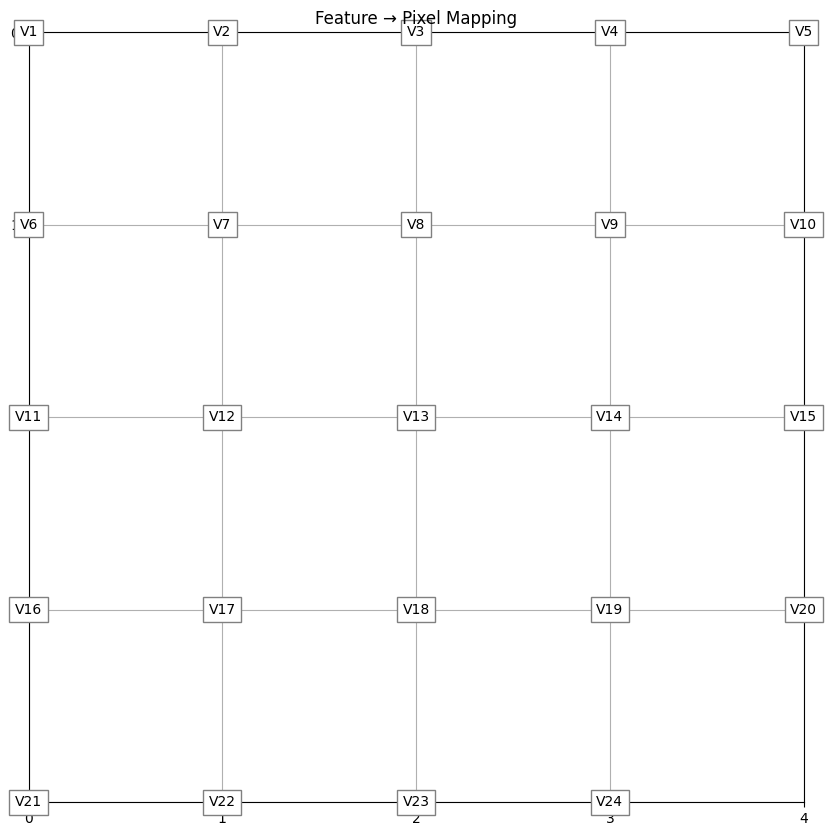

In [37]:
if hasattr(image_model, 'coordinate'):
    coordinates = image_model.coordinate
else:
    coordinates = (np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4]),
                   np.array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3]))

plot_feature_mapping(x_col, coordinates, scale=[5, 5])

In [38]:
# Combine dataloaders into tensors.
train_mlp, train_img, train_target = combine_loader(train_loader)
val_mlp, val_img, val_target = combine_loader(val_loader)
test_mlp, test_img, test_target = combine_loader(test_loader)

dataset = {
    "train_input": train_mlp.to(device),
    "train_img": train_img.to(device),
    "train_label": train_target.to(device),
    "val_input": val_mlp.to(device),
    "val_img": val_img.to(device),
    "val_label": val_target.to(device),
    "test_input": test_mlp.to(device),
    "test_img": test_img.to(device),
    "test_label": test_target.to(device),
}

In [39]:
# Print the shapes of the tensors
print("Train data shape:", dataset['train_input'].shape)
print("Train target shape:", dataset['train_label'].shape)
print("Test data shape:", dataset['test_input'].shape)
print("Test target shape:", dataset['test_label'].shape)
print("Validation data shape:", dataset['val_input'].shape)
print("Validation target shape:", dataset['val_label'].shape)

Train data shape: torch.Size([3491, 24])
Train target shape: torch.Size([3491, 1])
Test data shape: torch.Size([1092, 24])
Test target shape: torch.Size([1092, 1])
Validation data shape: torch.Size([873, 24])
Validation target shape: torch.Size([873, 1])


In [40]:
completed_coordinate, completed_x_col = complete_coordinate_and_xcol(coordinates, x_col)

In [41]:
completed_coordinate

(array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
        4, 4, 4]),
 array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1,
        2, 3, 4]))

# Set Files Name

In [42]:
filename_1=f'{dataset_name}_Refined_Concat_Op1.csv'
filename_2=f'{dataset_name}_Refined_Concat_Op2.csv'
filename_3=f'{dataset_name}_Refined_Concat_Op3.csv'
filename_4=f'{dataset_name}_Refined_Concat_Op4.csv'

In [43]:
columns_opt0 = '_'
columns_opt1 = 'cnn_bottleneck_dim'
columns_opt2 = 'alpha'
columns_opt3 = 'hidden_dim'
columns_opt4 = 'embed_dim, num_heads'

# Option 1: Concat KAN with (CNN with dense layer to reduce output_size)

In [46]:
create_csv_with_header(filename_1, columns_opt1)

## 1.0. width=[24, 12], grid=8, lamb=0.001

cnn_bottleneck_dim: 1
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


 train_acc_hybrid: 9.90e-01 | val_acc_hybrid: 9.06e-01 |: 100%|█████| 60/60 [00:22<00:00,  2.70it/s]


saving model version 0.1
✅ Best validation Accuracy: 9.2669e-01 at 26 epoch
tensor(0.9286, device='cuda:0')
[[409  26   5   1]
 [  9 406   4   1]
 [  0   3  63   0]
 [  0   8  21 136]]
M_KAN Relevance: 0.9476761817932129
CNN Relevance: 0.052323807030916214
[('V15', 0.4075017), ('V14', 0.2073019), ('V20', 0.19695799), ('V19', 0.15331711), ('V10', 0.12241825), ('V11', 0.11306469), ('V7', 0.100374594), ('V6', 0.09524846), ('V9', 0.09477931), ('V12', 0.088803306), ('V18', 0.088370994), ('V13', 0.08643343), ('V1', 0.08451339), ('V24', 0.08439555), ('V5', 0.08411461), ('V4', 0.07462059), ('V3', 0.074380025), ('V21', 0.067397505), ('V16', 0.06725317), ('V17', 0.06573753), ('V22', 0.06500006), ('V2', 0.050589994), ('V23', 0.04593502), ('V8', 0.04565099)]


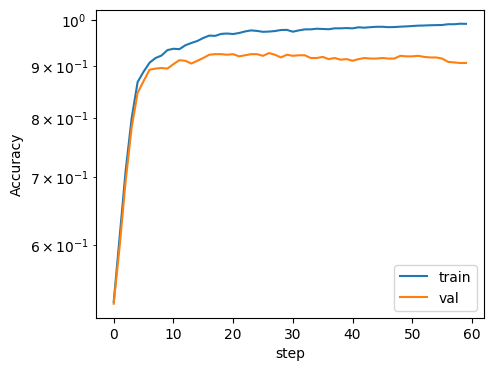

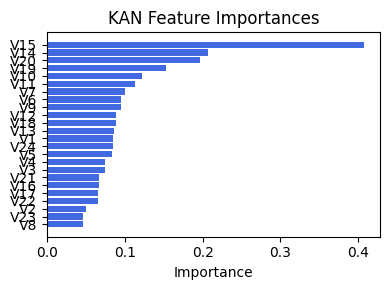

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V12', 0.5525293702602616), ('V13', 0.4749244945793286), ('V2', 0.43541875161175553), ('V3', 0.4281444394186603), ('V8', 0.4260924069314083), ('V17', 0.41646101652598094), ('V7', 0.4132242536527487), ('V14', 0.37738665505977614), ('V9', 0.37413357556354077), ('V4', 0.36423077089831424), ('V19', 0.3212557489004655), ('V18', 0.3200825927845175), ('V11', 0.2509446604143348), ('V16', 0.1708584100507147), ('V1', 0.1665329901648015), ('V6', 0.16375685444625346), ('V21', 0.13029012766697307), ('V22', 0.08655077079241552), ('V23', 0.08539228463675397), ('V24', 0.0735659447636996), ('V10', 0.06509119976510605), ('V20', 0.05962043975711785), ('V5', 0.052252784425346054), ('V15', 0.05101665794652598), ('Ex1', 0.008774604459996315)]


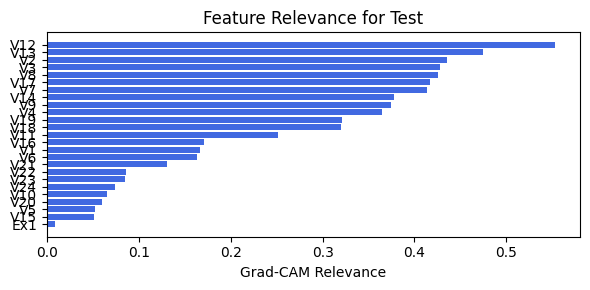

cnn_bottleneck_dim: 2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


 train_acc_hybrid: 9.97e-01 | val_acc_hybrid: 8.84e-01 |: 100%|█████| 60/60 [01:54<00:00,  1.90s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.1409e-01 at 6 epoch
tensor(0.9084, device='cuda:0')
[[409  28   4   0]
 [ 22 383  15   0]
 [  0   8  58   0]
 [  0   1  22 142]]
M_KAN Relevance: 0.9994131326675415
CNN Relevance: 0.0005868227453902364
[('V20', 0.32541233), ('V15', 0.29787827), ('V19', 0.27424785), ('V22', 0.18072474), ('V5', 0.14640851), ('V12', 0.14373265), ('V16', 0.13675909), ('V6', 0.1364699), ('V18', 0.13315183), ('V4', 0.13124152), ('V14', 0.13087843), ('V13', 0.11182763), ('V23', 0.10977453), ('V3', 0.10848587), ('V7', 0.104285955), ('V17', 0.10057703), ('V9', 0.09332879), ('V10', 0.08587905), ('V11', 0.084265396), ('V8', 0.0730567), ('V24', 0.068773404), ('V21', 0.066672266), ('V2', 0.06449928), ('V1', 0.051365968)]


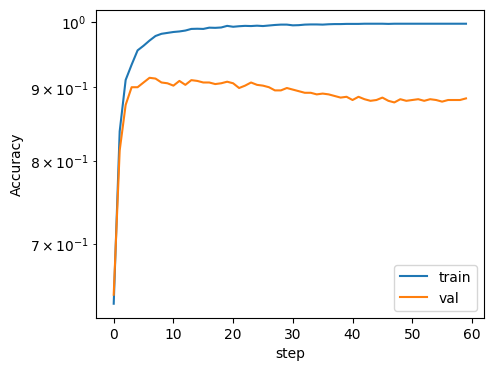

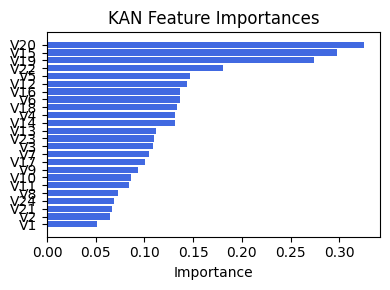

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V15', 0.324070539378313), ('V24', 0.3202699317638216), ('V10', 0.31282010285434103), ('V20', 0.31156995145144617), ('V5', 0.2736757992927282), ('V22', 0.25121420466915373), ('V23', 0.24233732470631847), ('Ex1', 0.21395346191536355), ('V17', 0.18583827487260024), ('V14', 0.18333207730898093), ('V21', 0.17839824043477456), ('V12', 0.17147199046972247), ('V19', 0.1700258144933503), ('V13', 0.16844374484938207), ('V9', 0.1635995992414475), ('V18', 0.16092909953036497), ('V16', 0.15837702651659516), ('V3', 0.15138330977529904), ('V7', 0.15100388387162683), ('V1', 0.15040677564543048), ('V4', 0.14690038468755356), ('V8', 0.1444635180634491), ('V11', 0.14231655793874837), ('V2', 0.1407534368802092), ('V6', 0.13900487475825768)]


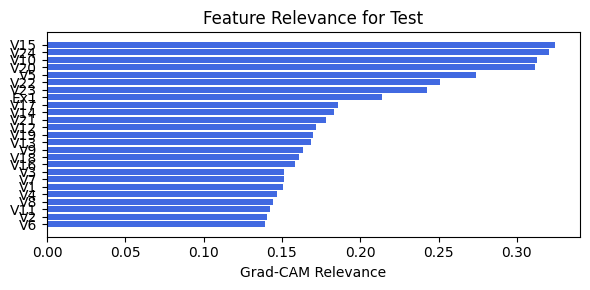

cnn_bottleneck_dim: 4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


 train_acc_hybrid: 9.98e-01 | val_acc_hybrid: 8.73e-01 |: 100%|█████| 60/60 [01:50<00:00,  1.83s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.2440e-01 at 11 epoch
tensor(0.9240, device='cuda:0')
[[415  23   2   1]
 [ 13 401   5   1]
 [  0  10  50   6]
 [  0   3  19 143]]
M_KAN Relevance: 0.9466075897216797
CNN Relevance: 0.05339239910244942
[('V20', 0.26303798), ('V15', 0.26275513), ('V19', 0.19986722), ('V9', 0.1477013), ('V11', 0.1403549), ('V18', 0.13727432), ('V22', 0.13570471), ('V12', 0.13514267), ('V14', 0.12665807), ('V16', 0.122088425), ('V13', 0.12204876), ('V4', 0.11657441), ('V10', 0.10292399), ('V17', 0.097018), ('V5', 0.09224723), ('V3', 0.09073057), ('V7', 0.090050444), ('V21', 0.06967767), ('V2', 0.06929612), ('V8', 0.06295334), ('V23', 0.06250548), ('V24', 0.05882197), ('V1', 0.047433775), ('V6', 0.04704111)]


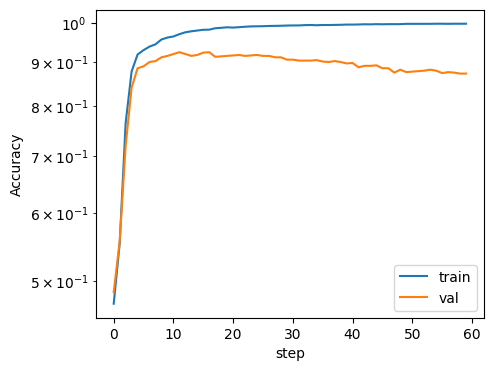

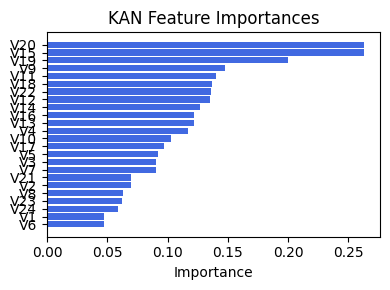

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V16', 0.3562376869193384), ('V21', 0.2714068613453485), ('V17', 0.2525798490531866), ('V7', 0.2394631996211611), ('V12', 0.22478662513983444), ('V8', 0.20601269219212673), ('V18', 0.19822152047498545), ('V9', 0.18114730451024058), ('V6', 0.17308612272117235), ('V4', 0.17170784573732523), ('V2', 0.17065754111905876), ('V11', 0.1674368602040916), ('V14', 0.1409616948637046), ('V19', 0.1197971676482976), ('V3', 0.08909790359269879), ('V22', 0.0889653339518357), ('V13', 0.08410186251845457), ('V20', 0.06700279678672161), ('V1', 0.0583810738704692), ('V10', 0.056224723354953376), ('V23', 0.05246225571629891), ('V5', 0.05081696416825016), ('V24', 0.04469373514562185), ('Ex1', 0.026245172077072713), ('V15', 0.02611045013483298)]


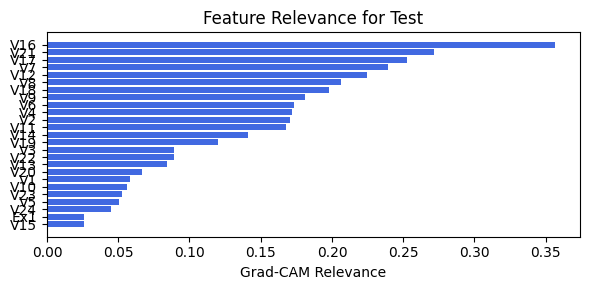

cnn_bottleneck_dim: 6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


 train_acc_hybrid: 9.96e-01 | val_acc_hybrid: 9.01e-01 |: 100%|█████| 60/60 [01:50<00:00,  1.84s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.3471e-01 at 14 epoch
tensor(0.9368, device='cuda:0')
[[420  19   1   1]
 [ 11 402   6   1]
 [  0   7  59   0]
 [  0   4  19 142]]
M_KAN Relevance: 0.9421271681785583
CNN Relevance: 0.05787278711795807
[('V15', 0.3309489), ('V20', 0.21495032), ('V13', 0.2107691), ('V19', 0.17972255), ('V9', 0.14092398), ('V11', 0.124454364), ('V18', 0.12155549), ('V5', 0.120625824), ('V10', 0.10752116), ('V14', 0.10545309), ('V4', 0.08442408), ('V6', 0.08418305), ('V12', 0.08322373), ('V3', 0.07876356), ('V17', 0.07780889), ('V22', 0.06450845), ('V16', 0.060772568), ('V24', 0.06038335), ('V23', 0.058968827), ('V7', 0.054953646), ('V2', 0.04748871), ('V8', 0.047050647), ('V21', 0.04518884), ('V1', 0.037811235)]


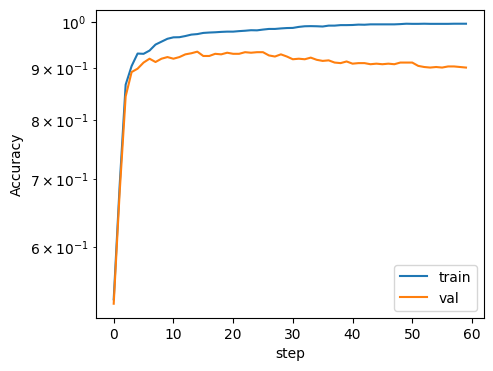

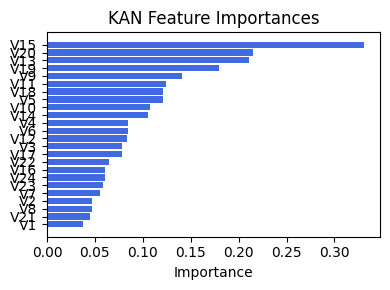

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V21', 0.5931828590195231), ('V16', 0.5823952720633575), ('V11', 0.5032013065630276), ('V12', 0.4097515519835471), ('V17', 0.3957829066021743), ('V18', 0.3733231221097449), ('V6', 0.31285126509936784), ('V8', 0.2941566751811719), ('V7', 0.2928580213557748), ('V13', 0.28663709356549544), ('V22', 0.23970124539799798), ('V14', 0.22498192161975356), ('V2', 0.17790296083348084), ('V9', 0.175524529245631), ('V19', 0.1480097787463466), ('V3', 0.13459204591095847), ('V23', 0.12632510548948112), ('V4', 0.1219822398095944), ('V24', 0.09959522862684672), ('V1', 0.06958427173413595), ('V10', 0.036265088379348144), ('V5', 0.027784468134726282), ('V20', 0.027041003032753082), ('V15', 0.012502239759852696), ('Ex1', 0.01003349589933057)]


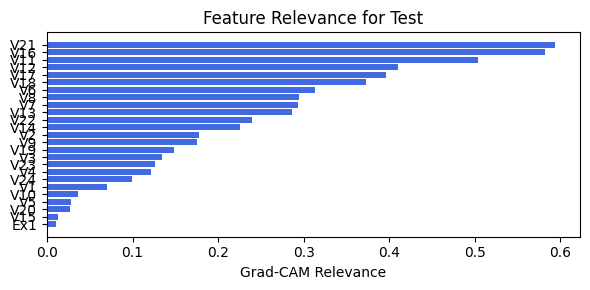

cnn_bottleneck_dim: 8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


 train_acc_hybrid: 9.97e-01 | val_acc_hybrid: 9.11e-01 |: 100%|█████| 60/60 [01:46<00:00,  1.78s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.1753e-01 at 28 epoch
tensor(0.9313, device='cuda:0')
[[410  23   8   0]
 [  7 404   9   0]
 [  2   4  60   0]
 [  0   5  17 143]]
M_KAN Relevance: 0.9724671840667725
CNN Relevance: 0.027532855048775673
[('V20', 0.24465662), ('V15', 0.22422788), ('V19', 0.21474169), ('V14', 0.1859746), ('V9', 0.15371019), ('V7', 0.1417782), ('V11', 0.13999297), ('V18', 0.135056), ('V12', 0.11063026), ('V6', 0.110187694), ('V17', 0.11000399), ('V5', 0.106474236), ('V13', 0.10138458), ('V24', 0.09863366), ('V2', 0.097847134), ('V22', 0.09686929), ('V10', 0.09043118), ('V4', 0.08882971), ('V3', 0.086772345), ('V16', 0.08125333), ('V8', 0.07081314), ('V21', 0.06822257), ('V23', 0.065397926), ('V1', 0.04768031)]


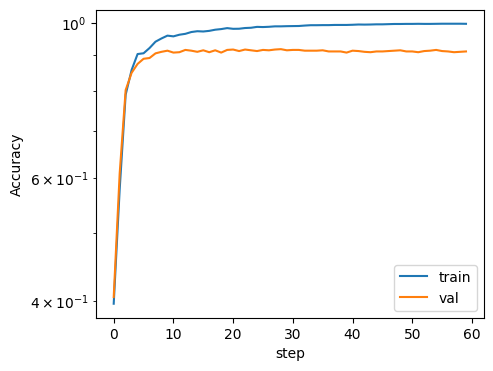

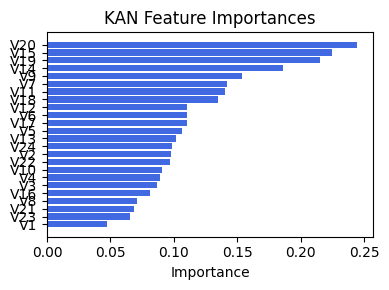

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V8', 0.40338318064235723), ('V13', 0.35493636932846623), ('V3', 0.327554206183417), ('V7', 0.3120852756858104), ('V2', 0.29814766020860384), ('V11', 0.2954629661460772), ('V6', 0.2711449206398733), ('V12', 0.2708428080920548), ('V17', 0.2686205164750074), ('V9', 0.24256902985334386), ('V16', 0.2405657828540282), ('V1', 0.238932330384689), ('V19', 0.2374890476107877), ('V24', 0.23190577245312496), ('V22', 0.22981669168981478), ('V23', 0.22235551390702232), ('V18', 0.22184107413164925), ('V14', 0.20376236917793875), ('V4', 0.18123151133549847), ('Ex1', 0.10394323497110655), ('V21', 0.09667032217623187), ('V20', 0.08402366018240157), ('V15', 0.07812505208679489), ('V5', 0.06301356927431885), ('V10', 0.060718819804472766)]


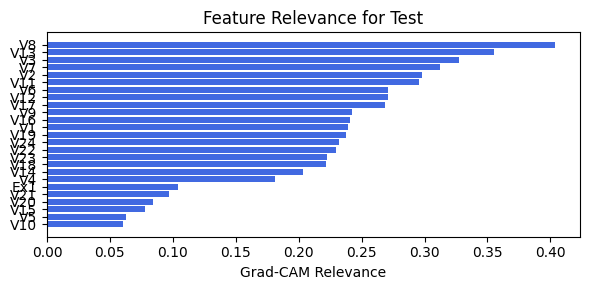

cnn_bottleneck_dim: 10
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


 train_acc_hybrid: 9.99e-01 | val_acc_hybrid: 8.79e-01 |: 100%|█████| 60/60 [01:49<00:00,  1.82s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.0722e-01 at 16 epoch
tensor(0.9075, device='cuda:0')
[[413  22   5   1]
 [ 18 384  17   1]
 [  0   9  53   4]
 [  0   5  19 141]]
M_KAN Relevance: 0.9329527020454407
CNN Relevance: 0.06704729795455933
[('V15', 0.22357604), ('V9', 0.20099346), ('V20', 0.19655119), ('V14', 0.19605419), ('V19', 0.18601689), ('V10', 0.15089205), ('V4', 0.13496538), ('V5', 0.12688725), ('V11', 0.1133975), ('V13', 0.112834096), ('V18', 0.112400964), ('V12', 0.10932486), ('V21', 0.09317054), ('V8', 0.092657864), ('V16', 0.089759275), ('V22', 0.08470616), ('V7', 0.08238134), ('V17', 0.08042984), ('V6', 0.07935559), ('V24', 0.071569994), ('V2', 0.068530105), ('V3', 0.058512475), ('V23', 0.057248913), ('V1', 0.04264602)]


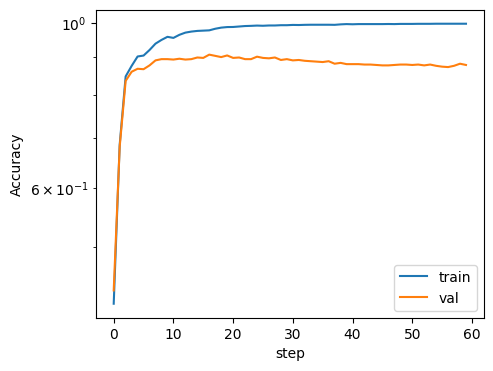

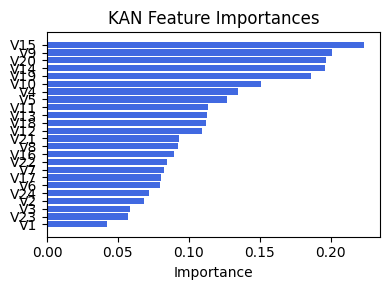

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V8', 0.49556986310249773), ('V13', 0.4908764036747562), ('V3', 0.4037946965263972), ('V12', 0.39215636314802793), ('V7', 0.37455721031429867), ('V2', 0.35919877848310855), ('V9', 0.34802276505099355), ('V17', 0.33805913662950715), ('V18', 0.3164673276035071), ('V14', 0.3162350835451974), ('V11', 0.3097666647688359), ('V19', 0.2900044384758728), ('V4', 0.26932220998141365), ('V16', 0.2530451437541337), ('V6', 0.23224535136176153), ('V1', 0.21852390292362223), ('Ex1', 0.15410145449378757), ('V20', 0.15378366095336832), ('V15', 0.14113854623772587), ('V22', 0.12693548365096655), ('V24', 0.1199410406679684), ('V10', 0.0970408158379105), ('V23', 0.0954627696624585), ('V21', 0.0902603363873766), ('V5', 0.05354124346049769)]


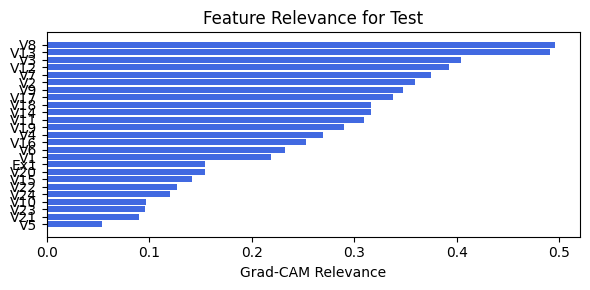

cnn_bottleneck_dim: 12
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


 train_acc_hybrid: 9.97e-01 | val_acc_hybrid: 8.90e-01 |: 100%|█████| 60/60 [00:21<00:00,  2.75it/s]


saving model version 0.1
✅ Best validation Accuracy: 9.1294e-01 at 17 epoch
tensor(0.8993, device='cuda:0')
[[399  38   3   1]
 [ 19 388  12   1]
 [  0   8  57   1]
 [  1   2  24 138]]
M_KAN Relevance: 0.8725608587265015
CNN Relevance: 0.12743906676769257
[('V15', 0.29840964), ('V19', 0.2683713), ('V20', 0.26633573), ('V9', 0.16881107), ('V13', 0.14745991), ('V14', 0.14430138), ('V18', 0.14235863), ('V17', 0.11367699), ('V11', 0.111049764), ('V7', 0.09568324), ('V12', 0.09551145), ('V6', 0.09418359), ('V10', 0.09012314), ('V4', 0.08007388), ('V3', 0.079678), ('V21', 0.07664799), ('V22', 0.07436084), ('V5', 0.070833065), ('V16', 0.069129094), ('V24', 0.0601769), ('V23', 0.05947803), ('V8', 0.05138592), ('V1', 0.042107385), ('V2', 0.040951572)]


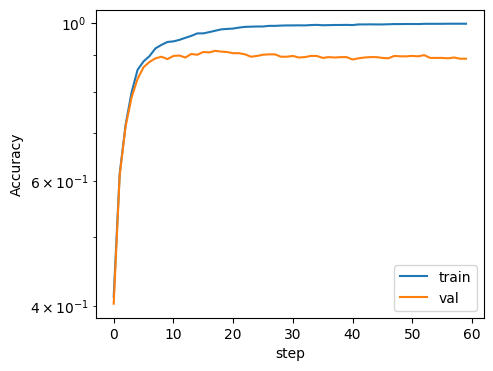

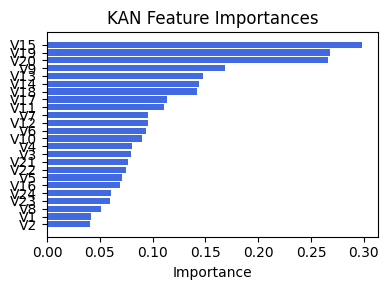

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V10', 0.39418478922205447), ('V3', 0.3314232599763266), ('V1', 0.29482383995816697), ('V20', 0.2804021933245014), ('V8', 0.27660475508251264), ('V15', 0.2698163518369976), ('V6', 0.2528101565020377), ('V2', 0.249658377853668), ('V9', 0.24676389421201014), ('V4', 0.2261130676629014), ('V5', 0.21162397793541926), ('V7', 0.1789929219769511), ('V11', 0.14218910291781153), ('V14', 0.12203233667662974), ('V16', 0.11830964919518476), ('V13', 0.09471479780679326), ('V19', 0.09294960182645202), ('V17', 0.07726255502153509), ('V12', 0.060949996713730505), ('V18', 0.05877188554258792), ('Ex1', 0.04899539233634648), ('V24', 0.015228053814474988), ('V22', 0.009236047006220943), ('V23', 0.007613442743151455), ('V21', 0.005045845901887855)]


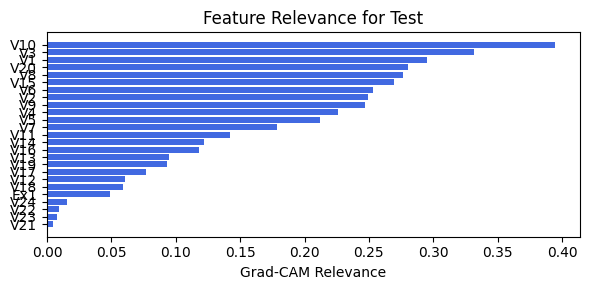

cnn_bottleneck_dim: 14
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


 train_acc_hybrid: 9.95e-01 | val_acc_hybrid: 9.15e-01 |: 100%|█████| 60/60 [00:21<00:00,  2.79it/s]


saving model version 0.1
✅ Best validation Accuracy: 9.3814e-01 at 19 epoch
tensor(0.9240, device='cuda:0')
[[410  26   3   2]
 [  8 403   9   0]
 [  0   9  53   4]
 [  0   5  17 143]]
M_KAN Relevance: 0.9473459124565125
CNN Relevance: 0.05265406519174576
[('V15', 0.2713104), ('V20', 0.24172835), ('V19', 0.21496187), ('V4', 0.1542431), ('V5', 0.15251333), ('V10', 0.14999637), ('V18', 0.13986854), ('V11', 0.13937114), ('V9', 0.13759148), ('V14', 0.13677534), ('V2', 0.12727071), ('V13', 0.12251445), ('V7', 0.11202146), ('V12', 0.10370719), ('V17', 0.09299947), ('V6', 0.08432664), ('V22', 0.082731724), ('V8', 0.074718), ('V23', 0.07455726), ('V16', 0.070928924), ('V21', 0.06892408), ('V3', 0.06644832), ('V24', 0.05463866), ('V1', 0.05074973)]


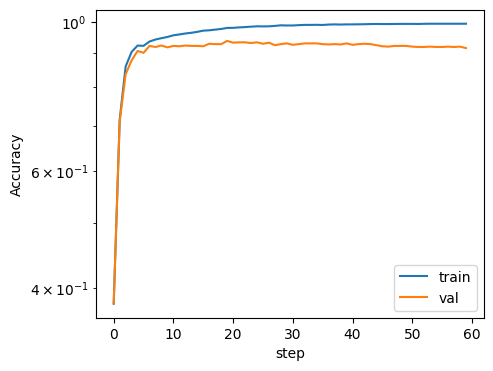

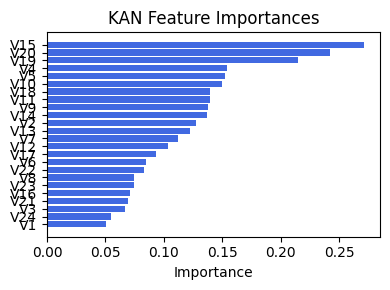

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V14', 0.3487761818376138), ('V13', 0.3147380725747561), ('V9', 0.3138175057693433), ('V20', 0.3090331517889134), ('V3', 0.30120781657389184), ('V4', 0.2930573298145003), ('V15', 0.28966835618612696), ('V10', 0.2822965314071719), ('V21', 0.2790419141294059), ('V8', 0.2759703091577759), ('V19', 0.26731582164155465), ('V12', 0.25644136129142014), ('V18', 0.24633394474387102), ('V5', 0.2333403952831156), ('V2', 0.21292824387266537), ('V7', 0.18639157161471018), ('V17', 0.18205973828773142), ('Ex1', 0.13779917913175085), ('V24', 0.1358768018264274), ('V23', 0.13505887415412737), ('V11', 0.13016146891725874), ('V1', 0.12894895618335248), ('V22', 0.12316568590100134), ('V6', 0.12062347535668648), ('V16', 0.11539285205213047)]


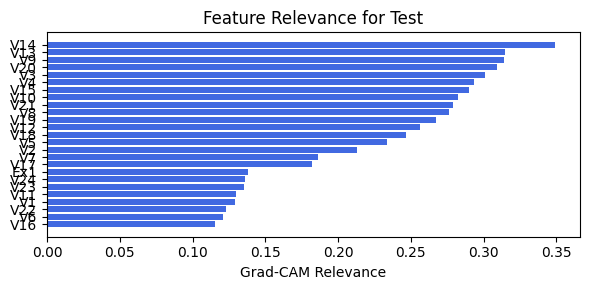

In [47]:
for cnn_bottleneck_dim in [1, 2, 4, 6, 8, 10, 12, 14]:
    print(f"cnn_bottleneck_dim: {cnn_bottleneck_dim}")
    train_and_plot_relevance(Model3_1, kan_neurons=12, kan_grid=8, lamb=0.001, steps=60, 
                             cnn_bottleneck_dim=cnn_bottleneck_dim, filename=filename_1, opt_col_val=cnn_bottleneck_dim)

## 1.1 width=[24, 6], grid=7, lamb=1e-05

cnn_bottleneck_dim: 1
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


 train_acc_hybrid: 9.91e-01 | val_acc_hybrid: 8.43e-01 |: 100%|█████| 60/60 [00:22<00:00,  2.70it/s]

saving model version 0.1
✅ Best validation Accuracy: 8.6598e-01 at 24 epoch
tensor(0.8581, device='cuda:0')
[[390  48   3   0]
 [ 30 372  16   2]
 [  1  14  48   3]
 [  0   7  31 127]]
M_KAN Relevance: 0.8012676239013672
CNN Relevance: 0.1987324208021164
[('V20', 0.24298742), ('V19', 0.2403742), ('V15', 0.2273981), ('V6', 0.18265037), ('V5', 0.16431376), ('V18', 0.14198121), ('V12', 0.13782594), ('V14', 0.13446721), ('V22', 0.13262601), ('V3', 0.12561162), ('V17', 0.12243827), ('V9', 0.12027176), ('V7', 0.10550821), ('V10', 0.10246651), ('V4', 0.09047669), ('V16', 0.086500496), ('V8', 0.08541764), ('V23', 0.07927862), ('V13', 0.076894596), ('V11', 0.07586097), ('V21', 0.060399465), ('V24', 0.059254643), ('V2', 0.05415251), ('V1', 0.03760972)]


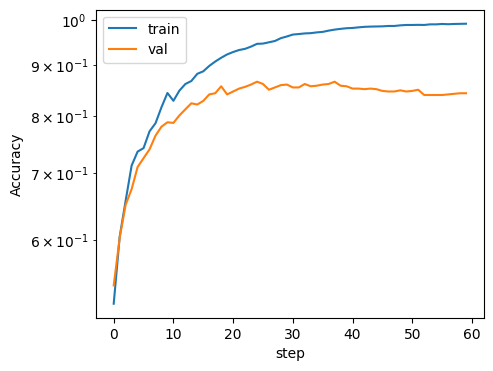

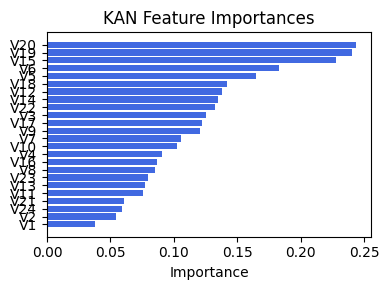

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V8', 0.6306695126188107), ('V13', 0.5445617834215254), ('V7', 0.5035403694455587), ('V12', 0.4560452661190895), ('V11', 0.4234129093971612), ('V16', 0.3965145142833918), ('V17', 0.39169556141303064), ('V9', 0.3883072014628558), ('V18', 0.3865486148509432), ('V6', 0.3857989720861605), ('V3', 0.32849864506942217), ('V2', 0.32556881629964235), ('V14', 0.29765274180244355), ('V19', 0.25044384628827276), ('V1', 0.22003434607984593), ('V4', 0.1838362252859112), ('V20', 0.11721940681930194), ('V10', 0.09210224591746265), ('V15', 0.07116011367579231), ('Ex1', 0.04752453310638118), ('V23', 0.03381191850303533), ('V21', 0.031478803611062776), ('V24', 0.031458279163356626), ('V22', 0.028995123781092282), ('V5', 0.024379177471035577)]


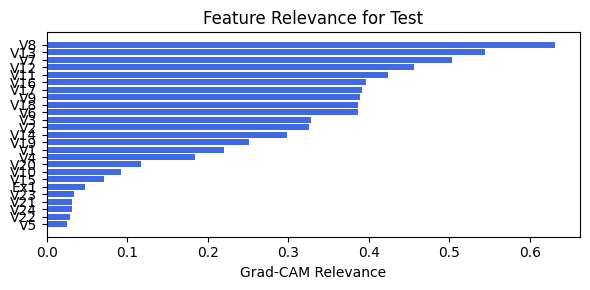

cnn_bottleneck_dim: 2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


 train_acc_hybrid: 9.93e-01 | val_acc_hybrid: 8.25e-01 |: 100%|█████| 60/60 [00:22<00:00,  2.65it/s]


saving model version 0.1
✅ Best validation Accuracy: 8.4536e-01 at 29 epoch
tensor(0.8361, device='cuda:0')
[[383  53   5   0]
 [ 33 355  31   1]
 [  2   6  57   1]
 [  2  10  35 118]]
M_KAN Relevance: 0.704308271408081
CNN Relevance: 0.29569169878959656
[('V20', 0.24809039), ('V19', 0.23359522), ('V5', 0.23289633), ('V15', 0.22345838), ('V11', 0.20632176), ('V12', 0.20482346), ('V9', 0.1741778), ('V24', 0.17390119), ('V14', 0.17087601), ('V23', 0.16818653), ('V10', 0.15233964), ('V4', 0.15201725), ('V6', 0.14367688), ('V18', 0.14075029), ('V7', 0.13537481), ('V2', 0.13126759), ('V13', 0.12181273), ('V21', 0.11698546), ('V22', 0.11262265), ('V16', 0.11203858), ('V17', 0.10662034), ('V3', 0.099782705), ('V8', 0.08053054), ('V1', 0.07972852)]


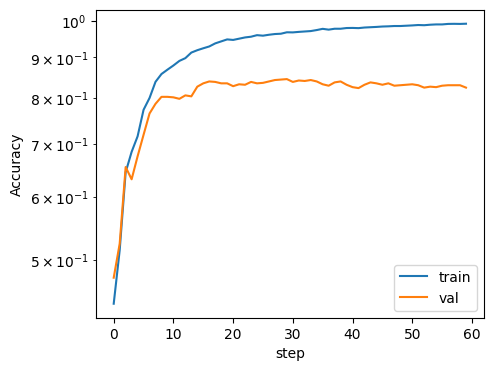

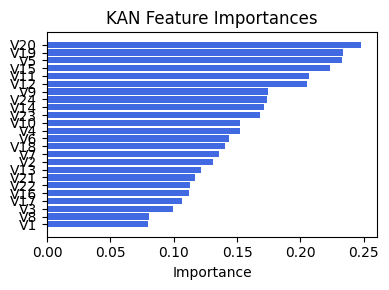

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V17', 0.3879786451680214), ('V18', 0.36847820517157365), ('V13', 0.3380429690461538), ('V16', 0.3172589177980166), ('V12', 0.2927090927252534), ('V8', 0.28593945047677294), ('V11', 0.26838926904819455), ('V7', 0.2648518852823198), ('V19', 0.24451759784960314), ('V14', 0.21527666050734787), ('V6', 0.2126076419276165), ('V9', 0.18035913973551196), ('V24', 0.16016815277397498), ('V22', 0.14952557450122006), ('V23', 0.14446047928360492), ('V21', 0.11728154019345598), ('V2', 0.10249992806352017), ('V3', 0.09849765659878391), ('V1', 0.091380490583199), ('Ex1', 0.0802999080336991), ('V20', 0.06897875299971383), ('V4', 0.06810977250750798), ('V5', 0.06100523690102342), ('V15', 0.05259579983215526), ('V10', 0.052161408171548414)]


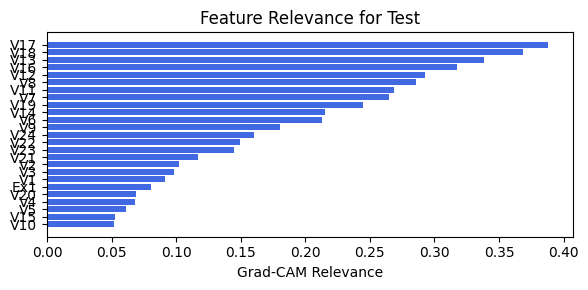

cnn_bottleneck_dim: 4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


 train_acc_hybrid: 9.82e-01 | val_acc_hybrid: 8.44e-01 |: 100%|█████| 60/60 [00:24<00:00,  2.48it/s]

saving model version 0.1
✅ Best validation Accuracy: 8.6712e-01 at 17 epoch
tensor(0.8645, device='cuda:0')
[[394  43   3   1]
 [ 33 369  15   3]
 [  0  12  52   2]
 [  0   7  29 129]]
M_KAN Relevance: 0.7664399147033691
CNN Relevance: 0.23356004059314728
[('V19', 0.31505305), ('V15', 0.25394928), ('V20', 0.22853939), ('V9', 0.22808203), ('V16', 0.18248346), ('V12', 0.15580359), ('V13', 0.14954138), ('V14', 0.14138767), ('V7', 0.12104337), ('V17', 0.1086463), ('V18', 0.105969965), ('V2', 0.10303735), ('V24', 0.10220793), ('V3', 0.090316735), ('V10', 0.087481156), ('V21', 0.08685318), ('V11', 0.086410865), ('V22', 0.084186904), ('V5', 0.07980235), ('V8', 0.068058565), ('V4', 0.06280075), ('V1', 0.060678672), ('V23', 0.05794709), ('V6', 0.05738982)]


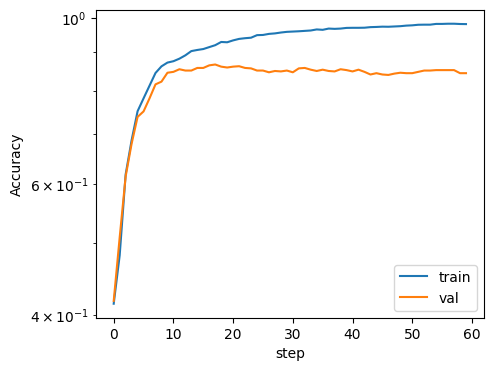

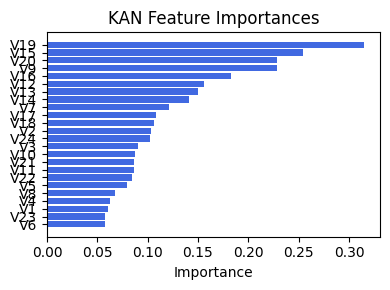

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V16', 0.49783745934411067), ('V6', 0.4150563116584505), ('V11', 0.3853715130567402), ('V3', 0.2623678095982668), ('V8', 0.2531229413167712), ('V2', 0.2440816553674637), ('V7', 0.22405366772632962), ('V1', 0.19171709264303435), ('V4', 0.17264606068201563), ('V12', 0.17156777950728674), ('V9', 0.14301865210514875), ('V17', 0.10813301016752278), ('V13', 0.10597101568019243), ('V18', 0.09570877871319614), ('V21', 0.08384192366958527), ('V14', 0.0586531229459829), ('V10', 0.04964477923774308), ('V20', 0.04662735208405851), ('V15', 0.038472769783972675), ('Ex1', 0.03537279790980925), ('V5', 0.03530096327223845), ('V19', 0.03380723273363108), ('V22', 0.004014230663978239), ('V23', 0.00261112905808569), ('V24', 0.0025445624258801608)]


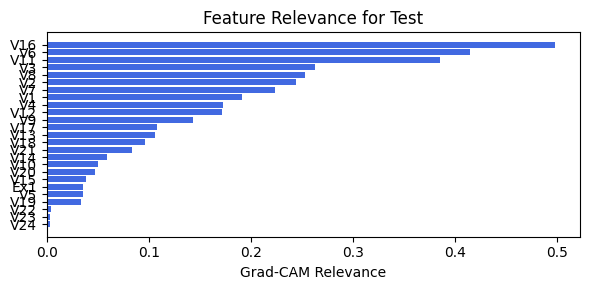

cnn_bottleneck_dim: 6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


 train_acc_hybrid: 9.67e-01 | val_acc_hybrid: 9.13e-01 |: 100%|█████| 60/60 [00:22<00:00,  2.65it/s]


saving model version 0.1
✅ Best validation Accuracy: 9.2325e-01 at 9 epoch
tensor(0.9112, device='cuda:0')
[[406  30   4   1]
 [ 19 397   3   1]
 [  3   4  57   2]
 [  1   3  26 135]]
M_KAN Relevance: 0.8592607378959656
CNN Relevance: 0.14073926210403442
[('V15', 0.21359295), ('V19', 0.19890259), ('V14', 0.19450492), ('V20', 0.1939284), ('V7', 0.14469022), ('V18', 0.14375553), ('V3', 0.13615021), ('V12', 0.13500027), ('V22', 0.126948), ('V10', 0.12333956), ('V6', 0.12116563), ('V13', 0.11966481), ('V9', 0.117940806), ('V16', 0.10790693), ('V11', 0.10120146), ('V17', 0.0961546), ('V8', 0.09460648), ('V24', 0.07866341), ('V4', 0.07715869), ('V5', 0.075352184), ('V2', 0.07144642), ('V1', 0.0689167), ('V21', 0.058817696), ('V23', 0.049769476)]


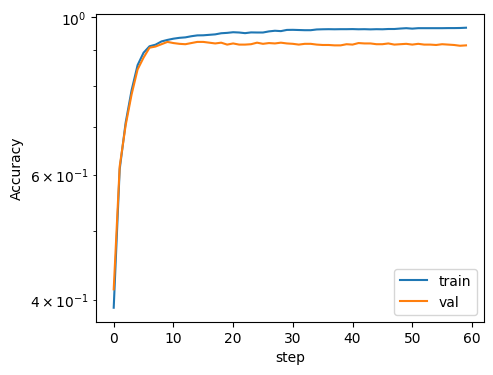

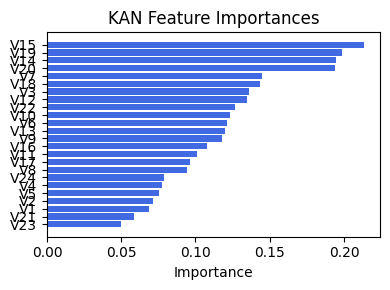

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V10', 0.4970071770985536), ('V5', 0.4411970714973661), ('V9', 0.38900265682594437), ('V4', 0.38629345561039974), ('V15', 0.3297527986683385), ('V20', 0.31854125011348566), ('V3', 0.2617182938571844), ('V14', 0.21017725035624726), ('V2', 0.16329530392723984), ('V8', 0.14559403476852203), ('V19', 0.13442510084452486), ('V7', 0.1159403340494504), ('V1', 0.06577665646978365), ('V17', 0.06030552861979658), ('V13', 0.044035527046753654), ('V18', 0.04194507749983401), ('V12', 0.035137864820861286), ('Ex1', 0.024354709033328092), ('V21', 0.022895097031246908), ('V6', 0.019311108313965947), ('V24', 0.01462389217658877), ('V11', 0.011262637238989836), ('V16', 0.00942796267275335), ('V22', 0.009046359741163735), ('V23', 0.005334966520332363)]


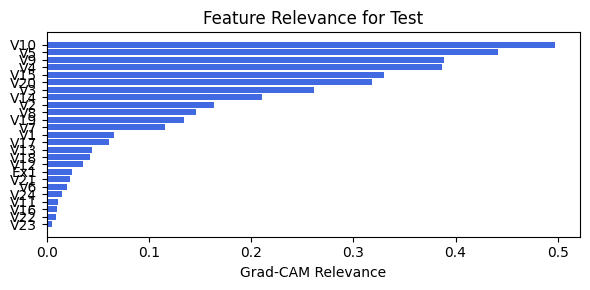

cnn_bottleneck_dim: 8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


 train_acc_hybrid: 9.84e-01 | val_acc_hybrid: 8.79e-01 |: 100%|█████| 60/60 [00:20<00:00,  2.87it/s]


saving model version 0.1
✅ Best validation Accuracy: 8.9920e-01 at 22 epoch
tensor(0.9139, device='cuda:0')
[[403  34   3   1]
 [ 13 401   4   2]
 [  1   6  57   2]
 [  2   1  25 137]]
M_KAN Relevance: 0.7502537965774536
CNN Relevance: 0.249746173620224
[('V20', 0.27864355), ('V15', 0.23574856), ('V19', 0.22495763), ('V12', 0.19547874), ('V5', 0.16295467), ('V4', 0.16174705), ('V16', 0.15548524), ('V18', 0.1366447), ('V17', 0.1345264), ('V10', 0.12352069), ('V24', 0.11094182), ('V14', 0.10646999), ('V9', 0.102777764), ('V8', 0.09874784), ('V22', 0.09532302), ('V2', 0.09364796), ('V13', 0.09355438), ('V23', 0.08629228), ('V6', 0.08394082), ('V7', 0.07734278), ('V21', 0.06898256), ('V1', 0.060284536), ('V3', 0.05588683), ('V11', 0.05522744)]


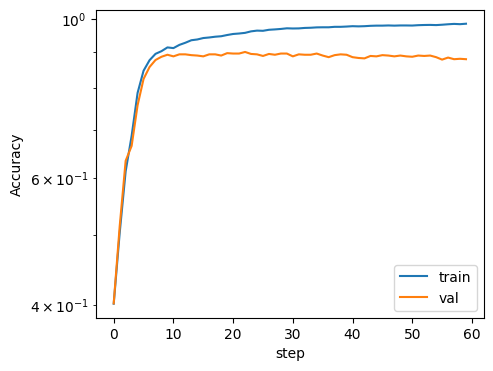

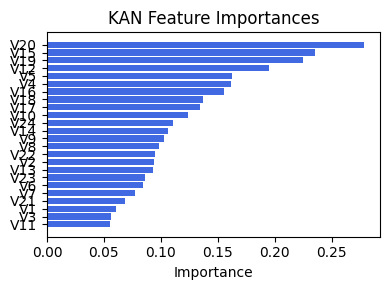

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V14', 0.7045345296021449), ('V15', 0.6269642586314295), ('V13', 0.6055471766923448), ('V20', 0.5944752096421948), ('V9', 0.5754155299426722), ('V10', 0.5626832660003617), ('V18', 0.561350956833802), ('V19', 0.5405049322082597), ('V8', 0.4955077061025364), ('V4', 0.43069276335093126), ('V12', 0.418478249925248), ('V3', 0.40609698664698063), ('V17', 0.36723468507658824), ('V5', 0.34935597034005766), ('V7', 0.30223438297563365), ('V2', 0.2470186070493003), ('V23', 0.20483276508036394), ('Ex1', 0.19808721312427477), ('V24', 0.18778896251277172), ('V22', 0.15262230288496603), ('V16', 0.10309992354567783), ('V21', 0.08863268738472664), ('V11', 0.08168878411295456), ('V6', 0.07352052291024425), ('V1', 0.049095783668455406)]


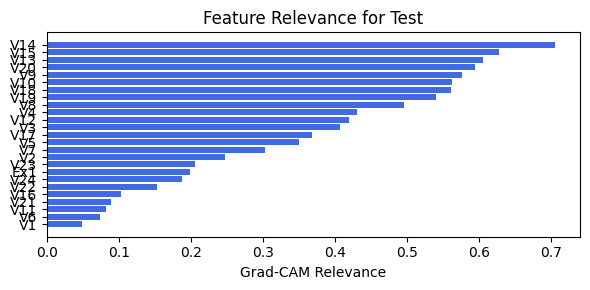

cnn_bottleneck_dim: 10
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


 train_acc_hybrid: 9.87e-01 | val_acc_hybrid: 8.82e-01 |: 100%|█████| 60/60 [00:22<00:00,  2.71it/s]


saving model version 0.1
✅ Best validation Accuracy: 9.0836e-01 at 14 epoch
tensor(0.9038, device='cuda:0')
[[407  30   3   1]
 [ 20 396   3   1]
 [  1   8  54   3]
 [  1   3  31 130]]
M_KAN Relevance: 0.7374781370162964
CNN Relevance: 0.2625218629837036
[('V15', 0.26929024), ('V19', 0.22527152), ('V20', 0.20170271), ('V12', 0.18186599), ('V7', 0.17518555), ('V11', 0.16164458), ('V16', 0.16140828), ('V22', 0.15408093), ('V14', 0.13874134), ('V10', 0.12935561), ('V9', 0.12426455), ('V18', 0.11695933), ('V24', 0.10457736), ('V3', 0.10128099), ('V5', 0.09666632), ('V13', 0.09460142), ('V4', 0.092864156), ('V8', 0.091194004), ('V2', 0.08217633), ('V23', 0.08139699), ('V21', 0.060510248), ('V17', 0.058867656), ('V6', 0.05550632), ('V1', 0.04797454)]


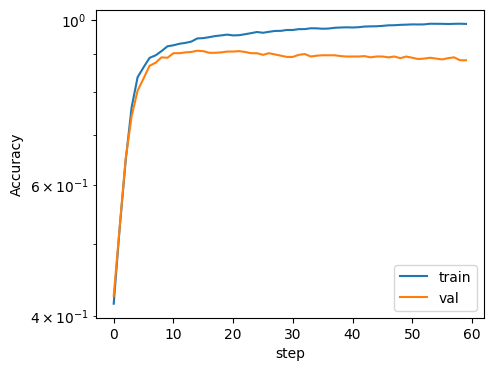

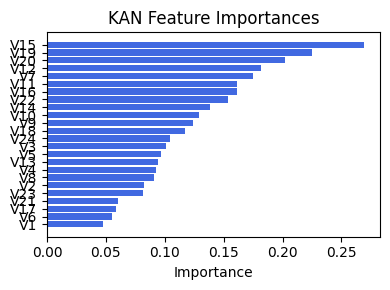

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V13', 0.4210943150612945), ('V14', 0.38973379591728824), ('V8', 0.35804721947346607), ('V19', 0.33108516492059575), ('V9', 0.3171828051735257), ('V12', 0.2991969324093089), ('V24', 0.2934157574999561), ('V7', 0.2860207963172404), ('V18', 0.2738786822213651), ('V3', 0.27359384299902373), ('V17', 0.2688799679149053), ('V22', 0.2358167877158209), ('V20', 0.228648567691743), ('V23', 0.22803639417280122), ('V15', 0.22309900861217855), ('V4', 0.21182130244801473), ('V2', 0.19904183175082), ('V11', 0.18183975111578515), ('V10', 0.17734589253431737), ('Ex1', 0.16405517347645263), ('V16', 0.1568011210665079), ('V6', 0.13974832031791656), ('V5', 0.10449710812126163), ('V1', 0.09818879416231469), ('V21', 0.08537204901659896)]


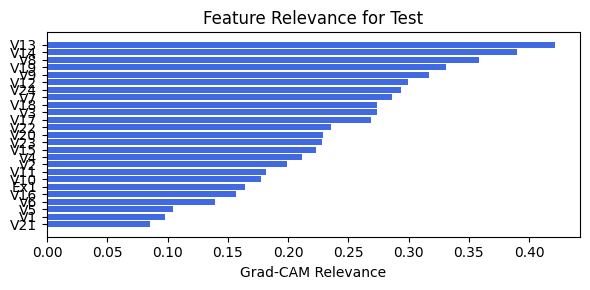

cnn_bottleneck_dim: 12
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


 train_acc_hybrid: 9.83e-01 | val_acc_hybrid: 8.77e-01 |: 100%|█████| 60/60 [00:20<00:00,  2.98it/s]


saving model version 0.1
✅ Best validation Accuracy: 8.9233e-01 at 23 epoch
tensor(0.8965, device='cuda:0')
[[407  30   3   1]
 [ 23 379  15   3]
 [  0  11  52   3]
 [  0   4  20 141]]
M_KAN Relevance: 0.6972979307174683
CNN Relevance: 0.30270206928253174
[('V19', 0.28408659), ('V15', 0.266127), ('V20', 0.2501823), ('V5', 0.1887682), ('V11', 0.18459374), ('V22', 0.1800052), ('V9', 0.1602431), ('V10', 0.15655604), ('V18', 0.15477413), ('V14', 0.1524682), ('V12', 0.15074702), ('V8', 0.1437609), ('V6', 0.13472828), ('V4', 0.13397577), ('V16', 0.13327359), ('V13', 0.11041876), ('V24', 0.106803164), ('V2', 0.10670242), ('V23', 0.106013834), ('V17', 0.10562789), ('V21', 0.1003557), ('V3', 0.093982086), ('V7', 0.078492984), ('V1', 0.074019104)]


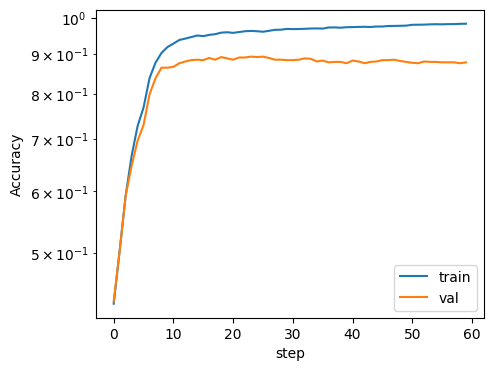

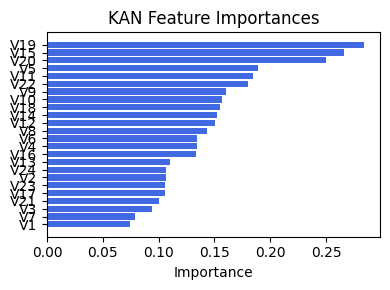

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V16', 0.4723748369837494), ('V11', 0.3854424785927105), ('V21', 0.352056129835546), ('V6', 0.3400393478778547), ('V2', 0.24931158955467372), ('V1', 0.2073268578059446), ('V12', 0.1824029261544718), ('V7', 0.18032334986566687), ('V4', 0.17881686799308147), ('V3', 0.1682080374471964), ('V22', 0.15666198824333932), ('V8', 0.15264457423445293), ('V24', 0.1249248898634122), ('V20', 0.12398851108302332), ('V23', 0.120177149115729), ('V17', 0.11369728025231483), ('Ex1', 0.0968467955029358), ('V9', 0.0940338738519364), ('V13', 0.08826387548216745), ('V5', 0.08477666124249164), ('V14', 0.083780900271496), ('V18', 0.08130761401780247), ('V15', 0.07230664056084236), ('V10', 0.06715982886244058), ('V19', 0.06216220879497543)]


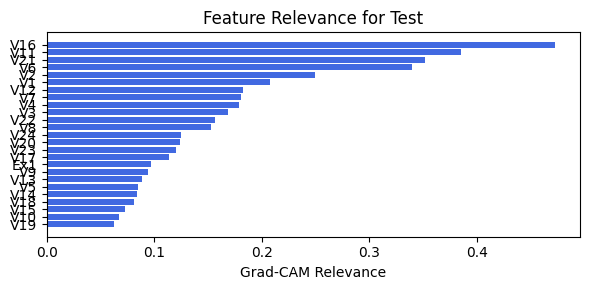

In [48]:
for cnn_bottleneck_dim in [1, 2, 4, 6, 8, 10, 12]:
    print(f"cnn_bottleneck_dim: {cnn_bottleneck_dim}")
    train_and_plot_relevance(Model3_1, kan_neurons=6, kan_grid=7, lamb=1e-05, steps=60, 
                             cnn_bottleneck_dim=cnn_bottleneck_dim, filename=filename_1, opt_col_val=cnn_bottleneck_dim)

## 1.2. width=[24, 11], grid=3, lamb=0.001

cnn_bottleneck_dim: 1
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


 train_acc_hybrid: 9.94e-01 | val_acc_hybrid: 8.60e-01 |: 100%|█████| 60/60 [00:20<00:00,  2.87it/s]


saving model version 0.1
✅ Best validation Accuracy: 9.2096e-01 at 5 epoch
tensor(0.9130, device='cuda:0')
[[415  22   4   0]
 [ 17 384  19   0]
 [  0   6  60   0]
 [  0   2  25 138]]
M_KAN Relevance: 0.9999999403953552
CNN Relevance: 6.691116283263909e-08
[('V20', 0.25859347), ('V15', 0.23124714), ('V19', 0.19772807), ('V7', 0.17009224), ('V9', 0.16019866), ('V22', 0.15515248), ('V6', 0.14240211), ('V5', 0.12705088), ('V12', 0.118430756), ('V3', 0.11144024), ('V18', 0.10884775), ('V14', 0.097544), ('V13', 0.09538579), ('V11', 0.09492134), ('V2', 0.08605782), ('V16', 0.076125324), ('V4', 0.07196984), ('V21', 0.07056231), ('V10', 0.06589922), ('V8', 0.06127962), ('V17', 0.059681755), ('V23', 0.05779618), ('V24', 0.0572682), ('V1', 0.034369048)]


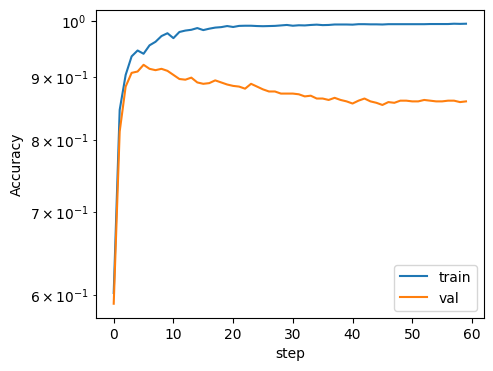

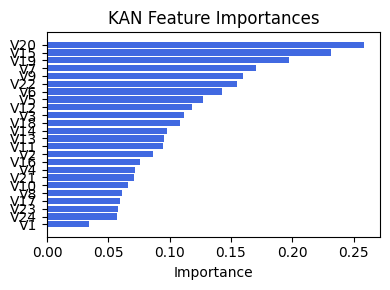

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V22', 0.40557326714362396), ('V24', 0.38250202991813764), ('V23', 0.35498433616496333), ('V5', 0.32025780116650104), ('V10', 0.2736417927140732), ('V15', 0.2516225510071741), ('V21', 0.23894902720655406), ('V11', 0.22876436975862957), ('V20', 0.22541791796989163), ('V17', 0.22185916398617145), ('V16', 0.20889487441924687), ('V13', 0.20311031196882176), ('Ex1', 0.20149827405888765), ('V12', 0.19338195973639666), ('V19', 0.19334652468808602), ('V1', 0.19211253995090108), ('V7', 0.19152841302568363), ('V3', 0.18892444494313734), ('V18', 0.18440171613999418), ('V14', 0.178044851884976), ('V2', 0.17639892400007745), ('V4', 0.17559213193870385), ('V6', 0.17385621423979764), ('V8', 0.16915094996698032), ('V9', 0.16205929115814477)]


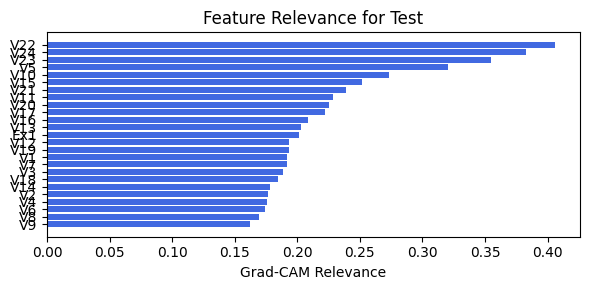

cnn_bottleneck_dim: 5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


 train_acc_hybrid: 9.95e-01 | val_acc_hybrid: 9.05e-01 |: 100%|█████| 60/60 [00:22<00:00,  2.63it/s]


saving model version 0.1
✅ Best validation Accuracy: 9.3471e-01 at 14 epoch
tensor(0.9267, device='cuda:0')
[[410  28   2   1]
 [  6 407   6   1]
 [  1   8  54   3]
 [  1   3  20 141]]
M_KAN Relevance: 0.9450161457061768
CNN Relevance: 0.05498383566737175
[('V15', 0.2645014), ('V19', 0.23149638), ('V5', 0.17411947), ('V20', 0.15685084), ('V12', 0.1553201), ('V2', 0.15008049), ('V14', 0.14951235), ('V18', 0.1370111), ('V7', 0.13395305), ('V11', 0.124643184), ('V3', 0.111541145), ('V6', 0.10045077), ('V22', 0.09894619), ('V16', 0.08336838), ('V13', 0.075786926), ('V10', 0.07361727), ('V4', 0.07163926), ('V17', 0.07022107), ('V21', 0.058318507), ('V23', 0.057142794), ('V9', 0.05627643), ('V8', 0.049894754), ('V24', 0.04784936), ('V1', 0.026731867)]


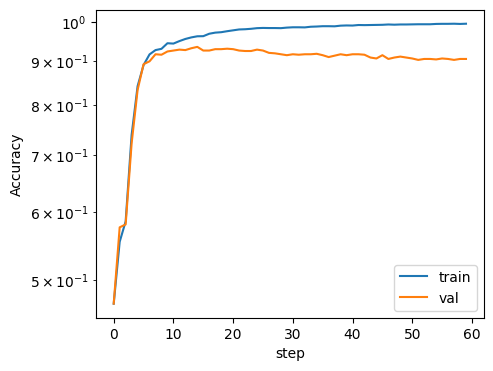

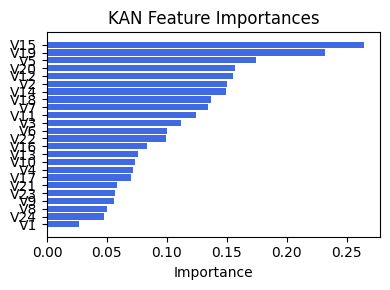

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V16', 0.5002010063447985), ('V11', 0.45710786213397286), ('V13', 0.3982708790107552), ('V6', 0.32764420312558107), ('V12', 0.29787991641781414), ('V17', 0.2891651495396511), ('V5', 0.2881896378273731), ('V18', 0.26190334243504604), ('V8', 0.22775129534985578), ('V7', 0.22313478735265693), ('V3', 0.21651663819298952), ('V10', 0.18422292559350084), ('V9', 0.13930116828247505), ('V22', 0.1365314136510678), ('V21', 0.131067808380733), ('V19', 0.12528120917638025), ('V1', 0.12250243514925041), ('V4', 0.11893378820691612), ('V14', 0.11283676982422329), ('V2', 0.10995706695632426), ('V20', 0.09207475850752626), ('V15', 0.056119002297220215), ('V23', 0.026469372729000067), ('V24', 0.022866100922235486), ('Ex1', 0.0013835450015557442)]


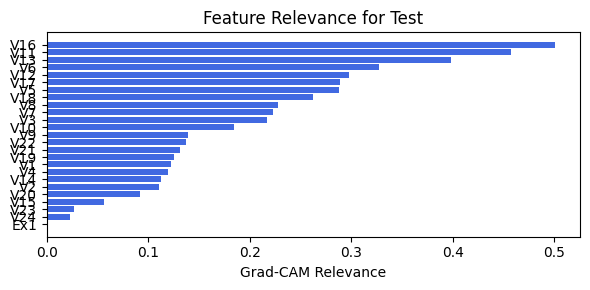

cnn_bottleneck_dim: 8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


 train_acc_hybrid: 9.95e-01 | val_acc_hybrid: 8.87e-01 |: 100%|█████| 60/60 [00:20<00:00,  2.91it/s]


saving model version 0.1
✅ Best validation Accuracy: 9.1409e-01 at 20 epoch
tensor(0.9093, device='cuda:0')
[[399  38   3   1]
 [ 13 394  10   3]
 [  1   8  54   3]
 [  0   6  13 146]]
M_KAN Relevance: 0.8915054798126221
CNN Relevance: 0.1084946021437645
[('V15', 0.3276169), ('V20', 0.2489301), ('V19', 0.23472534), ('V9', 0.18919271), ('V16', 0.14607547), ('V7', 0.14440425), ('V18', 0.13870434), ('V12', 0.13771881), ('V10', 0.12684274), ('V17', 0.12558128), ('V4', 0.11281844), ('V24', 0.11214006), ('V14', 0.112120055), ('V5', 0.09665968), ('V11', 0.09520573), ('V22', 0.093620025), ('V23', 0.09192062), ('V13', 0.09148423), ('V6', 0.08824738), ('V2', 0.07297148), ('V3', 0.06971123), ('V8', 0.060271006), ('V21', 0.053660512), ('V1', 0.05280888)]


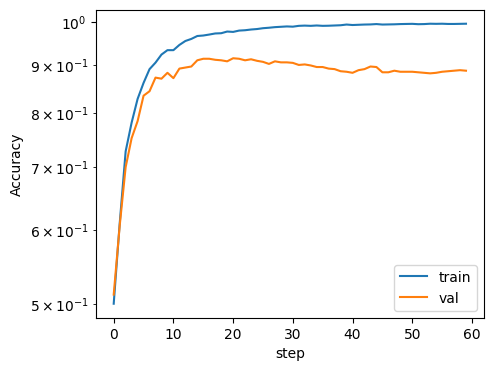

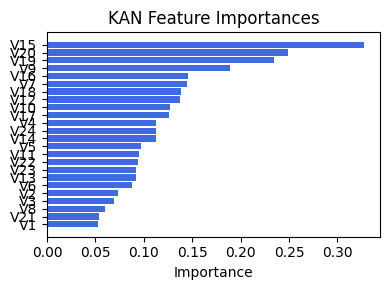

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V19', 0.411470729148797), ('V23', 0.37792033755951854), ('V22', 0.3769736960252569), ('V14', 0.3681723925330829), ('V24', 0.33060224590637133), ('V20', 0.32098088748053727), ('V18', 0.3041239086255617), ('V9', 0.29509751636340054), ('V15', 0.2783150211530533), ('V13', 0.25122841416974123), ('V17', 0.23408121603708237), ('V8', 0.23058518425733338), ('V10', 0.2212771880882035), ('V21', 0.19126981496011358), ('V7', 0.17327985732245596), ('V12', 0.15487272688400874), ('Ex1', 0.14839655174677613), ('V3', 0.14200425805772812), ('V4', 0.13889961132826428), ('V2', 0.13321472480137822), ('V5', 0.12916697932726512), ('V11', 0.10149254115081338), ('V16', 0.10066939687153585), ('V1', 0.09841121739486464), ('V6', 0.08263244720039885)]


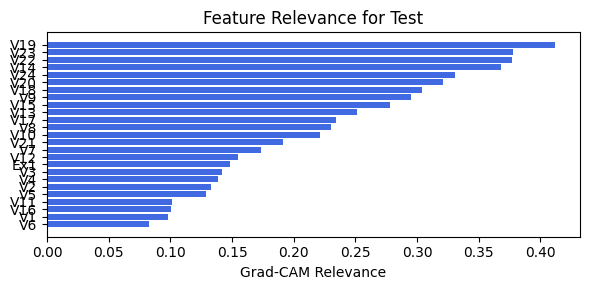

cnn_bottleneck_dim: 10
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


 train_acc_hybrid: 9.91e-01 | val_acc_hybrid: 9.05e-01 |: 100%|█████| 60/60 [00:21<00:00,  2.78it/s]


saving model version 0.1
✅ Best validation Accuracy: 9.2325e-01 at 37 epoch
tensor(0.9277, device='cuda:0')
[[418  19   3   1]
 [ 16 396   8   0]
 [  0   8  56   2]
 [  0   6  16 143]]
M_KAN Relevance: 0.9025477170944214
CNN Relevance: 0.09745226055383682
[('V20', 0.28473875), ('V15', 0.2747243), ('V19', 0.24216004), ('V6', 0.1940344), ('V5', 0.19028538), ('V14', 0.17714071), ('V18', 0.14393829), ('V9', 0.13053314), ('V13', 0.12111288), ('V11', 0.111382484), ('V2', 0.10996183), ('V24', 0.102089286), ('V17', 0.09341393), ('V12', 0.087059885), ('V23', 0.082939), ('V7', 0.07967573), ('V4', 0.073374644), ('V22', 0.07232786), ('V3', 0.070037685), ('V8', 0.069913626), ('V1', 0.06810277), ('V10', 0.06381554), ('V16', 0.06014329), ('V21', 0.05859642)]


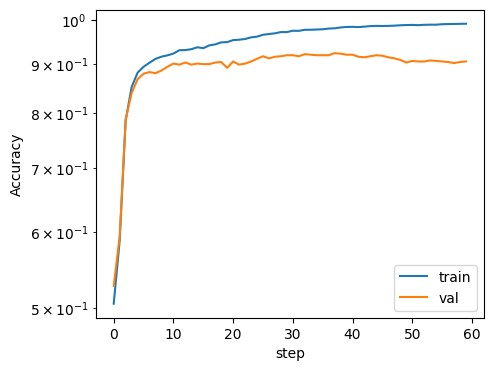

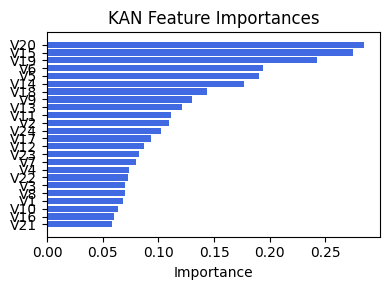

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V11', 0.3156130198616792), ('V16', 0.24780242295990973), ('V6', 0.19456994877686284), ('V1', 0.1664866258599545), ('V14', 0.1280627816313793), ('V2', 0.11469241700168965), ('V21', 0.10887055613949044), ('V19', 0.10875356195881997), ('V3', 0.10483539033578385), ('V9', 0.0937594501749664), ('V7', 0.09254225837871123), ('V12', 0.0897065112648716), ('V17', 0.08186479889098623), ('V8', 0.08079168783464971), ('V24', 0.07928365869199194), ('V10', 0.07633844586903735), ('V15', 0.07490891444960766), ('V20', 0.07268065648645045), ('V5', 0.056482551305238396), ('V13', 0.05195639947002443), ('V4', 0.04843353559112734), ('V18', 0.04435984272730064), ('Ex1', 0.03631868030749298), ('V22', 0.03313463814799264), ('V23', 0.024446178270012844)]


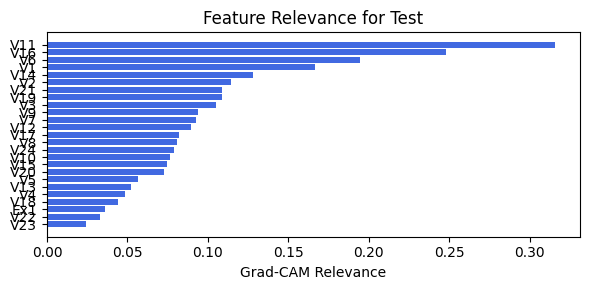

cnn_bottleneck_dim: 15
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


 train_acc_hybrid: 9.85e-01 | val_acc_hybrid: 9.24e-01 |: 100%|█████| 60/60 [00:27<00:00,  2.22it/s]


saving model version 0.1
✅ Best validation Accuracy: 9.3929e-01 at 39 epoch
tensor(0.9295, device='cuda:0')
[[412  27   1   1]
 [  9 404   6   1]
 [  0   7  58   1]
 [  0   3  21 141]]
M_KAN Relevance: 0.8869238495826721
CNN Relevance: 0.1130761206150055
[('V15', 0.36451504), ('V12', 0.25147176), ('V19', 0.22944951), ('V20', 0.22265053), ('V9', 0.20687222), ('V6', 0.18698967), ('V22', 0.14714955), ('V14', 0.13877541), ('V18', 0.13346161), ('V13', 0.11920055), ('V4', 0.10842021), ('V5', 0.107802786), ('V7', 0.093803115), ('V16', 0.093414664), ('V17', 0.09031349), ('V2', 0.08610669), ('V8', 0.08417789), ('V11', 0.08038143), ('V23', 0.07681091), ('V10', 0.069138296), ('V3', 0.06485339), ('V24', 0.06351949), ('V1', 0.047809538), ('V21', 0.044302624)]


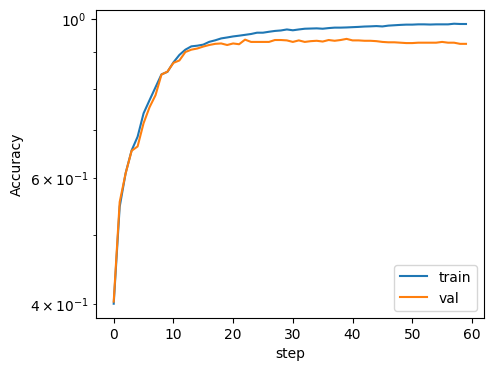

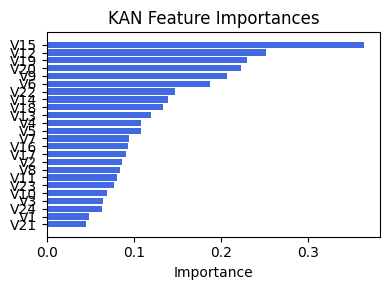

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V18', 0.5095625717897351), ('V13', 0.4586387015661675), ('V17', 0.4326467037658487), ('V19', 0.3868766797044666), ('V12', 0.3679132287743614), ('V14', 0.33308221293347223), ('V8', 0.32909641052159605), ('V23', 0.3187110118641289), ('V22', 0.29750270894265124), ('V7', 0.27507144874179285), ('V16', 0.27271836840570224), ('V11', 0.2651132758380163), ('V24', 0.2614439430056206), ('V9', 0.24069483253057755), ('V21', 0.20062340360098646), ('V3', 0.18826106381338198), ('V4', 0.18745192641011976), ('V6', 0.1871700289268033), ('V5', 0.17378934418506797), ('V2', 0.15204051689730083), ('V20', 0.15011732775360626), ('V15', 0.14415463550827992), ('V10', 0.11949100656880086), ('V1', 0.11495202115545594), ('Ex1', 0.09561228556442287)]


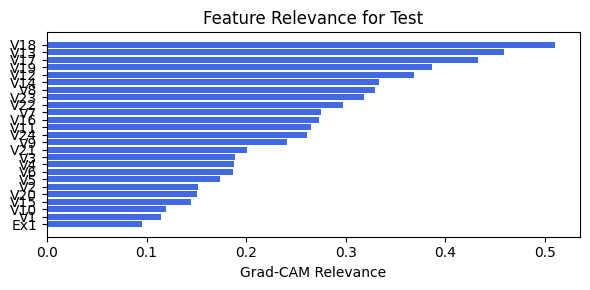

cnn_bottleneck_dim: 20
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


 train_acc_hybrid: 9.88e-01 | val_acc_hybrid: 9.28e-01 |: 100%|█████| 60/60 [00:21<00:00,  2.83it/s]

saving model version 0.1
✅ Best validation Accuracy: 9.4616e-01 at 27 epoch
tensor(0.9332, device='cuda:0')
[[415  22   3   1]
 [  9 401  10   0]
 [  0   5  61   0]
 [  0   4  19 142]]
M_KAN Relevance: 0.9575441479682922
CNN Relevance: 0.042455870658159256
[('V15', 0.34750766), ('V20', 0.24847959), ('V19', 0.20674002), ('V12', 0.1681266), ('V6', 0.14738137), ('V13', 0.14473203), ('V14', 0.13686386), ('V9', 0.13043557), ('V4', 0.11534851), ('V18', 0.11451125), ('V17', 0.10396724), ('V11', 0.102892354), ('V24', 0.10124911), ('V16', 0.090601765), ('V7', 0.08622919), ('V5', 0.082787395), ('V10', 0.08248025), ('V21', 0.07512524), ('V22', 0.07114326), ('V8', 0.061780978), ('V23', 0.05963073), ('V3', 0.056968298), ('V2', 0.05490744), ('V1', 0.048753597)]


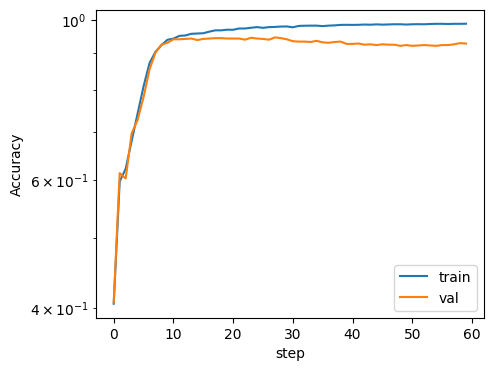

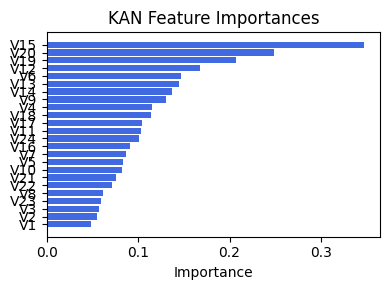

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V3', 0.49633927773751957), ('V2', 0.456840580497259), ('V11', 0.4279764045398527), ('V8', 0.40451642609309685), ('V4', 0.39506611851045703), ('V13', 0.38808078713878824), ('V12', 0.38289346230589877), ('V7', 0.3513801744889068), ('V17', 0.3232810477808889), ('V16', 0.32313250311762914), ('V6', 0.31772309246842756), ('V9', 0.3126131283571763), ('V18', 0.29708372339502315), ('V1', 0.2959727183901816), ('V19', 0.26006704603555475), ('V14', 0.23715445562337772), ('V21', 0.18328872293847076), ('V5', 0.17539161628369734), ('V10', 0.11866860100345437), ('V20', 0.1134066912752029), ('V24', 0.09700210691631589), ('V15', 0.08608674728905402), ('V22', 0.08242212858055273), ('V23', 0.08096904820140413), ('Ex1', 0.06465885438751767)]


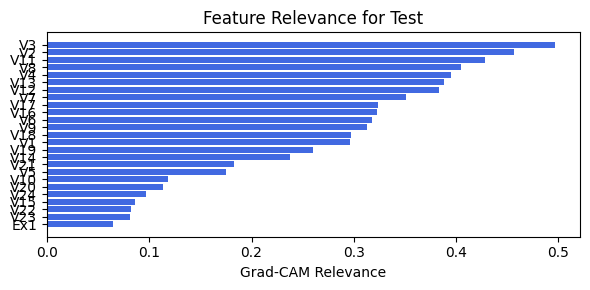

In [49]:
for cnn_bottleneck_dim in [1, 5, 8, 10, 15, 20]:
    print(f"cnn_bottleneck_dim: {cnn_bottleneck_dim}")
    train_and_plot_relevance(Model3_1, kan_neurons=11, kan_grid=3, lamb=0.001, steps=60, 
                             cnn_bottleneck_dim=cnn_bottleneck_dim, filename=filename_1, opt_col_val=cnn_bottleneck_dim)

## 1.3. width=[24, 7], grid=3, lamb=0.001

cnn_bottleneck_dim: 1
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


 train_acc_hybrid: 9.97e-01 | val_acc_hybrid: 9.16e-01 |: 100%|█████| 60/60 [00:21<00:00,  2.79it/s]


saving model version 0.1
✅ Best validation Accuracy: 9.2325e-01 at 13 epoch
tensor(0.9084, device='cuda:0')
[[401  34   5   1]
 [ 20 395   5   0]
 [  1   6  54   5]
 [  0   6  17 142]]
M_KAN Relevance: 0.9998133778572083
CNN Relevance: 0.0001866822422016412
[('V15', 0.27978188), ('V20', 0.25871387), ('V19', 0.20288809), ('V18', 0.17236114), ('V5', 0.16977203), ('V17', 0.14460877), ('V22', 0.13969588), ('V10', 0.13530096), ('V14', 0.12939063), ('V23', 0.1282509), ('V13', 0.1186073), ('V7', 0.114796504), ('V24', 0.113083586), ('V9', 0.11106227), ('V2', 0.10195452), ('V3', 0.096371375), ('V16', 0.09439241), ('V6', 0.09140662), ('V11', 0.088324584), ('V8', 0.08718092), ('V12', 0.085889764), ('V21', 0.072920024), ('V4', 0.067712925), ('V1', 0.046152826)]


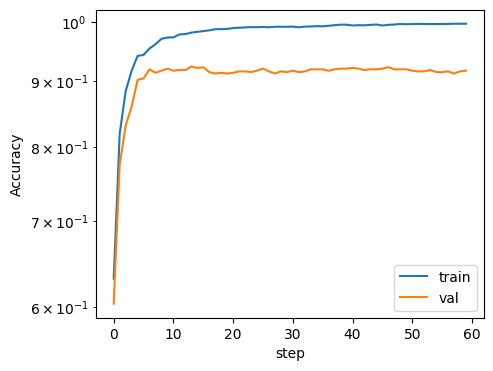

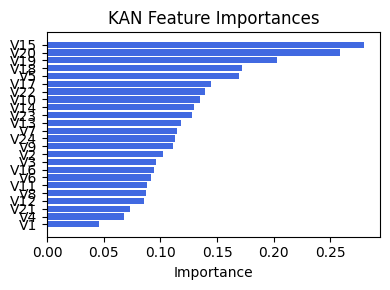

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V24', 0.28898206734810206), ('V19', 0.2735491440431667), ('V14', 0.261983965770657), ('V20', 0.26121965743821574), ('V13', 0.25540798652623764), ('V15', 0.2527700023859794), ('V23', 0.2500265839048802), ('V17', 0.2426670259674977), ('V18', 0.23661180986797237), ('V8', 0.23351645896900164), ('Ex1', 0.23278276901841402), ('V7', 0.22705528671474148), ('V9', 0.2236756254292448), ('V12', 0.22298924025226402), ('V22', 0.21912002275465908), ('V16', 0.21038911979542554), ('V10', 0.2035549202311693), ('V11', 0.18662206406663293), ('V6', 0.16706782288780805), ('V21', 0.1670551760987939), ('V3', 0.15933305224855063), ('V2', 0.1576003661285297), ('V4', 0.13724467673249813), ('V1', 0.12902786131121252), ('V5', 0.12545037201896458)]


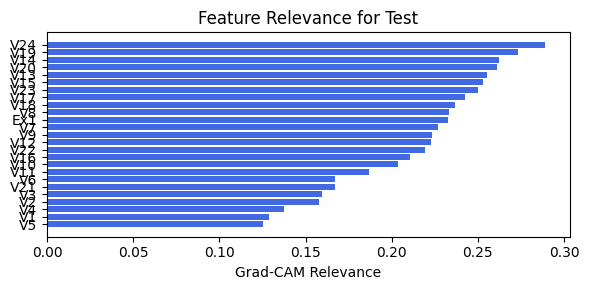

cnn_bottleneck_dim: 3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


 train_acc_hybrid: 9.93e-01 | val_acc_hybrid: 9.03e-01 |: 100%|█████| 60/60 [00:23<00:00,  2.59it/s]


saving model version 0.1
✅ Best validation Accuracy: 9.2669e-01 at 16 epoch
tensor(0.9194, device='cuda:0')
[[413  23   4   1]
 [ 20 391   8   1]
 [  0   6  60   0]
 [  1   3  21 140]]
M_KAN Relevance: 0.9698211550712585
CNN Relevance: 0.03017883002758026
[('V15', 0.33223513), ('V20', 0.23663309), ('V19', 0.21162923), ('V9', 0.18950705), ('V18', 0.1375896), ('V14', 0.12861116), ('V13', 0.124420375), ('V17', 0.120153844), ('V12', 0.119907156), ('V7', 0.1196871), ('V11', 0.10699805), ('V22', 0.086095385), ('V2', 0.07839905), ('V24', 0.07787754), ('V21', 0.06549963), ('V3', 0.06490964), ('V4', 0.06457192), ('V23', 0.063960634), ('V16', 0.061962456), ('V5', 0.061631985), ('V8', 0.06116203), ('V6', 0.06044815), ('V10', 0.053283207), ('V1', 0.04983333)]


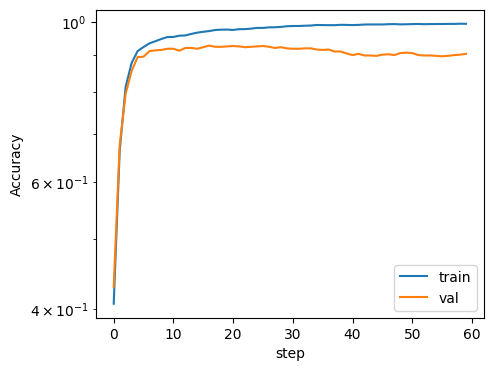

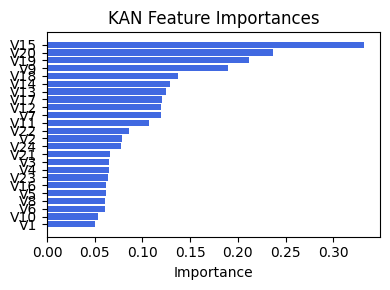

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V16', 0.4469944024667478), ('V21', 0.34009688195705096), ('V11', 0.30957445710672077), ('V4', 0.2565998148503522), ('V6', 0.21433571481926073), ('V5', 0.18703533105661163), ('V3', 0.18420999412166447), ('V2', 0.13163010565172095), ('V12', 0.11714301976041494), ('V8', 0.10086185361945024), ('V10', 0.0916616035782158), ('V7', 0.07707143239650034), ('V18', 0.07630493065756797), ('V9', 0.0654873191942964), ('V17', 0.06424778324933855), ('V13', 0.06355686663417999), ('V22', 0.04760480011263541), ('V14', 0.045142710452171), ('V1', 0.038311987200232406), ('V15', 0.03719671369412353), ('V20', 0.03474512894049623), ('V23', 0.02133817497476326), ('V24', 0.02092333434794811), ('V19', 0.020196992662375377), ('Ex1', 0.0018920638070155222)]


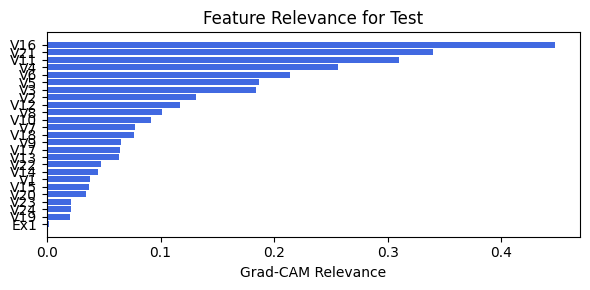

cnn_bottleneck_dim: 8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


 train_acc_hybrid: 9.89e-01 | val_acc_hybrid: 9.32e-01 |: 100%|█████| 60/60 [00:22<00:00,  2.66it/s]


saving model version 0.1
✅ Best validation Accuracy: 9.3814e-01 at 28 epoch
tensor(0.9231, device='cuda:0')
[[409  25   6   1]
 [ 11 402   6   1]
 [  1   6  57   2]
 [  0   6  19 140]]
M_KAN Relevance: 0.9483933448791504
CNN Relevance: 0.05160662159323692
[('V15', 0.31966794), ('V20', 0.25636634), ('V9', 0.2403509), ('V19', 0.18235125), ('V14', 0.16078468), ('V5', 0.14043957), ('V13', 0.13157816), ('V18', 0.11851084), ('V11', 0.117967404), ('V7', 0.1136492), ('V12', 0.108027324), ('V24', 0.102188505), ('V4', 0.081224866), ('V3', 0.068471044), ('V23', 0.06808831), ('V2', 0.067231216), ('V17', 0.064192), ('V16', 0.06373962), ('V6', 0.061444983), ('V22', 0.061439674), ('V10', 0.05644849), ('V21', 0.042292845), ('V8', 0.03537487), ('V1', 0.02897806)]


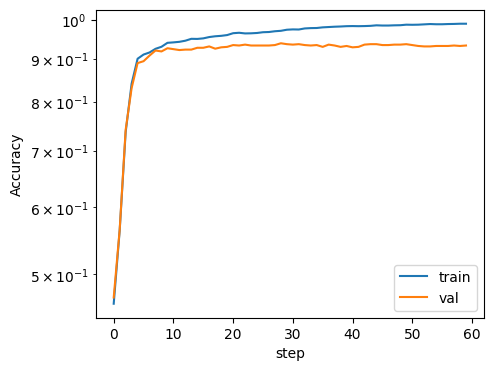

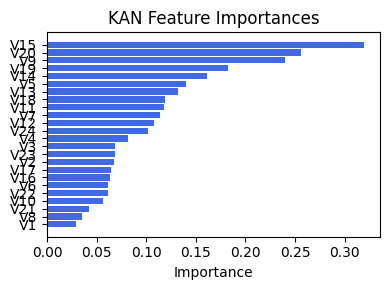

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V11', 0.6060519270789076), ('V16', 0.5481809989307007), ('V3', 0.46447784692100624), ('V2', 0.4159426355605259), ('V6', 0.39404066115738856), ('V12', 0.3556195883637894), ('V4', 0.3530242934648413), ('V21', 0.3518752946264423), ('V8', 0.3032185284416797), ('V1', 0.25783097362546625), ('V7', 0.25679320423320123), ('V13', 0.2462656558642672), ('V17', 0.23057677265668788), ('V18', 0.18379876881208007), ('V9', 0.15685289592156784), ('V14', 0.09880945165832433), ('V5', 0.08695900545736106), ('V19', 0.06433395871333096), ('V10', 0.05863569412784126), ('V22', 0.05275330591130014), ('V15', 0.024916896737352714), ('V20', 0.021670938794892916), ('V24', 0.0140434440070169), ('V23', 0.004152609261647021), ('Ex1', 0.003300732008598401)]


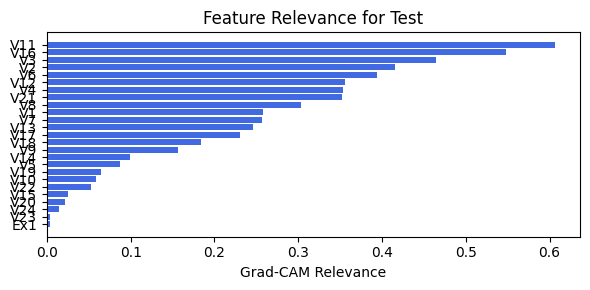

cnn_bottleneck_dim: 11
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


 train_acc_hybrid: 9.94e-01 | val_acc_hybrid: 8.89e-01 |: 100%|█████| 60/60 [00:21<00:00,  2.82it/s]


saving model version 0.1
✅ Best validation Accuracy: 9.0951e-01 at 14 epoch
tensor(0.9084, device='cuda:0')
[[412  24   3   2]
 [ 29 385   4   2]
 [  0   8  58   0]
 [  0   5  23 137]]
M_KAN Relevance: 0.9176547527313232
CNN Relevance: 0.08234522491693497
[('V15', 0.31418133), ('V19', 0.22258703), ('V20', 0.2127254), ('V9', 0.1761837), ('V12', 0.16527386), ('V13', 0.15533657), ('V17', 0.12941222), ('V5', 0.12348062), ('V22', 0.11688563), ('V11', 0.11589815), ('V18', 0.1082858), ('V14', 0.104844496), ('V6', 0.10452931), ('V3', 0.10264696), ('V7', 0.102015674), ('V8', 0.092360325), ('V10', 0.090679646), ('V16', 0.065237336), ('V2', 0.06476629), ('V4', 0.05918154), ('V23', 0.05740726), ('V24', 0.056972083), ('V21', 0.053000804), ('V1', 0.036978923)]


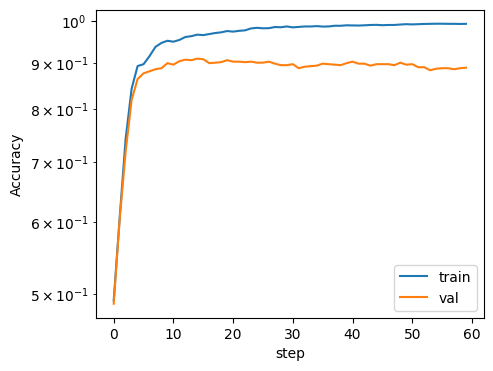

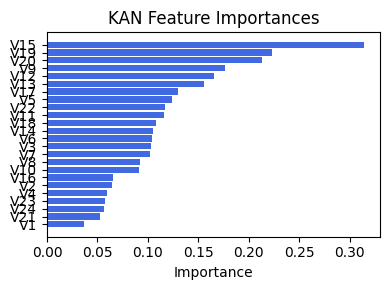

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V11', 0.2872578651934155), ('V1', 0.2291681128827894), ('V16', 0.22026193840940902), ('V6', 0.20723210238052478), ('V2', 0.19566825892503575), ('V21', 0.11938289373949121), ('Ex1', 0.11200432232947809), ('V3', 0.09756745977453345), ('V12', 0.04210039857829769), ('V7', 0.04091905982097872), ('V8', 0.03105103276305808), ('V4', 0.030926535216257343), ('V17', 0.017729771204101734), ('V9', 0.01340304136671972), ('V18', 0.007971958570363983), ('V24', 0.0067699352981208825), ('V14', 0.006124865202294601), ('V23', 0.005031087497241143), ('V20', 0.003961829889813888), ('V5', 0.003708966736194137), ('V10', 0.0031785648770026108), ('V22', 0.0029615294701575844), ('V15', 0.0023878761729218692), ('V19', 0.002317340836873885), ('V13', 0.0014847975200589665)]


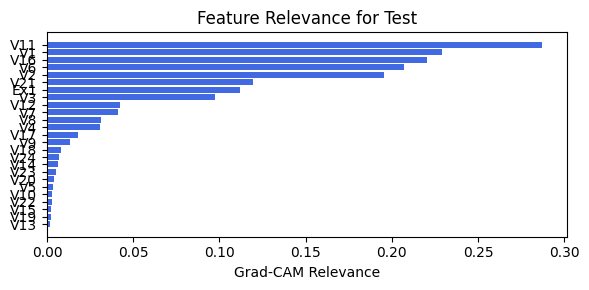

cnn_bottleneck_dim: 15
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


 train_acc_hybrid: 9.87e-01 | val_acc_hybrid: 8.92e-01 |: 100%|█████| 60/60 [00:22<00:00,  2.66it/s]


saving model version 0.1
✅ Best validation Accuracy: 9.0378e-01 at 20 epoch
tensor(0.8984, device='cuda:0')
[[402  32   5   2]
 [ 18 390  10   2]
 [  0  10  56   0]
 [  1   4  27 133]]
M_KAN Relevance: 0.912123441696167
CNN Relevance: 0.0878765881061554
[('V15', 0.28107595), ('V20', 0.21460709), ('V19', 0.19334085), ('V13', 0.17880416), ('V14', 0.15536876), ('V9', 0.1522398), ('V12', 0.13205405), ('V5', 0.123298496), ('V18', 0.119063444), ('V3', 0.11474419), ('V17', 0.10841436), ('V7', 0.10422267), ('V22', 0.102510996), ('V16', 0.08518809), ('V6', 0.0758386), ('V23', 0.06628535), ('V11', 0.06591138), ('V24', 0.05900865), ('V10', 0.056365475), ('V2', 0.055527907), ('V4', 0.05285881), ('V21', 0.052256495), ('V8', 0.044451542), ('V1', 0.040339116)]


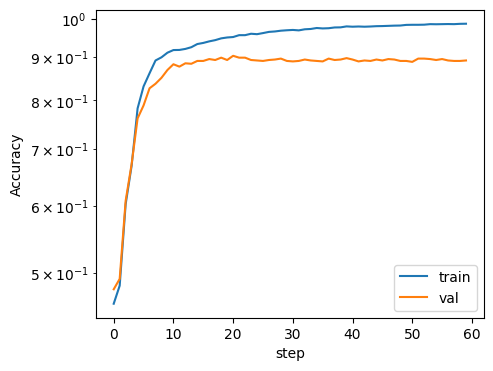

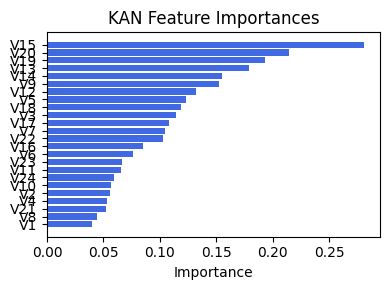

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V21', 0.45235304579748764), ('V2', 0.22833772441072975), ('V1', 0.21481004228119077), ('V11', 0.1696082443980101), ('V6', 0.1521791721817676), ('V4', 0.1443604835483498), ('V3', 0.13352803844024022), ('V16', 0.11695868457807079), ('V20', 0.10709751755253459), ('V15', 0.08351606901115892), ('V5', 0.08206119369019306), ('V10', 0.08186894721564139), ('V9', 0.07835843884473541), ('V8', 0.06969514218433641), ('V7', 0.06880610524541349), ('Ex1', 0.06176829327296385), ('V12', 0.05084838028425767), ('V17', 0.04402192095260481), ('V14', 0.03802714969676275), ('V18', 0.03669016614459086), ('V13', 0.036526793329174814), ('V19', 0.0361443693018706), ('V24', 0.026396353564787173), ('V22', 0.024831719862829362), ('V23', 0.014448857429563563)]


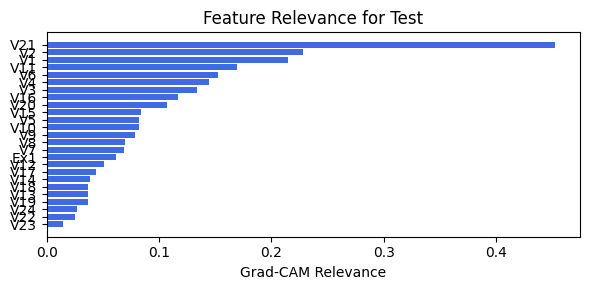

cnn_bottleneck_dim: 18
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


 train_acc_hybrid: 9.92e-01 | val_acc_hybrid: 9.26e-01 |: 100%|█████| 60/60 [00:23<00:00,  2.59it/s]


saving model version 0.1
✅ Best validation Accuracy: 9.3242e-01 at 17 epoch
tensor(0.9185, device='cuda:0')
[[417  20   3   1]
 [ 25 388   7   0]
 [  0   8  56   2]
 [  0   4  19 142]]
M_KAN Relevance: 0.9524320960044861
CNN Relevance: 0.04756789281964302
[('V20', 0.26839668), ('V15', 0.24656042), ('V19', 0.23733234), ('V18', 0.15429977), ('V9', 0.15204878), ('V3', 0.1413731), ('V14', 0.13536762), ('V17', 0.1203407), ('V13', 0.0997311), ('V5', 0.09763048), ('V12', 0.09582672), ('V2', 0.09552524), ('V10', 0.08363931), ('V22', 0.0802309), ('V16', 0.07533705), ('V6', 0.073226295), ('V23', 0.06697442), ('V24', 0.06661427), ('V7', 0.061411947), ('V11', 0.06096651), ('V21', 0.0482159), ('V4', 0.04733493), ('V8', 0.041082926), ('V1', 0.04038729)]


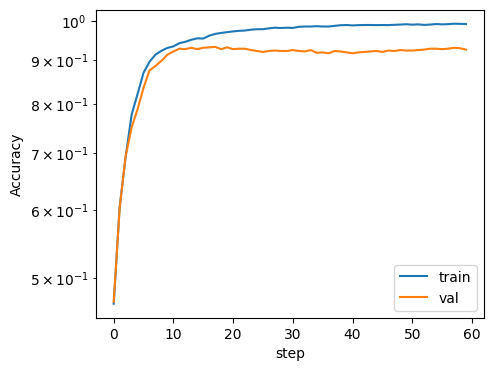

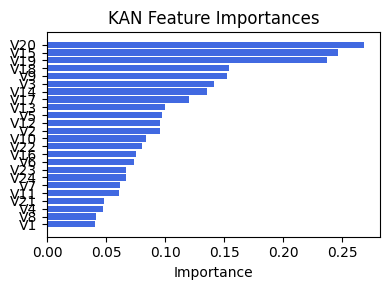

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V16', 0.5094368778601555), ('V11', 0.457665587875407), ('V6', 0.3620518353553039), ('V1', 0.19837228519392053), ('V19', 0.13550544473208911), ('V12', 0.13417172632437077), ('V7', 0.13414626848605574), ('V21', 0.1260777382253014), ('V17', 0.11122614064046728), ('V24', 0.10685202733362703), ('V18', 0.10089160249510527), ('V14', 0.09893454377980385), ('V13', 0.09375831736252245), ('V2', 0.09318009704894217), ('V23', 0.08660773188962144), ('V8', 0.08195244565885641), ('V3', 0.07280752954036723), ('V22', 0.07208006062068134), ('V9', 0.06843436975522485), ('Ex1', 0.06715495999702688), ('V20', 0.04459849768403522), ('V4', 0.04025348503673341), ('V15', 0.03553125510613123), ('V10', 0.024377218067600105), ('V5', 0.008430075503453666)]


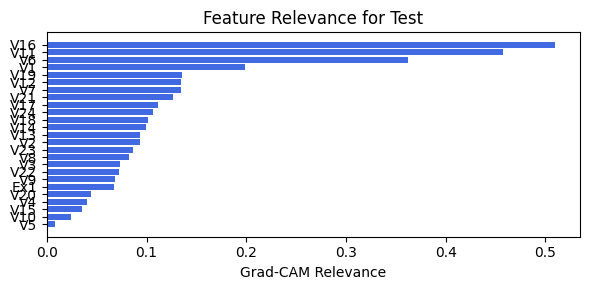

cnn_bottleneck_dim: 22
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


 train_acc_hybrid: 9.97e-01 | val_acc_hybrid: 9.18e-01 |: 100%|█████| 60/60 [00:22<00:00,  2.70it/s]


saving model version 0.1
✅ Best validation Accuracy: 9.3585e-01 at 11 epoch
tensor(0.9222, device='cuda:0')
[[409  28   3   1]
 [ 13 401   4   2]
 [  1   6  58   1]
 [  0   5  21 139]]
M_KAN Relevance: 0.9158639907836914
CNN Relevance: 0.08413603901863098
[('V15', 0.3246779), ('V20', 0.27760184), ('V19', 0.22404596), ('V18', 0.15915878), ('V9', 0.13746607), ('V2', 0.111521326), ('V14', 0.10883028), ('V12', 0.107098974), ('V17', 0.10622267), ('V3', 0.10031543), ('V13', 0.09727542), ('V11', 0.090055756), ('V16', 0.0889588), ('V7', 0.087791), ('V10', 0.08235132), ('V6', 0.07168608), ('V5', 0.07012787), ('V23', 0.06698644), ('V4', 0.063666895), ('V8', 0.06255964), ('V22', 0.060592946), ('V24', 0.05886919), ('V21', 0.043135848), ('V1', 0.033456504)]


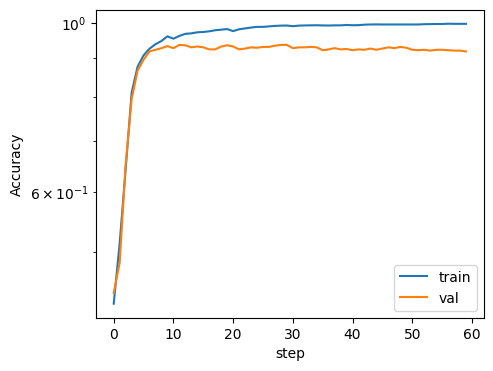

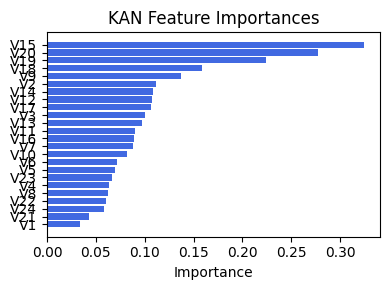

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V4', 0.42803137646066947), ('V2', 0.26586691016841324), ('V5', 0.2284420763190167), ('V3', 0.18690429717692134), ('V21', 0.14515061627785295), ('V10', 0.08216345552234051), ('V9', 0.06342442382844302), ('V1', 0.06133637956126165), ('V16', 0.05941735445473265), ('V15', 0.03231871400810753), ('V7', 0.032299807796191536), ('V6', 0.029554017558762382), ('V11', 0.027779449976664275), ('V12', 0.026391653673665347), ('V20', 0.023617666990979898), ('V14', 0.013372789463603992), ('V19', 0.012666134277380826), ('V8', 0.00876756953562191), ('V22', 0.006512504363298174), ('V17', 0.006247201309524026), ('V18', 0.005861771966743491), ('Ex1', 0.005309676218363938), ('V24', 0.003519717818735877), ('V13', 0.0025528309859963127), ('V23', 0.001969049744403515)]


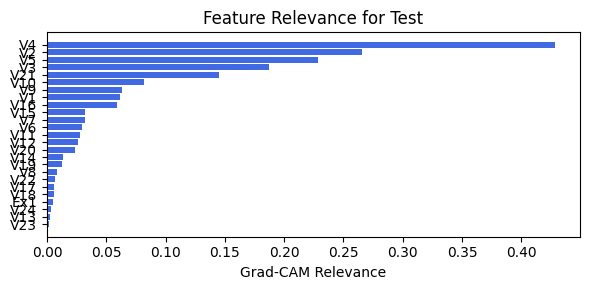

In [50]:
for cnn_bottleneck_dim in [1, 3, 8, 11, 15, 18, 22]:
    print(f"cnn_bottleneck_dim: {cnn_bottleneck_dim}")
    train_and_plot_relevance(Model3_1, kan_neurons=11, kan_grid=3, lamb=0.001, steps=60, 
                             cnn_bottleneck_dim=cnn_bottleneck_dim, filename=filename_1, opt_col_val=cnn_bottleneck_dim)

# Option 2: Multiply CNN output by factor

In [50]:
create_csv_with_header(filename_2, columns_opt2)

## 2.0. width=[24, 12], grid=8, lamb=0.001

alpha: 0.9
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


 train_acc_hybrid: 9.98e-01 | val_acc_hybrid: 9.22e-01 |: 100%|█████| 70/70 [03:18<00:00,  2.83s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.4502e-01 at 11 epoch
tensor(0.9377, device='cuda:0')
[[419  19   3   0]
 [  9 409   2   0]
 [  0   8  57   1]
 [  0   5  21 139]]
M_KAN Relevance: 0.6637383699417114
CNN Relevance: 0.33626165986061096
[('V19', 0.28001416), ('V20', 0.27949816), ('V15', 0.23874253), ('V18', 0.1801168), ('V4', 0.15434933), ('V12', 0.14065024), ('V10', 0.13100572), ('V14', 0.12387767), ('V13', 0.12063025), ('V21', 0.11152231), ('V11', 0.09799989), ('V16', 0.09695177), ('V17', 0.096350096), ('V6', 0.09630414), ('V22', 0.092786215), ('V5', 0.08194191), ('V24', 0.080549665), ('V7', 0.073387496), ('V9', 0.06870276), ('V2', 0.06550144), ('V8', 0.061289903), ('V3', 0.060070537), ('V1', 0.05645999), ('V23', 0.05177252)]


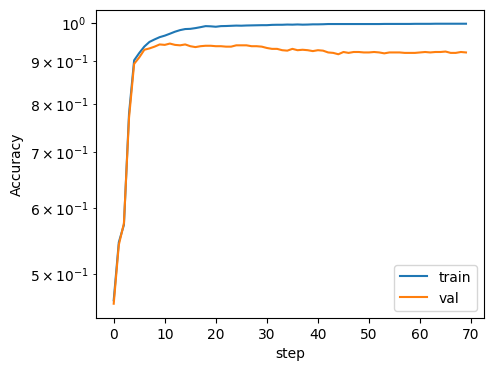

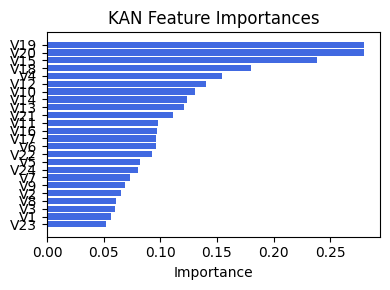

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('Ex1', 0.3368980069828647), ('V24', 0.3322082150397241), ('V23', 0.2692013227630487), ('V16', 0.24355051823974694), ('V6', 0.2318482635072718), ('V11', 0.2289224559565513), ('V22', 0.20450296981132038), ('V20', 0.18126152959348307), ('V15', 0.1803456994370368), ('V13', 0.17004651036719032), ('V12', 0.1537168653926645), ('V3', 0.1531811553766122), ('V1', 0.1464951054632089), ('V18', 0.13727178347508948), ('V10', 0.13343293863689368), ('V2', 0.12317261993867983), ('V8', 0.12242806658173072), ('V17', 0.12143268333701075), ('V7', 0.11101369060914014), ('V19', 0.10761277477442638), ('V5', 0.10122972636996472), ('V14', 0.09845054362565381), ('V4', 0.09440895904066525), ('V9', 0.07741163584523414), ('V21', 0.06793788470203763)]


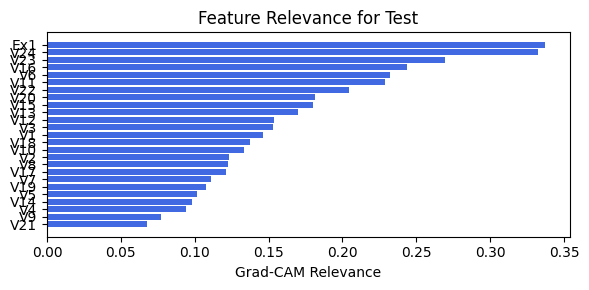

alpha: 0.75
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


 train_acc_hybrid: 9.98e-01 | val_acc_hybrid: 9.18e-01 |: 100%|█████| 70/70 [03:21<00:00,  2.88s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.3356e-01 at 11 epoch
tensor(0.9258, device='cuda:0')
[[405  33   2   1]
 [  7 405   6   2]
 [  0   7  56   3]
 [  0   2  18 145]]
M_KAN Relevance: 0.562879204750061
CNN Relevance: 0.4371207356452942
[('V19', 0.35403615), ('V20', 0.3243706), ('V15', 0.22381592), ('V4', 0.17078197), ('V18', 0.16552943), ('V13', 0.12456357), ('V14', 0.1158525), ('V12', 0.1126734), ('V10', 0.11190979), ('V24', 0.10554295), ('V9', 0.101075456), ('V22', 0.09533547), ('V16', 0.09383504), ('V17', 0.09072061), ('V7', 0.09058046), ('V11', 0.08212425), ('V21', 0.08191338), ('V6', 0.07862925), ('V3', 0.07711063), ('V5', 0.0729031), ('V2', 0.068528295), ('V1', 0.06653603), ('V8', 0.066085294), ('V23', 0.053355537)]


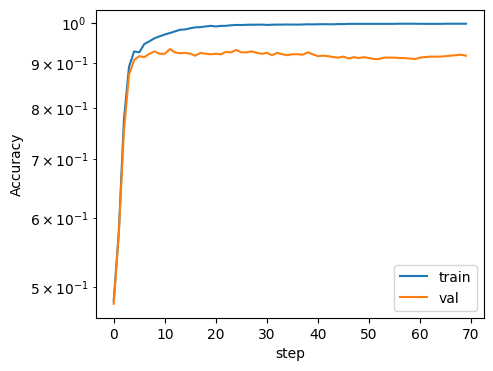

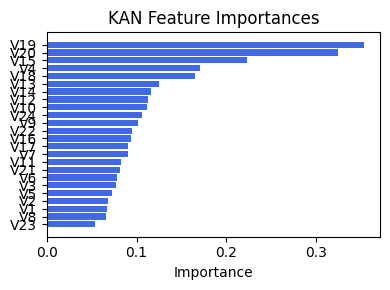

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V13', 0.5123598631931939), ('V18', 0.5060020155553115), ('V19', 0.4276480302779109), ('V8', 0.41192464378381816), ('V14', 0.4027623199444561), ('V20', 0.39600703124773107), ('V12', 0.38614919798848674), ('V17', 0.38578821850928646), ('V15', 0.38252054260398266), ('V9', 0.331959915255555), ('V7', 0.3243781576045996), ('V11', 0.31999535618964287), ('V16', 0.29282784633114683), ('V10', 0.270287459640936), ('Ex1', 0.2450551300893221), ('V6', 0.24063805516739079), ('V23', 0.23697595613139327), ('V24', 0.23313662356082912), ('V3', 0.2034371834603947), ('V22', 0.1917748675051494), ('V2', 0.1602938389554925), ('V4', 0.14968602303279346), ('V1', 0.1363489976013595), ('V21', 0.12003418648159839), ('V5', 0.08937475740894892)]


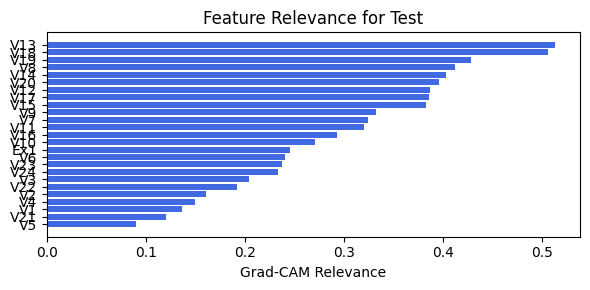

alpha: 0.5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


 train_acc_hybrid: 9.97e-01 | val_acc_hybrid: 9.29e-01 |: 100%|█████| 70/70 [03:15<00:00,  2.80s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.5074e-01 at 10 epoch
tensor(0.9304, device='cuda:0')
[[408  28   5   0]
 [  7 412   1   0]
 [  0   7  59   0]
 [  1   4  23 137]]
M_KAN Relevance: 0.6074246764183044
CNN Relevance: 0.39257535338401794
[('V15', 0.33081722), ('V19', 0.25833493), ('V20', 0.23119065), ('V14', 0.18045168), ('V12', 0.15984446), ('V18', 0.15820551), ('V4', 0.14480554), ('V13', 0.11408299), ('V22', 0.108358644), ('V16', 0.10413703), ('V24', 0.09213649), ('V17', 0.09026744), ('V5', 0.09009664), ('V2', 0.0895351), ('V10', 0.08534004), ('V9', 0.08389473), ('V21', 0.08329724), ('V7', 0.08240935), ('V8', 0.07337258), ('V11', 0.06600263), ('V23', 0.06524202), ('V3', 0.06451077), ('V6', 0.057920992), ('V1', 0.05732652)]


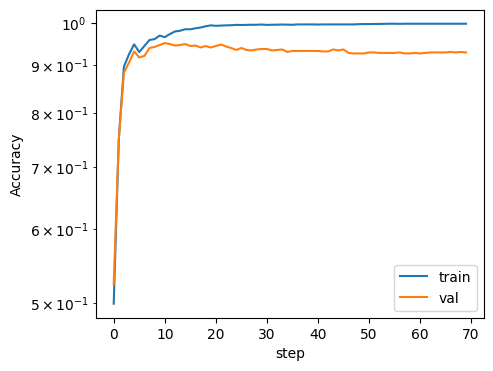

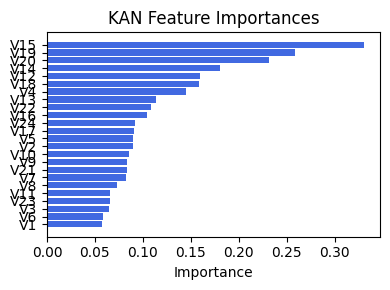

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V11', 0.2600083113084044), ('V24', 0.25933957798852236), ('V1', 0.2501579166054242), ('V16', 0.24995354998553165), ('V6', 0.2265176894110442), ('V23', 0.21942899109080993), ('V12', 0.21747804472797325), ('V13', 0.21449398704644143), ('V17', 0.20535030931111975), ('V18', 0.19894239827248544), ('V22', 0.1967948011009427), ('V3', 0.19306208352733578), ('V19', 0.19236894865143467), ('V7', 0.1846089819237522), ('V8', 0.18296032149605657), ('Ex1', 0.17924349586842203), ('V2', 0.17893002991542292), ('V14', 0.1510113643228282), ('V9', 0.13122136955833466), ('V4', 0.12399511651889682), ('V20', 0.09830855670063748), ('V21', 0.09461482026100242), ('V15', 0.08353346124971016), ('V10', 0.07423475559907551), ('V5', 0.06370921417187057)]


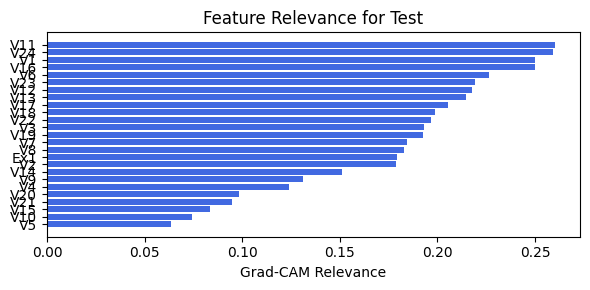

alpha: 0.25
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


 train_acc_hybrid: 9.98e-01 | val_acc_hybrid: 9.03e-01 |: 100%|█████| 70/70 [03:17<00:00,  2.82s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.3013e-01 at 13 epoch
tensor(0.9222, device='cuda:0')
[[411  26   3   1]
 [ 16 392  11   1]
 [  0   7  58   1]
 [  1   4  14 146]]
M_KAN Relevance: 0.652374267578125
CNN Relevance: 0.3476257920265198
[('V15', 0.40704197), ('V19', 0.22822706), ('V20', 0.18006188), ('V12', 0.15777518), ('V14', 0.15624742), ('V13', 0.1519479), ('V18', 0.1228386), ('V9', 0.11335206), ('V6', 0.11263033), ('V17', 0.09852186), ('V7', 0.0944083), ('V5', 0.09132479), ('V16', 0.08966577), ('V24', 0.088447206), ('V10', 0.08794358), ('V3', 0.08623691), ('V22', 0.08280881), ('V21', 0.0814237), ('V8', 0.07646426), ('V11', 0.07195687), ('V23', 0.057455968), ('V2', 0.056935452), ('V1', 0.04705771), ('V4', 0.046397448)]


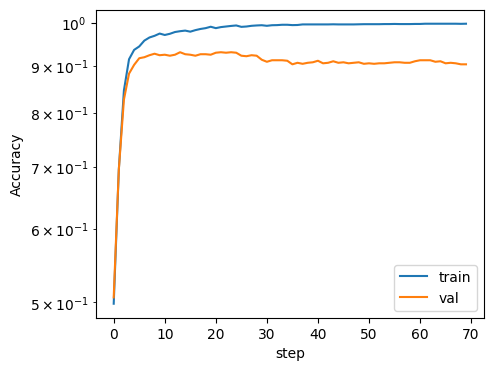

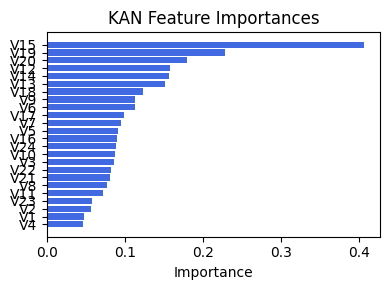

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V21', 0.26824156732797144), ('V17', 0.266906174893551), ('Ex1', 0.2554234980216837), ('V18', 0.24978038164763114), ('V13', 0.2449044478396653), ('V16', 0.24023208159571915), ('V24', 0.23888650235776268), ('V12', 0.23867172735300057), ('V23', 0.23710781960763488), ('V7', 0.21506489374691487), ('V11', 0.2137423626984159), ('V14', 0.2081596324481861), ('V22', 0.20475015903350854), ('V19', 0.20428658209814887), ('V8', 0.19043404979825543), ('V9', 0.17334063747558093), ('V20', 0.1728336827821648), ('V6', 0.166952428142941), ('V15', 0.16512876658377065), ('V3', 0.14840134941162336), ('V4', 0.14786407460009546), ('V2', 0.14510338035316825), ('V10', 0.12366748748252496), ('V1', 0.11075478487269294), ('V5', 0.09509690424558037)]


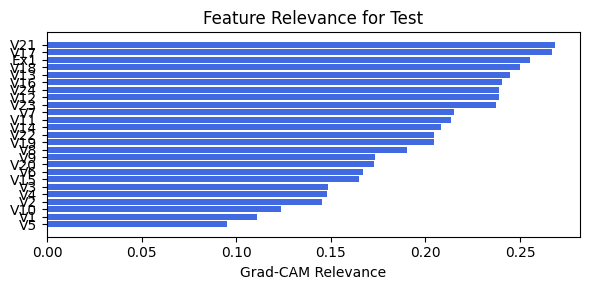

alpha: 0.1
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


 train_acc_hybrid: 9.97e-01 | val_acc_hybrid: 8.96e-01 |: 100%|█████| 70/70 [03:26<00:00,  2.95s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.1867e-01 at 17 epoch
tensor(0.9176, device='cuda:0')
[[402  36   2   1]
 [ 13 401   6   0]
 [  0   8  57   1]
 [  0   2  21 142]]
M_KAN Relevance: 0.6583799123764038
CNN Relevance: 0.3416200280189514
[('V15', 0.2847514), ('V19', 0.26217994), ('V20', 0.23810367), ('V18', 0.16836248), ('V14', 0.16407673), ('V16', 0.13384065), ('V22', 0.13014957), ('V12', 0.11516921), ('V13', 0.111593604), ('V10', 0.09528416), ('V4', 0.08798835), ('V5', 0.08769679), ('V11', 0.0859599), ('V24', 0.07594764), ('V6', 0.07542649), ('V7', 0.07226135), ('V2', 0.0720346), ('V21', 0.06956224), ('V3', 0.06944816), ('V17', 0.0669211), ('V9', 0.062542185), ('V1', 0.05586752), ('V8', 0.054274987), ('V23', 0.04877466)]


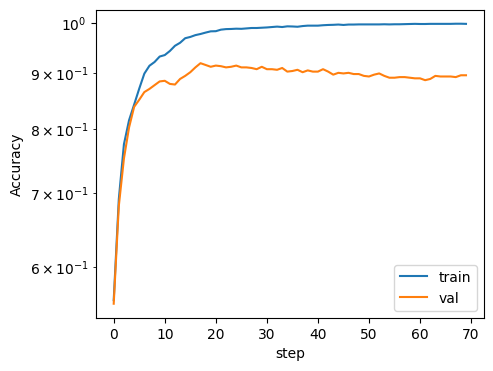

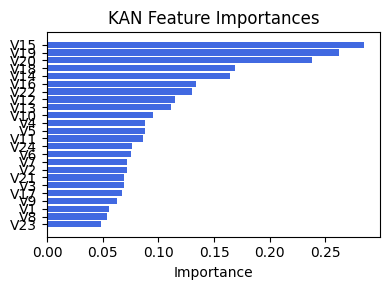

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V13', 0.4257060210995552), ('V18', 0.4184969936797556), ('V23', 0.39786640443816107), ('V19', 0.3800422700846716), ('V22', 0.37057594378730313), ('V24', 0.36541122829402123), ('V17', 0.35202984118108355), ('V12', 0.3421616143602008), ('V14', 0.33262311516480975), ('V8', 0.32413409612138994), ('V7', 0.28797561006780226), ('V9', 0.26978226812502976), ('V11', 0.22256729000242897), ('V20', 0.20462188270245124), ('V21', 0.20009038301701607), ('V16', 0.1961051888065879), ('V15', 0.18392549173972755), ('V6', 0.17728048139304273), ('V3', 0.1765944266142989), ('V10', 0.1591350598210495), ('Ex1', 0.15436663349919066), ('V4', 0.15276050309062605), ('V2', 0.15222619148544286), ('V1', 0.09739111425368296), ('V5', 0.0966008316512864)]


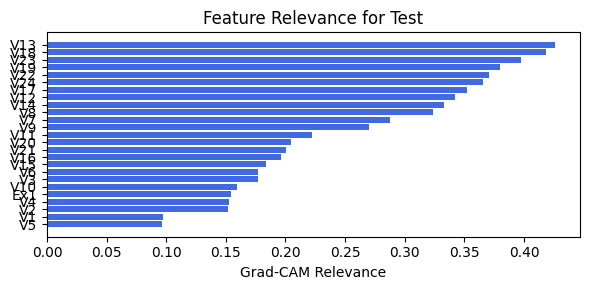

alpha: 0.05
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


 train_acc_hybrid: 9.97e-01 | val_acc_hybrid: 9.16e-01 |: 100%|█████| 70/70 [05:13<00:00,  4.48s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.2440e-01 at 27 epoch
tensor(0.9185, device='cuda:0')
[[411  28   1   1]
 [ 17 391  12   0]
 [  1   8  56   1]
 [  0   6  14 145]]
M_KAN Relevance: 0.673341691493988
CNN Relevance: 0.32665830850601196
[('V15', 0.37659216), ('V19', 0.34114966), ('V20', 0.3026716), ('V14', 0.15253957), ('V18', 0.14873788), ('V12', 0.13978355), ('V16', 0.1178772), ('V22', 0.11156043), ('V13', 0.11004766), ('V21', 0.09785092), ('V17', 0.09633567), ('V4', 0.09072881), ('V5', 0.089434594), ('V11', 0.08765714), ('V24', 0.085612774), ('V7', 0.08350517), ('V2', 0.07767458), ('V6', 0.07534857), ('V9', 0.07518084), ('V23', 0.07353811), ('V1', 0.07352538), ('V8', 0.07059212), ('V3', 0.06826334), ('V10', 0.05904811)]


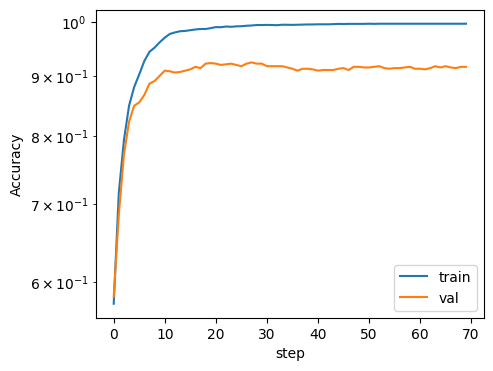

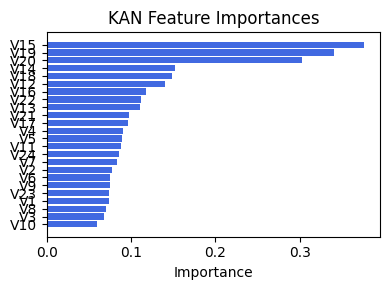

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V23', 0.29893530792258843), ('V22', 0.29288254071748987), ('V24', 0.28537927977768485), ('V17', 0.2828677579314106), ('V18', 0.28124789424515295), ('V19', 0.2768395958116407), ('V13', 0.2578905509418514), ('V8', 0.24896818890569786), ('V7', 0.2377971461856283), ('V12', 0.23654773625039457), ('V14', 0.23367598355191696), ('V3', 0.22117316314675325), ('V9', 0.20786825063144104), ('V16', 0.1976981050230502), ('V20', 0.19205317032569988), ('V11', 0.1839260516322884), ('V2', 0.1820339047934205), ('V6', 0.17818457622500888), ('V15', 0.17755932854661197), ('V4', 0.1726692030912597), ('V21', 0.16609289655742285), ('V10', 0.16549329015412692), ('V1', 0.1415707851354175), ('V5', 0.1404427548773878), ('Ex1', 0.1322262163817075)]


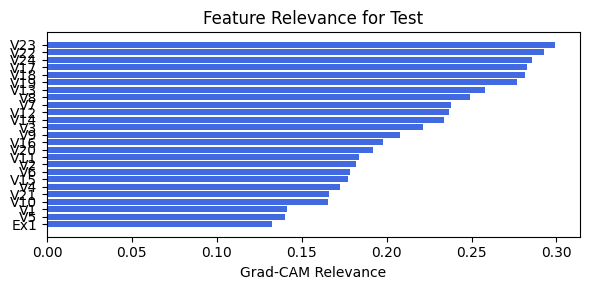

alpha: 0.01
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


 train_acc_hybrid: 9.99e-01 | val_acc_hybrid: 9.04e-01 |: 100%|█████| 70/70 [03:15<00:00,  2.80s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.1409e-01 at 15 epoch
tensor(0.8984, device='cuda:0')
[[405  33   2   1]
 [ 24 379  17   0]
 [  0   8  55   3]
 [  0   4  19 142]]
M_KAN Relevance: 0.5625416040420532
CNN Relevance: 0.4374583959579468
[('V15', 0.3683601), ('V19', 0.30705696), ('V20', 0.3051114), ('V14', 0.17218916), ('V22', 0.13477783), ('V12', 0.12985656), ('V18', 0.12207826), ('V21', 0.10744312), ('V7', 0.103794605), ('V13', 0.09961115), ('V16', 0.097234234), ('V3', 0.091143355), ('V11', 0.08830744), ('V4', 0.08287751), ('V10', 0.073822364), ('V17', 0.07068466), ('V6', 0.06918135), ('V8', 0.06439484), ('V9', 0.06397207), ('V2', 0.061769664), ('V24', 0.06027278), ('V5', 0.060105395), ('V23', 0.06007419), ('V1', 0.048244413)]


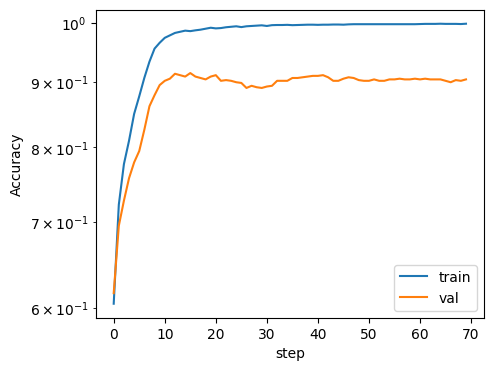

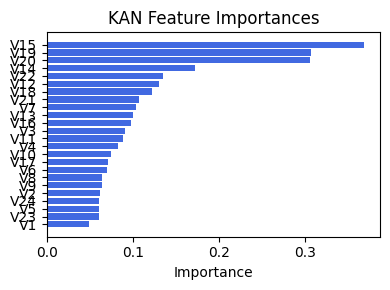

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V13', 0.3394215933737838), ('V18', 0.31462575086766015), ('V23', 0.30807205367172186), ('V22', 0.30186123929054504), ('V17', 0.29973015641732936), ('V12', 0.29853498501466047), ('V24', 0.29303832935499985), ('V8', 0.289664384284148), ('V19', 0.2777662335636159), ('V14', 0.2697276344268895), ('V7', 0.25975933028034837), ('V9', 0.23186869770657328), ('V16', 0.2255992336270008), ('V21', 0.2146837296468187), ('V11', 0.19348396708755566), ('V6', 0.1887948651540719), ('V20', 0.18142038536088642), ('V3', 0.17374906973602444), ('Ex1', 0.1605106669690347), ('V15', 0.15297317391548446), ('V2', 0.141370577083759), ('V4', 0.1403395753195149), ('V10', 0.13604555785449796), ('V1', 0.10231787834534158), ('V5', 0.10145353351682777)]


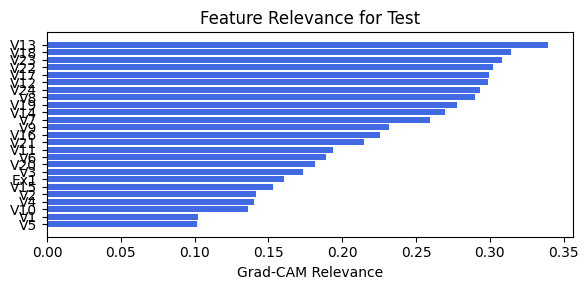

In [51]:
for alpha in [0.9, .75, .5, .25, .1, .05, .01]:
    print(f"alpha: {alpha}")
    train_and_plot_relevance(Model3_2, kan_neurons=12, kan_grid=8, lamb=0.001, steps=70, 
                             alpha=alpha, filename=filename_2, opt_col_val=alpha)

## 2.1 width=[24, 6], grid=7, lamb=1e-05

alpha: 0.9
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


 train_acc_hybrid: 9.99e-01 | val_acc_hybrid: 8.24e-01 |: 100%|█████| 70/70 [03:07<00:00,  2.68s/it]


saving model version 0.1
✅ Best validation Accuracy: 8.8774e-01 at 15 epoch
tensor(0.8764, device='cuda:0')
[[398  38   5   0]
 [ 23 380  16   1]
 [  0  10  55   1]
 [  0   5  36 124]]
M_KAN Relevance: 0.16292931139469147
CNN Relevance: 0.837070643901825
[('V19', 0.28493214), ('V20', 0.26998496), ('V15', 0.25209463), ('V11', 0.24147642), ('V16', 0.1699695), ('V22', 0.15654823), ('V17', 0.1501246), ('V18', 0.13817418), ('V10', 0.1262424), ('V9', 0.11735862), ('V13', 0.10395086), ('V2', 0.103932306), ('V4', 0.10295865), ('V12', 0.10215105), ('V8', 0.096209824), ('V3', 0.09024465), ('V5', 0.085570544), ('V7', 0.08326244), ('V24', 0.081689306), ('V6', 0.0770362), ('V1', 0.06821364), ('V23', 0.067468524), ('V14', 0.06059961), ('V21', 0.057846885)]


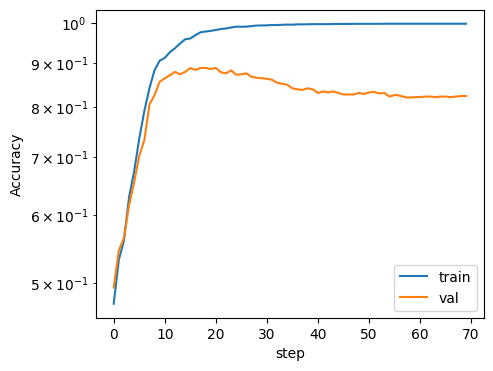

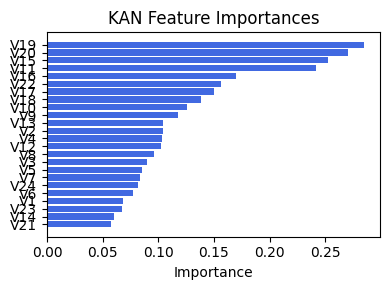

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V13', 0.3768118083373185), ('V11', 0.337659493320167), ('V16', 0.32984088758499913), ('V12', 0.31979502686393196), ('V6', 0.3135088336787906), ('V8', 0.30324848945829985), ('V18', 0.28444173998575223), ('V7', 0.2768687801215978), ('V3', 0.2763084556416808), ('V2', 0.24785423211997712), ('V17', 0.24765911810455082), ('V4', 0.2429644161573565), ('Ex1', 0.22110215606613104), ('V9', 0.2051768714848619), ('V1', 0.2002929626848257), ('V19', 0.19180252768737674), ('V14', 0.18144111407861233), ('V24', 0.16952511564449574), ('V20', 0.16313029584130945), ('V5', 0.14911321727377472), ('V15', 0.14540050570996335), ('V23', 0.14447925049224622), ('V10', 0.1354362460278602), ('V22', 0.11691656036850623), ('V21', 0.08711850219061579)]


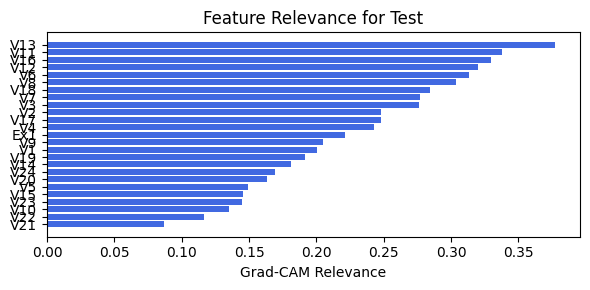

alpha: 0.75
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


 train_acc_hybrid: 9.99e-01 | val_acc_hybrid: 7.90e-01 |: 100%|█████| 70/70 [03:03<00:00,  2.62s/it]


saving model version 0.1
✅ Best validation Accuracy: 8.5223e-01 at 19 epoch
tensor(0.8187, device='cuda:0')
[[378  58   5   0]
 [ 46 338  36   0]
 [  1  12  51   2]
 [  2   4  32 127]]
M_KAN Relevance: 0.1407710462808609
CNN Relevance: 0.8592289686203003
[('V19', 0.3592635), ('V20', 0.31377164), ('V15', 0.26014978), ('V18', 0.16072133), ('V2', 0.15500192), ('V11', 0.14736633), ('V22', 0.1357677), ('V17', 0.13401335), ('V16', 0.1301617), ('V9', 0.12014647), ('V14', 0.11995147), ('V13', 0.11414584), ('V23', 0.11300897), ('V10', 0.102585554), ('V3', 0.09803203), ('V12', 0.093641564), ('V24', 0.09195769), ('V4', 0.09121861), ('V21', 0.09064826), ('V5', 0.08514178), ('V7', 0.0795901), ('V8', 0.073718205), ('V6', 0.06702567), ('V1', 0.04947224)]


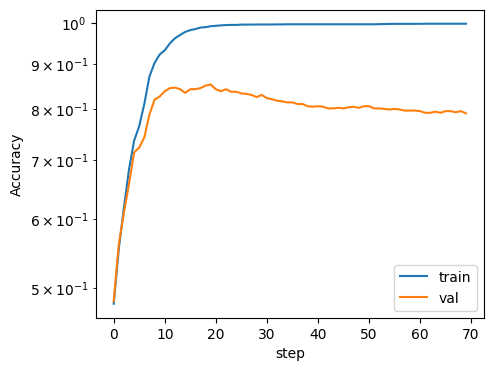

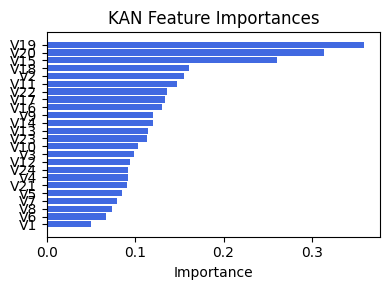

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V9', 0.2665240256863219), ('V14', 0.255346110747635), ('V8', 0.25354146174243236), ('V18', 0.24969333772259278), ('V19', 0.24495915489035894), ('V20', 0.2440985984206839), ('V17', 0.24008825536229478), ('V13', 0.231921247589349), ('V15', 0.2308749571940887), ('V4', 0.22293768866853203), ('V3', 0.21580379229492994), ('V12', 0.21337985513977462), ('V10', 0.20695655423731382), ('V2', 0.2052704154997321), ('V7', 0.2037082392027661), ('V24', 0.1910581453476803), ('V16', 0.1751586081974739), ('V23', 0.16801037296079566), ('Ex1', 0.1551501028689184), ('V11', 0.14946777782717), ('V22', 0.1472479576894083), ('V5', 0.14229744433444236), ('V6', 0.13740963345494175), ('V21', 0.13658752401123564), ('V1', 0.1284051952906082)]


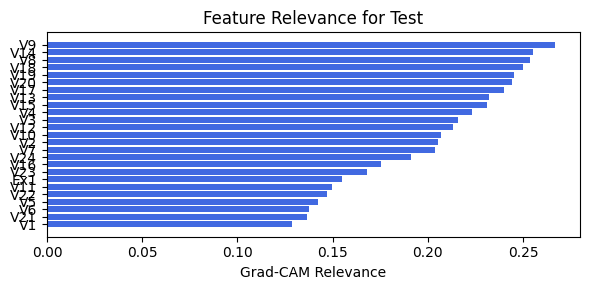

alpha: 0.5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


 train_acc_hybrid: 9.99e-01 | val_acc_hybrid: 8.26e-01 |: 100%|█████| 70/70 [03:06<00:00,  2.67s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.0836e-01 at 11 epoch
tensor(0.8800, device='cuda:0')
[[400  37   4   0]
 [ 28 370  21   1]
 [  1   8  57   0]
 [  0   7  24 134]]
M_KAN Relevance: 0.19624371826648712
CNN Relevance: 0.8037562966346741
[('V19', 0.3091674), ('V15', 0.30913854), ('V20', 0.30007464), ('V14', 0.16589361), ('V2', 0.1496727), ('V11', 0.13724825), ('V17', 0.12911585), ('V13', 0.12728766), ('V18', 0.12724355), ('V12', 0.12084317), ('V8', 0.10934946), ('V22', 0.10382305), ('V4', 0.101857856), ('V9', 0.0981459), ('V10', 0.08662301), ('V24', 0.08520351), ('V16', 0.082683206), ('V6', 0.079067394), ('V3', 0.061556548), ('V7', 0.056836437), ('V21', 0.054891404), ('V23', 0.0538451), ('V5', 0.050891258), ('V1', 0.04052914)]


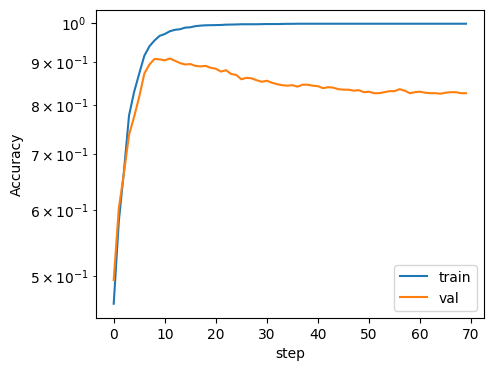

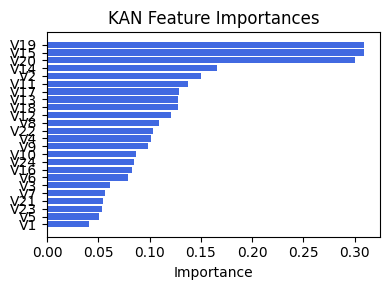

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V12', 0.3042997780359436), ('V13', 0.298224479343824), ('V14', 0.27828255889055853), ('V16', 0.2777346680694801), ('V8', 0.2773215955801009), ('V17', 0.27204203454615766), ('V18', 0.27096993283880577), ('V11', 0.26889368092851174), ('V7', 0.26475588980148657), ('V19', 0.26072750430091046), ('V6', 0.25423175315312946), ('V24', 0.24849423541939394), ('V9', 0.23053323951118174), ('V23', 0.22338524014197994), ('V2', 0.2213734485813159), ('V22', 0.2147988958082291), ('V3', 0.20858869775534852), ('V1', 0.17931593599944826), ('V4', 0.17620391951900924), ('V20', 0.15278680292296498), ('V21', 0.1466420726459806), ('V15', 0.13534973344236284), ('Ex1', 0.1298501534328362), ('V10', 0.1176292926340779), ('V5', 0.08611897828992675)]


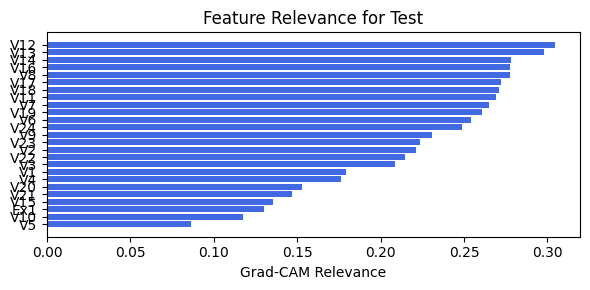

alpha: 0.25
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


 train_acc_hybrid: 9.99e-01 | val_acc_hybrid: 7.75e-01 |: 100%|█████| 70/70 [02:57<00:00,  2.54s/it]


saving model version 0.1
✅ Best validation Accuracy: 8.5338e-01 at 8 epoch
tensor(0.8333, device='cuda:0')
[[377  61   2   1]
 [ 37 352  31   0]
 [  1   8  57   0]
 [  1   7  33 124]]
M_KAN Relevance: 0.1363282948732376
CNN Relevance: 0.8636717200279236
[('V19', 0.25612086), ('V15', 0.24387376), ('V20', 0.2240014), ('V14', 0.20709649), ('V9', 0.18030578), ('V3', 0.17231146), ('V5', 0.1594117), ('V18', 0.11975368), ('V22', 0.11860701), ('V11', 0.11806817), ('V8', 0.117793344), ('V12', 0.115097426), ('V17', 0.112150244), ('V16', 0.112094), ('V13', 0.110256605), ('V4', 0.1101506), ('V6', 0.10927962), ('V2', 0.107060194), ('V10', 0.1059429), ('V24', 0.100794524), ('V7', 0.08966302), ('V21', 0.06211127), ('V23', 0.057462864), ('V1', 0.04917942)]


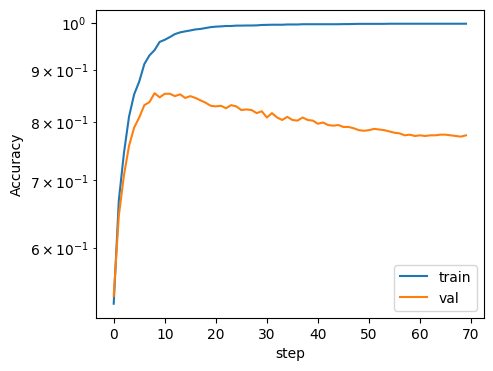

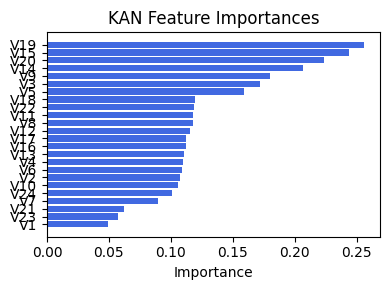

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V9', 0.28946871443710465), ('V8', 0.2889393135018452), ('V13', 0.2707784972740478), ('V3', 0.2592688869174978), ('V4', 0.24352319241313122), ('V14', 0.2385363991895943), ('V12', 0.23674263854363645), ('V7', 0.23296725149993486), ('V17', 0.23259416100837293), ('V2', 0.23027604061372675), ('V18', 0.21841344674524676), ('V16', 0.20835487641130926), ('V19', 0.20601384240523654), ('V20', 0.20038293862089365), ('V11', 0.19365628174699728), ('V21', 0.1934575721431459), ('V15', 0.177381526010252), ('V10', 0.16921783660031256), ('V5', 0.15707314754643567), ('V6', 0.15065476069851155), ('Ex1', 0.14195594210765533), ('V1', 0.11212990425221986), ('V24', 0.11156210667182417), ('V22', 0.0975381538260497), ('V23', 0.0890686433224504)]


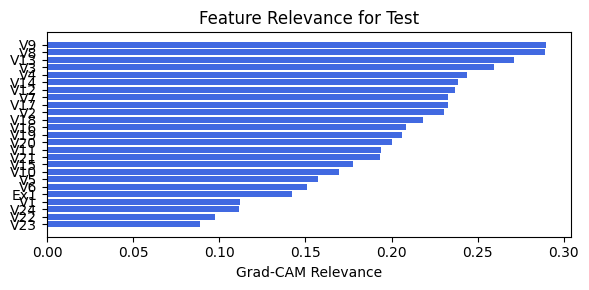

alpha: 0.1
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


 train_acc_hybrid: 9.97e-01 | val_acc_hybrid: 7.40e-01 |: 100%|█████| 70/70 [03:02<00:00,  2.60s/it]


saving model version 0.1
✅ Best validation Accuracy: 8.2703e-01 at 9 epoch
tensor(0.7930, device='cuda:0')
[[361  72   7   1]
 [ 44 337  38   1]
 [  0  10  52   4]
 [  1   7  41 116]]
M_KAN Relevance: 0.13050055503845215
CNN Relevance: 0.8694994449615479
[('V15', 0.32252115), ('V10', 0.17531137), ('V14', 0.17192557), ('V3', 0.17012584), ('V20', 0.16984004), ('V19', 0.16742885), ('V9', 0.15954404), ('V6', 0.14995873), ('V12', 0.12725338), ('V17', 0.11937216), ('V13', 0.11506304), ('V7', 0.10849638), ('V5', 0.108151875), ('V2', 0.095678434), ('V23', 0.09392067), ('V22', 0.08277945), ('V18', 0.07929501), ('V11', 0.07710625), ('V4', 0.076429345), ('V24', 0.07030514), ('V16', 0.06941958), ('V21', 0.06908213), ('V1', 0.055632334), ('V8', 0.052294686)]


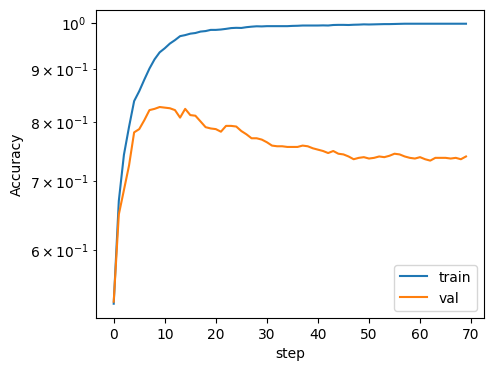

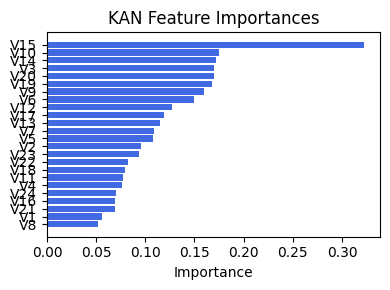

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V13', 0.36124748087433955), ('V8', 0.3314904218709688), ('V12', 0.32919428691812946), ('V7', 0.2895318646885407), ('V17', 0.28627607895727886), ('V19', 0.2847677956754094), ('V9', 0.28323347366767515), ('V14', 0.2829000752499402), ('V18', 0.2778697265229988), ('V2', 0.2530273671021486), ('V3', 0.2378974228681211), ('V4', 0.2318616687028495), ('V24', 0.21652158272003622), ('V11', 0.2107159568893908), ('V16', 0.20928978513797913), ('V20', 0.20770235861304698), ('V15', 0.20464992304073765), ('V6', 0.20309835209712923), ('V22', 0.19330923451420176), ('V23', 0.18217249312957165), ('Ex1', 0.1757980687178353), ('V10', 0.16832246652010435), ('V1', 0.1482337694388185), ('V5', 0.14306457052133315), ('V21', 0.12127589708602284)]


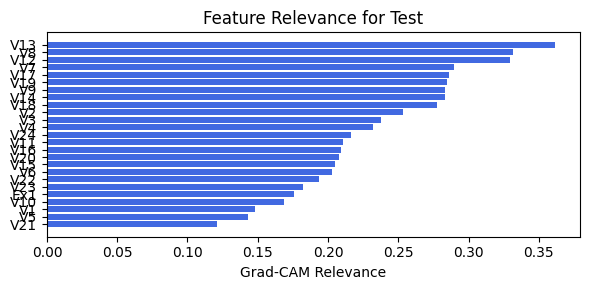

alpha: 0.05
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


 train_acc_hybrid: 9.98e-01 | val_acc_hybrid: 7.58e-01 |: 100%|█████| 70/70 [02:59<00:00,  2.56s/it]


saving model version 0.1
✅ Best validation Accuracy: 8.3734e-01 at 11 epoch
tensor(0.8159, device='cuda:0')
[[361  72   8   0]
 [ 29 355  35   1]
 [  1   9  54   2]
 [  0   9  35 121]]
M_KAN Relevance: 0.11164302378892899
CNN Relevance: 0.8883569240570068
[('V15', 0.28776345), ('V19', 0.19472222), ('V20', 0.17902964), ('V9', 0.16368), ('V14', 0.14116606), ('V17', 0.14066589), ('V13', 0.13247292), ('V12', 0.1250224), ('V18', 0.12288335), ('V10', 0.12163534), ('V3', 0.11834271), ('V6', 0.11686375), ('V5', 0.11424482), ('V11', 0.10795064), ('V23', 0.102874756), ('V7', 0.10244336), ('V22', 0.093974285), ('V16', 0.08632853), ('V4', 0.0716954), ('V24', 0.06033456), ('V2', 0.059316374), ('V21', 0.055753447), ('V1', 0.051064055), ('V8', 0.033828773)]


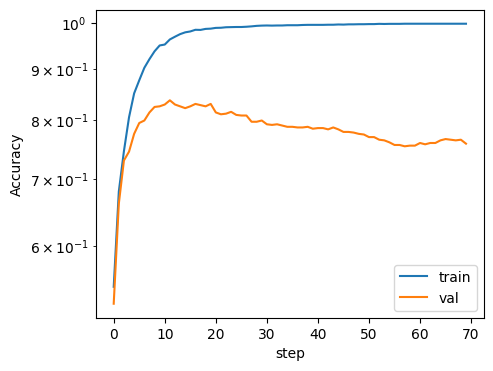

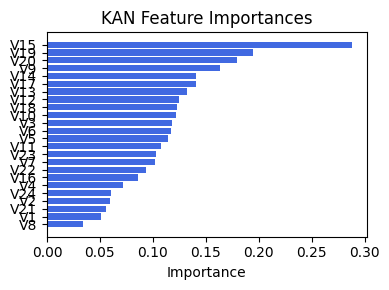

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V12', 0.23960727659559847), ('V7', 0.23237640311042376), ('V17', 0.22841318210655348), ('V8', 0.21538973520500304), ('V13', 0.21243172704332572), ('V16', 0.2020218801736009), ('V9', 0.19953236247918527), ('V2', 0.19291964018064212), ('V18', 0.1922840428182125), ('V14', 0.18788964962644328), ('V3', 0.18424964012388795), ('V11', 0.17786731449379972), ('V21', 0.17593896970631095), ('V4', 0.17493196408852718), ('V1', 0.16507959422873958), ('V19', 0.16149390023566834), ('V6', 0.1513950057921444), ('V20', 0.1497167959697925), ('V5', 0.1475967213132091), ('V22', 0.11957437549541289), ('V15', 0.1181955957022899), ('V10', 0.11780958639078579), ('Ex1', 0.11734643064372348), ('V24', 0.09893839591686862), ('V23', 0.09245201912272556)]


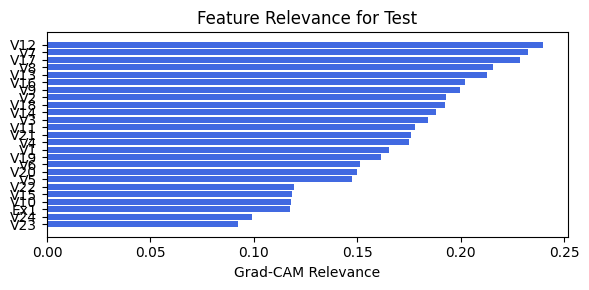

alpha: 0.01
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


 train_acc_hybrid: 9.99e-01 | val_acc_hybrid: 7.64e-01 |: 100%|█████| 70/70 [03:06<00:00,  2.66s/it]


saving model version 0.1
✅ Best validation Accuracy: 8.3963e-01 at 6 epoch
tensor(0.8196, device='cuda:0')
[[371  63   6   1]
 [ 27 359  34   0]
 [  0  10  54   2]
 [  0   6  48 111]]
M_KAN Relevance: 0.14035043120384216
CNN Relevance: 0.8596495985984802
[('V20', 0.22019923), ('V15', 0.21759337), ('V19', 0.21536952), ('V14', 0.1730851), ('V13', 0.14930488), ('V9', 0.14076091), ('V3', 0.13266523), ('V18', 0.12982813), ('V17', 0.12015518), ('V22', 0.11832793), ('V6', 0.113874786), ('V10', 0.11303413), ('V11', 0.10058464), ('V12', 0.10032632), ('V16', 0.09244029), ('V23', 0.0841639), ('V7', 0.08398124), ('V4', 0.07890619), ('V8', 0.07789659), ('V2', 0.07478426), ('V21', 0.069234364), ('V5', 0.068467304), ('V24', 0.058556434), ('V1', 0.04767589)]


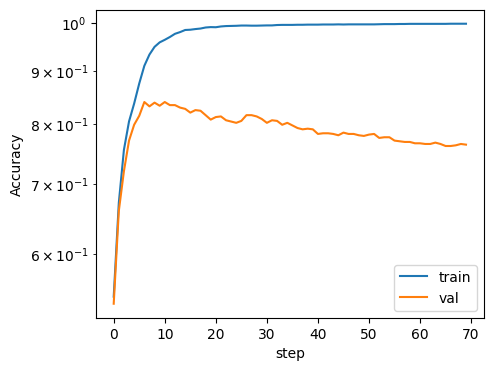

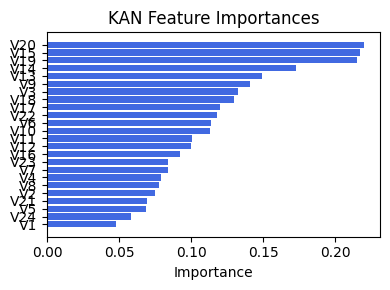

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V24', 0.2904810920336276), ('V22', 0.2780525130026798), ('V23', 0.2686767379786127), ('V14', 0.239378760029847), ('V9', 0.2319322022259314), ('V15', 0.22368188917911766), ('V20', 0.21969163881665124), ('V4', 0.20977823544317523), ('V19', 0.20803099490887436), ('V21', 0.20563567095839824), ('V8', 0.20067103990761312), ('V13', 0.1977768851462888), ('V10', 0.19770776243387692), ('Ex1', 0.1843835608712195), ('V12', 0.18426639640236003), ('V3', 0.18333869926301394), ('V2', 0.18304267318000125), ('V7', 0.17730592493621988), ('V18', 0.1736675872037937), ('V17', 0.16448252780167125), ('V5', 0.15091076964082334), ('V16', 0.134502755739266), ('V1', 0.1068526376594581), ('V11', 0.09774822610158677), ('V6', 0.09034634358417512)]


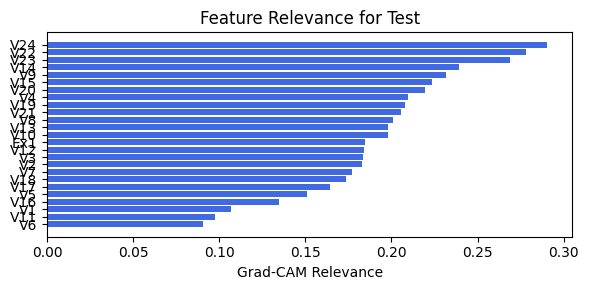

In [52]:
for alpha in [0.9, .75, .5, .25, .1, .05, .01]:
    print(f"alpha: {alpha}")
    train_and_plot_relevance(Model3_2, kan_neurons=6, kan_grid=7, lamb=1e-05, steps=70, 
                             alpha=alpha, filename=filename_2, opt_col_val=alpha)

## 2.2. width=[24, 11], grid=3, lamb=0.001

alpha: 0.9
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


 train_acc_hybrid: 9.97e-01 | val_acc_hybrid: 9.06e-01 |: 100%|█████| 70/70 [03:22<00:00,  2.89s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.3471e-01 at 16 epoch
tensor(0.9267, device='cuda:0')
[[413  24   3   1]
 [ 20 393   7   0]
 [  1   5  58   2]
 [  0   5  12 148]]
M_KAN Relevance: 0.7025251388549805
CNN Relevance: 0.29747477173805237
[('V20', 0.3205084), ('V19', 0.26498398), ('V15', 0.23157656), ('V14', 0.15779199), ('V9', 0.15200052), ('V10', 0.14895263), ('V12', 0.14719988), ('V18', 0.14365269), ('V16', 0.14097072), ('V5', 0.13254604), ('V11', 0.120845295), ('V4', 0.11199398), ('V17', 0.10640889), ('V22', 0.10549038), ('V24', 0.09710177), ('V23', 0.096652575), ('V3', 0.09626936), ('V13', 0.08975523), ('V2', 0.088106714), ('V21', 0.08566741), ('V8', 0.08521875), ('V7', 0.08472528), ('V1', 0.08264295), ('V6', 0.07362476)]


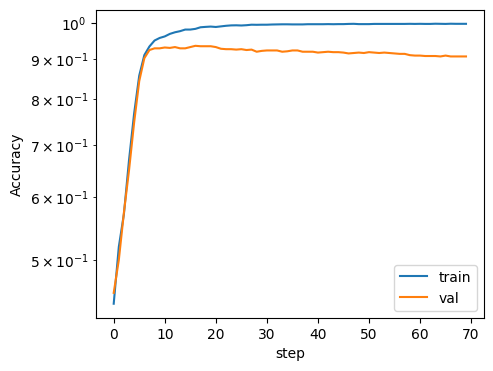

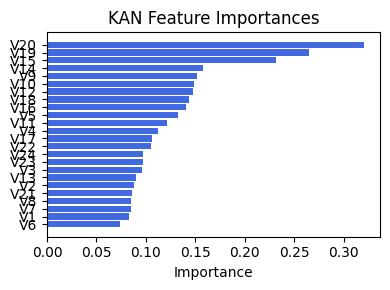

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V13', 0.5373303981650013), ('V8', 0.4854594166121947), ('V18', 0.4622034488188064), ('V12', 0.4331465262456775), ('V17', 0.4315003773247424), ('V16', 0.3988699033597496), ('V7', 0.3981905740678512), ('V11', 0.3939993331807586), ('V19', 0.3881855559353666), ('V14', 0.38470703633860326), ('V3', 0.3752501767826105), ('V9', 0.36300628257821776), ('V6', 0.3325824560305968), ('V2', 0.3071972801479425), ('V4', 0.2791931885004644), ('V1', 0.2357757986598529), ('V20', 0.2298433672924161), ('V23', 0.22145741325060447), ('V15', 0.21383086191818643), ('V21', 0.21375731399155737), ('V24', 0.20522603672890624), ('V22', 0.19412857830832433), ('V10', 0.1776171683220757), ('V5', 0.1754603498340437), ('Ex1', 0.17013296469734365)]


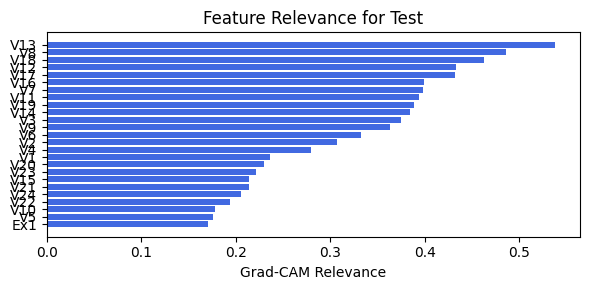

alpha: 0.75
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


 train_acc_hybrid: 9.97e-01 | val_acc_hybrid: 8.97e-01 |: 100%|█████| 70/70 [03:20<00:00,  2.86s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.3700e-01 at 10 epoch
tensor(0.9231, device='cuda:0')
[[414  25   1   1]
 [ 21 392   7   0]
 [  0   7  57   2]
 [  0   4  16 145]]
M_KAN Relevance: 0.8141108155250549
CNN Relevance: 0.18588919937610626
[('V15', 0.344488), ('V20', 0.26438236), ('V19', 0.250645), ('V18', 0.15165435), ('V11', 0.14730923), ('V6', 0.13528435), ('V16', 0.13032328), ('V12', 0.12328736), ('V14', 0.11771981), ('V8', 0.117112815), ('V9', 0.10997299), ('V3', 0.10199537), ('V10', 0.09630903), ('V4', 0.09503696), ('V24', 0.09297499), ('V17', 0.09078362), ('V22', 0.08726062), ('V13', 0.08288552), ('V5', 0.077140406), ('V7', 0.071864344), ('V2', 0.06649318), ('V23', 0.06474264), ('V1', 0.055263907), ('V21', 0.05361213)]


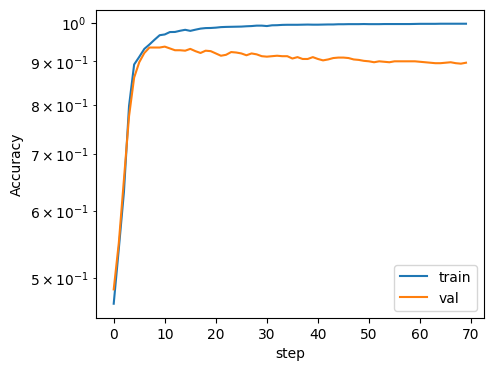

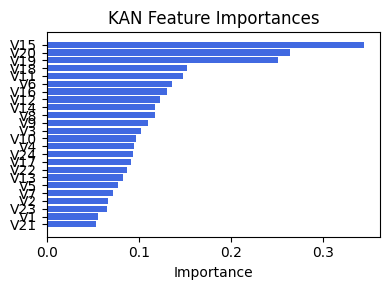

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V13', 0.4721942549697618), ('V18', 0.46841477735638415), ('V16', 0.39249236892148487), ('V8', 0.3904108533197792), ('V17', 0.37760447519456103), ('V11', 0.37376370532098213), ('V12', 0.35857501468616826), ('V7', 0.3093895887959861), ('V19', 0.2927558997979869), ('V14', 0.2922881148146982), ('V20', 0.2837496376308551), ('V9', 0.2820153540052184), ('V6', 0.27269878097600475), ('V10', 0.26880694640844705), ('V15', 0.2657427259575556), ('V3', 0.23830953946764813), ('V21', 0.23428399718356754), ('V23', 0.22388145920753158), ('V5', 0.1978284064550277), ('V4', 0.18833834894233142), ('V24', 0.18522709641177948), ('V22', 0.17911099708547829), ('V2', 0.16107166110624938), ('Ex1', 0.15954986350414987), ('V1', 0.11933918845799395)]


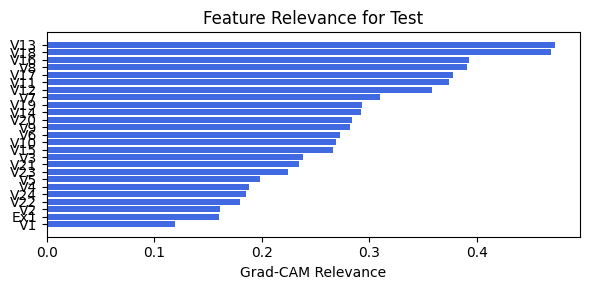

alpha: 0.5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


 train_acc_hybrid: 9.97e-01 | val_acc_hybrid: 9.29e-01 |: 100%|█████| 70/70 [03:26<00:00,  2.96s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.4845e-01 at 38 epoch
tensor(0.9249, device='cuda:0')
[[410  24   6   1]
 [  9 403   8   0]
 [  0  10  55   1]
 [  1   4  18 142]]
M_KAN Relevance: 0.7543317675590515
CNN Relevance: 0.2456681877374649
[('V15', 0.44859806), ('V20', 0.19820786), ('V14', 0.1850806), ('V19', 0.17144759), ('V18', 0.16914876), ('V12', 0.16597565), ('V16', 0.118290566), ('V3', 0.11798427), ('V13', 0.11512629), ('V9', 0.11094602), ('V5', 0.101333715), ('V8', 0.100933984), ('V23', 0.095943145), ('V21', 0.09377374), ('V6', 0.08770155), ('V17', 0.08542272), ('V22', 0.0842919), ('V7', 0.08398082), ('V24', 0.080354296), ('V10', 0.07897233), ('V2', 0.07467645), ('V11', 0.073246025), ('V1', 0.07052605), ('V4', 0.0680615)]


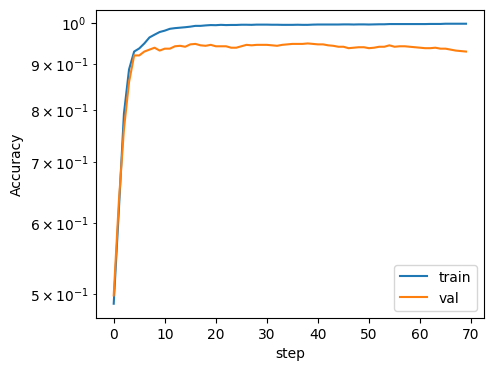

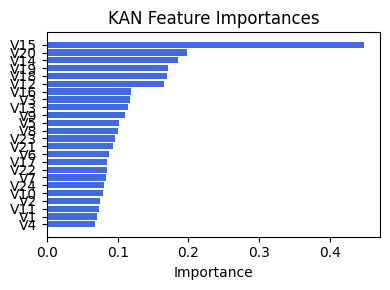

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V18', 0.2616482790563368), ('V19', 0.25586790839076784), ('V13', 0.24734365983653794), ('V14', 0.24574508967714712), ('V17', 0.24155341575210898), ('V8', 0.22712535331867492), ('V23', 0.21949610849369092), ('V9', 0.2132496376131809), ('V24', 0.21297949861447052), ('V12', 0.20754766551934006), ('V22', 0.2024242463145335), ('V7', 0.1925106620395763), ('V16', 0.17079475929788118), ('V20', 0.1622588478487506), ('V3', 0.15569750683683), ('Ex1', 0.15193240174219003), ('V6', 0.14769633585555206), ('V15', 0.146945769505745), ('V4', 0.1455807256868919), ('V11', 0.14515289105072507), ('V2', 0.1426231317685954), ('V21', 0.1393904238700751), ('V10', 0.13544372865126805), ('V5', 0.13203315505223398), ('V1', 0.12083291062598563)]


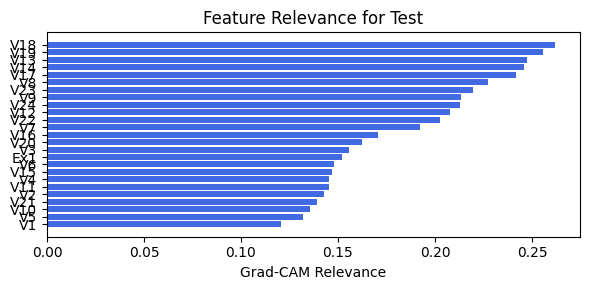

alpha: 0.25
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


 train_acc_hybrid: 9.98e-01 | val_acc_hybrid: 9.14e-01 |: 100%|█████| 70/70 [03:10<00:00,  2.73s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.3356e-01 at 25 epoch
tensor(0.9203, device='cuda:0')
[[411  26   3   1]
 [ 10 401   8   1]
 [  1  10  53   2]
 [  0   6  19 140]]
M_KAN Relevance: 0.5987014174461365
CNN Relevance: 0.4012986123561859
[('V15', 0.43443766), ('V20', 0.20887314), ('V12', 0.18905489), ('V13', 0.18823479), ('V14', 0.16322426), ('V19', 0.1601342), ('V5', 0.1541724), ('V22', 0.13838626), ('V9', 0.12474225), ('V11', 0.123183824), ('V17', 0.11163797), ('V8', 0.091138124), ('V6', 0.08509957), ('V3', 0.08507004), ('V18', 0.07913353), ('V7', 0.07763746), ('V24', 0.076838605), ('V10', 0.07404864), ('V4', 0.073661834), ('V2', 0.07332255), ('V23', 0.07122578), ('V21', 0.059370924), ('V16', 0.05512346), ('V1', 0.048941083)]


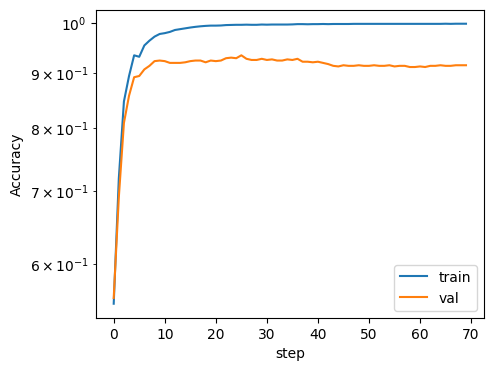

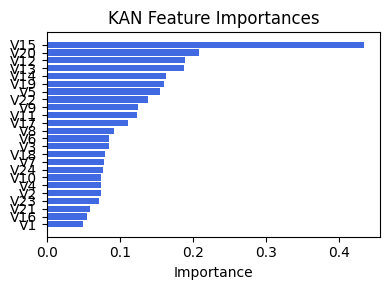

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V17', 0.2508254517352715), ('V19', 0.24862422473647328), ('V13', 0.24841333694599105), ('V18', 0.24841287385181085), ('V12', 0.24626457703644375), ('V20', 0.23997211528237528), ('V14', 0.23675266466413827), ('V8', 0.222441988340886), ('V15', 0.22209435778972458), ('V9', 0.22057797203916502), ('V7', 0.2123041533532526), ('V3', 0.20697411484929995), ('V24', 0.20607921278969327), ('V11', 0.20090862760988096), ('V23', 0.19428155030562685), ('V16', 0.19266581426911597), ('V10', 0.19068381883711907), ('V4', 0.18493841086309667), ('V2', 0.18342609916187994), ('V22', 0.17902985596444587), ('V6', 0.16303244296125743), ('Ex1', 0.16073222292575687), ('V5', 0.14678211678673983), ('V21', 0.12731133807297712), ('V1', 0.11876831948497982)]


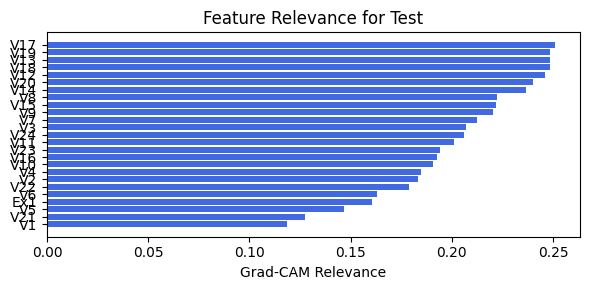

alpha: 0.1
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


 train_acc_hybrid: 9.95e-01 | val_acc_hybrid: 9.31e-01 |:  70%|███▌ | 49/70 [02:26<01:02,  3.00s/it]


KeyboardInterrupt: 

In [53]:
for alpha in [0.9, .75, .5, .25, .1, .05, .01]:
    print(f"alpha: {alpha}")
    train_and_plot_relevance(Model3_2, kan_neurons=11, kan_grid=3, lamb=0.001, steps=70, 
                             alpha=alpha, filename=filename_2, opt_col_val=alpha)

alpha: 0.1
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


 train_acc_hybrid: 9.99e-01 | val_acc_hybrid: 8.89e-01 |: 100%|█████| 70/70 [04:06<00:00,  3.52s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.0149e-01 at 7 epoch
tensor(0.9066, device='cuda:0')
[[396  42   2   1]
 [ 14 400   6   0]
 [  1   6  57   2]
 [  0   4  24 137]]
M_KAN Relevance: 0.5590068697929382
CNN Relevance: 0.4409931004047394
[('V15', 0.30101478), ('V19', 0.26428878), ('V20', 0.25141904), ('V18', 0.15359877), ('V10', 0.14693029), ('V14', 0.13859707), ('V22', 0.13276409), ('V16', 0.11800053), ('V4', 0.11762696), ('V12', 0.09262758), ('V13', 0.090537556), ('V17', 0.08538367), ('V11', 0.083807096), ('V9', 0.07784058), ('V3', 0.069165744), ('V21', 0.06513735), ('V23', 0.059574094), ('V6', 0.058584195), ('V7', 0.050004255), ('V24', 0.04639931), ('V8', 0.044832047), ('V5', 0.041185003), ('V1', 0.03882403), ('V2', 0.03484973)]


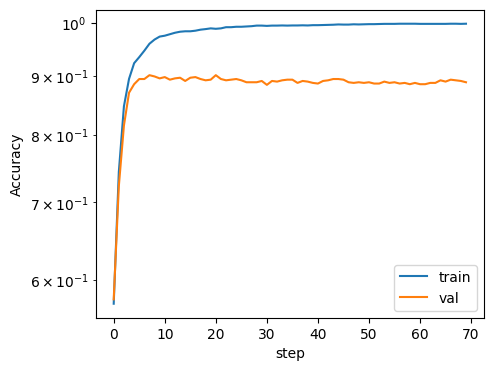

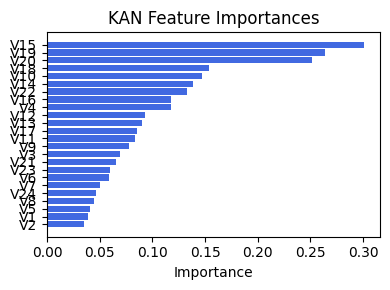

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V19', 0.3301117349542454), ('V12', 0.3194702679454264), ('V13', 0.31141880210269424), ('V14', 0.3049845548765126), ('V24', 0.29591472942685715), ('V18', 0.2869390197386735), ('V17', 0.2759063017464068), ('V8', 0.2734105431081577), ('V9', 0.2443312734628304), ('V23', 0.2352786636445458), ('V7', 0.23423725798387177), ('V16', 0.22882265940561977), ('V22', 0.22071859423203766), ('Ex1', 0.2138293961022863), ('V20', 0.2028622092963678), ('V11', 0.1960375549502188), ('V2', 0.1920195954263453), ('V15', 0.18971221237307995), ('V6', 0.1695043054368841), ('V3', 0.16874325216743077), ('V4', 0.15863918073719704), ('V21', 0.1374662880704315), ('V1', 0.13552579322600022), ('V10', 0.1340515488256589), ('V5', 0.08560860225812049)]


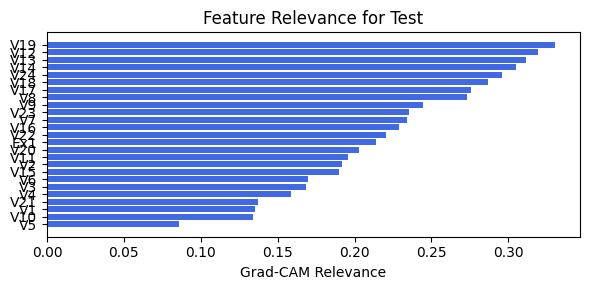

alpha: 0.05
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


 train_acc_hybrid: 9.98e-01 | val_acc_hybrid: 8.85e-01 |: 100%|█████| 70/70 [03:15<00:00,  2.80s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.1753e-01 at 17 epoch
tensor(0.9103, device='cuda:0')
[[411  27   2   1]
 [ 25 382  13   0]
 [  1   7  56   2]
 [  0   4  16 145]]
M_KAN Relevance: 0.5673026442527771
CNN Relevance: 0.4326973259449005
[('V19', 0.36108154), ('V20', 0.31530553), ('V15', 0.31201825), ('V18', 0.14953628), ('V14', 0.14594217), ('V5', 0.1311337), ('V12', 0.11944788), ('V21', 0.11527486), ('V16', 0.101741016), ('V22', 0.09856369), ('V11', 0.09612224), ('V13', 0.09080875), ('V17', 0.090164535), ('V10', 0.08843367), ('V24', 0.08069566), ('V4', 0.079506025), ('V3', 0.077330425), ('V9', 0.07694347), ('V6', 0.067539446), ('V7', 0.061969794), ('V8', 0.06064911), ('V2', 0.060526468), ('V1', 0.060106885), ('V23', 0.059279855)]


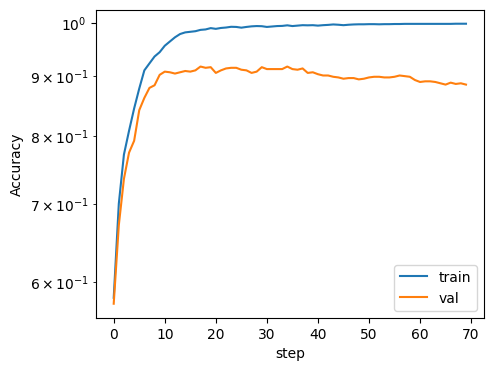

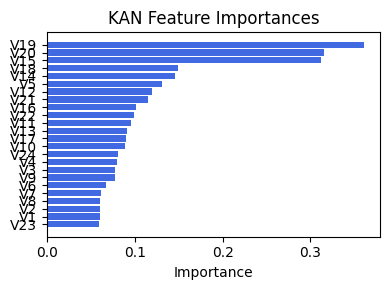

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V19', 0.29529787295372373), ('V18', 0.29025767872769054), ('V23', 0.28812508777369433), ('V24', 0.27346755266255673), ('V14', 0.25834423978855636), ('V22', 0.24844599896694378), ('V13', 0.24308028143183277), ('V20', 0.23907378785042965), ('V17', 0.23881491035688454), ('V12', 0.2277868012880613), ('V16', 0.2205572830580922), ('V9', 0.2164167663240899), ('V8', 0.21246440273876116), ('Ex1', 0.20810904204702574), ('V7', 0.20552038550561805), ('V15', 0.19934597066242202), ('V11', 0.19560829284733905), ('V3', 0.18692938548378113), ('V6', 0.18253855071336295), ('V4', 0.1618002843736313), ('V2', 0.1570497064521221), ('V10', 0.14789628428015864), ('V21', 0.1382837311463109), ('V5', 0.11329419931320404), ('V1', 0.10792217633269711)]


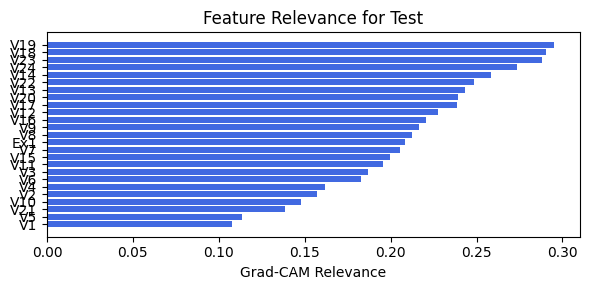

alpha: 0.01
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


 train_acc_hybrid: 9.97e-01 | val_acc_hybrid: 9.10e-01 |: 100%|█████| 70/70 [03:18<00:00,  2.84s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.2211e-01 at 11 epoch
tensor(0.9267, device='cuda:0')
[[415  20   5   1]
 [ 16 398   6   0]
 [  1   6  58   1]
 [  0   3  21 141]]
M_KAN Relevance: 0.5138375759124756
CNN Relevance: 0.4861624240875244
[('V15', 0.38284233), ('V19', 0.28112411), ('V20', 0.26129568), ('V21', 0.16016248), ('V14', 0.1498756), ('V18', 0.14515075), ('V12', 0.12428671), ('V4', 0.12355699), ('V22', 0.10804891), ('V16', 0.094586045), ('V3', 0.09146905), ('V13', 0.089810304), ('V11', 0.08868814), ('V10', 0.08617561), ('V9', 0.08003022), ('V6', 0.07997618), ('V24', 0.07376549), ('V23', 0.065913916), ('V17', 0.062210586), ('V8', 0.05409534), ('V1', 0.053835507), ('V5', 0.05308472), ('V2', 0.049496144), ('V7', 0.046112064)]


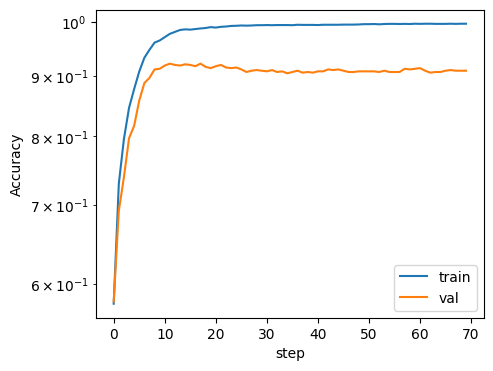

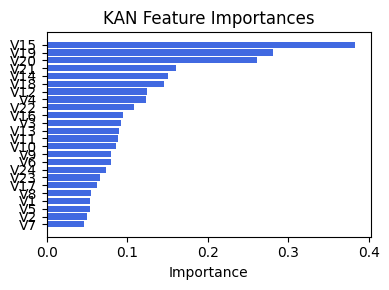

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V13', 0.4120841405629274), ('V18', 0.38022964499386713), ('V19', 0.34924099856540963), ('V8', 0.3362394481925179), ('V12', 0.3301976555770761), ('V17', 0.3294966502754895), ('V14', 0.32375598052075116), ('V23', 0.3204200096363257), ('V22', 0.30757544977472534), ('V7', 0.29653316436958244), ('V24', 0.29336179833162634), ('V9', 0.28000339890396114), ('V3', 0.21894615278569168), ('V16', 0.21779704369854475), ('V11', 0.2122312104017107), ('V21', 0.2072355897629937), ('V2', 0.19219718746408768), ('V6', 0.18299774355684695), ('V20', 0.17786173855647275), ('V15', 0.1746029543957755), ('V4', 0.1689035642846068), ('V1', 0.15581765359652658), ('V10', 0.14209252202325487), ('Ex1', 0.13733965970086268), ('V5', 0.10769547924667014)]


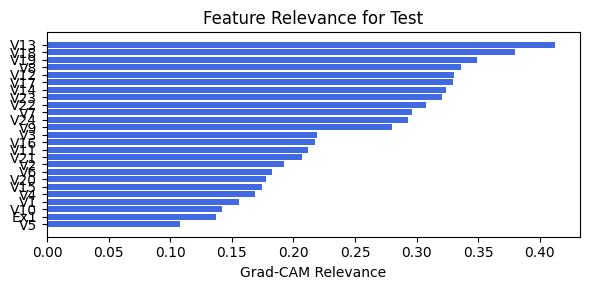

In [44]:
for alpha in [.1, .05, .01]:
    print(f"alpha: {alpha}")
    train_and_plot_relevance(Model3_2, kan_neurons=10, kan_grid=8, lamb=0.001, steps=70, 
                             alpha=alpha, filename=filename_2, opt_col_val=alpha)

## 2.3. width=[24, 7], grid=3, lamb=0.001

alpha: 0.9
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


 train_acc_hybrid: 9.98e-01 | val_acc_hybrid: 8.92e-01 |: 100%|█████| 70/70 [03:06<00:00,  2.67s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.3356e-01 at 14 epoch
tensor(0.9057, device='cuda:0')
[[406  30   4   1]
 [ 22 388  10   0]
 [  0  10  56   0]
 [  0   7  19 139]]
M_KAN Relevance: 0.5046371817588806
CNN Relevance: 0.4953628182411194
[('V20', 0.30090523), ('V19', 0.27179202), ('V15', 0.2571796), ('V18', 0.17659336), ('V13', 0.16937692), ('V24', 0.15458205), ('V22', 0.15268454), ('V9', 0.14219981), ('V16', 0.13708666), ('V14', 0.13571563), ('V10', 0.12800367), ('V7', 0.12340535), ('V12', 0.12137401), ('V11', 0.10465724), ('V6', 0.101851046), ('V17', 0.1007757), ('V3', 0.09939446), ('V23', 0.09851462), ('V5', 0.09421221), ('V2', 0.08810746), ('V21', 0.08798746), ('V4', 0.08461273), ('V8', 0.079338014), ('V1', 0.078900255)]


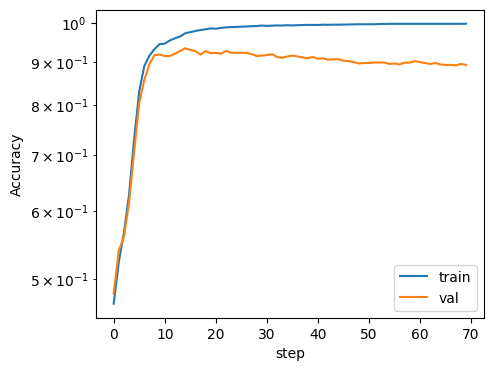

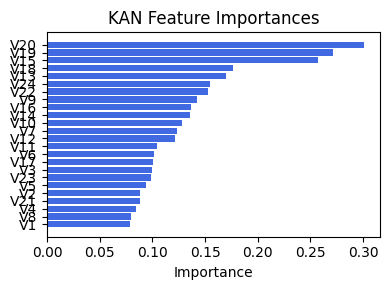

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V14', 0.48598099793932203), ('V13', 0.47003859714067614), ('V18', 0.4386251690977035), ('V19', 0.4289978182908308), ('V12', 0.422692644490857), ('V8', 0.4000657376271545), ('V9', 0.3960378655611372), ('V17', 0.3425777978974867), ('V15', 0.3275657252767678), ('V20', 0.32231565320395994), ('V7', 0.30578536479999335), ('V24', 0.3051856010240241), ('V4', 0.3032751011062998), ('V23', 0.29044176790756243), ('V3', 0.27302564656637623), ('V10', 0.2639171901224712), ('V2', 0.2512067802219576), ('V22', 0.2444023389032423), ('Ex1', 0.22933392775367184), ('V11', 0.20522846678934348), ('V16', 0.20062685080662357), ('V5', 0.16618393655379882), ('V6', 0.16489290717304472), ('V21', 0.15755049690184497), ('V1', 0.10079677375169956)]


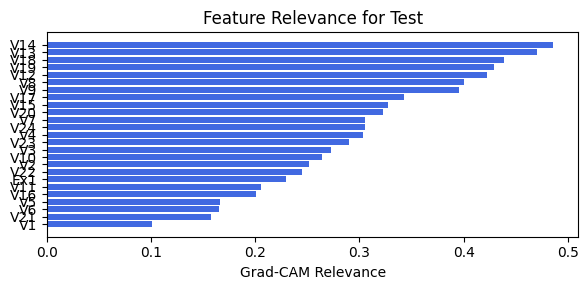

alpha: 0.75
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


 train_acc_hybrid: 9.95e-01 | val_acc_hybrid: 9.00e-01 |: 100%|█████| 70/70 [03:09<00:00,  2.70s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.1638e-01 at 38 epoch
tensor(0.9029, device='cuda:0')
[[406  31   3   1]
 [ 16 389  13   2]
 [  1  13  48   4]
 [  0   6  16 143]]
M_KAN Relevance: 0.7314748764038086
CNN Relevance: 0.26852506399154663
[('V15', 0.3019168), ('V20', 0.2969048), ('V19', 0.27660853), ('V18', 0.21320894), ('V16', 0.17800313), ('V14', 0.16438633), ('V22', 0.1508586), ('V12', 0.14847642), ('V10', 0.14343062), ('V7', 0.13649389), ('V13', 0.13542715), ('V5', 0.1247858), ('V9', 0.12476301), ('V24', 0.124435425), ('V4', 0.123945735), ('V3', 0.11707618), ('V11', 0.111333594), ('V23', 0.10445522), ('V2', 0.10244629), ('V17', 0.09810557), ('V21', 0.08874213), ('V6', 0.08554562), ('V8', 0.08488244), ('V1', 0.0757852)]


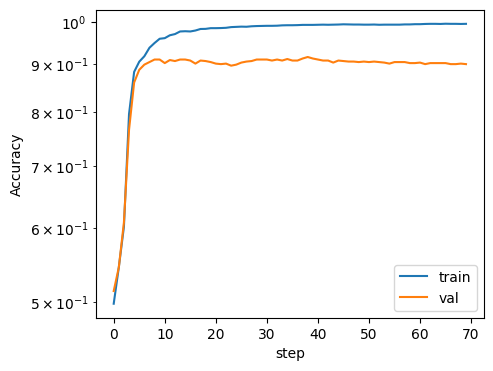

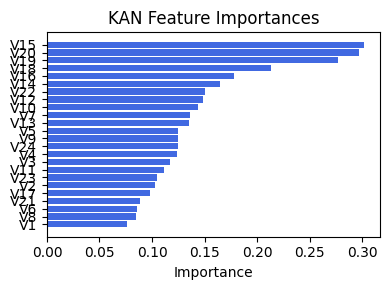

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V18', 0.3197894784546976), ('V13', 0.30196316103172066), ('V17', 0.2883935446227089), ('V19', 0.2810059153318581), ('V14', 0.27763273516567955), ('V12', 0.2614174933358952), ('V24', 0.25131260226104074), ('V8', 0.24600113220935033), ('V23', 0.23810718908013465), ('Ex1', 0.23548881096379), ('V16', 0.23459711278837359), ('V7', 0.23180855067353867), ('V11', 0.22734124804925832), ('V9', 0.2260342612751715), ('V22', 0.20894151092362492), ('V3', 0.20873928448542087), ('V20', 0.19764673851595976), ('V21', 0.19529316309640823), ('V4', 0.19361175431748337), ('V15', 0.18085048303308898), ('V2', 0.16910919023929646), ('V6', 0.16132991784657336), ('V5', 0.15776807876370316), ('V10', 0.14244530999382396), ('V1', 0.10492151350399082)]


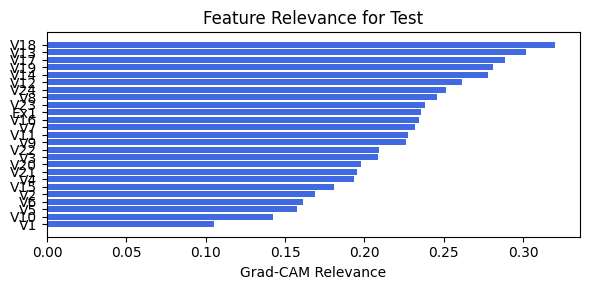

alpha: 0.5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


 train_acc_hybrid: 9.97e-01 | val_acc_hybrid: 8.96e-01 |: 100%|█████| 70/70 [03:04<00:00,  2.63s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.2669e-01 at 14 epoch
tensor(0.9121, device='cuda:0')
[[412  26   2   1]
 [ 16 389  14   1]
 [  0   6  59   1]
 [  0   6  23 136]]
M_KAN Relevance: 0.605722963809967
CNN Relevance: 0.39427703619003296
[('V15', 0.34857607), ('V20', 0.31799045), ('V19', 0.29473123), ('V18', 0.17522989), ('V22', 0.15206203), ('V14', 0.14098671), ('V11', 0.13883083), ('V9', 0.12219712), ('V12', 0.1212911), ('V16', 0.118954465), ('V6', 0.11257584), ('V24', 0.10887097), ('V13', 0.10548469), ('V10', 0.10499379), ('V17', 0.0904268), ('V23', 0.09019536), ('V7', 0.08829216), ('V3', 0.08317967), ('V4', 0.082757376), ('V21', 0.0699149), ('V5', 0.06991276), ('V2', 0.05849962), ('V8', 0.058100767), ('V1', 0.050745174)]


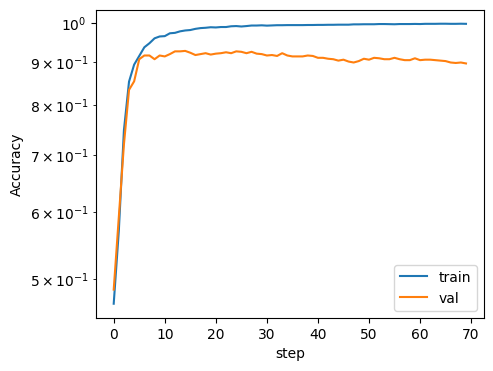

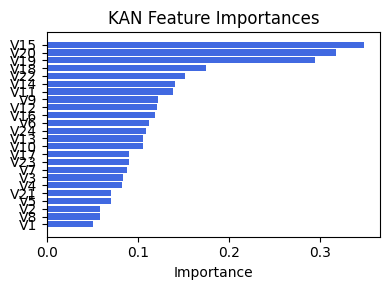

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V19', 0.2814504408131306), ('V24', 0.2725272382995305), ('V14', 0.26425672439204173), ('V13', 0.2590387918003033), ('V18', 0.2586035978347754), ('V17', 0.2494131518698464), ('V23', 0.2482791983575059), ('V8', 0.24227313394903466), ('V22', 0.23787585363539127), ('V12', 0.236191331934919), ('V9', 0.22997597830494554), ('V16', 0.22465674982840905), ('V7', 0.22147122931258578), ('V11', 0.21582348908373622), ('V20', 0.21530402276936075), ('V3', 0.19737894383532353), ('V4', 0.18698505625802048), ('V15', 0.18690866779752635), ('V10', 0.17746578241975516), ('V6', 0.1766027771652891), ('Ex1', 0.1736456199791124), ('V2', 0.16210749550122933), ('V21', 0.15210000442716975), ('V5', 0.12863178374156745), ('V1', 0.10748003253166268)]


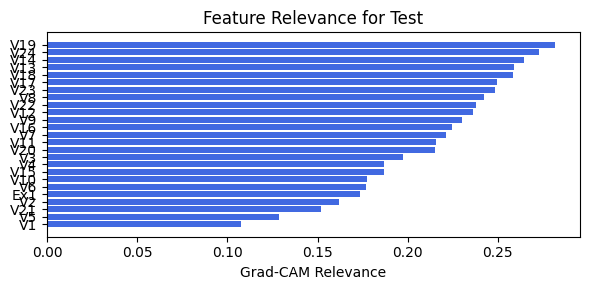

alpha: 0.25
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


 train_acc_hybrid: 9.97e-01 | val_acc_hybrid: 9.16e-01 |: 100%|█████| 70/70 [03:02<00:00,  2.61s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.3127e-01 at 7 epoch
tensor(0.9185, device='cuda:0')
[[405  30   5   1]
 [ 12 401   5   2]
 [  0   7  58   1]
 [  1   4  21 139]]
M_KAN Relevance: 0.4294331967830658
CNN Relevance: 0.5705668330192566
[('V15', 0.3661569), ('V20', 0.21376142), ('V19', 0.20122479), ('V13', 0.19031815), ('V14', 0.14625087), ('V22', 0.12974742), ('V12', 0.118455805), ('V9', 0.11520213), ('V18', 0.1119294), ('V7', 0.092789), ('V5', 0.09252843), ('V24', 0.08569517), ('V17', 0.08446141), ('V3', 0.08255073), ('V16', 0.07900785), ('V4', 0.078068614), ('V11', 0.07765783), ('V6', 0.07339188), ('V23', 0.06333656), ('V10', 0.058020625), ('V2', 0.056635074), ('V21', 0.0370018), ('V1', 0.03160409), ('V8', 0.031399567)]


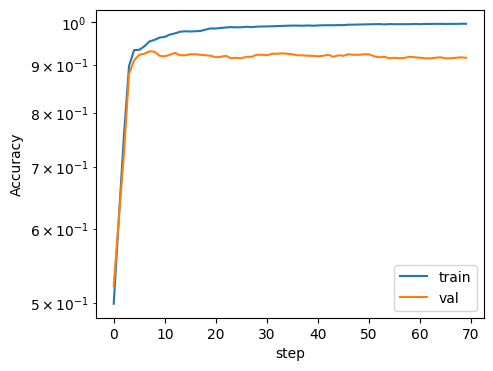

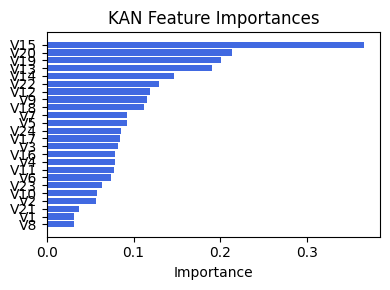

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V13', 0.33838806281011996), ('V4', 0.3277199758183051), ('V12', 0.3236588314836572), ('V14', 0.31475490968690517), ('V9', 0.31068640746173687), ('V17', 0.2956375736006448), ('V18', 0.28972694128086524), ('V3', 0.287853268841337), ('V8', 0.2701638105931251), ('V7', 0.2654618085492078), ('V2', 0.2639352458760726), ('V19', 0.2625531893570105), ('V10', 0.22346898022041364), ('V5', 0.2172321780443974), ('V20', 0.20539571430223683), ('V15', 0.20141064318753232), ('V22', 0.1945771889537428), ('V16', 0.17795112939179838), ('V24', 0.17585623559380809), ('V23', 0.1740241019099516), ('V21', 0.17202677148079368), ('V11', 0.1580083002949416), ('V6', 0.14099849780198787), ('V1', 0.10316884347678788), ('Ex1', 0.09452144074056221)]


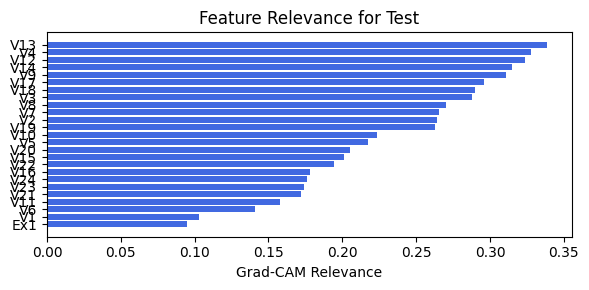

alpha: 0.1
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


 train_acc_hybrid: 9.98e-01 | val_acc_hybrid: 9.19e-01 |: 100%|█████| 70/70 [02:58<00:00,  2.55s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.2096e-01 at 68 epoch
tensor(0.9167, device='cuda:0')
[[412  24   5   0]
 [ 13 393  12   2]
 [  1   7  56   2]
 [  0   5  20 140]]
M_KAN Relevance: 0.6487497687339783
CNN Relevance: 0.35125023126602173
[('V19', 0.256242), ('V15', 0.20409667), ('V20', 0.18636344), ('V22', 0.15062995), ('V14', 0.12544225), ('V9', 0.11225871), ('V4', 0.10321154), ('V17', 0.10191032), ('V5', 0.10147847), ('V6', 0.09912009), ('V3', 0.09734847), ('V11', 0.090803765), ('V10', 0.0853986), ('V12', 0.08466585), ('V18', 0.08414128), ('V13', 0.081451654), ('V24', 0.079904936), ('V16', 0.070974864), ('V7', 0.06889638), ('V8', 0.067877404), ('V2', 0.06333617), ('V23', 0.045050386), ('V21', 0.039631043), ('V1', 0.03196394)]


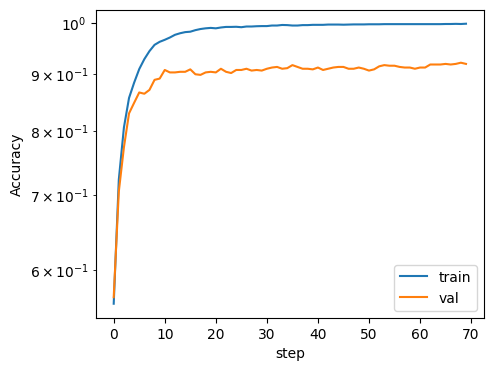

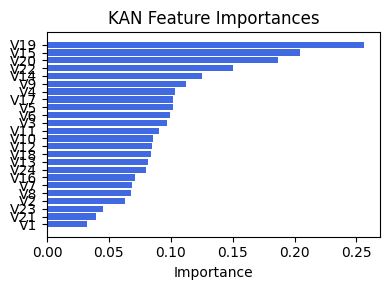

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V19', 0.28072468226838904), ('V18', 0.2591995650018295), ('V13', 0.25612732986774595), ('V14', 0.24783130605694847), ('V8', 0.2407753277591757), ('V17', 0.23617586967745974), ('V24', 0.22807516096141267), ('V20', 0.22632197744188978), ('V23', 0.22168634711116472), ('V12', 0.21618441901414487), ('V9', 0.21371467545123868), ('V7', 0.21181258482053866), ('V22', 0.20845822113267706), ('V15', 0.20389177862250105), ('V3', 0.19800258422309436), ('V2', 0.18748730325878168), ('V4', 0.18482212872098258), ('V16', 0.18152529734332667), ('V10', 0.17366462119200096), ('V6', 0.15963800083214738), ('V11', 0.1571736814799446), ('V21', 0.1528260175175838), ('Ex1', 0.1492607116926439), ('V5', 0.14306569541607936), ('V1', 0.12860106012938446)]


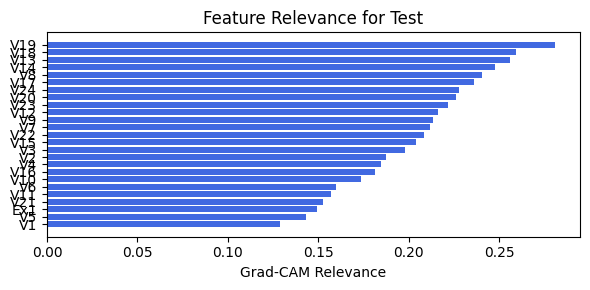

alpha: 0.05
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


 train_acc_hybrid: 9.97e-01 | val_acc_hybrid: 9.22e-01 |: 100%|█████| 70/70 [03:03<00:00,  2.63s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.3356e-01 at 54 epoch
tensor(0.9121, device='cuda:0')
[[411  25   4   1]
 [ 21 388  11   0]
 [  1   9  50   6]
 [  1   5  12 147]]
M_KAN Relevance: 0.652566134929657
CNN Relevance: 0.34743380546569824
[('V20', 0.28299186), ('V15', 0.27262726), ('V19', 0.2136537), ('V22', 0.16110224), ('V14', 0.13192004), ('V12', 0.12190539), ('V16', 0.11833204), ('V24', 0.11667689), ('V18', 0.109266795), ('V13', 0.10446788), ('V10', 0.09999893), ('V11', 0.089701384), ('V4', 0.08934474), ('V7', 0.08783911), ('V9', 0.08516443), ('V8', 0.08422018), ('V5', 0.08340516), ('V17', 0.08323946), ('V6', 0.076466024), ('V21', 0.06834656), ('V3', 0.057706937), ('V2', 0.055728476), ('V23', 0.049286973), ('V1', 0.04901466)]


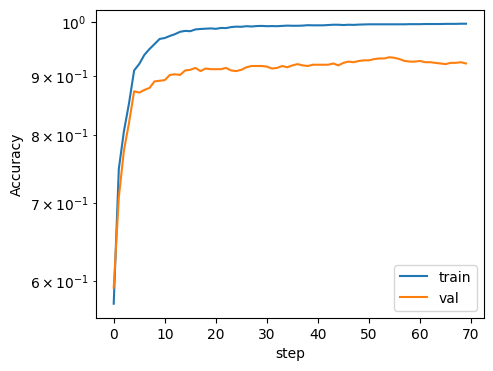

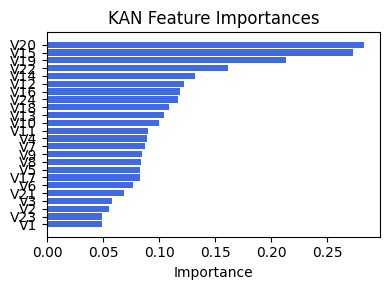

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V3', 0.25862819020232974), ('V19', 0.2524360398178359), ('V18', 0.2489303791898547), ('V8', 0.2449662610183806), ('V9', 0.24469553921445258), ('V24', 0.24444207190043302), ('V13', 0.24050764296580815), ('V23', 0.2378910320010805), ('V17', 0.23526306147100795), ('V20', 0.22962197766509446), ('V14', 0.22959856914896104), ('V4', 0.2248849224479972), ('V12', 0.22391621113001414), ('V7', 0.2178933065468953), ('V2', 0.21584265843794861), ('V15', 0.2076034758578343), ('V22', 0.2013794775585989), ('V10', 0.18746621455859866), ('Ex1', 0.1813566657648076), ('V16', 0.1700228053147669), ('V11', 0.15911254589360602), ('V6', 0.15708924877376193), ('V5', 0.15046170158831168), ('V1', 0.14418292567088195), ('V21', 0.1250284275824208)]


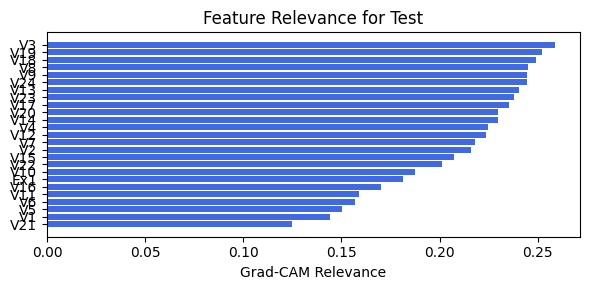

alpha: 0.01
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


 train_acc_hybrid: 9.94e-01 | val_acc_hybrid: 9.03e-01 |: 100%|█████| 70/70 [03:06<00:00,  2.66s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.2325e-01 at 18 epoch
tensor(0.8993, device='cuda:0')
[[411  26   4   0]
 [ 22 380  17   1]
 [  1  10  55   0]
 [  1   7  21 136]]
M_KAN Relevance: 0.5633267164230347
CNN Relevance: 0.43667325377464294
[('V15', 0.38769475), ('V19', 0.32532752), ('V20', 0.28038883), ('V14', 0.177193), ('V13', 0.15742779), ('V11', 0.14118385), ('V12', 0.13745339), ('V18', 0.124893375), ('V24', 0.12292993), ('V22', 0.11042155), ('V16', 0.10224303), ('V1', 0.09083048), ('V6', 0.08581041), ('V7', 0.08271275), ('V21', 0.0795952), ('V17', 0.076972395), ('V3', 0.072882414), ('V4', 0.07217212), ('V10', 0.07132703), ('V23', 0.059611958), ('V8', 0.055817537), ('V2', 0.054369204), ('V5', 0.050544295), ('V9', 0.048752487)]


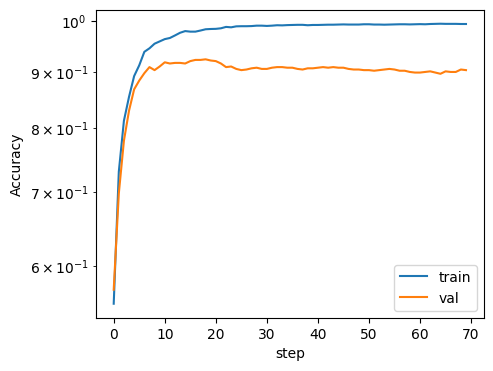

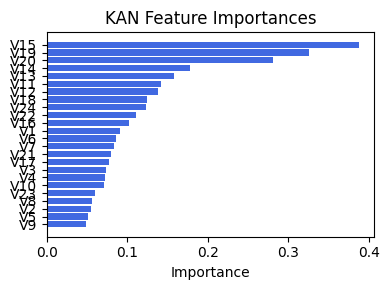

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V18', 0.28012676968615785), ('V19', 0.27194024717707077), ('V12', 0.2596435427965064), ('V13', 0.25791933342828094), ('V17', 0.2566582957858286), ('V14', 0.2506984797043678), ('V7', 0.23188846124909246), ('V16', 0.22988145792623982), ('V8', 0.22921307275343375), ('V9', 0.22280934865901164), ('V23', 0.2217412079308805), ('V24', 0.21763089314045386), ('V3', 0.2096979964847515), ('V22', 0.20182947800159934), ('V20', 0.19987507592281623), ('V11', 0.1958648003913904), ('V6', 0.19551098500798597), ('V15', 0.17718896390024816), ('V4', 0.17511268742642117), ('V2', 0.17462320064237996), ('V21', 0.16490837813058873), ('V10', 0.16323552390458113), ('Ex1', 0.14142307526840808), ('V5', 0.13598031531332558), ('V1', 0.13343681810589)]


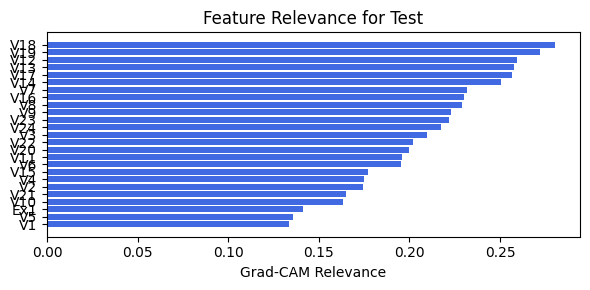

In [45]:
for alpha in [0.9, .75, .5, .25, .1, .05, .01]:
    print(f"alpha: {alpha}")
    train_and_plot_relevance(Model3_2, kan_neurons=7, kan_grid=3, lamb=0.001, steps=70, 
                             alpha=alpha, filename=filename_2, opt_col_val=alpha)

# Option 3: Dynamic factor

In [48]:
create_csv_with_header(filename_3, columns_opt3)

## 3.0. width=[24, 12], grid=8, lamb=0.001

hidden_dim: 128
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


 train_acc_hybrid: 9.96e-01 | val_acc_hybrid: 9.26e-01 |: 100%|█████| 80/80 [04:07<00:00,  3.10s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.2898e-01 at 37 epoch
tensor(0.9313, device='cuda:0')
[[417  17   6   1]
 [  9 397  13   1]
 [  0   5  60   1]
 [  2   7  13 143]]
M_KAN Relevance: 0.364958256483078
CNN Relevance: 0.6350417733192444
[('V15', 0.39260072), ('V20', 0.2738197), ('V19', 0.22943217), ('V13', 0.17849097), ('V14', 0.14819634), ('V4', 0.13668421), ('V18', 0.13654263), ('V12', 0.1340703), ('V11', 0.13353969), ('V16', 0.13328351), ('V10', 0.109519504), ('V17', 0.10837208), ('V22', 0.09863126), ('V2', 0.09839835), ('V21', 0.09828966), ('V6', 0.09778629), ('V9', 0.097167835), ('V24', 0.09055422), ('V8', 0.08854457), ('V1', 0.08845737), ('V5', 0.07748797), ('V3', 0.07416901), ('V7', 0.068222515), ('V23', 0.067006424)]


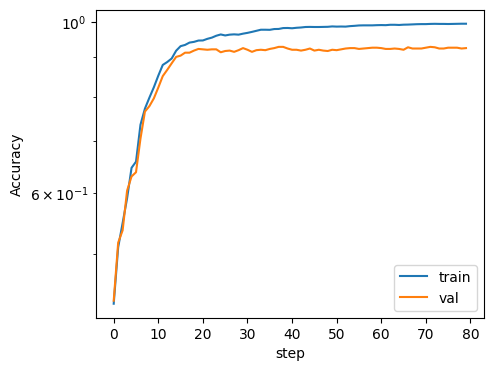

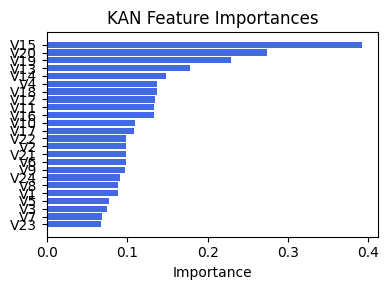

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V16', 0.344880699032402), ('V11', 0.3382052486595457), ('V13', 0.2835524956123893), ('V6', 0.2832309663014542), ('V8', 0.27999146012241793), ('V12', 0.27125894294300323), ('V7', 0.2604669746497599), ('V14', 0.25707407006723104), ('V9', 0.24067286814755082), ('V17', 0.23606039073843604), ('V18', 0.22555887556934198), ('V19', 0.22145034366186228), ('V3', 0.21231126080918608), ('V2', 0.21069487630373612), ('V1', 0.17507531360406708), ('V4', 0.17255911365089147), ('V20', 0.16931400024465898), ('V15', 0.16063704980580365), ('V24', 0.15080087872058104), ('Ex1', 0.13964936331039707), ('V10', 0.1385626161354161), ('V21', 0.1370740872379239), ('V22', 0.12976538960806683), ('V5', 0.1268147270742029), ('V23', 0.12273434740673243)]


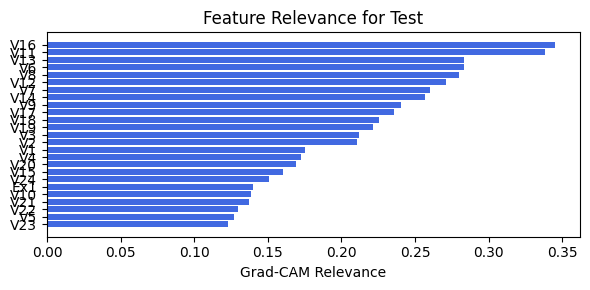

hidden_dim: 64
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


 train_acc_hybrid: 9.90e-01 | val_acc_hybrid: 9.39e-01 |: 100%|█████| 80/80 [04:05<00:00,  3.07s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.4387e-01 at 62 epoch
tensor(0.9332, device='cuda:0')
[[412  21   7   1]
 [ 10 404   4   2]
 [  0   5  58   3]
 [  4   6  10 145]]
M_KAN Relevance: 0.22589708864688873
CNN Relevance: 0.7741029262542725
[('V15', 0.41144738), ('V20', 0.25119656), ('V19', 0.23740189), ('V12', 0.14513335), ('V13', 0.14217547), ('V18', 0.12637064), ('V16', 0.124203354), ('V14', 0.1207702), ('V6', 0.11420854), ('V17', 0.11179137), ('V10', 0.10709794), ('V24', 0.10062196), ('V9', 0.09934367), ('V22', 0.09348033), ('V4', 0.09317452), ('V11', 0.09285985), ('V2', 0.08685975), ('V1', 0.08116461), ('V21', 0.08038246), ('V23', 0.07641156), ('V8', 0.06897502), ('V5', 0.062532395), ('V7', 0.06174108), ('V3', 0.0608252)]


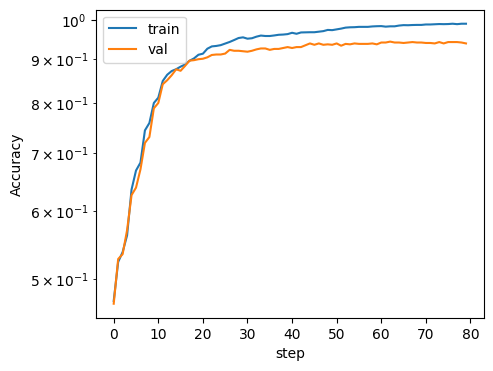

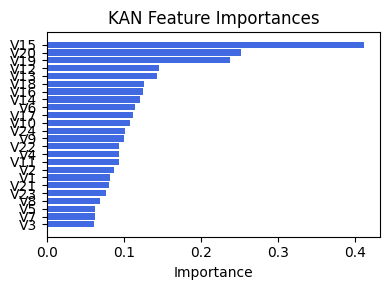

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V13', 0.5142306791753698), ('V18', 0.4731092681361924), ('V12', 0.4687351826668962), ('V24', 0.4417113628007208), ('V23', 0.43754522868586565), ('V17', 0.43200658507847256), ('V19', 0.4139955470552292), ('V22', 0.38347908337875575), ('V8', 0.38334377034345124), ('V11', 0.3796258797891267), ('V14', 0.37689345555810466), ('V16', 0.3566102782964123), ('V7', 0.34199874103485073), ('V9', 0.27738768038765915), ('V6', 0.2710061834363059), ('Ex1', 0.2653863715697911), ('V3', 0.25720411646644664), ('V2', 0.22664649345963317), ('V21', 0.21646972464420883), ('V1', 0.18674511665371954), ('V4', 0.17195964288191964), ('V20', 0.169682050562607), ('V15', 0.16137609992606136), ('V10', 0.10771201291395417), ('V5', 0.08291323149235692)]


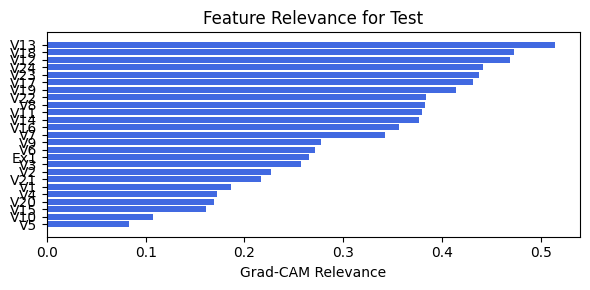

hidden_dim: 32
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


 train_acc_hybrid: 9.95e-01 | val_acc_hybrid: 9.40e-01 |: 100%|█████| 80/80 [04:06<00:00,  3.09s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.4273e-01 at 63 epoch
tensor(0.9231, device='cuda:0')
[[410  27   3   1]
 [ 14 394  12   0]
 [  0   6  58   2]
 [  1   5  13 146]]
M_KAN Relevance: 0.45570608973503113
CNN Relevance: 0.5442938804626465
[('V15', 0.33157152), ('V19', 0.2653272), ('V20', 0.25908566), ('V18', 0.16708249), ('V21', 0.15640897), ('V12', 0.14708865), ('V22', 0.14457078), ('V4', 0.14210664), ('V13', 0.13861515), ('V16', 0.1374112), ('V14', 0.13612023), ('V17', 0.12796879), ('V24', 0.108918235), ('V10', 0.10867479), ('V7', 0.10187161), ('V11', 0.101518236), ('V9', 0.09313523), ('V8', 0.08737485), ('V5', 0.08469721), ('V6', 0.08096106), ('V2', 0.07321932), ('V23', 0.06995674), ('V1', 0.06165859), ('V3', 0.057865273)]


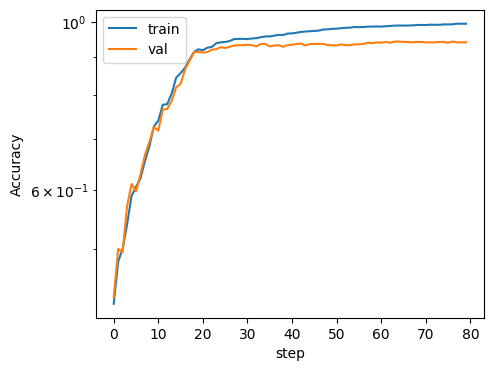

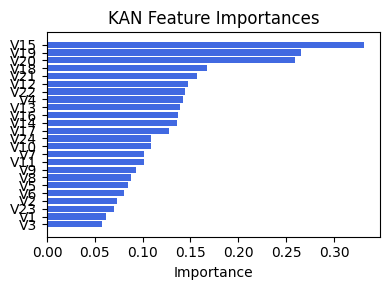

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V23', 0.3274696358025305), ('V24', 0.3196353654836854), ('V19', 0.31345338074681467), ('V22', 0.2974654872343088), ('V18', 0.2802836270232117), ('V14', 0.2720650876114396), ('V3', 0.267381954707155), ('V17', 0.2527753764635759), ('V13', 0.25244421845004766), ('V4', 0.23531793482183502), ('V9', 0.22829973342361085), ('V20', 0.22274683533477743), ('V16', 0.21583030426231728), ('V12', 0.21325257989812912), ('V8', 0.2088900125230387), ('V15', 0.20284464120612314), ('V2', 0.19790174948021616), ('V7', 0.18219581656750708), ('V21', 0.17145568783136308), ('V10', 0.1711008958977983), ('V11', 0.15294015277387912), ('Ex1', 0.1513156008508697), ('V5', 0.15053670698715482), ('V6', 0.13078404701087365), ('V1', 0.10281616344622267)]


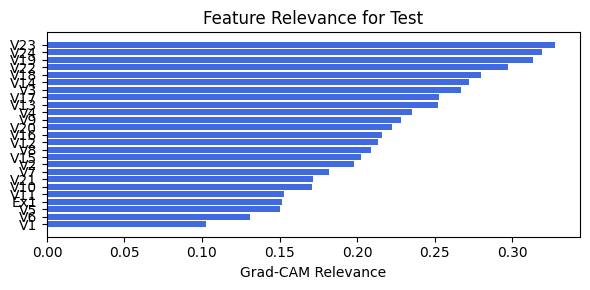

hidden_dim: 16
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


 train_acc_hybrid: 9.97e-01 | val_acc_hybrid: 9.38e-01 |: 100%|█████| 80/80 [04:07<00:00,  3.09s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.4387e-01 at 60 epoch
tensor(0.9313, device='cuda:0')
[[406  29   5   1]
 [ 11 405   3   1]
 [  0   5  60   1]
 [  1   6  12 146]]
M_KAN Relevance: 0.3429095447063446
CNN Relevance: 0.657090425491333
[('V15', 0.3597196), ('V20', 0.24252692), ('V19', 0.20208833), ('V14', 0.19408743), ('V13', 0.17241375), ('V11', 0.14380097), ('V23', 0.13746786), ('V17', 0.13037919), ('V18', 0.12845033), ('V24', 0.12780765), ('V7', 0.120881304), ('V4', 0.12043977), ('V16', 0.11804893), ('V6', 0.11466124), ('V22', 0.104715645), ('V12', 0.10253835), ('V10', 0.100021385), ('V2', 0.09768182), ('V1', 0.09686218), ('V21', 0.0929689), ('V3', 0.09261908), ('V5', 0.08213709), ('V8', 0.07866686), ('V9', 0.06757047)]


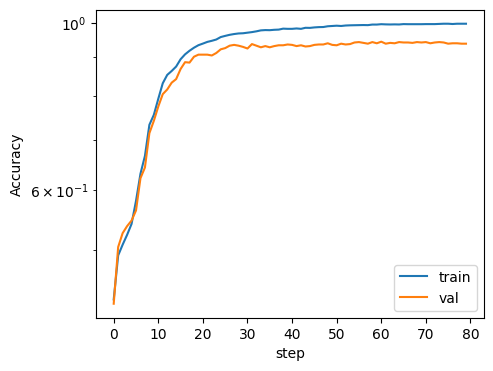

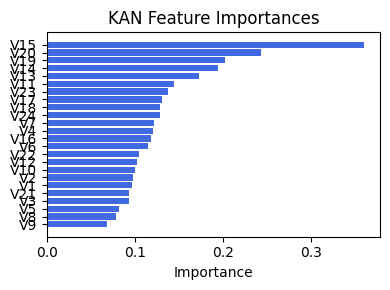

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V16', 0.3229937236292344), ('V19', 0.2883942222677686), ('V14', 0.2838419258913589), ('V11', 0.27992604020327344), ('V13', 0.2510691136823227), ('V18', 0.24662329577630848), ('V12', 0.24464665656369805), ('V17', 0.2433858838327542), ('V21', 0.2261355117914538), ('V9', 0.2237274422391821), ('V8', 0.2162586466812562), ('V7', 0.21111141566541933), ('V24', 0.20251660931496654), ('V6', 0.1968218645802603), ('V23', 0.18665552442228914), ('V22', 0.17075440813612444), ('V20', 0.16093496121654854), ('Ex1', 0.15861457188104341), ('V15', 0.15211686309614225), ('V2', 0.13849070004959682), ('V3', 0.13532281862292925), ('V10', 0.12857285530992738), ('V4', 0.11575445062441422), ('V1', 0.10960753219077536), ('V5', 0.0702377686111204)]


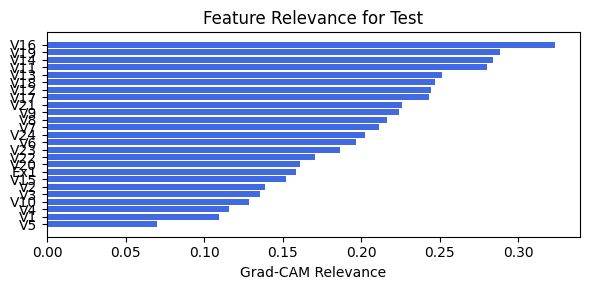

hidden_dim: 8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


 train_acc_hybrid: 9.95e-01 | val_acc_hybrid: 9.59e-01 |: 100%|█████| 80/80 [03:53<00:00,  2.92s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.5991e-01 at 67 epoch
tensor(0.9423, device='cuda:0')
[[411  20   7   3]
 [  7 409   4   0]
 [  0   5  61   0]
 [  4   7   6 148]]
M_KAN Relevance: 0.3765254318714142
CNN Relevance: 0.6234745979309082
[('V15', 0.39301082), ('V19', 0.2682982), ('V20', 0.24316934), ('V13', 0.20366), ('V14', 0.1503352), ('V6', 0.14296284), ('V17', 0.13349524), ('V16', 0.13191772), ('V12', 0.12907587), ('V18', 0.123050086), ('V4', 0.105184674), ('V22', 0.10007235), ('V24', 0.09638652), ('V11', 0.09404309), ('V9', 0.09317452), ('V2', 0.09229037), ('V3', 0.08173059), ('V10', 0.07962038), ('V21', 0.07721605), ('V8', 0.075748324), ('V5', 0.07071339), ('V23', 0.06914446), ('V7', 0.06814858), ('V1', 0.05743642)]


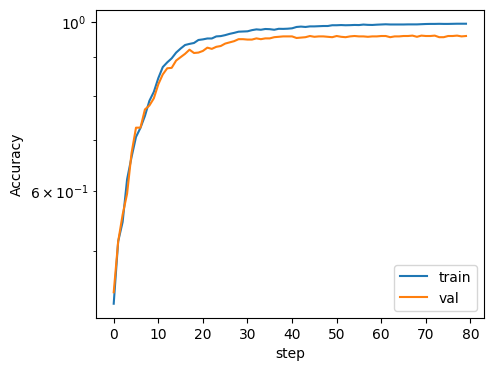

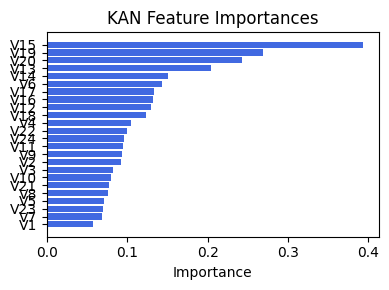

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V24', 0.321582664350869), ('V23', 0.259343516213445), ('V19', 0.24433053676596536), ('V22', 0.21700556647104619), ('V16', 0.21585043872251486), ('V13', 0.20389869388392462), ('Ex1', 0.19906653490910778), ('V18', 0.19886305812751776), ('V14', 0.18793198369084643), ('V17', 0.18591718326995213), ('V11', 0.18222264469334268), ('V12', 0.1663111777333952), ('V8', 0.16523091563865505), ('V21', 0.1564853317419305), ('V20', 0.14871023572393843), ('V7', 0.14590095743390258), ('V6', 0.13776119224921818), ('V9', 0.13625796467228707), ('V3', 0.1174380450884267), ('V15', 0.11045388592967753), ('V2', 0.0922846709583123), ('V10', 0.08664367241013786), ('V4', 0.0815948152154479), ('V1', 0.06553898979896926), ('V5', 0.04874971670189899)]


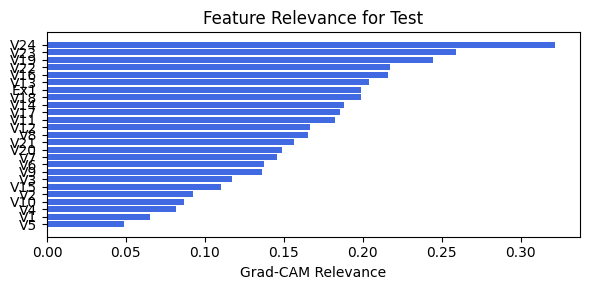

In [50]:
for hidden_dim in [128, 64, 32, 16, 8]:
    print(f"hidden_dim: {hidden_dim}")
    train_and_plot_relevance(Model3_3, kan_neurons=12, kan_grid=8, lamb=0.001, steps=80, 
                             hidden_dim=hidden_dim, filename=filename_3, opt_col_val=hidden_dim)

## 3.1 width=[24, 6, 1], grid=7, lamb=1e-05

hidden_dim: 128
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


 train_acc_hybrid: 9.85e-01 | val_acc_hybrid: 9.50e-01 |: 100%|█████| 70/70 [03:21<00:00,  2.88s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.4960e-01 at 69 epoch
tensor(0.9441, device='cuda:0')
[[413  23   4   1]
 [  7 410   2   1]
 [  1   6  59   0]
 [  6   3   7 149]]
M_KAN Relevance: 0.041881486773490906
CNN Relevance: 0.9581184983253479
[('V15', 0.3982728), ('V20', 0.28348923), ('V14', 0.23145646), ('V19', 0.20413536), ('V18', 0.16425097), ('V9', 0.15190423), ('V11', 0.14099061), ('V17', 0.14009333), ('V3', 0.13745861), ('V13', 0.13182116), ('V22', 0.13051933), ('V16', 0.12506261), ('V23', 0.12180193), ('V6', 0.12000197), ('V12', 0.11919525), ('V7', 0.11773765), ('V4', 0.117648184), ('V8', 0.108910404), ('V21', 0.10646038), ('V2', 0.103771836), ('V24', 0.10232668), ('V1', 0.095743135), ('V10', 0.081786305), ('V5', 0.081320435)]


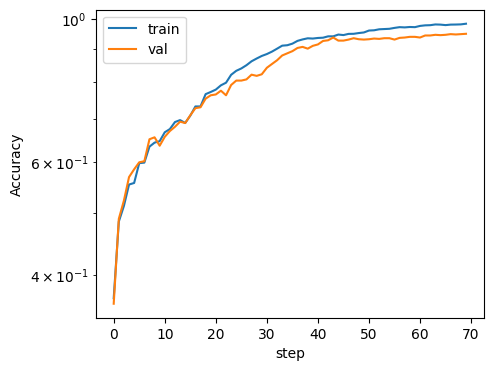

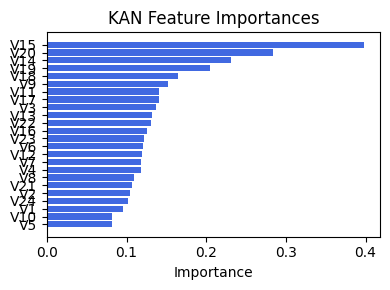

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V3', 0.3645968287614595), ('V24', 0.34716223461505136), ('V8', 0.3328852452758948), ('V4', 0.32664391095094397), ('V9', 0.3193576053573975), ('V23', 0.3146080349296636), ('V2', 0.3045094904249602), ('V13', 0.2974166747977046), ('V14', 0.28550687197523555), ('V19', 0.26720660379341943), ('V7', 0.2570490082684572), ('V12', 0.25027293279341034), ('V22', 0.24822746184772868), ('V18', 0.23013920645451688), ('Ex1', 0.22588427099069186), ('V17', 0.2187505390891588), ('V20', 0.1733500370618268), ('V10', 0.1732602484742982), ('V5', 0.16138806014212925), ('V15', 0.14988699093017924), ('V11', 0.14504891690278818), ('V1', 0.14302266298177746), ('V16', 0.12667622754584762), ('V6', 0.125827817922802), ('V21', 0.06776231449872192)]


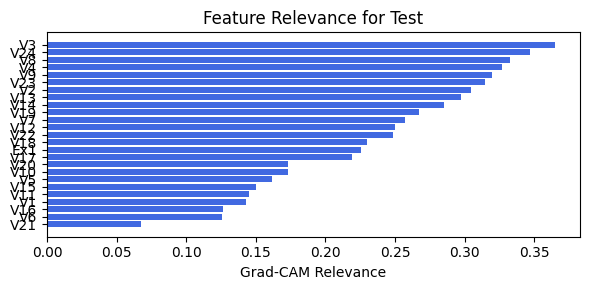

hidden_dim: 64
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


 train_acc_hybrid: 9.89e-01 | val_acc_hybrid: 9.51e-01 |: 100%|█████| 70/70 [03:23<00:00,  2.90s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.5304e-01 at 67 epoch
tensor(0.9423, device='cuda:0')
[[421  11   6   3]
 [ 11 402   6   1]
 [  1   7  57   1]
 [  4   4   8 149]]
M_KAN Relevance: 0.06803001463413239
CNN Relevance: 0.9319700598716736
[('V15', 0.36332342), ('V20', 0.32424492), ('V19', 0.24121854), ('V9', 0.17309415), ('V17', 0.15902874), ('V18', 0.15743619), ('V14', 0.15569256), ('V3', 0.13758653), ('V12', 0.12552467), ('V5', 0.12065248), ('V16', 0.117687404), ('V11', 0.116184115), ('V22', 0.11189464), ('V24', 0.10699378), ('V13', 0.10514015), ('V10', 0.10408187), ('V2', 0.093277395), ('V7', 0.08345014), ('V6', 0.080291346), ('V8', 0.08016877), ('V21', 0.06940198), ('V23', 0.066992626), ('V1', 0.06450067), ('V4', 0.061417878)]


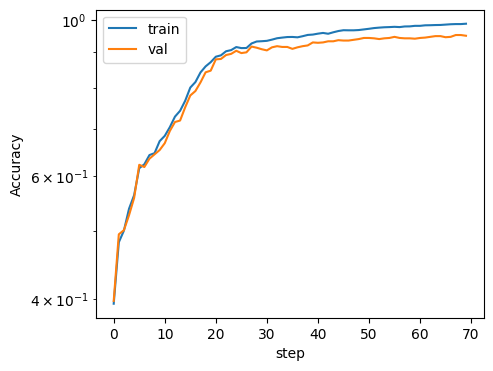

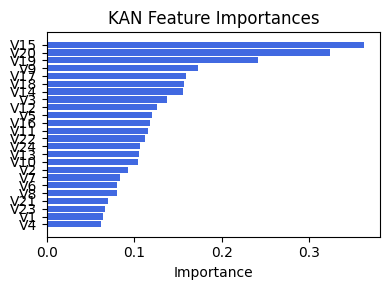

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V16', 0.27118501538206524), ('V11', 0.2650478024746444), ('V20', 0.24784634992934798), ('V15', 0.24259628834635552), ('V8', 0.2276100987321062), ('V17', 0.22689154436372583), ('V13', 0.22577413337139093), ('V10', 0.2186697595957462), ('V12', 0.213939810109358), ('V6', 0.212488963044182), ('V19', 0.21134699450188207), ('V18', 0.2106014447205277), ('V14', 0.20983137675928168), ('V9', 0.2046114380634038), ('V2', 0.20283378669780475), ('V3', 0.19569140336513152), ('V7', 0.19496589980575157), ('V4', 0.17546303257183152), ('Ex1', 0.1721856871175081), ('V21', 0.16335559422130133), ('V1', 0.1437903383489606), ('V5', 0.14204022763231264), ('V24', 0.14149269086808686), ('V22', 0.13394498088639725), ('V23', 0.11680278115405406)]


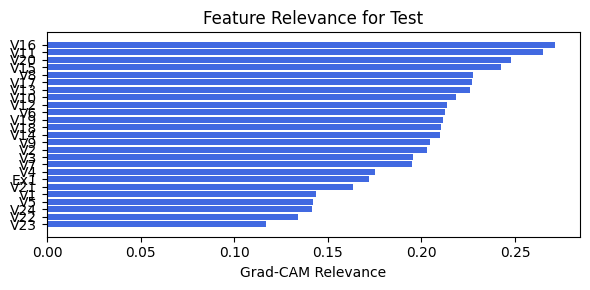

hidden_dim: 32
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


 train_acc_hybrid: 9.98e-01 | val_acc_hybrid: 9.48e-01 |: 100%|█████| 70/70 [03:10<00:00,  2.72s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.5533e-01 at 47 epoch
tensor(0.9368, device='cuda:0')
[[408  26   4   3]
 [ 10 406   2   2]
 [  0   6  59   1]
 [  3   7   5 150]]
M_KAN Relevance: 0.058793965727090836
CNN Relevance: 0.9412060379981995
[('V15', 0.366047), ('V20', 0.32316646), ('V19', 0.23667306), ('V12', 0.1931573), ('V14', 0.18072717), ('V18', 0.14832088), ('V17', 0.13965338), ('V22', 0.13565442), ('V16', 0.13238084), ('V2', 0.13215546), ('V9', 0.12716712), ('V13', 0.119314075), ('V11', 0.1160637), ('V10', 0.114640534), ('V23', 0.09382164), ('V24', 0.092880026), ('V3', 0.08709374), ('V4', 0.0864514), ('V8', 0.0863422), ('V7', 0.07270309), ('V21', 0.06454363), ('V6', 0.062565744), ('V1', 0.060238134), ('V5', 0.060043868)]


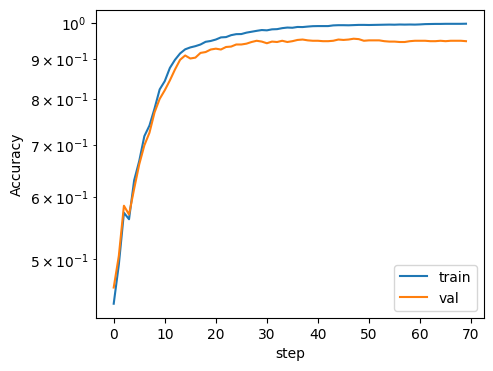

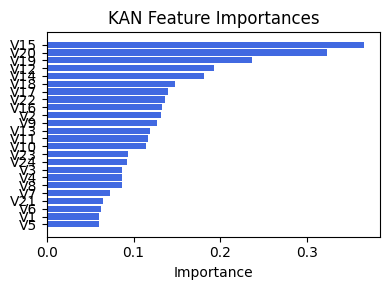

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V13', 0.2626563663862649), ('V11', 0.24615994615396297), ('V12', 0.23950442910938943), ('V8', 0.23894975928715712), ('V19', 0.23101531408895928), ('V18', 0.22726427291429538), ('V16', 0.2224316399979649), ('V14', 0.22047420133215687), ('V20', 0.22029670082369587), ('V17', 0.2172104055586445), ('V9', 0.20943543799595174), ('V7', 0.2029157614492344), ('V6', 0.19814820943454686), ('V15', 0.1971657918266152), ('V3', 0.19204871550688712), ('V2', 0.18172957198588008), ('V10', 0.17574212108990314), ('V1', 0.16198610204442598), ('V4', 0.1607915884092158), ('Ex1', 0.16039491936966035), ('V23', 0.1404226703300429), ('V24', 0.1358621000761246), ('V22', 0.12744543956313342), ('V5', 0.10361599494171969), ('V21', 0.07722135018055655)]


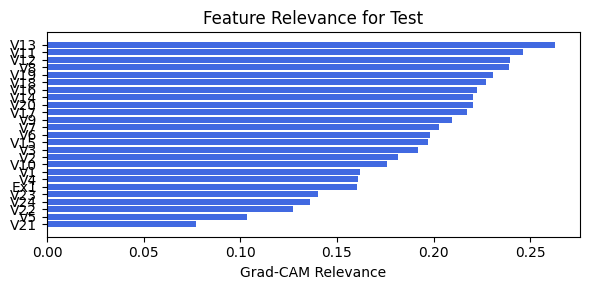

hidden_dim: 16
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


 train_acc_hybrid: 9.58e-01 | val_acc_hybrid: 9.29e-01 |: 100%|█████| 70/70 [03:21<00:00,  2.88s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.3127e-01 at 66 epoch
tensor(0.9258, device='cuda:0')
[[408  25   6   2]
 [ 15 399   3   3]
 [  1   6  59   0]
 [  2   4  14 145]]
M_KAN Relevance: 0.06215829402208328
CNN Relevance: 0.9378417134284973
[('V15', 0.33826062), ('V20', 0.31017536), ('V19', 0.26978824), ('V22', 0.17776404), ('V18', 0.17483044), ('V16', 0.15325579), ('V14', 0.1424735), ('V17', 0.13933632), ('V11', 0.12744683), ('V12', 0.12063867), ('V4', 0.10849066), ('V2', 0.102115355), ('V7', 0.10006486), ('V3', 0.09708201), ('V5', 0.09268358), ('V10', 0.08688961), ('V13', 0.08545296), ('V24', 0.08414842), ('V6', 0.074901596), ('V21', 0.06819609), ('V8', 0.0679795), ('V23', 0.063150495), ('V9', 0.058209457), ('V1', 0.04996608)]


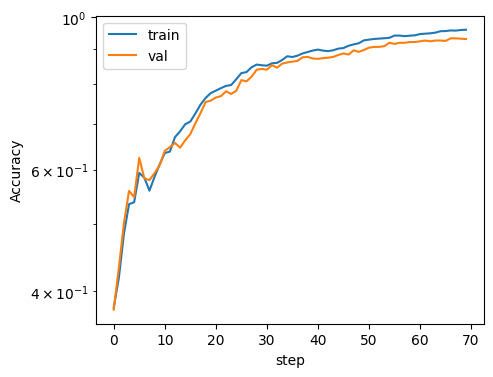

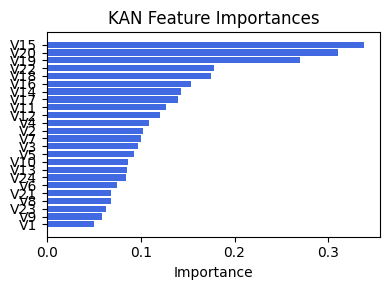

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V14', 0.5308921389034847), ('V19', 0.5008062782697167), ('V9', 0.4687849060046907), ('V13', 0.4225441172323275), ('V15', 0.3954284453309131), ('V20', 0.3903333634705685), ('V8', 0.36133678029663924), ('V18', 0.35356288898640076), ('V10', 0.3382508487669265), ('V17', 0.28149338238620997), ('V12', 0.2684275128123019), ('V7', 0.262289110630633), ('V3', 0.2518874680208283), ('V4', 0.24519652159604835), ('Ex1', 0.22030786097633068), ('V24', 0.21212107291371685), ('V5', 0.1987577938916496), ('V2', 0.17240050673953503), ('V23', 0.15265986903301088), ('V22', 0.12141796143291836), ('V21', 0.09033205726934414), ('V16', 0.08101627010679767), ('V1', 0.07018385190742644), ('V6', 0.06894752092901252), ('V11', 0.057674166358013354)]


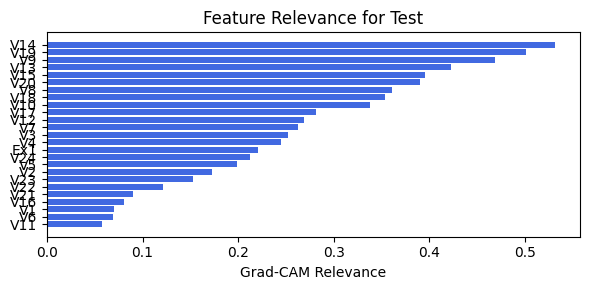

hidden_dim: 8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


 train_acc_hybrid: 9.98e-01 | val_acc_hybrid: 9.19e-01 |: 100%|█████| 70/70 [03:02<00:00,  2.60s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.3585e-01 at 36 epoch
tensor(0.9277, device='cuda:0')
[[410  22   6   3]
 [ 13 399   7   1]
 [  0   8  56   2]
 [  7   5   5 148]]
M_KAN Relevance: 0.044806718826293945
CNN Relevance: 0.955193281173706
[('V20', 0.2881082), ('V19', 0.25887078), ('V15', 0.24269584), ('V12', 0.18698363), ('V14', 0.18575686), ('V17', 0.17907736), ('V22', 0.17343983), ('V24', 0.16606955), ('V9', 0.15810004), ('V13', 0.1432616), ('V11', 0.14078145), ('V16', 0.12734592), ('V5', 0.121972576), ('V23', 0.12071325), ('V7', 0.11328827), ('V4', 0.1120408), ('V2', 0.10994609), ('V8', 0.100833505), ('V6', 0.09663909), ('V3', 0.09003313), ('V18', 0.088723324), ('V21', 0.08381021), ('V10', 0.082469985), ('V1', 0.07015923)]


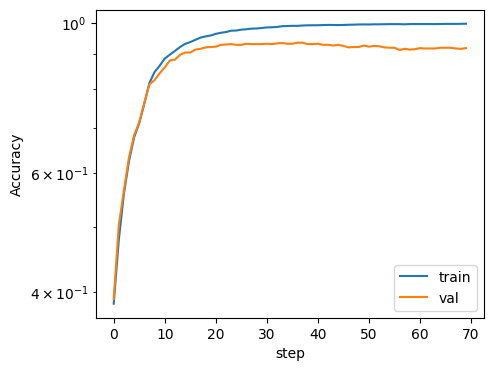

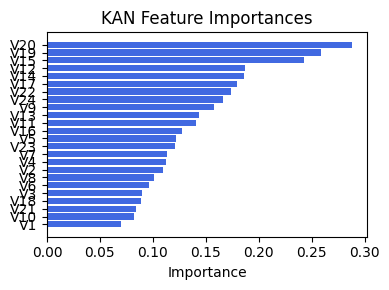

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V24', 0.31960272577572263), ('V23', 0.2794541731718143), ('V22', 0.2465516739355555), ('V14', 0.218863090876853), ('Ex1', 0.2174766342157341), ('V19', 0.21674656429675138), ('V13', 0.21128579771449796), ('V9', 0.19894757888735282), ('V18', 0.19306175693342523), ('V8', 0.18939577917056244), ('V17', 0.18632926975377756), ('V12', 0.1856282626811016), ('V7', 0.1725036669394695), ('V4', 0.1615239059925783), ('V3', 0.15231854612013707), ('V20', 0.14454593656959025), ('V2', 0.1399018627271289), ('V10', 0.13929827726596303), ('V21', 0.13238044865438797), ('V5', 0.12547952945751537), ('V15', 0.11838871660413947), ('V16', 0.09964657861840955), ('V11', 0.09901362066056035), ('V1', 0.09043112019002691), ('V6', 0.08926504454492525)]


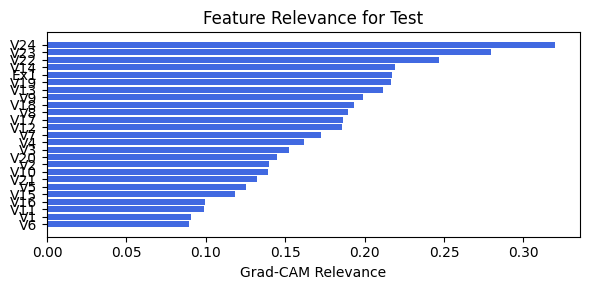

In [54]:
for hidden_dim in [128, 64, 32, 16, 8]:
    print(f"hidden_dim: {hidden_dim}")
    train_and_plot_relevance(Model3_3, kan_neurons=6, kan_grid=7, lamb=1e-05, steps=70, 
                             hidden_dim=hidden_dim, filename=filename_3, opt_col_val=hidden_dim)

## 3.2. width=[24, 11], grid=3, lamb=0.001

hidden_dim: 128
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


 train_acc_hybrid: 9.91e-01 | val_acc_hybrid: 9.37e-01 |: 100%|█████| 80/80 [04:09<00:00,  3.12s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.4387e-01 at 27 epoch
tensor(0.9185, device='cuda:0')
[[410  29   1   1]
 [ 11 403   3   3]
 [  0   8  56   2]
 [  1   4  26 134]]
M_KAN Relevance: 0.23292212188243866
CNN Relevance: 0.7670778632164001
[('V15', 0.36492583), ('V20', 0.22679074), ('V19', 0.20115958), ('V16', 0.18703358), ('V11', 0.17004128), ('V12', 0.15324473), ('V14', 0.1477131), ('V5', 0.13421321), ('V22', 0.11572905), ('V18', 0.108441554), ('V10', 0.10531522), ('V3', 0.09476861), ('V17', 0.09378775), ('V21', 0.0859969), ('V24', 0.08250549), ('V2', 0.079599835), ('V7', 0.07825693), ('V1', 0.07184828), ('V8', 0.071751796), ('V9', 0.07097776), ('V4', 0.06877919), ('V6', 0.0685912), ('V13', 0.06780465), ('V23', 0.058345478)]


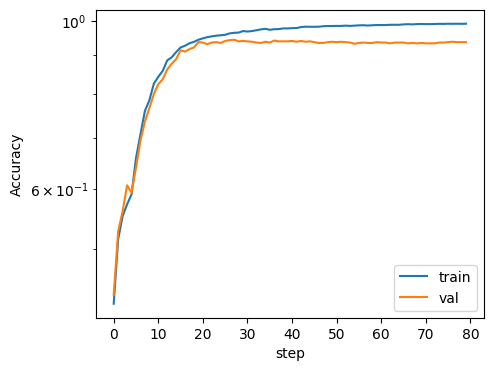

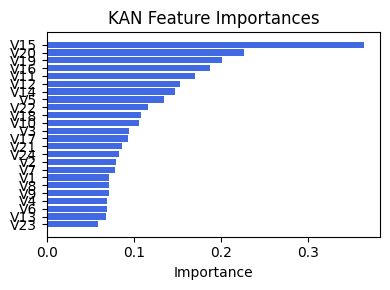

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V24', 0.36584631733556294), ('V23', 0.32784412373940464), ('V19', 0.30705954062288365), ('V21', 0.30638984795596347), ('V18', 0.2920625190125418), ('V17', 0.28894294730305325), ('V11', 0.282554492164885), ('V16', 0.28078784715557376), ('V8', 0.27308497496073786), ('V3', 0.26885994953487574), ('V22', 0.2684758473119456), ('V13', 0.2546439073761736), ('V2', 0.25255298721169106), ('V4', 0.2453447203033814), ('V7', 0.24317628918565903), ('V9', 0.2405106093455831), ('V12', 0.23150484307350133), ('V14', 0.21832451675332518), ('V6', 0.21607736226042024), ('Ex1', 0.18356755591836296), ('V1', 0.17677236972913649), ('V10', 0.1734000235887817), ('V5', 0.1582332697242623), ('V20', 0.1417011476542929), ('V15', 0.1254103844489108)]


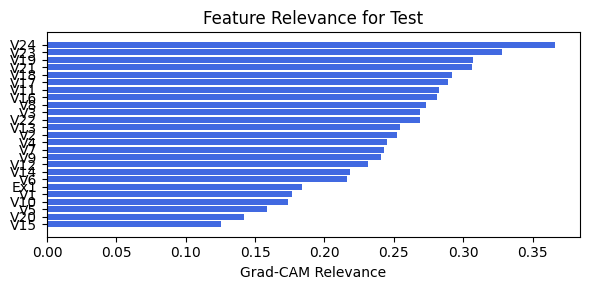

hidden_dim: 64
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


 train_acc_hybrid: 9.93e-01 | val_acc_hybrid: 9.46e-01 |: 100%|█████| 80/80 [03:56<00:00,  2.95s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.4845e-01 at 75 epoch
tensor(0.9386, device='cuda:0')
[[414  19   4   4]
 [  8 407   4   1]
 [  0   4  61   1]
 [  1   8  13 143]]
M_KAN Relevance: 0.2949928641319275
CNN Relevance: 0.7050071954727173
[('V15', 0.28684798), ('V20', 0.2358561), ('V19', 0.23141955), ('V14', 0.18542042), ('V11', 0.15933031), ('V22', 0.1563574), ('V21', 0.15632483), ('V18', 0.14854777), ('V4', 0.1466217), ('V24', 0.13813174), ('V16', 0.13196754), ('V6', 0.12622207), ('V9', 0.1223395), ('V2', 0.11911478), ('V13', 0.11493745), ('V10', 0.10934486), ('V12', 0.10934084), ('V23', 0.10452151), ('V17', 0.103648104), ('V7', 0.10171763), ('V1', 0.093060665), ('V8', 0.086133495), ('V5', 0.08255239), ('V3', 0.0693138)]


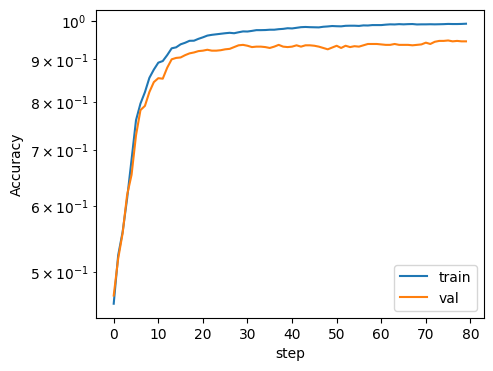

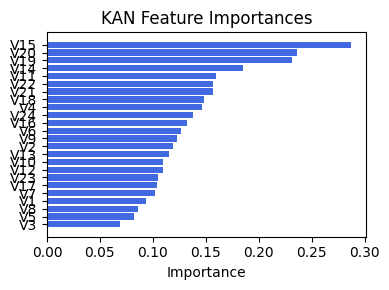

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V18', 0.44185258494903273), ('V19', 0.42257871484711385), ('V13', 0.3989071175531738), ('V17', 0.397500900661056), ('V14', 0.3835079157888086), ('V24', 0.3279396705369929), ('V12', 0.32588881711158285), ('V23', 0.31758950781701867), ('V8', 0.30821761113938817), ('V7', 0.2795177583638988), ('V16', 0.27746187569648145), ('V22', 0.2768085130642065), ('V9', 0.2746670890329026), ('V11', 0.23334205406941833), ('Ex1', 0.2017908137715541), ('V6', 0.20003342685018258), ('V21', 0.16692207730972233), ('V1', 0.14339176230320208), ('V20', 0.14214667833067782), ('V2', 0.12127024774952841), ('V15', 0.12081339874057714), ('V3', 0.11300275714240389), ('V4', 0.09089445521494248), ('V10', 0.08736350481879629), ('V5', 0.04934584372131545)]


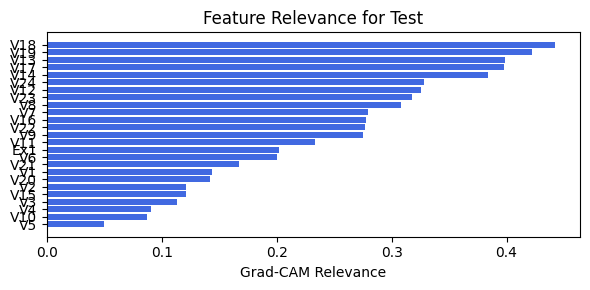

hidden_dim: 32
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


 train_acc_hybrid: 9.94e-01 | val_acc_hybrid: 9.40e-01 |: 100%|█████| 80/80 [03:53<00:00,  2.92s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.5074e-01 at 58 epoch
tensor(0.9350, device='cuda:0')
[[412  21   7   1]
 [  7 411   0   2]
 [  0   6  58   2]
 [  4   4  17 140]]
M_KAN Relevance: 0.3342369794845581
CNN Relevance: 0.6657630205154419
[('V15', 0.3379248), ('V20', 0.23460217), ('V19', 0.1996758), ('V22', 0.15283881), ('V10', 0.14765222), ('V21', 0.14764434), ('V14', 0.14200094), ('V9', 0.13997875), ('V16', 0.1378558), ('V6', 0.1374393), ('V23', 0.12791967), ('V13', 0.12511615), ('V17', 0.1187124), ('V11', 0.11653795), ('V4', 0.114437096), ('V24', 0.10882511), ('V12', 0.10487576), ('V5', 0.104566805), ('V7', 0.10273447), ('V18', 0.099363595), ('V8', 0.09270306), ('V3', 0.08909811), ('V1', 0.08077713), ('V2', 0.07568545)]


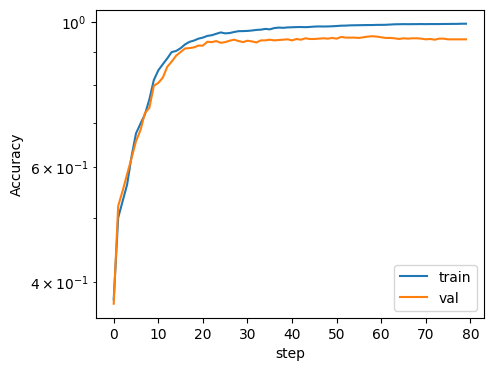

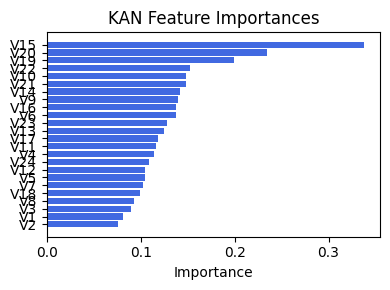

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V19', 0.3419666900282432), ('V18', 0.3189229504240867), ('V14', 0.3176566720373554), ('V13', 0.31366347483751167), ('V24', 0.2947145614255136), ('V16', 0.2930975707905208), ('V23', 0.28397135146405406), ('V17', 0.2832348134529239), ('V22', 0.2621005970081436), ('V11', 0.25695513177874385), ('V12', 0.25131761582307954), ('V8', 0.2292713075560145), ('V9', 0.2277860476954366), ('V6', 0.20497169236867047), ('V7', 0.2012631917038025), ('V21', 0.16372594148065167), ('V1', 0.15085506451959235), ('V20', 0.14385326697248899), ('V15', 0.1380273453805085), ('Ex1', 0.1180986962604188), ('V2', 0.11724380744118663), ('V10', 0.11143585706540161), ('V3', 0.11038786201209075), ('V4', 0.08373587608728972), ('V5', 0.05858157730422852)]


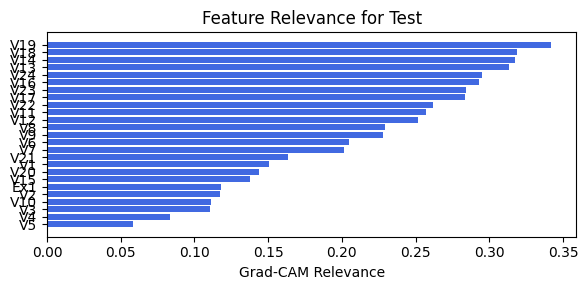

hidden_dim: 16
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


 train_acc_hybrid: 9.94e-01 | val_acc_hybrid: 9.36e-01 |: 100%|█████| 80/80 [04:06<00:00,  3.08s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.4960e-01 at 26 epoch
tensor(0.9258, device='cuda:0')
[[407  27   6   1]
 [ 10 406   3   1]
 [  0   6  56   4]
 [  1   4  18 142]]
M_KAN Relevance: 0.23305587470531464
CNN Relevance: 0.7669441103935242
[('V15', 0.45993668), ('V19', 0.21879736), ('V12', 0.20594826), ('V20', 0.19266835), ('V14', 0.13990642), ('V6', 0.13216555), ('V4', 0.117482975), ('V16', 0.110179245), ('V18', 0.10905111), ('V11', 0.10702457), ('V17', 0.098823324), ('V22', 0.097677566), ('V9', 0.09534135), ('V21', 0.0929905), ('V3', 0.08223038), ('V13', 0.0757342), ('V2', 0.06795335), ('V10', 0.06766916), ('V5', 0.067058764), ('V23', 0.06650368), ('V24', 0.06459157), ('V7', 0.059146173), ('V8', 0.049002822), ('V1', 0.03744204)]


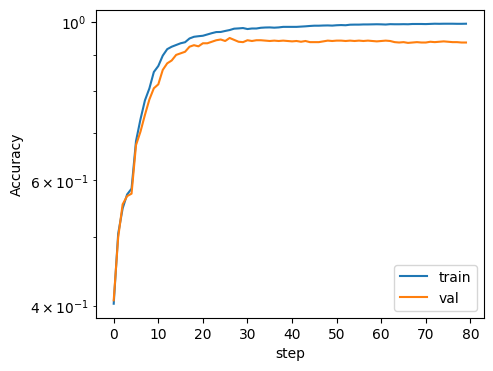

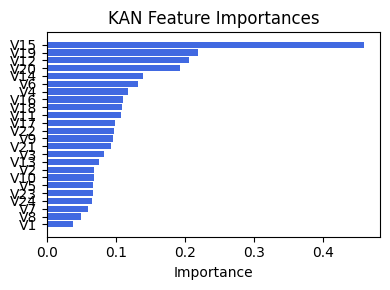

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V22', 0.27184140548380653), ('V24', 0.2703508081006845), ('V19', 0.2536017442797566), ('V23', 0.24671184491758358), ('V18', 0.2302714914402024), ('V17', 0.23020428097044096), ('V4', 0.22903303104295036), ('V3', 0.2247769607514277), ('V16', 0.2231185985570353), ('V2', 0.21371724343712714), ('V13', 0.21171170557691757), ('V8', 0.2108319680891004), ('V14', 0.2073668044852242), ('V12', 0.20168348664773952), ('V7', 0.19925779723558035), ('V9', 0.19201878642284584), ('V11', 0.19122762715832134), ('V21', 0.18079632637808415), ('V6', 0.16946585083540733), ('Ex1', 0.1604135563250369), ('V20', 0.11824774282866954), ('V15', 0.11769280252559132), ('V5', 0.10164647215662873), ('V1', 0.09919654304157297), ('V10', 0.09363293021548695)]


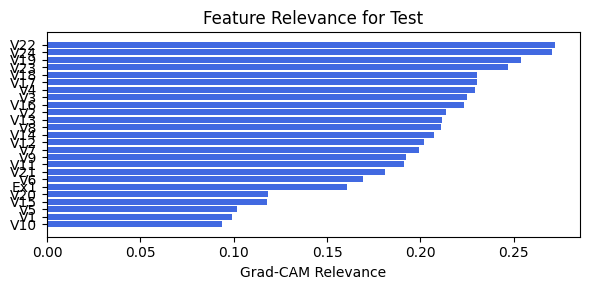

hidden_dim: 8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


 train_acc_hybrid: 9.95e-01 | val_acc_hybrid: 9.58e-01 |: 100%|█████| 80/80 [03:58<00:00,  2.98s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.5876e-01 at 78 epoch
tensor(0.9496, device='cuda:0')
[[413  17  10   1]
 [  6 411   2   1]
 [  1   5  60   0]
 [  3   6   3 153]]
M_KAN Relevance: 0.33946493268013
CNN Relevance: 0.6605350375175476
[('V15', 0.41045544), ('V20', 0.2629009), ('V19', 0.21540788), ('V10', 0.18360375), ('V4', 0.16161658), ('V16', 0.15602075), ('V22', 0.14405753), ('V7', 0.1367306), ('V14', 0.12918912), ('V12', 0.12288274), ('V11', 0.116059), ('V5', 0.115366496), ('V17', 0.10822286), ('V24', 0.10530265), ('V18', 0.09684213), ('V9', 0.09167881), ('V23', 0.08066624), ('V1', 0.07622485), ('V3', 0.075309426), ('V6', 0.07482773), ('V13', 0.07357344), ('V21', 0.066020615), ('V2', 0.06570839), ('V8', 0.06496953)]


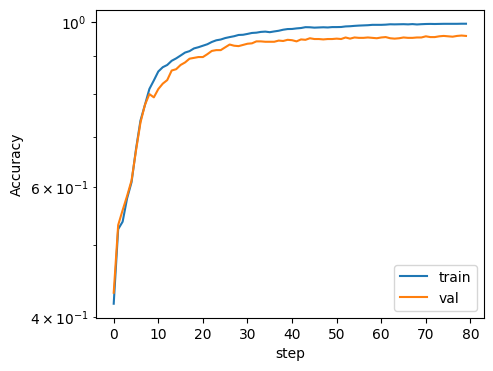

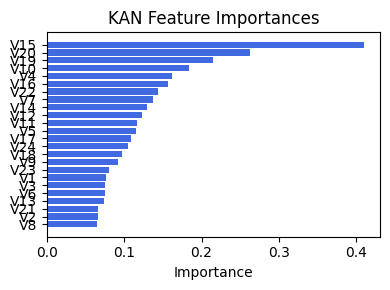

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V19', 0.3902317264041396), ('V18', 0.3884841794490937), ('V14', 0.36410058303539994), ('V24', 0.34567965284858115), ('V23', 0.3389616860982415), ('V13', 0.33780012849352453), ('V17', 0.3249075522195572), ('V22', 0.30524917853509603), ('V12', 0.2797563030761498), ('V8', 0.25988963570112306), ('V21', 0.2497930817558488), ('V9', 0.24563004791341037), ('V20', 0.24212490227423103), ('V15', 0.24179448716694468), ('V7', 0.21294934851479472), ('V16', 0.21064886634484115), ('V11', 0.2084613048440381), ('V10', 0.18129020901362755), ('Ex1', 0.17954993640347852), ('V6', 0.15546307215629565), ('V5', 0.12437096958083381), ('V3', 0.12413805219859282), ('V4', 0.10529815286314834), ('V2', 0.09811854924445747), ('V1', 0.07626244849729412)]


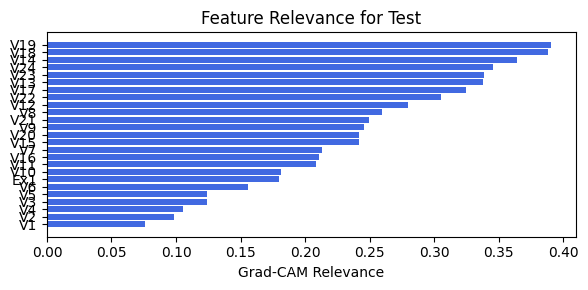

In [53]:
for hidden_dim in [128, 64, 32, 16, 8]:
    print(f"hidden_dim: {hidden_dim}")
    train_and_plot_relevance(Model3_3, kan_neurons=11, kan_grid=3, lamb=0.001, steps=80, 
                             hidden_dim=hidden_dim, filename=filename_3, opt_col_val=hidden_dim)

## 3.3. width=[24, 7], grid=3, lamb=0.001

hidden_dim: 128
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


 train_acc_hybrid: 9.98e-01 | val_acc_hybrid: 9.48e-01 |: 100%|█████| 80/80 [03:42<00:00,  2.78s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.4845e-01 at 77 epoch
tensor(0.9405, device='cuda:0')
[[413  17   6   5]
 [  8 408   4   0]
 [  0   5  61   0]
 [  5   5  10 145]]
M_KAN Relevance: 0.3688656985759735
CNN Relevance: 0.6311343312263489
[('V15', 0.542263), ('V19', 0.18835276), ('V20', 0.18452756), ('V14', 0.16342407), ('V11', 0.15292872), ('V12', 0.119173706), ('V3', 0.1105765), ('V9', 0.10320656), ('V4', 0.10290367), ('V6', 0.09789926), ('V5', 0.09576141), ('V7', 0.0950822), ('V13', 0.094697945), ('V24', 0.09283425), ('V16', 0.088594414), ('V23', 0.08832325), ('V18', 0.08202692), ('V10', 0.08136418), ('V1', 0.07756437), ('V22', 0.07376772), ('V21', 0.07016746), ('V2', 0.0660237), ('V8', 0.059721), ('V17', 0.054988574)]


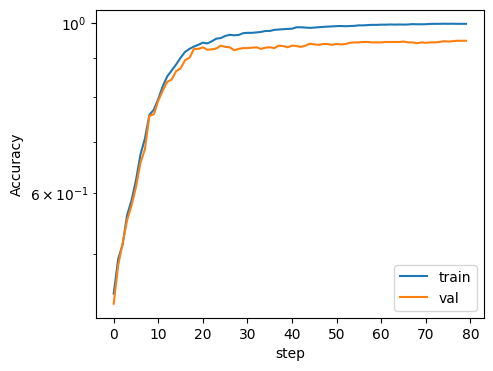

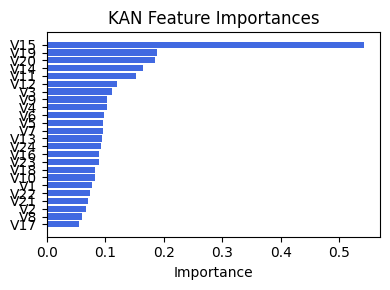

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V13', 0.2827175754581274), ('V12', 0.2445056363302993), ('V8', 0.23988208057138824), ('V18', 0.23495024076625431), ('V14', 0.22971521879140383), ('V19', 0.22746824057864012), ('V17', 0.2225254254511365), ('V16', 0.209916905632721), ('V9', 0.2078190424893001), ('V21', 0.19956728333472512), ('V7', 0.1983545320315085), ('V15', 0.1968305868921205), ('V10', 0.19589438876933496), ('V20', 0.18787638185387598), ('V5', 0.18711432878554551), ('V3', 0.17534806745396506), ('V11', 0.17089868541666214), ('V24', 0.1660925394672288), ('V4', 0.1551384123202517), ('Ex1', 0.15087329648326803), ('V6', 0.1405473394281896), ('V23', 0.13342399315465278), ('V2', 0.1325189460044368), ('V22', 0.121961604650659), ('V1', 0.12151740453097086)]


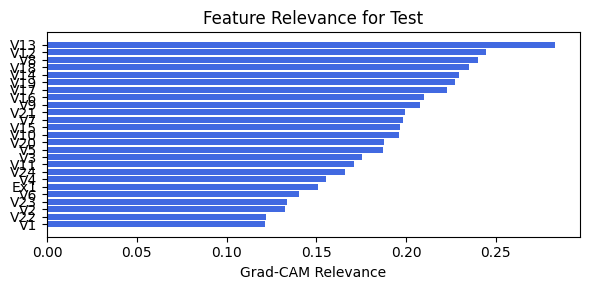

hidden_dim: 64
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


 train_acc_hybrid: 9.97e-01 | val_acc_hybrid: 9.52e-01 |: 100%|█████| 80/80 [03:41<00:00,  2.77s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.5533e-01 at 72 epoch
tensor(0.9405, device='cuda:0')
[[414  17   6   4]
 [  9 407   4   0]
 [  1   5  59   1]
 [  5   6   7 147]]
M_KAN Relevance: 0.37410423159599304
CNN Relevance: 0.6258957386016846
[('V15', 0.5061231), ('V20', 0.2047816), ('V19', 0.16882214), ('V14', 0.15083547), ('V18', 0.14423244), ('V16', 0.12736835), ('V12', 0.104296945), ('V10', 0.10250902), ('V13', 0.10013779), ('V11', 0.09673369), ('V2', 0.095519006), ('V7', 0.08430931), ('V22', 0.08351857), ('V24', 0.082398735), ('V17', 0.082348526), ('V4', 0.08111176), ('V8', 0.07621858), ('V6', 0.07456441), ('V23', 0.07334937), ('V9', 0.06659308), ('V5', 0.06380603), ('V3', 0.06264666), ('V21', 0.051495954), ('V1', 0.040240422)]


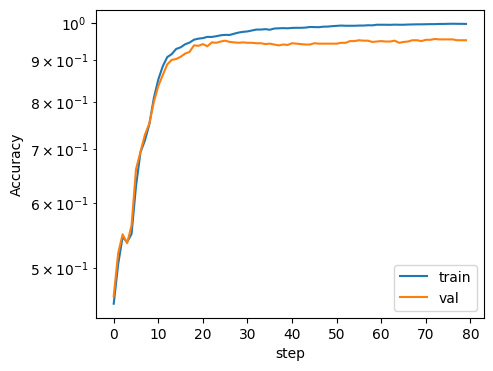

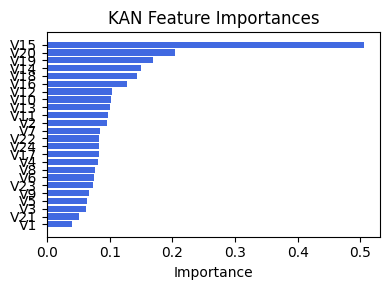

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V19', 0.3054257092262693), ('V14', 0.2977069547827001), ('V16', 0.28730996005064824), ('V24', 0.27385295852493585), ('Ex1', 0.2724594071289655), ('V21', 0.25792819912773096), ('V22', 0.2500705487234935), ('V18', 0.24840946328329885), ('V20', 0.24423639241379136), ('V17', 0.24399057141768077), ('V11', 0.23960767433099744), ('V23', 0.2387886086216895), ('V13', 0.23699380914064896), ('V12', 0.22657516488917137), ('V15', 0.22654525887908397), ('V9', 0.2062470447208764), ('V8', 0.19901297844218468), ('V6', 0.1969729570515023), ('V7', 0.17503373255028534), ('V10', 0.15170379132761588), ('V2', 0.12510411578417976), ('V3', 0.11298792629882956), ('V4', 0.11283091594791403), ('V1', 0.0894990754892612), ('V5', 0.07924775927808746)]


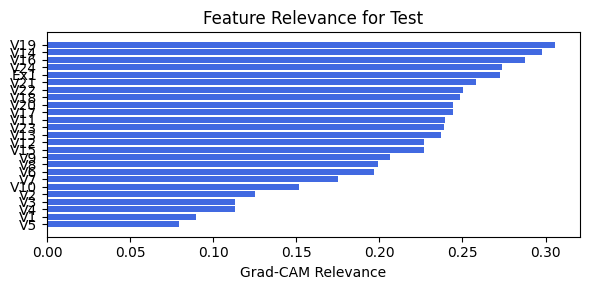

hidden_dim: 32
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


 train_acc_hybrid: 9.91e-01 | val_acc_hybrid: 9.42e-01 |: 100%|█████| 80/80 [03:49<00:00,  2.87s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.4273e-01 at 53 epoch
tensor(0.9350, device='cuda:0')
[[412  21   7   1]
 [  7 409   4   0]
 [  0   7  57   2]
 [  2   6  14 143]]
M_KAN Relevance: 0.31720077991485596
CNN Relevance: 0.682799220085144
[('V15', 0.46822345), ('V20', 0.18388996), ('V24', 0.1683276), ('V19', 0.16478817), ('V14', 0.14573222), ('V22', 0.14509182), ('V18', 0.1288672), ('V7', 0.12817487), ('V2', 0.12540577), ('V23', 0.11810885), ('V9', 0.11216551), ('V11', 0.104562126), ('V13', 0.10014419), ('V12', 0.09956912), ('V17', 0.09044063), ('V3', 0.08502984), ('V16', 0.084921986), ('V4', 0.07917207), ('V10', 0.06672677), ('V21', 0.058546793), ('V6', 0.058468126), ('V5', 0.05291055), ('V8', 0.047715124), ('V1', 0.041589916)]


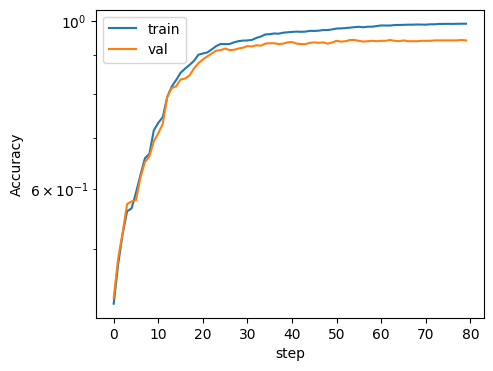

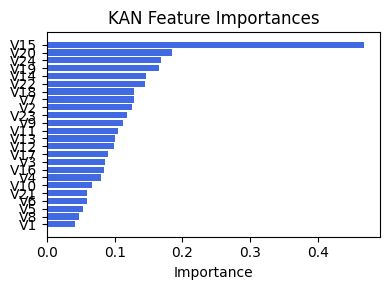

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V18', 0.3185308741868029), ('V19', 0.30620835808633684), ('V24', 0.29100215639309246), ('V13', 0.28300292066324756), ('V23', 0.2822752708916729), ('V17', 0.26463191692366955), ('V14', 0.2626181563948074), ('V22', 0.2609354916025467), ('V12', 0.22688425800186537), ('V8', 0.2189887897318294), ('V20', 0.21416911048183113), ('V9', 0.20745808644939406), ('V16', 0.18770436949938607), ('V7', 0.18046978946981804), ('V15', 0.18037524193439175), ('V21', 0.1569140296022795), ('V10', 0.1516451389528438), ('Ex1', 0.14452841268585195), ('V11', 0.13914635540693002), ('V3', 0.12348709897660129), ('V6', 0.11849544728254108), ('V4', 0.100621025892706), ('V2', 0.09867203301160478), ('V5', 0.07378981986176025), ('V1', 0.06594425958170617)]


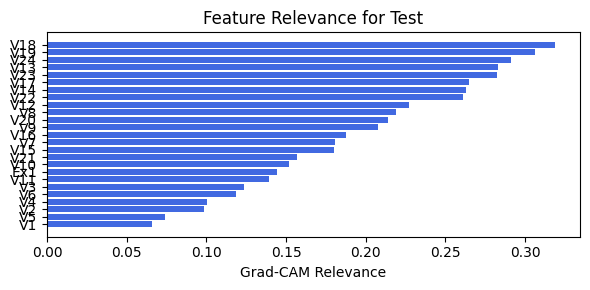

hidden_dim: 16
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


 train_acc_hybrid: 9.95e-01 | val_acc_hybrid: 9.55e-01 |: 100%|█████| 80/80 [03:44<00:00,  2.81s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.5762e-01 at 70 epoch
tensor(0.9322, device='cuda:0')
[[415  18   5   3]
 [  9 404   5   2]
 [  0   4  59   3]
 [  6   6  13 140]]
M_KAN Relevance: 0.3321703374385834
CNN Relevance: 0.667829692363739
[('V15', 0.49419802), ('V20', 0.25980344), ('V19', 0.2019316), ('V13', 0.15888071), ('V9', 0.1539615), ('V14', 0.15377763), ('V10', 0.13447864), ('V18', 0.12808357), ('V3', 0.11775932), ('V22', 0.106079005), ('V4', 0.10574716), ('V11', 0.10475234), ('V5', 0.10011291), ('V7', 0.095168844), ('V6', 0.09044853), ('V12', 0.09035948), ('V23', 0.08847713), ('V24', 0.08684548), ('V17', 0.07962775), ('V8', 0.06548935), ('V16', 0.06392532), ('V21', 0.06268668), ('V1', 0.05755307), ('V2', 0.057010453)]


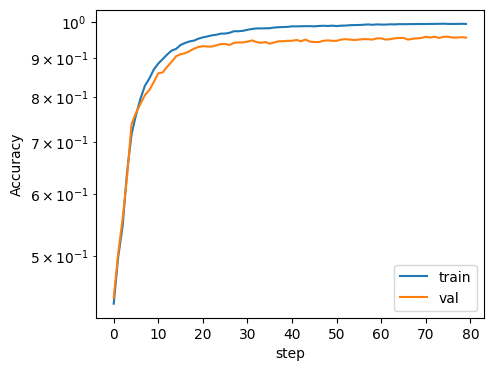

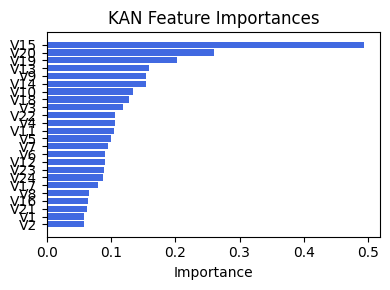

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V18', 0.3642961892530479), ('V19', 0.3236056835802222), ('V13', 0.31604494220016854), ('V14', 0.3058986732985265), ('V17', 0.2929475925807993), ('V23', 0.2621933577455164), ('V16', 0.25830004048118393), ('V12', 0.24704279880731916), ('V24', 0.243086710152396), ('V22', 0.24255726323889454), ('V11', 0.21078453418750132), ('V7', 0.2101533820327942), ('V8', 0.20868405730219647), ('V9', 0.2064976145512503), ('V6', 0.2011954893525079), ('V1', 0.17949486784056182), ('V2', 0.17092525505056436), ('V15', 0.16879965951039383), ('V20', 0.1674266988333989), ('V10', 0.14915900484888198), ('V21', 0.14475207992630773), ('V3', 0.12828007867225202), ('Ex1', 0.0854977330638456), ('V4', 0.08518640793263596), ('V5', 0.07741046411747081)]


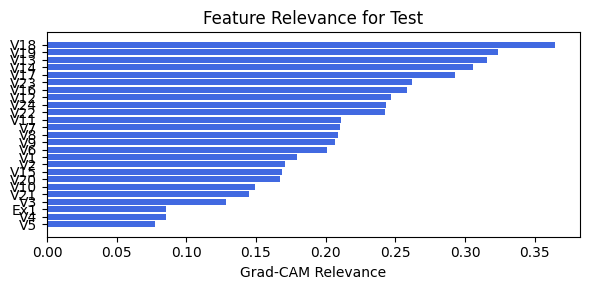

hidden_dim: 8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_3


 train_acc_hybrid: 9.96e-01 | val_acc_hybrid: 9.38e-01 |: 100%|█████| 80/80 [03:40<00:00,  2.75s/it]


saving model version 0.1
✅ Best validation Accuracy: 9.4158e-01 at 74 epoch
tensor(0.9359, device='cuda:0')
[[412  23   5   1]
 [  9 405   5   1]
 [  0   5  60   1]
 [  4   6  10 145]]
M_KAN Relevance: 0.41290825605392456
CNN Relevance: 0.5870917439460754
[('V15', 0.33475378), ('V20', 0.267004), ('V14', 0.1900413), ('V13', 0.18952401), ('V19', 0.17994994), ('V18', 0.1766168), ('V7', 0.16108863), ('V23', 0.13605289), ('V24', 0.13180454), ('V22', 0.13005629), ('V17', 0.12027521), ('V16', 0.10780381), ('V12', 0.10746566), ('V11', 0.106274195), ('V9', 0.10603994), ('V4', 0.105183974), ('V2', 0.103357375), ('V10', 0.09847431), ('V8', 0.0930865), ('V6', 0.091107585), ('V5', 0.08267611), ('V21', 0.07964875), ('V3', 0.078875355), ('V1', 0.05139583)]


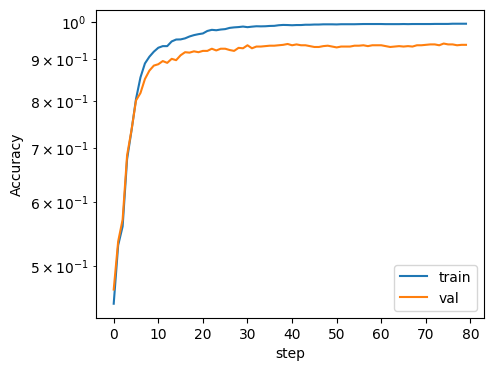

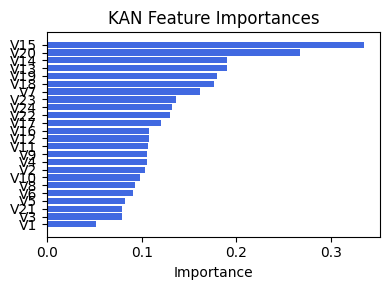

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V20', 0.2843359467681497), ('V24', 0.282888765389327), ('V15', 0.282496244161465), ('V19', 0.24934003576307964), ('V10', 0.24530410312112735), ('V23', 0.24517552327435604), ('V13', 0.22653205271892593), ('V14', 0.22638972750649575), ('V18', 0.22574405111157123), ('V22', 0.2243629995866499), ('V17', 0.22227492195530837), ('V12', 0.21867148502059913), ('V8', 0.19295236662004847), ('V7', 0.18421814125457664), ('V9', 0.18184833085065177), ('V3', 0.1776937065158883), ('V16', 0.1685764032707204), ('V5', 0.1682682361034751), ('V11', 0.1532334693749209), ('Ex1', 0.15177901420356782), ('V2', 0.148030465706304), ('V4', 0.14198464773231775), ('V6', 0.13013023704123763), ('V21', 0.12183621460402112), ('V1', 0.09972003257484335)]


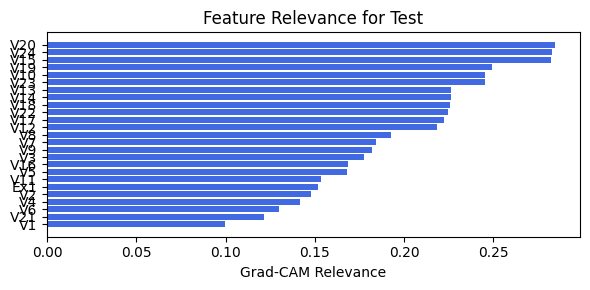

In [52]:
for hidden_dim in [128, 64, 32, 16, 8]:
    print(f"hidden_dim: {hidden_dim}")
    train_and_plot_relevance(Model3_3, kan_neurons=7, kan_grid=3, lamb=0.001, steps=80, 
                             hidden_dim=hidden_dim, filename=filename_3, opt_col_val=hidden_dim)

# Opt4: MultiHead Attention

In [44]:
create_csv_with_header(filename_4, columns_opt4)

## 4.0. width=[24, 12], grid=8, lamb=0.001

embed_dim: 64, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 8.79e-01 | val_acc_hybrid: 8.22e-01 |: 100%|███| 110/110 [00:49<00:00,  2.21it/s]


saving model version 0.1
✅ Best validation Accuracy: 8.2245e-01 at 108 epoch
tensor(0.8324, device='cuda:0')
[[369  57   5  10]
 [ 21 384  10   5]
 [  1  23  33   9]
 [  9  17  16 123]]
M_KAN Relevance: 0.05070925131440163
CNN Relevance: 0.9492907524108887
[('V7', 0.23542532), ('V13', 0.19140574), ('V4', 0.18066041), ('V19', 0.17927086), ('V22', 0.17671679), ('V10', 0.16738336), ('V15', 0.137362), ('V14', 0.12316036), ('V6', 0.12273818), ('V17', 0.12196293), ('V12', 0.11056974), ('V18', 0.10866052), ('V21', 0.09480193), ('V23', 0.09451543), ('V11', 0.07950306), ('V24', 0.07043381), ('V20', 0.06644409), ('V1', 0.06487728), ('V9', 0.06457212), ('V5', 0.0577258), ('V16', 0.056958), ('V2', 0.054105982), ('V8', 0.04607314), ('V3', 0.039495595)]


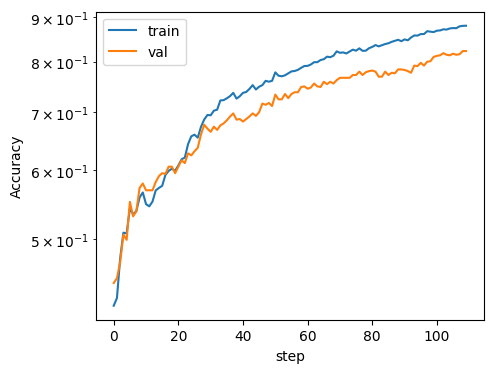

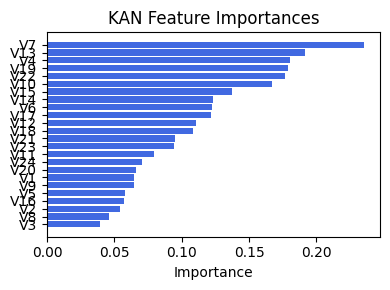

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V14', 0.5240891817905992), ('V19', 0.5098990046315475), ('V13', 0.46177788386070223), ('V18', 0.4552928235646441), ('V8', 0.40675193961394873), ('V9', 0.4000931843872619), ('V17', 0.3946324767133601), ('V12', 0.37100677868379484), ('V24', 0.32455647080427125), ('V7', 0.32238901029530687), ('V20', 0.2913800949904176), ('V23', 0.2742632600711392), ('V22', 0.2464321170343579), ('V15', 0.23707161296315196), ('V10', 0.1967836587445206), ('V3', 0.17537570322147675), ('V2', 0.1699457306368282), ('V11', 0.150956019222523), ('Ex1', 0.15084531922370958), ('V16', 0.14818927521921382), ('V4', 0.1326876564828539), ('V6', 0.12233468739265975), ('V1', 0.10468956986820864), ('V21', 0.07410771784927733), ('V5', 0.05150283828259443)]


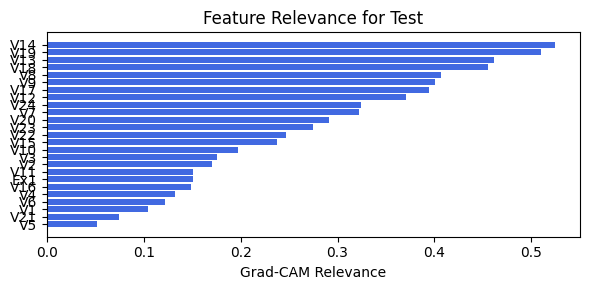

embed_dim: 64, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.26e-01 | val_acc_hybrid: 8.38e-01 |: 100%|███| 110/110 [00:47<00:00,  2.33it/s]


saving model version 0.1
✅ Best validation Accuracy: 8.3849e-01 at 109 epoch
tensor(0.8416, device='cuda:0')
[[379  50   9   3]
 [ 21 386  12   1]
 [  2  23  35   6]
 [  7  11  28 119]]
M_KAN Relevance: 0.09718053042888641
CNN Relevance: 0.9028194546699524
[('V7', 0.23677364), ('V12', 0.21233639), ('V10', 0.20239076), ('V22', 0.19969873), ('V13', 0.16382216), ('V19', 0.15301234), ('V21', 0.15007123), ('V18', 0.13519709), ('V4', 0.13302511), ('V15', 0.13265038), ('V1', 0.13025483), ('V20', 0.108177364), ('V14', 0.10734217), ('V24', 0.105955616), ('V17', 0.09673607), ('V11', 0.0958277), ('V16', 0.095132604), ('V6', 0.09175738), ('V3', 0.08110191), ('V23', 0.07702744), ('V5', 0.073276505), ('V2', 0.06787993), ('V9', 0.047705323), ('V8', 0.042713344)]


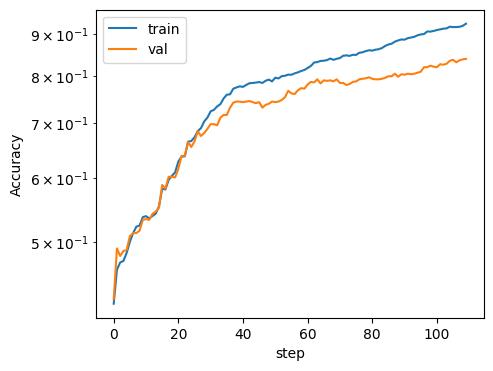

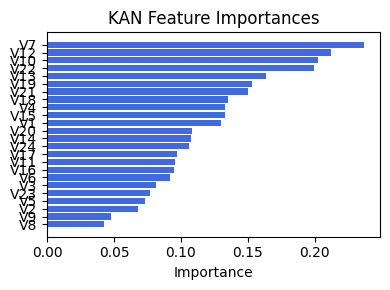

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V14', 0.423848053520194), ('V13', 0.41410345134270743), ('V8', 0.3879551115452616), ('V19', 0.38552669820560387), ('V18', 0.3607663818474709), ('V9', 0.3515594640693662), ('V12', 0.3217646033953425), ('V20', 0.3089698055838388), ('V17', 0.30416125260189436), ('V15', 0.2859727682851558), ('V7', 0.27785284719265535), ('V10', 0.2705692152113499), ('V3', 0.21285780002243626), ('V24', 0.19619452091756634), ('V16', 0.1902235514999686), ('V4', 0.1817764957427327), ('V2', 0.17754144710411993), ('V23', 0.16808721315539563), ('V21', 0.16152028810040645), ('V11', 0.1564661333695201), ('Ex1', 0.15252870277863256), ('V22', 0.1504903967665946), ('V6', 0.1415565755610876), ('V5', 0.13159480129698586), ('V1', 0.10762763415711823)]


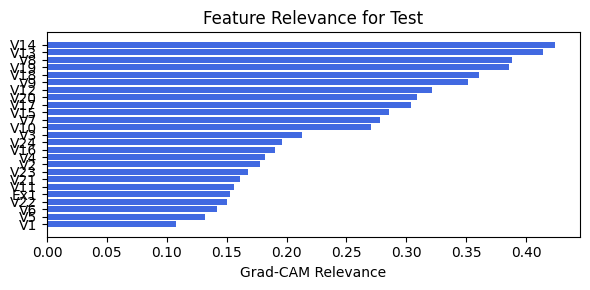

embed_dim: 64, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 8.44e-01 | val_acc_hybrid: 8.00e-01 |: 100%|███| 110/110 [00:48<00:00,  2.25it/s]


saving model version 0.1
✅ Best validation Accuracy: 8.0183e-01 at 101 epoch
tensor(0.7921, device='cuda:0')
[[338  90   9   4]
 [ 25 381   9   5]
 [  7  17  37   5]
 [  7  12  37 109]]
M_KAN Relevance: 0.003557168645784259
CNN Relevance: 0.9964428544044495
[('V12', 0.26762253), ('V22', 0.2371957), ('V4', 0.23455846), ('V19', 0.18826923), ('V15', 0.18296716), ('V10', 0.17924283), ('V21', 0.1658194), ('V14', 0.15931666), ('V1', 0.15109679), ('V5', 0.14118361), ('V7', 0.13812505), ('V23', 0.13552281), ('V18', 0.13534103), ('V16', 0.13260478), ('V9', 0.12564033), ('V13', 0.12540965), ('V3', 0.10403976), ('V8', 0.103348844), ('V20', 0.10105753), ('V11', 0.09664719), ('V24', 0.090168476), ('V6', 0.08531979), ('V2', 0.0761382), ('V17', 0.06588015)]


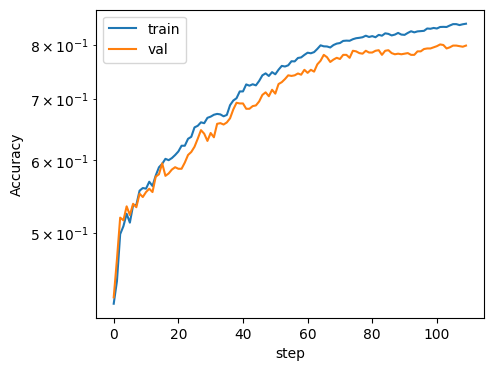

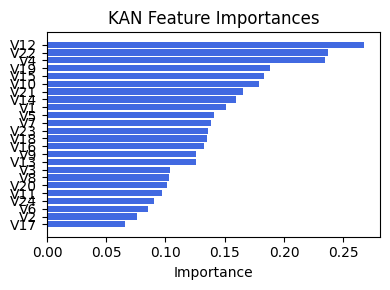

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V13', 0.5150804085724803), ('V18', 0.4712515886134857), ('V8', 0.47057073783801506), ('V14', 0.4598177270759102), ('V19', 0.42260523041429454), ('V9', 0.41077177478414156), ('V20', 0.39936965298898613), ('V10', 0.3862101616398235), ('V15', 0.38133536493317216), ('V17', 0.37058227543481165), ('V12', 0.3537803680259718), ('V7', 0.32877400496104886), ('V3', 0.23760755397785574), ('V16', 0.23711859847515124), ('V11', 0.21850911804061307), ('V24', 0.19366511880060241), ('V6', 0.1849316891803894), ('V4', 0.1791994866500664), ('V23', 0.17281350157351144), ('V2', 0.16120993451189422), ('V5', 0.14816862716968351), ('Ex1', 0.14113119127200713), ('V22', 0.13877522282657595), ('V21', 0.10772523393609515), ('V1', 0.09951604299529428)]


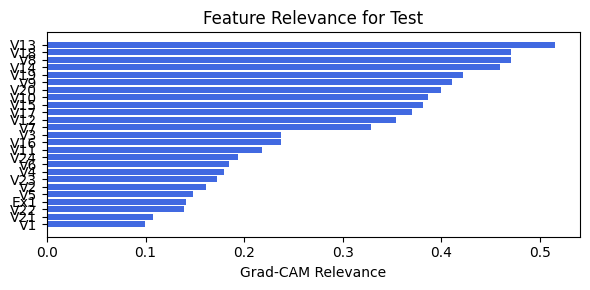

embed_dim: 32, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.74e-01 | val_acc_hybrid: 8.59e-01 |: 100%|███| 110/110 [00:39<00:00,  2.80it/s]


saving model version 0.1
✅ Best validation Accuracy: 8.6827e-01 at 71 epoch
tensor(0.8636, device='cuda:0')
[[391  32  11   7]
 [ 26 381   9   4]
 [  1  16  45   4]
 [ 11  11  17 126]]
M_KAN Relevance: 0.2450665384531021
CNN Relevance: 0.7549334764480591
[('V22', 0.23877648), ('V21', 0.2369661), ('V13', 0.21492073), ('V14', 0.204602), ('V1', 0.19107687), ('V18', 0.18534997), ('V12', 0.18282937), ('V16', 0.17632997), ('V20', 0.16194287), ('V19', 0.15073979), ('V24', 0.1463382), ('V7', 0.12172097), ('V2', 0.1185995), ('V15', 0.10895553), ('V17', 0.10187294), ('V4', 0.09894016), ('V10', 0.09728437), ('V5', 0.08005969), ('V23', 0.06724209), ('V3', 0.06477891), ('V6', 0.06370971), ('V11', 0.06131239), ('V8', 0.043298624), ('V9', 0.04083015)]


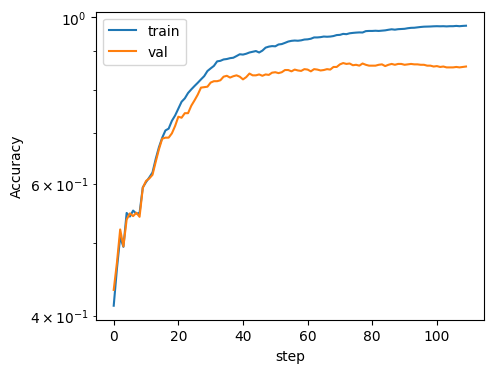

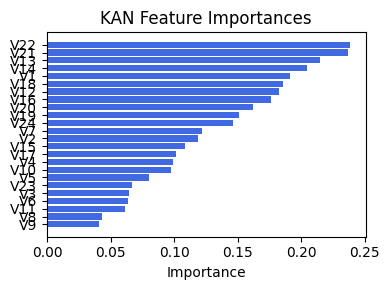

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V13', 0.4109118921996091), ('V18', 0.3884617506356692), ('V19', 0.38685176651046405), ('V14', 0.36156325615534596), ('V17', 0.34037117444741244), ('V12', 0.3358614987980714), ('V8', 0.3275793922121377), ('V9', 0.2886230359235591), ('V7', 0.27039911798474414), ('V16', 0.23016492333310065), ('V11', 0.22723788206017312), ('V21', 0.19973004904217231), ('V6', 0.19010305163114619), ('V3', 0.18954389341828634), ('V24', 0.18764024872935198), ('V2', 0.1803203794452568), ('V20', 0.17453174217584486), ('V23', 0.16923172679981113), ('V4', 0.16353501554624597), ('V15', 0.16085835763831563), ('V22', 0.14369812714399288), ('V1', 0.12957636204167672), ('Ex1', 0.12789663309214344), ('V10', 0.12169103825694796), ('V5', 0.06046678370450416)]


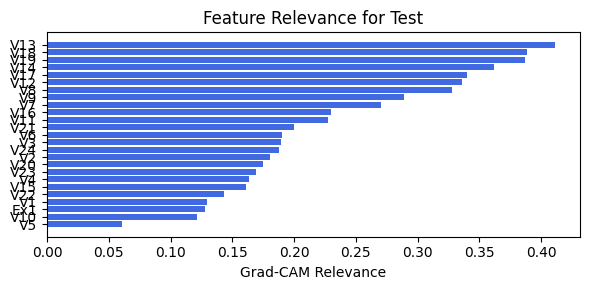

embed_dim: 32, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.93e-01 | val_acc_hybrid: 8.81e-01 |: 100%|███| 110/110 [00:40<00:00,  2.73it/s]


saving model version 0.1
✅ Best validation Accuracy: 8.9347e-01 at 85 epoch
tensor(0.8718, device='cuda:0')
[[395  34   7   5]
 [ 21 389   9   1]
 [  1  11  53   1]
 [ 13   9  28 115]]
M_KAN Relevance: 0.35908353328704834
CNN Relevance: 0.6409164071083069
[('V18', 0.2265697), ('V14', 0.20413679), ('V13', 0.20325813), ('V21', 0.187047), ('V16', 0.17712413), ('V22', 0.16138256), ('V20', 0.15709004), ('V24', 0.13487509), ('V19', 0.12679192), ('V1', 0.124926075), ('V17', 0.12082428), ('V2', 0.11819188), ('V7', 0.11017992), ('V15', 0.08141782), ('V23', 0.07658756), ('V8', 0.07296175), ('V4', 0.07177713), ('V5', 0.06946718), ('V6', 0.06940663), ('V12', 0.058071546), ('V10', 0.057497613), ('V3', 0.04043343), ('V11', 0.039174363), ('V9', 0.033392083)]


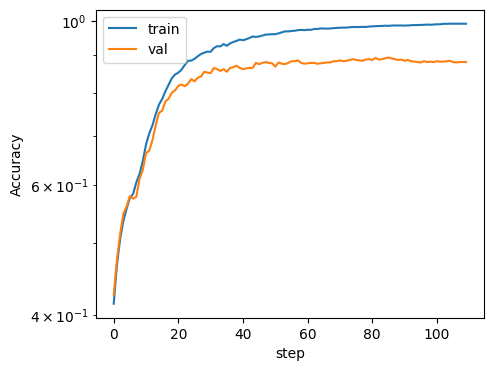

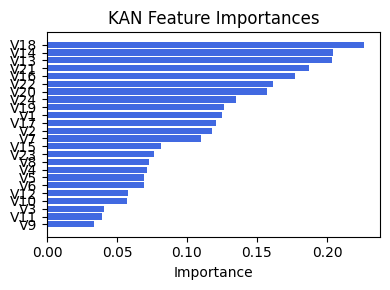

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V18', 0.38757477105510313), ('V13', 0.3576394245190539), ('V19', 0.3491935233608244), ('V14', 0.31296781825465375), ('V17', 0.3129045218071515), ('V23', 0.2777677997085351), ('V12', 0.2677737397925639), ('V24', 0.2618244939825699), ('V8', 0.25965328931880777), ('V20', 0.2429511461477487), ('V15', 0.24094748332023608), ('V9', 0.2272778221998993), ('V22', 0.22174791845999617), ('V7', 0.2123104106467908), ('V10', 0.1749470578679293), ('Ex1', 0.16929240387634353), ('V2', 0.1655946571511347), ('V4', 0.1637334708395042), ('V16', 0.15940280862408115), ('V11', 0.15794781253216003), ('V3', 0.1579243960809419), ('V5', 0.13407758968929762), ('V6', 0.12617270717859583), ('V1', 0.1205260699192104), ('V21', 0.08003946338537586)]


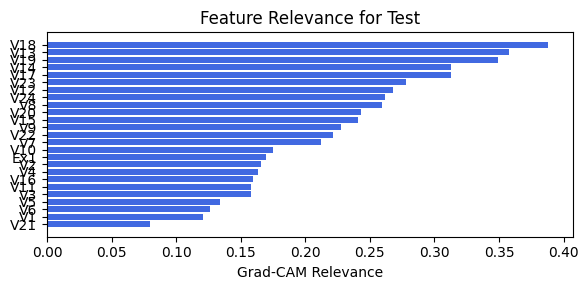

embed_dim: 32, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.79e-01 | val_acc_hybrid: 8.71e-01 |: 100%|███| 110/110 [00:42<00:00,  2.61it/s]


saving model version 0.1
✅ Best validation Accuracy: 8.8087e-01 at 73 epoch
tensor(0.8727, device='cuda:0')
[[386  40   5  10]
 [ 22 390   7   1]
 [  1  10  55   0]
 [ 14  12  17 122]]
M_KAN Relevance: 0.21264584362506866
CNN Relevance: 0.7873541712760925
[('V13', 0.24124543), ('V22', 0.22806439), ('V14', 0.22347572), ('V18', 0.21934539), ('V21', 0.20333962), ('V16', 0.18534243), ('V20', 0.16678677), ('V24', 0.15267469), ('V19', 0.14164573), ('V1', 0.14085278), ('V17', 0.12866583), ('V2', 0.11975084), ('V15', 0.11389729), ('V12', 0.09783828), ('V7', 0.09411504), ('V23', 0.0912763), ('V3', 0.06308784), ('V10', 0.061477363), ('V11', 0.061274968), ('V4', 0.061047014), ('V5', 0.056898683), ('V6', 0.05442234), ('V9', 0.049587585), ('V8', 0.048733205)]


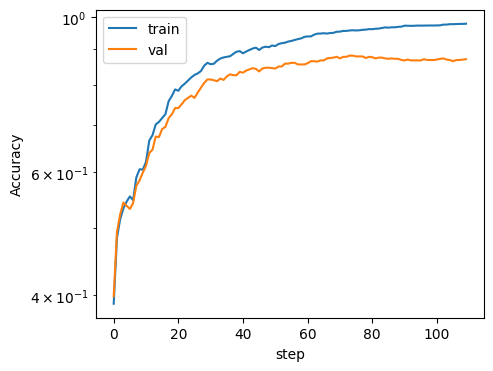

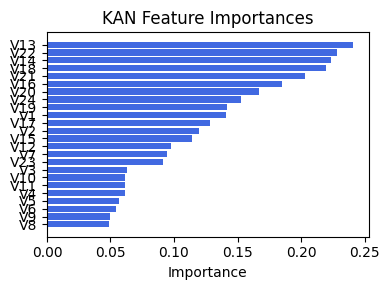

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V13', 0.4213857738187728), ('V8', 0.3793252703205822), ('V12', 0.37219844536980334), ('V18', 0.37162746957864873), ('V14', 0.36255631329544613), ('V17', 0.34450025971886794), ('V19', 0.3255278196950416), ('V9', 0.3185658312171114), ('V7', 0.31698690494842274), ('V11', 0.25255913776174976), ('V3', 0.25239086662668175), ('V16', 0.24729031730251771), ('V2', 0.22401465825071717), ('V4', 0.22197246449682914), ('V6', 0.19607609734499926), ('V5', 0.17579290355081204), ('V20', 0.1709658997581392), ('V24', 0.1591569386758874), ('V10', 0.15258764999868749), ('V15', 0.14505922531789245), ('V1', 0.1393722664084475), ('V23', 0.12790100666633417), ('V21', 0.12234233338354371), ('V22', 0.11914595836252365), ('Ex1', 0.09525971366591486)]


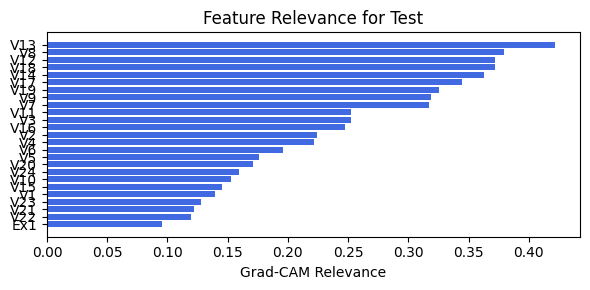

embed_dim: 16, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.91e-01 | val_acc_hybrid: 8.91e-01 |: 100%|███| 110/110 [00:38<00:00,  2.86it/s]


saving model version 0.1
✅ Best validation Accuracy: 9.0493e-01 at 57 epoch
tensor(0.8837, device='cuda:0')
[[400  28   6   7]
 [ 33 375   8   4]
 [  0   6  59   1]
 [  8  12  14 131]]
M_KAN Relevance: 0.6228018403053284
CNN Relevance: 0.37719815969467163
[('V22', 0.23462412), ('V13', 0.22757772), ('V12', 0.21522371), ('V14', 0.19920814), ('V21', 0.19316116), ('V18', 0.18825173), ('V1', 0.18159541), ('V19', 0.15549459), ('V24', 0.14666347), ('V10', 0.14413968), ('V7', 0.14401332), ('V20', 0.1344594), ('V16', 0.1328093), ('V5', 0.12746015), ('V15', 0.11743345), ('V4', 0.11500939), ('V17', 0.11292909), ('V11', 0.11024162), ('V2', 0.10651164), ('V23', 0.09721118), ('V3', 0.07947562), ('V6', 0.06571452), ('V8', 0.060351335), ('V9', 0.041620005)]


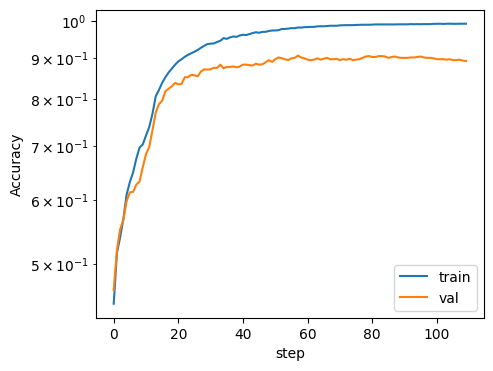

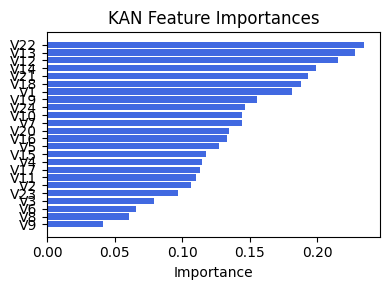

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V18', 0.4654159337723962), ('V13', 0.4566311549443083), ('V19', 0.4306421289339853), ('V14', 0.4296280116940023), ('V17', 0.41871547517166285), ('V8', 0.35282898940667917), ('V9', 0.35110908037268185), ('V12', 0.3468211180318979), ('V7', 0.3033567959188583), ('V24', 0.18221964851742858), ('V20', 0.16345827423646747), ('V15', 0.16225586348008997), ('V16', 0.16097891433216716), ('V23', 0.1605899778749937), ('V1', 0.14484383815948476), ('V22', 0.1431017726426944), ('V11', 0.13971256557606831), ('V10', 0.13313770060335378), ('V4', 0.12782054675398163), ('V6', 0.12755678568599904), ('V2', 0.1248659776127556), ('V3', 0.1248468822133753), ('Ex1', 0.09478066893601056), ('V5', 0.09350605137531488), ('V21', 0.09294161314116266)]


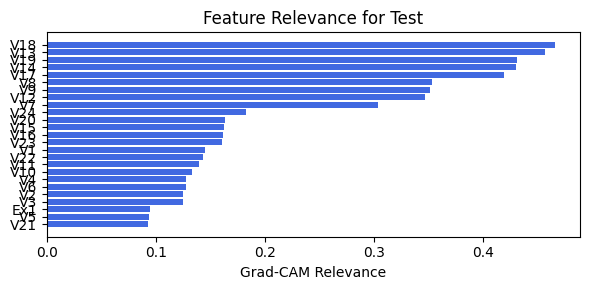

embed_dim: 16, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.89e-01 | val_acc_hybrid: 8.48e-01 |: 100%|███| 110/110 [00:40<00:00,  2.71it/s]


saving model version 0.1
✅ Best validation Accuracy: 8.6369e-01 at 80 epoch
tensor(0.8526, device='cuda:0')
[[376  46   9  10]
 [ 32 376  10   2]
 [  1  11  51   3]
 [ 13   9  15 128]]
M_KAN Relevance: 0.6396231055259705
CNN Relevance: 0.3603769540786743
[('V13', 0.2560371), ('V18', 0.23497449), ('V14', 0.20516275), ('V21', 0.19025087), ('V22', 0.17683779), ('V20', 0.17199552), ('V16', 0.1691036), ('V24', 0.15202014), ('V19', 0.13574871), ('V17', 0.12831599), ('V1', 0.123847626), ('V2', 0.11628395), ('V15', 0.100811124), ('V7', 0.09657501), ('V8', 0.08044163), ('V10', 0.070945024), ('V12', 0.065854415), ('V4', 0.06460872), ('V23', 0.059977733), ('V5', 0.05146151), ('V11', 0.048778534), ('V9', 0.04629668), ('V3', 0.038280115), ('V6', 0.030285899)]


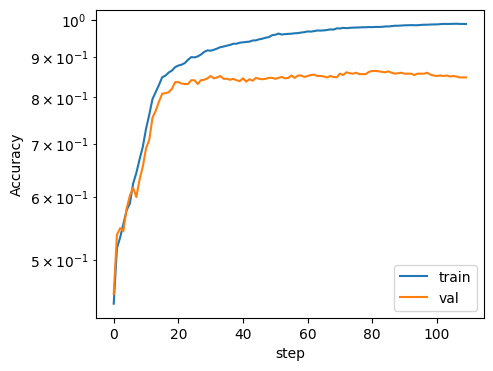

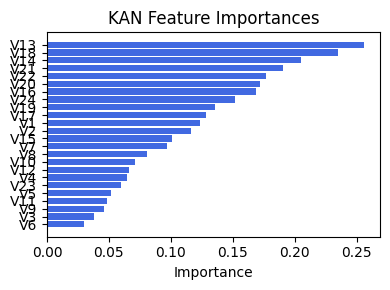

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V18', 0.41781726052418294), ('V19', 0.38665173956958043), ('V17', 0.3846872857121082), ('V13', 0.3666102858716554), ('V14', 0.35714413749946167), ('V9', 0.2937512298904772), ('V12', 0.2885739084422012), ('V8', 0.2877190212314887), ('V24', 0.26486041772466296), ('V7', 0.26021245312205504), ('V23', 0.2191891507113407), ('V22', 0.19424249423815332), ('Ex1', 0.16708730696700513), ('V20', 0.1631672768397325), ('V16', 0.15668995139311023), ('V15', 0.14749400619357303), ('V3', 0.14689512131967553), ('V11', 0.13547044940934186), ('V2', 0.13379986314165906), ('V10', 0.13125586255957566), ('V4', 0.13100058334883202), ('V6', 0.12799039389079928), ('V1', 0.09721330532337537), ('V5', 0.09699627069605059), ('V21', 0.09648669713319427)]


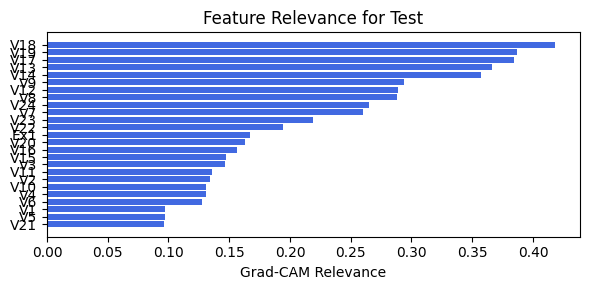

embed_dim: 16, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.82e-01 | val_acc_hybrid: 8.48e-01 |: 100%|███| 110/110 [00:40<00:00,  2.69it/s]


saving model version 0.1
✅ Best validation Accuracy: 8.7629e-01 at 54 epoch
tensor(0.8828, device='cuda:0')
[[401  25   9   6]
 [ 19 395   5   1]
 [  3  14  44   5]
 [  9  15  17 124]]
M_KAN Relevance: 0.5772367119789124
CNN Relevance: 0.42276322841644287
[('V13', 0.2743184), ('V22', 0.25540322), ('V14', 0.20002447), ('V21', 0.18969321), ('V7', 0.18105212), ('V20', 0.17613378), ('V18', 0.17407583), ('V24', 0.16907158), ('V19', 0.16103691), ('V16', 0.15787742), ('V15', 0.14935985), ('V1', 0.13911311), ('V17', 0.13048832), ('V4', 0.12959903), ('V10', 0.1279755), ('V2', 0.12518077), ('V12', 0.122664884), ('V5', 0.11811083), ('V6', 0.11302569), ('V3', 0.102927834), ('V11', 0.09573823), ('V23', 0.09188451), ('V8', 0.06384094), ('V9', 0.058585458)]


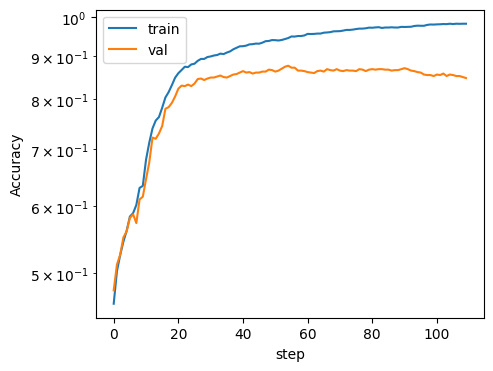

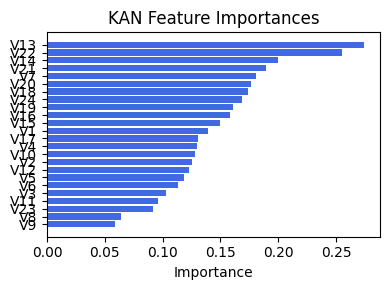

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V13', 0.456927967677298), ('V18', 0.430564546802818), ('V17', 0.4195683517609723), ('V19', 0.41893733994209725), ('V14', 0.41361186537557304), ('V8', 0.39090771041128225), ('V12', 0.37333700567997324), ('V9', 0.3646583542301944), ('V7', 0.34645551809163266), ('V24', 0.2866349449657772), ('V23', 0.2748688894760882), ('V22', 0.23004322951433445), ('Ex1', 0.17938647570767383), ('V20', 0.17656021653032766), ('V15', 0.16854795611715295), ('V16', 0.1642047201847016), ('V3', 0.15278374247204754), ('V11', 0.15103958911771395), ('V10', 0.14781765684951523), ('V2', 0.14556615804345518), ('V4', 0.13731796944194774), ('V6', 0.13476002114291807), ('V21', 0.12608695189746436), ('V5', 0.0843338233305972), ('V1', 0.07124608765335348)]


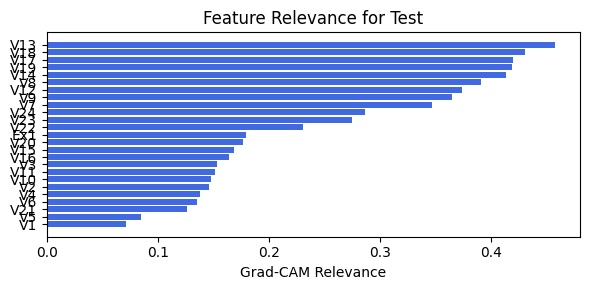

In [46]:
for embed_dim in [64, 32, 16]:
    for num_head in [2, 4 , 8]:
        print(f"embed_dim: {embed_dim}, num_head:{num_head}")
        train_and_plot_relevance(Model3_4, kan_neurons=12, kan_grid=8, lamb=0.001, steps=110, 
                                 embed_dim=embed_dim, num_heads=num_head, filename=filename_4, opt_col_val=f'{embed_dim}, {num_head}')

## 4.1 width=[24, 6], grid=7, lamb=1e-05

embed_dim: 64, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.90e-01 | val_acc_hybrid: 8.53e-01 |: 100%|███| 110/110 [00:45<00:00,  2.40it/s]


saving model version 0.1
✅ Best validation Accuracy: 8.5796e-01 at 70 epoch
tensor(0.8690, device='cuda:0')
[[384  40  11   6]
 [ 18 392   9   1]
 [  3  17  44   2]
 [ 10   8  18 129]]
M_KAN Relevance: 0.08497573435306549
CNN Relevance: 0.9150242805480957
[('V11', 0.2584396), ('V14', 0.25007185), ('V3', 0.23153387), ('V22', 0.19726658), ('V2', 0.19675587), ('V15', 0.19617473), ('V9', 0.192271), ('V5', 0.19103742), ('V23', 0.18872297), ('V10', 0.18416761), ('V6', 0.17556798), ('V8', 0.16897306), ('V12', 0.16644661), ('V7', 0.16495058), ('V16', 0.16387162), ('V19', 0.15114014), ('V20', 0.1473718), ('V21', 0.14690296), ('V17', 0.1416649), ('V13', 0.13836727), ('V18', 0.13403577), ('V4', 0.12817343), ('V24', 0.1265734), ('V1', 0.10396032)]


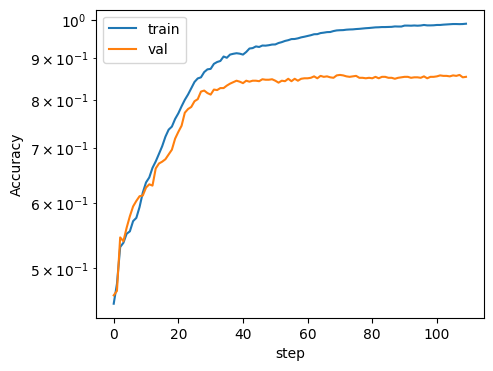

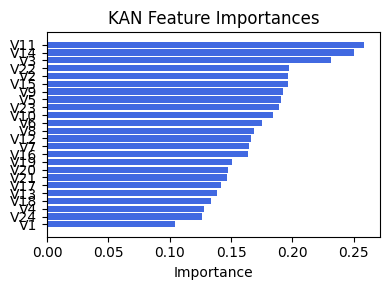

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V13', 0.37951126134137353), ('V18', 0.3768899949206101), ('V17', 0.3662867537714991), ('V19', 0.35614097939724026), ('V14', 0.335876762543367), ('V12', 0.32991917180528546), ('V8', 0.3247929477787853), ('V7', 0.29866391252692204), ('V9', 0.2776924294898041), ('V24', 0.2387602028900488), ('V22', 0.21176718471076292), ('V23', 0.20992754201790456), ('V20', 0.18794391509820324), ('V16', 0.18130525696025684), ('V10', 0.17480172404132216), ('V11', 0.1622453464568045), ('V15', 0.16043762238129333), ('V6', 0.14802084272640645), ('V3', 0.1480159486444401), ('V2', 0.1368549645696289), ('Ex1', 0.1298321364123388), ('V21', 0.1212338252644858), ('V5', 0.11796833659857942), ('V4', 0.11794460028499082), ('V1', 0.078471231812088)]


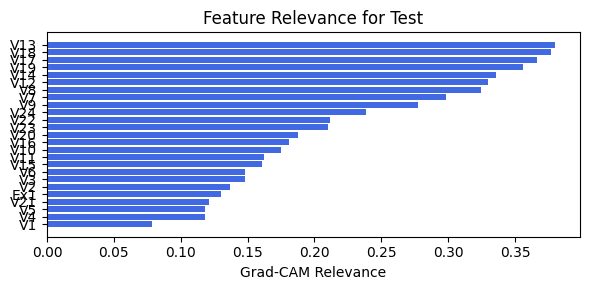

embed_dim: 64, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.96e-01 | val_acc_hybrid: 9.10e-01 |: 100%|███| 110/110 [00:45<00:00,  2.40it/s]


saving model version 0.1
✅ Best validation Accuracy: 9.1065e-01 at 100 epoch
tensor(0.8855, device='cuda:0')
[[407  23   6   5]
 [ 17 392   7   4]
 [  5  10  47   4]
 [ 17  12  15 121]]
M_KAN Relevance: 0.12237723171710968
CNN Relevance: 0.8776227831840515
[('V11', 0.2584027), ('V14', 0.2494236), ('V3', 0.23157927), ('V22', 0.19690055), ('V2', 0.19611424), ('V15', 0.19468358), ('V9', 0.19120489), ('V5', 0.1903892), ('V23', 0.18841943), ('V10', 0.18383704), ('V6', 0.1745774), ('V8', 0.16866842), ('V12', 0.1656764), ('V16', 0.16378674), ('V7', 0.16299035), ('V19', 0.15072745), ('V20', 0.14724663), ('V21', 0.14706446), ('V17', 0.14172186), ('V13', 0.13675438), ('V18', 0.13406852), ('V4', 0.12650652), ('V24', 0.12649164), ('V1', 0.103811726)]


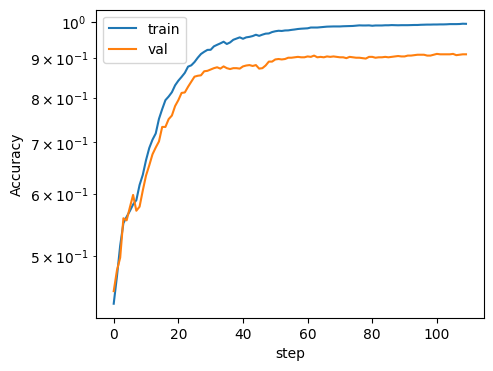

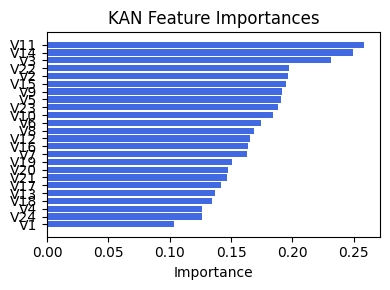

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V13', 0.3972319048170969), ('V18', 0.38488504529349427), ('V19', 0.3612768518403275), ('V17', 0.3311678743786895), ('V14', 0.3266870388295022), ('V8', 0.3220068197213403), ('V12', 0.3147548412189447), ('V9', 0.2679800209607426), ('V7', 0.267268711821875), ('V16', 0.20718162983796437), ('V11', 0.18892141503274215), ('V24', 0.1757847182789558), ('V23', 0.1749623724242086), ('V5', 0.1640649452588333), ('V20', 0.1638669945244616), ('V4', 0.16371665211277053), ('V6', 0.1613030631211926), ('V22', 0.15858608651946363), ('V2', 0.1548683172439222), ('V15', 0.15209346851272143), ('Ex1', 0.15009958681078192), ('V3', 0.1482194444778053), ('V10', 0.13111945057728222), ('V1', 0.12116521214888812), ('V21', 0.10150182029837274)]


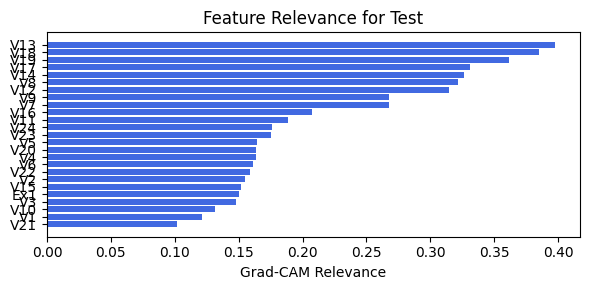

embed_dim: 64, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.94e-01 | val_acc_hybrid: 8.74e-01 |: 100%|███| 110/110 [00:45<00:00,  2.43it/s]


saving model version 0.1
✅ Best validation Accuracy: 8.8774e-01 at 94 epoch
tensor(0.8672, device='cuda:0')
[[393  33  10   5]
 [ 16 398   6   0]
 [  0  16  46   4]
 [ 16  13  26 110]]
M_KAN Relevance: 0.10812710970640182
CNN Relevance: 0.8918729424476624
[('V11', 0.2584245), ('V14', 0.24972606), ('V3', 0.23156202), ('V22', 0.19705574), ('V2', 0.19641197), ('V15', 0.19537747), ('V9', 0.19169915), ('V5', 0.19065315), ('V23', 0.18856382), ('V10', 0.18397498), ('V6', 0.17503399), ('V8', 0.16881178), ('V12', 0.16603345), ('V7', 0.16389963), ('V16', 0.16382661), ('V19', 0.15092263), ('V20', 0.1473048), ('V21', 0.1469933), ('V17', 0.1416985), ('V13', 0.13750261), ('V18', 0.13405633), ('V4', 0.12727933), ('V24', 0.12652399), ('V1', 0.103881896)]


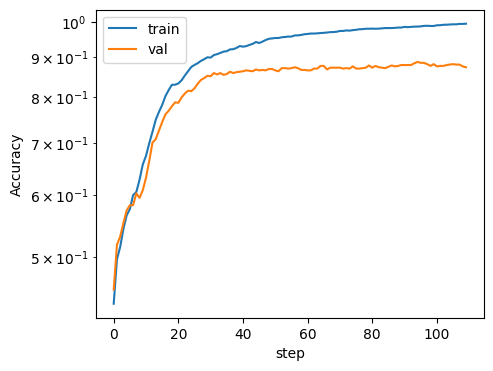

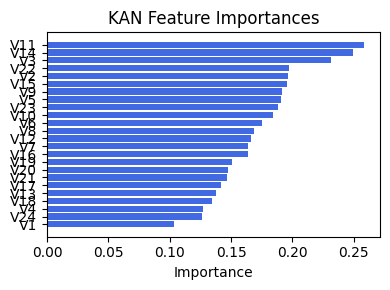

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V13', 0.3788650664682125), ('V19', 0.33903192501065693), ('V14', 0.3283908568750581), ('V8', 0.32095078829894563), ('V18', 0.3205260947622694), ('V9', 0.29588595989634964), ('V12', 0.2848134827196697), ('V17', 0.27143380143132784), ('V7', 0.2555248052443718), ('V22', 0.22789980135931084), ('V24', 0.2065982304977943), ('V23', 0.20086670610232563), ('V20', 0.18708632429660854), ('V15', 0.18329538931687575), ('V3', 0.17639853133196984), ('V21', 0.17293251158845047), ('V16', 0.1661341358110257), ('V2', 0.1641505797270062), ('V4', 0.15455628830080062), ('V11', 0.1538022553210058), ('V10', 0.1437069663559189), ('V6', 0.1417513066702761), ('Ex1', 0.13581906776777605), ('V1', 0.10881578527776237), ('V5', 0.07913043610961645)]


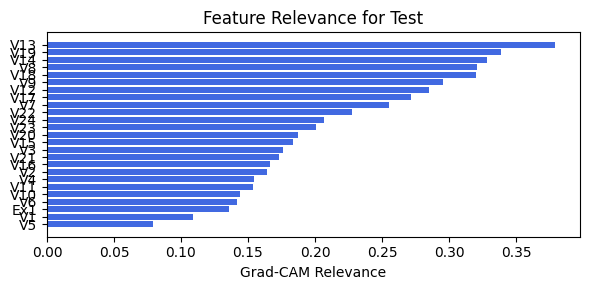

embed_dim: 32, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.89e-01 | val_acc_hybrid: 9.03e-01 |: 100%|███| 110/110 [00:37<00:00,  2.90it/s]

saving model version 0.1
✅ Best validation Accuracy: 9.0951e-01 at 86 epoch
tensor(0.8874, device='cuda:0')
[[395  36   5   5]
 [ 23 386   9   2]
 [  0   9  54   3]
 [ 19   2  10 134]]
M_KAN Relevance: 0.2614690363407135
CNN Relevance: 0.7385309338569641
[('V11', 0.25839514), ('V14', 0.24933264), ('V3', 0.23158352), ('V22', 0.1968528), ('V2', 0.1960243), ('V15', 0.19447783), ('V9', 0.19105709), ('V5', 0.19031267), ('V23', 0.18837701), ('V10', 0.1837965), ('V6', 0.17444015), ('V8', 0.16862532), ('V12', 0.16556886), ('V16', 0.16377424), ('V7', 0.16272074), ('V19', 0.15066932), ('V20', 0.1472292), ('V21', 0.14708556), ('V17', 0.14172845), ('V13', 0.1365349), ('V18', 0.13407205), ('V24', 0.12648013), ('V4', 0.12627581), ('V1', 0.103790246)]


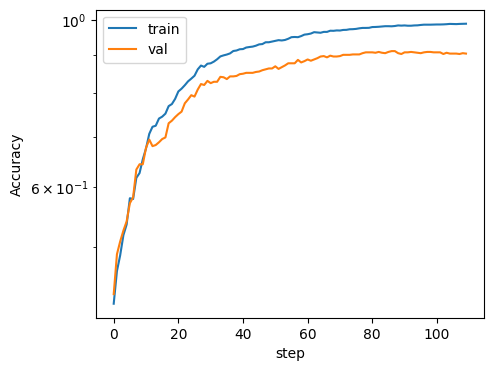

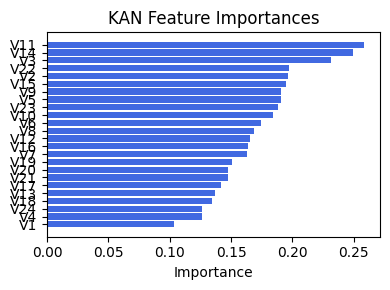

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V18', 0.44665968235225617), ('V19', 0.433973020939634), ('V14', 0.4035118920078259), ('V17', 0.4026481920321073), ('V13', 0.36103523660266956), ('V9', 0.31819878715250793), ('V8', 0.3128636157767627), ('V12', 0.3101855218794279), ('V7', 0.27301254540385683), ('V24', 0.21414839213666242), ('V20', 0.20776027425121615), ('V23', 0.19269953225654013), ('V16', 0.16720102457280592), ('V22', 0.15758543092187755), ('V15', 0.1568019596664508), ('V3', 0.14914916107373913), ('V10', 0.1431666922273887), ('Ex1', 0.14008495296535403), ('V11', 0.13922048523186725), ('V4', 0.13865639963760826), ('V2', 0.1367338561459748), ('V5', 0.1362509489360721), ('V6', 0.12005766868697809), ('V21', 0.11043004518587589), ('V1', 0.10406326817317363)]


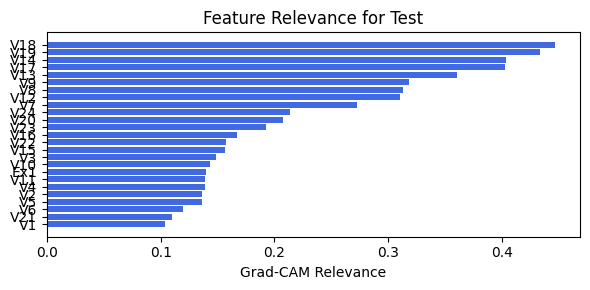

embed_dim: 32, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.89e-01 | val_acc_hybrid: 8.66e-01 |: 100%|███| 110/110 [00:39<00:00,  2.80it/s]

saving model version 0.1
✅ Best validation Accuracy: 8.8431e-01 at 70 epoch
tensor(0.8828, device='cuda:0')
[[385  43   8   5]
 [ 17 392   7   4]
 [  2   7  57   0]
 [ 10  12  13 130]]
M_KAN Relevance: 0.1741790920495987
CNN Relevance: 0.8258209228515625
[('V11', 0.25842702), ('V14', 0.2497778), ('V3', 0.23155794), ('V22', 0.19708467), ('V2', 0.19646293), ('V15', 0.19549704), ('V9', 0.19178455), ('V5', 0.19070229), ('V23', 0.18858838), ('V10', 0.18400107), ('V6', 0.1751121), ('V8', 0.16883579), ('V12', 0.1660946), ('V7', 0.16405725), ('V16', 0.16383307), ('V19', 0.1509554), ('V20', 0.14731486), ('V21', 0.1469801), ('V17', 0.14169382), ('V13', 0.13763255), ('V18', 0.1340536), ('V4', 0.12741266), ('V24', 0.12653022), ('V1', 0.10389353)]


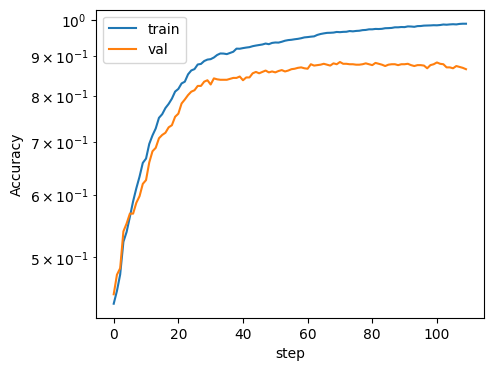

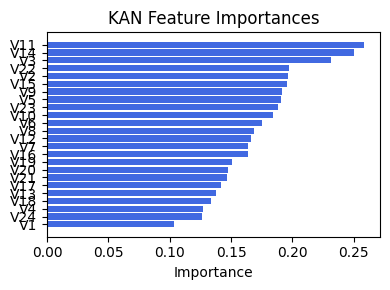

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V18', 0.458896956304617), ('V13', 0.43060568577845343), ('V17', 0.4236595773260918), ('V19', 0.4193156796128868), ('V14', 0.4017911591633622), ('V12', 0.36159095447574446), ('V8', 0.34016116941704855), ('V9', 0.3129546631282923), ('V7', 0.3048694296471345), ('V23', 0.24204316347792246), ('V24', 0.22840962834778197), ('V22', 0.21314718094813226), ('V16', 0.18889084186731375), ('V11', 0.17075459071330132), ('V20', 0.15157987231389966), ('V6', 0.13791863063070794), ('V3', 0.13619791351134103), ('V2', 0.1337514662349276), ('V4', 0.1320869129552563), ('V15', 0.12968719431039008), ('V10', 0.1256251250914173), ('Ex1', 0.12466832756219626), ('V5', 0.1196985258427245), ('V21', 0.10770185805177879), ('V1', 0.0834741453244435)]


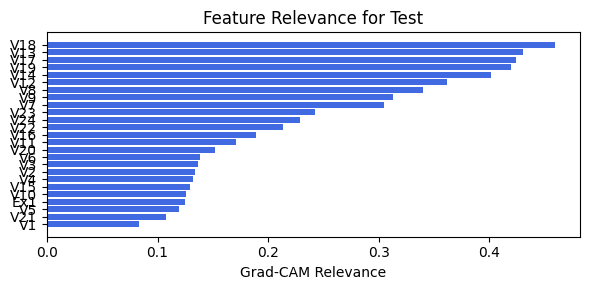

embed_dim: 32, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.87e-01 | val_acc_hybrid: 8.74e-01 |: 100%|███| 110/110 [00:43<00:00,  2.52it/s]


saving model version 0.1
✅ Best validation Accuracy: 8.8889e-01 at 83 epoch
tensor(0.8755, device='cuda:0')
[[392  36   5   8]
 [ 21 388   9   2]
 [  1  15  48   2]
 [  7  13  17 128]]
M_KAN Relevance: 0.1851319968700409
CNN Relevance: 0.8148679733276367
[('V11', 0.25840548), ('V14', 0.24947229), ('V3', 0.23157595), ('V22', 0.1969208), ('V2', 0.19616133), ('V15', 0.19479772), ('V9', 0.19128492), ('V5', 0.19042733), ('V23', 0.18844393), ('V10', 0.18385828), ('V6', 0.17464837), ('V8', 0.16869158), ('V12', 0.16573298), ('V16', 0.16379255), ('V7', 0.16313991), ('V19', 0.15075967), ('V20', 0.147256), ('V21', 0.14705311), ('V17', 0.14171794), ('V13', 0.13687947), ('V18', 0.13406675), ('V4', 0.12663157), ('V24', 0.12649369), ('V1', 0.1038227)]


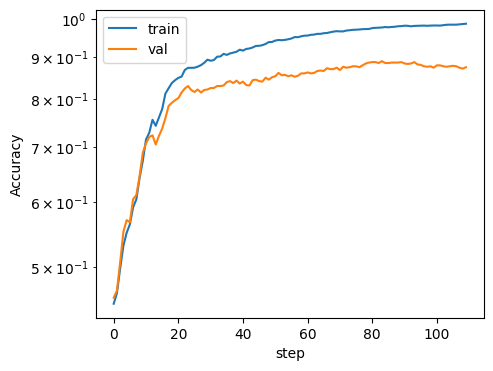

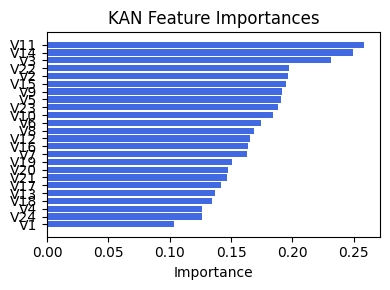

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V18', 0.42843926048335695), ('V13', 0.4199152929079804), ('V17', 0.39267194153990037), ('V19', 0.3699606319263854), ('V12', 0.3514098354309095), ('V14', 0.35112505871216226), ('V8', 0.34741754413347), ('V7', 0.30736710258265754), ('V9', 0.2838096599465137), ('V11', 0.22962843845048306), ('V16', 0.2257668164199655), ('V24', 0.20044044028665814), ('V20', 0.19500236434961377), ('V3', 0.187234101102782), ('V6', 0.18063434581174226), ('V23', 0.17643528716418433), ('V2', 0.17257458540280912), ('V10', 0.17144070539400477), ('V15', 0.15931496127526332), ('V22', 0.1480470974588487), ('Ex1', 0.1410769553424474), ('V4', 0.13664689335474), ('V5', 0.1290816589533765), ('V1', 0.12638739236421975), ('V21', 0.09952819030477658)]


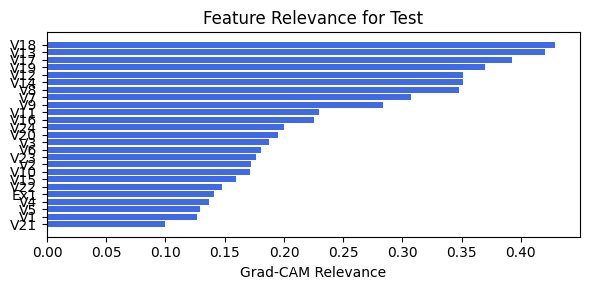

embed_dim: 16, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.85e-01 | val_acc_hybrid: 8.61e-01 |: 100%|███| 110/110 [00:40<00:00,  2.74it/s]


saving model version 0.1
✅ Best validation Accuracy: 8.7056e-01 at 85 epoch
tensor(0.8571, device='cuda:0')
[[397  32   9   3]
 [ 23 382  12   3]
 [  2  11  50   3]
 [ 10  20  28 107]]
M_KAN Relevance: 0.15721096098423004
CNN Relevance: 0.8427890539169312
[('V11', 0.2584277), ('V14', 0.24977265), ('V3', 0.23155907), ('V22', 0.19708276), ('V2', 0.19645827), ('V15', 0.19548379), ('V9', 0.19177566), ('V5', 0.19069871), ('V23', 0.18858576), ('V10', 0.1839978), ('V6', 0.17510542), ('V8', 0.1688336), ('V12', 0.16608882), ('V7', 0.1640396), ('V16', 0.16383277), ('V19', 0.15095201), ('V20', 0.14731395), ('V21', 0.14698187), ('V17', 0.14169475), ('V13', 0.13761716), ('V18', 0.13405403), ('V4', 0.12739865), ('V24', 0.12653047), ('V1', 0.103892654)]


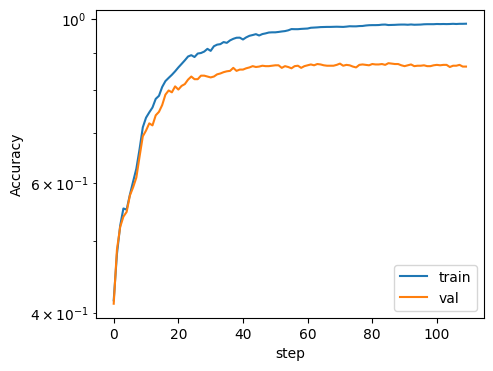

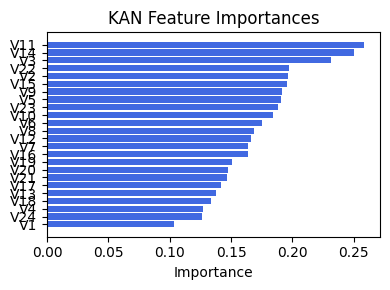

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V13', 0.3834012431774208), ('V18', 0.3710676022006144), ('V17', 0.3674329968763988), ('V19', 0.33974312983313404), ('V12', 0.3233949902327561), ('V8', 0.3217715846089776), ('V14', 0.3038819379427158), ('V7', 0.2905089478305884), ('V9', 0.2702365325545649), ('V16', 0.2333760496585322), ('V11', 0.22548968587485407), ('V20', 0.19557518317292089), ('V6', 0.18965545745704865), ('V10', 0.18571868834780098), ('V3', 0.17450185400070867), ('V22', 0.1714014620998309), ('V15', 0.16521429642957644), ('V4', 0.1541453417580203), ('V2', 0.14492147683429074), ('V23', 0.14375732774174255), ('V24', 0.1398507057806755), ('V21', 0.13301421878351416), ('V5', 0.1177251767801683), ('V1', 0.10062235757310264), ('Ex1', 0.0969671052044783)]


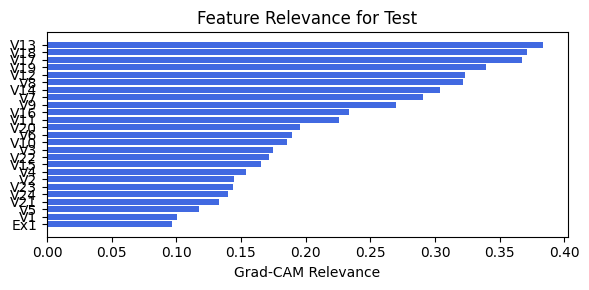

embed_dim: 16, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.56e-01 | val_acc_hybrid: 8.26e-01 |: 100%|███| 110/110 [00:41<00:00,  2.65it/s]

saving model version 0.1
✅ Best validation Accuracy: 8.2818e-01 at 101 epoch
tensor(0.8205, device='cuda:0')
[[373  49   8  11]
 [ 31 366  18   5]
 [  2  27  36   1]
 [ 10  14  20 121]]
M_KAN Relevance: 0.3688843548297882
CNN Relevance: 0.6311156749725342
[('V11', 0.25844672), ('V14', 0.25030673), ('V3', 0.23151252), ('V22', 0.19742537), ('V2', 0.19699034), ('V15', 0.19671723), ('V9', 0.19266129), ('V5', 0.19135112), ('V23', 0.18882892), ('V10', 0.18432187), ('V6', 0.17593777), ('V8', 0.16908178), ('V12', 0.16672966), ('V7', 0.165667), ('V16', 0.16390231), ('V19', 0.1512863), ('V20', 0.14741692), ('V21', 0.14683917), ('V17', 0.14164019), ('V13', 0.13895667), ('V18', 0.13401969), ('V4', 0.12878412), ('V24', 0.12661263), ('V1', 0.10401317)]


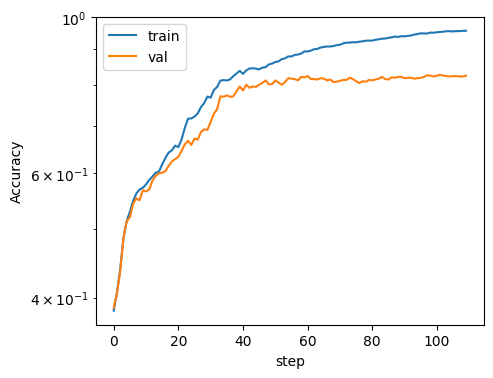

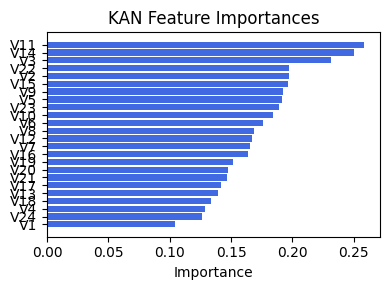

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V13', 0.39076023760116096), ('V18', 0.3556963593744666), ('V12', 0.34103468794962744), ('V14', 0.33373059334630834), ('V17', 0.32581500534886954), ('V19', 0.3143668564458334), ('V7', 0.2969527091095804), ('V8', 0.29596103561701825), ('V9', 0.27908041731796857), ('V16', 0.22576497203397847), ('V10', 0.22439956869895913), ('V20', 0.2095923383140328), ('V15', 0.20094343923026314), ('V22', 0.19732262787956742), ('V11', 0.180815360198938), ('V3', 0.18069226916383904), ('V23', 0.1802328261321849), ('V6', 0.17335842069688948), ('Ex1', 0.1725084155759793), ('V4', 0.17066983378487713), ('V2', 0.1704052252094138), ('V24', 0.1687054938057895), ('V5', 0.14252183276046096), ('V21', 0.1110380517539309), ('V1', 0.10488845332932485)]


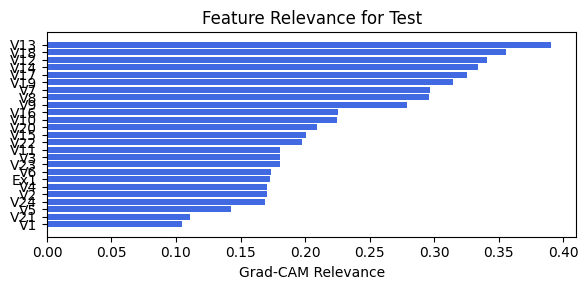

embed_dim: 16, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.71e-01 | val_acc_hybrid: 8.65e-01 |: 100%|███| 110/110 [00:39<00:00,  2.75it/s]

saving model version 0.1
✅ Best validation Accuracy: 8.6827e-01 at 101 epoch
tensor(0.8727, device='cuda:0')
[[394  35   6   6]
 [ 15 390  13   2]
 [  1  11  52   2]
 [ 18  11  19 117]]
M_KAN Relevance: 0.3031831979751587
CNN Relevance: 0.6968168616294861
[('V11', 0.25843865), ('V14', 0.2500387), ('V3', 0.2315372), ('V22', 0.19724712), ('V2', 0.19672328), ('V15', 0.19609722), ('V9', 0.19221601), ('V5', 0.1909979), ('V23', 0.18870753), ('V10', 0.18414778), ('V6', 0.17551711), ('V8', 0.16895759), ('V12', 0.16640721), ('V7', 0.16484801), ('V16', 0.16386771), ('V19', 0.15111917), ('V20', 0.14736557), ('V21', 0.14691198), ('V17', 0.14166853), ('V13', 0.13828182), ('V18', 0.13403797), ('V4', 0.12808694), ('V24', 0.12656952), ('V1', 0.103952974)]


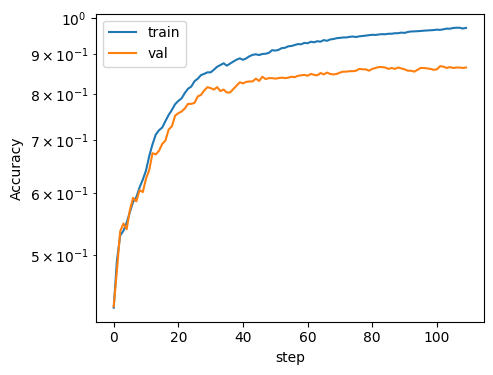

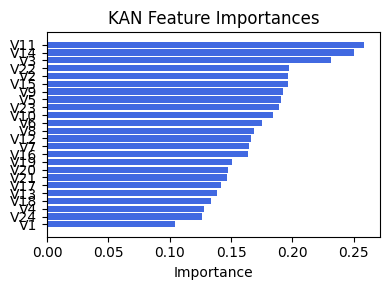

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V17', 0.39592197550300356), ('V18', 0.39548853346096646), ('V13', 0.3931748172048234), ('V19', 0.38824732696336667), ('V12', 0.35309030207116227), ('V14', 0.35135449776310823), ('V8', 0.3456662608382647), ('V7', 0.3145360969721925), ('V9', 0.2971378779592346), ('V20', 0.2611570466811267), ('V10', 0.2375964967115192), ('V3', 0.2189320882745507), ('V15', 0.21539848189654498), ('V16', 0.19692777849127446), ('V4', 0.19500567025900573), ('V11', 0.18544514517497268), ('V2', 0.18525476449559347), ('V5', 0.1821162793691519), ('V6', 0.16325958362727633), ('V24', 0.14811523012135044), ('V23', 0.1322728548491949), ('V22', 0.12244460772591406), ('V1', 0.10321089740324042), ('V21', 0.09268156157457057), ('Ex1', 0.09083435042846978)]


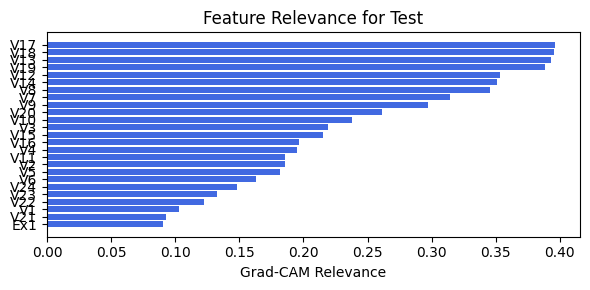

In [47]:
for embed_dim in [64, 32, 16]:
    for num_head in [2, 4 , 8]:
        print(f"embed_dim: {embed_dim}, num_head:{num_head}")
        train_and_plot_relevance(Model3_4, kan_neurons=6, kan_grid=7, lamb=1e-05, steps=110, 
                                 embed_dim=embed_dim, num_heads=num_head, filename=filename_4, opt_col_val=f'{embed_dim}, {num_head}')

## 4.2. width=[24, 11], grid=3, lamb=0.001

embed_dim: 64, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.77e-01 | val_acc_hybrid: 8.68e-01 |: 100%|███| 110/110 [00:51<00:00,  2.13it/s]


saving model version 0.1
✅ Best validation Accuracy: 8.7629e-01 at 86 epoch
tensor(0.8736, device='cuda:0')
[[401  27   7   6]
 [ 20 390   5   5]
 [  3  16  42   5]
 [ 13  14  17 121]]
M_KAN Relevance: 0.2159740924835205
CNN Relevance: 0.7840259075164795
[('V1', 0.21912585), ('V21', 0.21531563), ('V10', 0.20845895), ('V14', 0.2061121), ('V13', 0.19826451), ('V12', 0.19023387), ('V5', 0.18195659), ('V22', 0.16825552), ('V16', 0.16566494), ('V19', 0.16132432), ('V24', 0.1557753), ('V6', 0.14381374), ('V11', 0.14101689), ('V23', 0.1305797), ('V15', 0.12938063), ('V2', 0.12214607), ('V20', 0.1188358), ('V18', 0.1077757), ('V17', 0.09374273), ('V7', 0.09111654), ('V9', 0.08063935), ('V4', 0.07124946), ('V3', 0.06446109), ('V8', 0.038985737)]


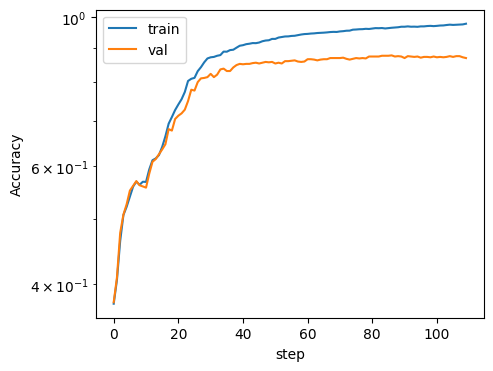

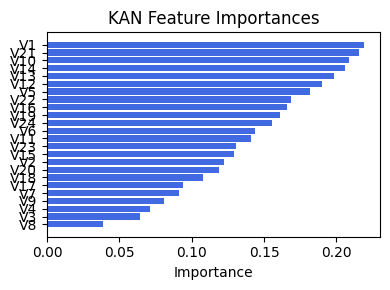

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V13', 0.37723946350267595), ('V19', 0.34942237634958884), ('V12', 0.34447395720171814), ('V18', 0.3280248131329874), ('V14', 0.3216805497918708), ('V8', 0.3152070730925033), ('V17', 0.29567331788760154), ('V9', 0.2668041079902114), ('V7', 0.26297208131013794), ('V11', 0.2224229122290832), ('V3', 0.21426767665822904), ('V16', 0.21184770368851316), ('V2', 0.20948332693596666), ('V24', 0.20571163009852225), ('V20', 0.18244323270815857), ('V23', 0.17797734110863264), ('V4', 0.17552773203495456), ('V6', 0.17089708312020138), ('V15', 0.1679411459732937), ('V22', 0.14816579286070586), ('V1', 0.13892088802737781), ('Ex1', 0.1314481190456318), ('V10', 0.1233562706298478), ('V21', 0.12001777479349168), ('V5', 0.08110529003988298)]


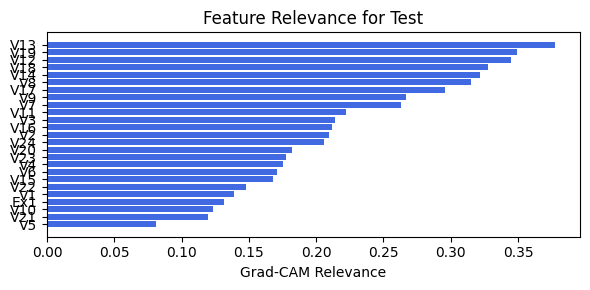

embed_dim: 64, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.38e-01 | val_acc_hybrid: 8.55e-01 |: 100%|███| 110/110 [00:48<00:00,  2.25it/s]


saving model version 0.1
✅ Best validation Accuracy: 8.5567e-01 at 94 epoch
tensor(0.8617, device='cuda:0')
[[379  50   7   5]
 [ 22 389   5   4]
 [  0  20  43   3]
 [  6  14  15 130]]
M_KAN Relevance: 0.05904178321361542
CNN Relevance: 0.9409582614898682
[('V21', 0.23408137), ('V12', 0.22034764), ('V1', 0.20034094), ('V22', 0.19383472), ('V5', 0.18974684), ('V14', 0.17733388), ('V10', 0.17615269), ('V19', 0.17614202), ('V24', 0.17445712), ('V13', 0.17248069), ('V15', 0.16970079), ('V2', 0.16957764), ('V23', 0.14103143), ('V11', 0.13932745), ('V16', 0.12641342), ('V9', 0.11837697), ('V20', 0.1133981), ('V4', 0.10695475), ('V17', 0.098797984), ('V7', 0.09781523), ('V6', 0.094752036), ('V3', 0.08924372), ('V18', 0.08568957), ('V8', 0.050127275)]


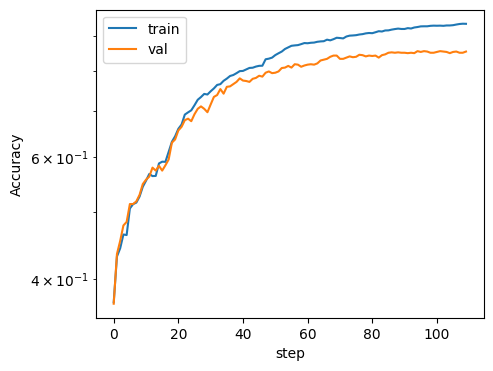

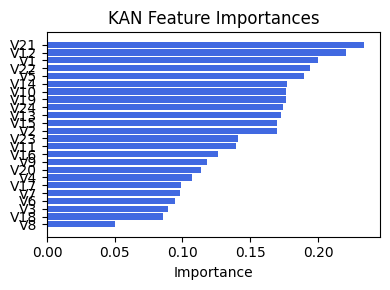

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V12', 0.3231169063240356), ('V13', 0.30075079361582346), ('V17', 0.2795659163047819), ('V18', 0.26360870865882313), ('V8', 0.25257625094795727), ('V14', 0.2480640892022982), ('V16', 0.246758400883987), ('V7', 0.24502434709063312), ('V11', 0.23982471212763476), ('V19', 0.20646834032490233), ('V9', 0.20337522604426833), ('V2', 0.19714898183164034), ('V3', 0.19306186352643248), ('V10', 0.19063798101277102), ('V4', 0.18505102763028777), ('V6', 0.18353773521330002), ('V20', 0.1691860948132951), ('V5', 0.16328694782509373), ('V21', 0.15956064883448895), ('V15', 0.15591532552982923), ('V22', 0.14887364396744465), ('V23', 0.14557606386312058), ('V24', 0.1272965772474021), ('V1', 0.1113535476366724), ('Ex1', 0.070293557657784)]


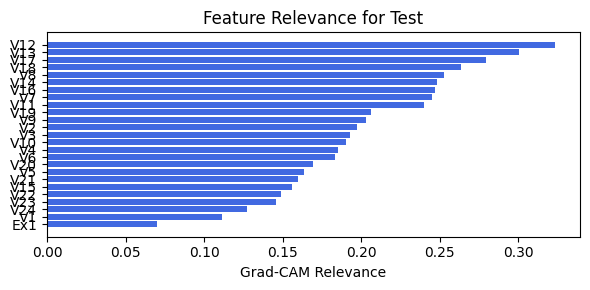

embed_dim: 64, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.93e-01 | val_acc_hybrid: 8.64e-01 |: 100%|███| 110/110 [00:48<00:00,  2.29it/s]

saving model version 0.1
✅ Best validation Accuracy: 8.6827e-01 at 98 epoch
tensor(0.8727, device='cuda:0')
[[387  37   9   8]
 [ 16 388  14   2]
 [  1  10  52   3]
 [ 17   7  15 126]]
M_KAN Relevance: 0.07537810504436493
CNN Relevance: 0.9246218800544739
[('V11', 0.2317413), ('V19', 0.22244726), ('V1', 0.20931862), ('V14', 0.20229395), ('V22', 0.16070168), ('V13', 0.16034225), ('V21', 0.15928492), ('V24', 0.15242387), ('V17', 0.13539574), ('V2', 0.13412975), ('V10', 0.132508), ('V16', 0.13168348), ('V20', 0.13079986), ('V15', 0.12575291), ('V23', 0.11216092), ('V12', 0.091139354), ('V5', 0.08871428), ('V18', 0.08668678), ('V4', 0.08107648), ('V3', 0.07720404), ('V7', 0.06486182), ('V9', 0.060436483), ('V6', 0.048377108), ('V8', 0.037133154)]


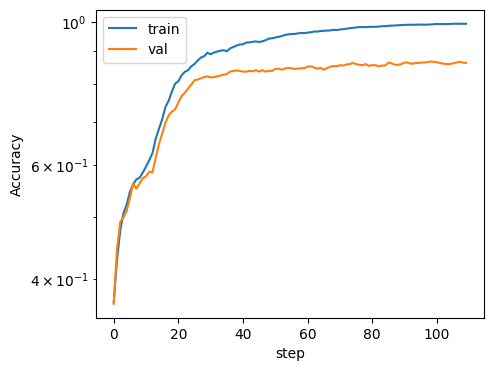

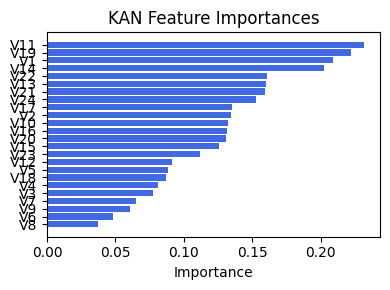

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V13', 0.3846133330255029), ('V14', 0.35730886855802324), ('V12', 0.35075925671002545), ('V19', 0.3364598044128611), ('V18', 0.33031731125691416), ('V8', 0.3236521844028908), ('V9', 0.30715066374450345), ('V17', 0.2966995648583999), ('V7', 0.26064236345551667), ('V4', 0.22814070757933902), ('V3', 0.2236861431494497), ('V2', 0.2199967636086299), ('V11', 0.19568684178256807), ('V16', 0.1946896022508597), ('V20', 0.16429352334290298), ('V6', 0.15142487946038702), ('V15', 0.1491976894185394), ('V24', 0.14253294404643851), ('V23', 0.1322546305582697), ('V10', 0.12643033530421968), ('V1', 0.12478210723004902), ('V22', 0.10920405691946816), ('Ex1', 0.10358203725757985), ('V21', 0.09962134718487825), ('V5', 0.09656004148942991)]


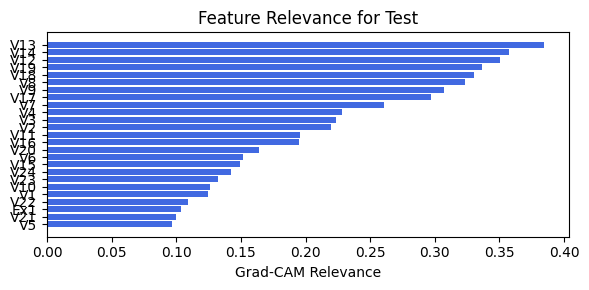

embed_dim: 32, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.95e-01 | val_acc_hybrid: 8.40e-01 |: 100%|███| 110/110 [00:39<00:00,  2.79it/s]


saving model version 0.1
✅ Best validation Accuracy: 8.6254e-01 at 48 epoch
tensor(0.8764, device='cuda:0')
[[388  36   7  10]
 [ 18 399   3   0]
 [  3  11  47   5]
 [ 18  16   8 123]]
M_KAN Relevance: 0.31070271134376526
CNN Relevance: 0.6892973184585571
[('V5', 0.26784888), ('V12', 0.24542932), ('V10', 0.24297714), ('V21', 0.20830701), ('V1', 0.18685216), ('V11', 0.17878413), ('V14', 0.17612939), ('V22', 0.17521341), ('V13', 0.15406656), ('V24', 0.15184508), ('V19', 0.14579503), ('V6', 0.14374392), ('V23', 0.1370067), ('V16', 0.13600865), ('V7', 0.12998238), ('V2', 0.12880306), ('V15', 0.11768373), ('V20', 0.11420176), ('V18', 0.10245239), ('V4', 0.09464061), ('V9', 0.091430485), ('V17', 0.08696117), ('V3', 0.0843407), ('V8', 0.082209006)]


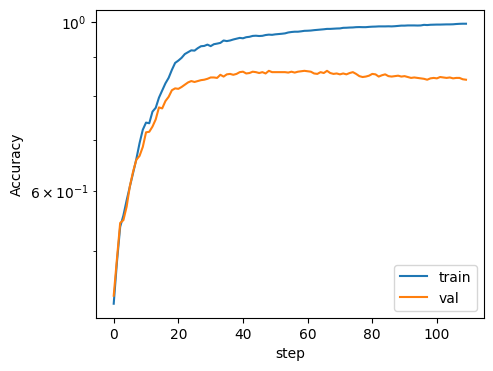

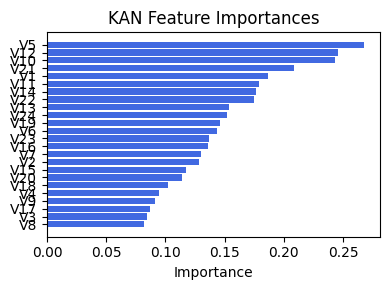

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V13', 0.34597231220068486), ('V19', 0.3320151221482258), ('V18', 0.33200394804083067), ('V8', 0.31317596870663), ('V17', 0.3127751719426609), ('V12', 0.2952793900487996), ('V7', 0.2822366660260568), ('V14', 0.2792990225844423), ('V24', 0.24603531092530903), ('V23', 0.2422942660655997), ('V22', 0.24117520949626325), ('V9', 0.24094081587467064), ('V11', 0.24010130187206324), ('V3', 0.22615752036614178), ('V21', 0.2199364879812932), ('V16', 0.21427668049885046), ('V6', 0.20877666902782743), ('V2', 0.2022283093710573), ('V4', 0.18235267745193673), ('V20', 0.17497506689731035), ('V1', 0.14965315898415604), ('V5', 0.14118041966861838), ('V15', 0.13843467755952335), ('V10', 0.1316835289348118), ('Ex1', 0.10857819047153468)]


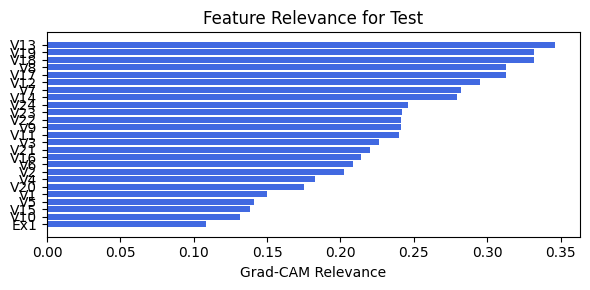

embed_dim: 32, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.91e-01 | val_acc_hybrid: 8.76e-01 |: 100%|███| 110/110 [00:40<00:00,  2.69it/s]


saving model version 0.1
✅ Best validation Accuracy: 8.8316e-01 at 90 epoch
tensor(0.8791, device='cuda:0')
[[399  29   6   7]
 [ 21 390   8   1]
 [  3  10  49   4]
 [ 19   7  17 122]]
M_KAN Relevance: 0.3620476722717285
CNN Relevance: 0.6379523277282715
[('V1', 0.260303), ('V14', 0.22049761), ('V19', 0.21057756), ('V13', 0.21037439), ('V24', 0.18540706), ('V21', 0.18309624), ('V16', 0.17950991), ('V22', 0.16114594), ('V23', 0.1604327), ('V20', 0.16024162), ('V18', 0.15023056), ('V17', 0.12565556), ('V5', 0.124877386), ('V11', 0.11069287), ('V12', 0.09872246), ('V10', 0.087525465), ('V6', 0.08306649), ('V2', 0.08064851), ('V15', 0.07990135), ('V7', 0.07421661), ('V9', 0.060346927), ('V8', 0.060294367), ('V3', 0.05146904), ('V4', 0.046833117)]


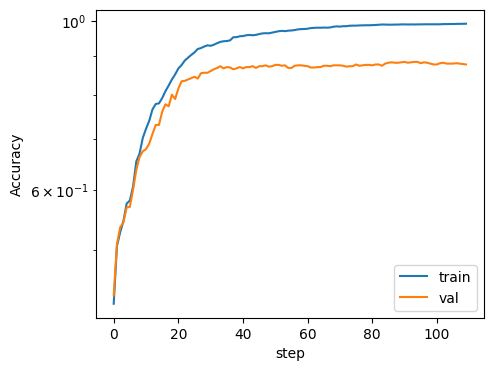

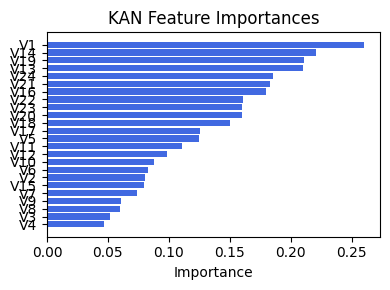

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V19', 0.3653413856001409), ('V18', 0.34168762022897176), ('V14', 0.3352439668401713), ('V13', 0.33146960047758506), ('V17', 0.30407058510671037), ('V8', 0.29619068564077833), ('V9', 0.284327455964448), ('V12', 0.2781773337722507), ('V20', 0.25104102871385864), ('V7', 0.24647430923460145), ('V24', 0.23960887706550069), ('V23', 0.2303518038169496), ('V22', 0.2070533013265092), ('V3', 0.19335131457139654), ('V15', 0.1834975051532248), ('V10', 0.18095094175744272), ('V11', 0.17918486236850342), ('V4', 0.17868979135506885), ('V16', 0.17737010162779834), ('V5', 0.17396936497087673), ('V21', 0.16731759096767365), ('V2', 0.16314791630331069), ('V6', 0.14561165820249874), ('Ex1', 0.12759941457510643), ('V1', 0.10310478136233918)]


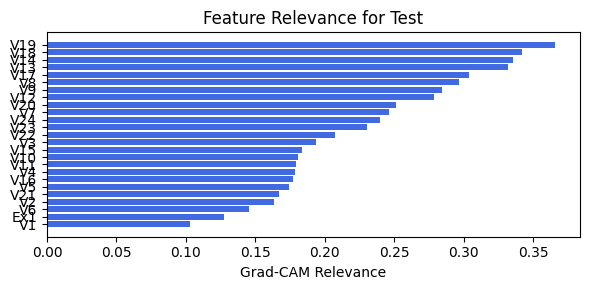

embed_dim: 32, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.95e-01 | val_acc_hybrid: 8.72e-01 |: 100%|███| 110/110 [00:40<00:00,  2.70it/s]


saving model version 0.1
✅ Best validation Accuracy: 8.9118e-01 at 87 epoch
tensor(0.8855, device='cuda:0')
[[397  27   7  10]
 [ 15 398   6   1]
 [  1  12  49   4]
 [ 14   8  20 123]]
M_KAN Relevance: 0.408115416765213
CNN Relevance: 0.5918845534324646
[('V1', 0.25503278), ('V19', 0.22085977), ('V13', 0.21818462), ('V14', 0.19824563), ('V24', 0.18185434), ('V16', 0.16975592), ('V22', 0.15688871), ('V20', 0.15507384), ('V21', 0.15413849), ('V23', 0.14483641), ('V12', 0.13087715), ('V18', 0.11441066), ('V6', 0.106354676), ('V17', 0.10211682), ('V4', 0.09538027), ('V5', 0.0925976), ('V11', 0.08860099), ('V15', 0.08003422), ('V7', 0.07480666), ('V10', 0.07247937), ('V2', 0.07194822), ('V9', 0.062049158), ('V3', 0.052464344), ('V8', 0.04010044)]


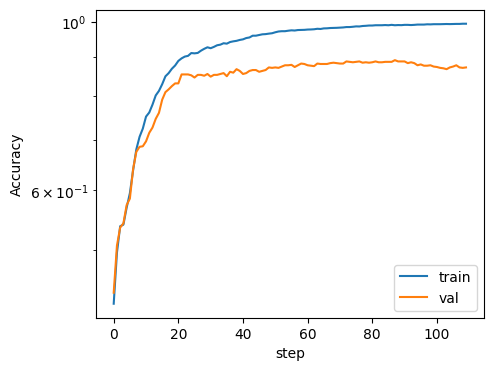

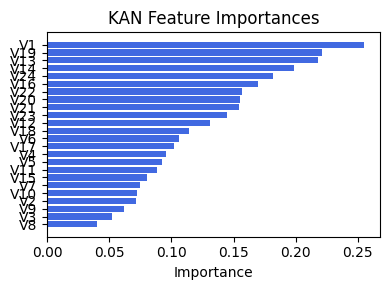

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V13', 0.3633541167004922), ('V18', 0.33256290899547014), ('V8', 0.31638876895712675), ('V19', 0.3110991754853116), ('V14', 0.30607025068908755), ('V12', 0.2840310567971822), ('V9', 0.27931095533469635), ('V17', 0.2786732902000256), ('V11', 0.2675148240388021), ('V7', 0.2639832326769445), ('V16', 0.2320477978567233), ('V4', 0.20554092663202533), ('V6', 0.19817008348232215), ('V3', 0.1847483805553892), ('V20', 0.1815758562132052), ('V2', 0.18079961078780263), ('V15', 0.17447662094129068), ('V10', 0.16376314092320457), ('V24', 0.1564255816020428), ('Ex1', 0.15157730123626226), ('V21', 0.1436057808961058), ('V1', 0.14041566135588937), ('V23', 0.12579010569537613), ('V5', 0.11375711619205374), ('V22', 0.11188210766956147)]


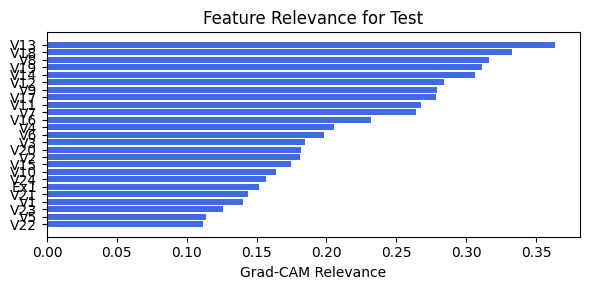

embed_dim: 16, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.89e-01 | val_acc_hybrid: 8.81e-01 |: 100%|███| 110/110 [00:38<00:00,  2.87it/s]


saving model version 0.1
✅ Best validation Accuracy: 8.8202e-01 at 76 epoch
tensor(0.8736, device='cuda:0')
[[398  26  11   6]
 [ 18 389  11   2]
 [  2   9  48   7]
 [ 12  12  22 119]]
M_KAN Relevance: 0.623243510723114
CNN Relevance: 0.376756489276886
[('V21', 0.24907099), ('V5', 0.21860652), ('V1', 0.21393417), ('V11', 0.17793426), ('V19', 0.17523758), ('V13', 0.17027247), ('V14', 0.16931535), ('V12', 0.16780692), ('V24', 0.15095457), ('V22', 0.14848287), ('V2', 0.13762018), ('V23', 0.13565923), ('V10', 0.12895374), ('V16', 0.12768428), ('V20', 0.12123668), ('V6', 0.11295445), ('V17', 0.11251392), ('V15', 0.10210233), ('V7', 0.09856751), ('V18', 0.091124475), ('V3', 0.08958205), ('V9', 0.08437516), ('V4', 0.075654775), ('V8', 0.070022166)]


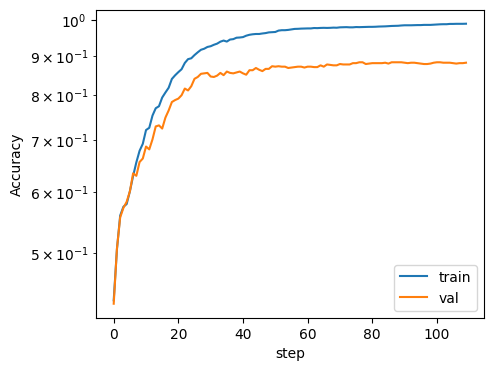

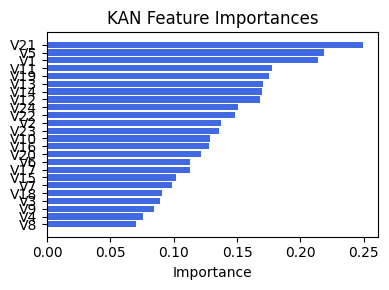

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V13', 0.3497267321983247), ('V8', 0.3342657813739676), ('V9', 0.313017623512575), ('V12', 0.3079835600364653), ('V14', 0.3066034949989734), ('V18', 0.30420504134611465), ('V17', 0.3020951680248137), ('V7', 0.2830165655356653), ('V19', 0.25371224292454525), ('V24', 0.24270117467622784), ('V23', 0.23840561269297633), ('V3', 0.23462680212317508), ('V4', 0.23188197005974237), ('Ex1', 0.22427981984846498), ('V2', 0.21418436737040283), ('V15', 0.21000144447410363), ('V22', 0.2052131200450006), ('V20', 0.20383689894812723), ('V10', 0.20085624135723537), ('V11', 0.16557847128188724), ('V16', 0.1648358069918879), ('V6', 0.13520276442130913), ('V5', 0.12610241729996297), ('V21', 0.09295088214755626), ('V1', 0.0899939921801245)]


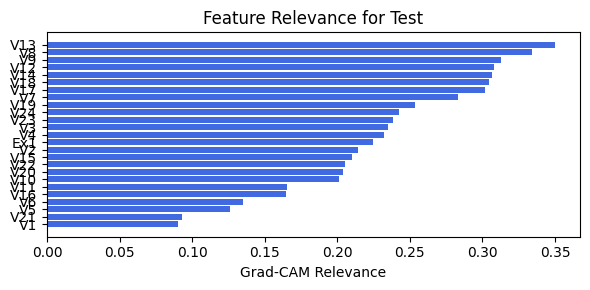

embed_dim: 16, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.91e-01 | val_acc_hybrid: 8.60e-01 |: 100%|███| 110/110 [00:39<00:00,  2.77it/s]


saving model version 0.1
✅ Best validation Accuracy: 8.7973e-01 at 52 epoch
tensor(0.8590, device='cuda:0')
[[394  35   7   5]
 [ 31 376  10   3]
 [  1  15  48   2]
 [  6  16  23 120]]
M_KAN Relevance: 0.5694021582603455
CNN Relevance: 0.43059787154197693
[('V5', 0.29847252), ('V21', 0.24651113), ('V10', 0.20435014), ('V12', 0.20397352), ('V11', 0.18686207), ('V19', 0.16765006), ('V14', 0.1617378), ('V22', 0.15463935), ('V7', 0.13995369), ('V1', 0.13947046), ('V24', 0.11919805), ('V16', 0.11908921), ('V6', 0.11699438), ('V15', 0.11453145), ('V2', 0.110724784), ('V23', 0.105055265), ('V17', 0.10467447), ('V13', 0.09940254), ('V4', 0.09587431), ('V9', 0.09105621), ('V3', 0.088490784), ('V18', 0.08576349), ('V20', 0.07891575), ('V8', 0.07828184)]


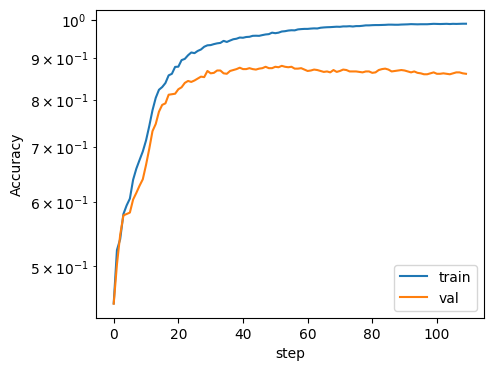

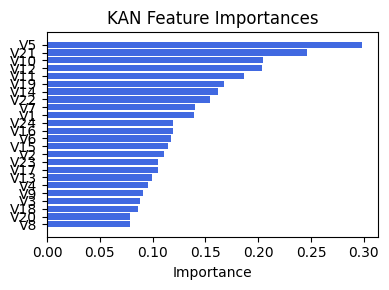

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V13', 0.4376918715629522), ('V18', 0.4226360908682175), ('V17', 0.42056442496636304), ('V19', 0.4203824115096849), ('V14', 0.39232830709825534), ('V12', 0.3744922642418671), ('V8', 0.3615248939832638), ('V7', 0.34244831509165585), ('V9', 0.33219640892282154), ('V22', 0.20543742291488593), ('V23', 0.2005618527815626), ('V24', 0.2002496346713787), ('V16', 0.1933138349668964), ('V11', 0.19092095757820968), ('V20', 0.1838902281216668), ('V2', 0.18220233437609468), ('V3', 0.17600439028173084), ('V6', 0.1744838351564345), ('V15', 0.17012386074580824), ('V10', 0.1591201574373615), ('V4', 0.1419994573236994), ('Ex1', 0.12339704404183686), ('V1', 0.11055515486671975), ('V5', 0.09947140997611736), ('V21', 0.09735348341139434)]


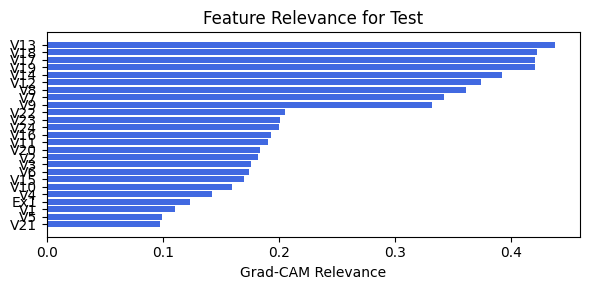

embed_dim: 16, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.96e-01 | val_acc_hybrid: 8.69e-01 |: 100%|███| 110/110 [00:43<00:00,  2.53it/s]


saving model version 0.1
✅ Best validation Accuracy: 8.7743e-01 at 82 epoch
tensor(0.8718, device='cuda:0')
[[394  26  12   9]
 [ 29 371  19   1]
 [  1   7  56   2]
 [ 11   8  15 131]]
M_KAN Relevance: 0.5110920667648315
CNN Relevance: 0.48890796303749084
[('V21', 0.24984768), ('V5', 0.24712387), ('V1', 0.20073985), ('V14', 0.19046456), ('V19', 0.18693511), ('V11', 0.17546515), ('V13', 0.16979222), ('V12', 0.1677906), ('V10', 0.1663581), ('V23', 0.16225258), ('V22', 0.1614887), ('V24', 0.15320288), ('V6', 0.13727355), ('V20', 0.12738207), ('V16', 0.12539582), ('V17', 0.1241762), ('V7', 0.12054183), ('V2', 0.11834178), ('V15', 0.114157155), ('V3', 0.09488933), ('V18', 0.09028082), ('V9', 0.07550948), ('V4', 0.05949637), ('V8', 0.050535735)]


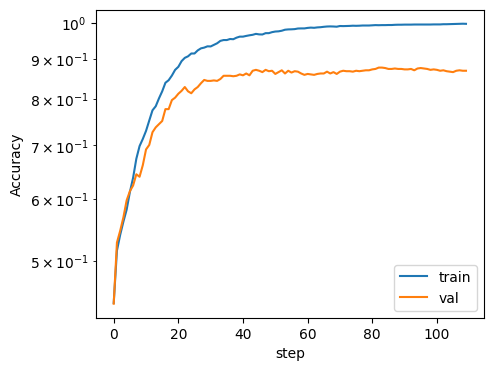

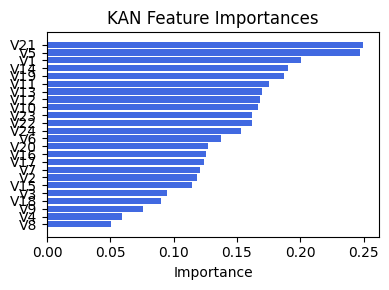

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V13', 0.45503174434347765), ('V14', 0.41580304969805754), ('V19', 0.40657935253736366), ('V18', 0.4031109623704788), ('V17', 0.37340558352863124), ('V8', 0.3433846127866143), ('V9', 0.34284262425665346), ('V12', 0.340644597856246), ('V7', 0.2982479429205934), ('V22', 0.1946547810711485), ('V24', 0.19349576126964893), ('V20', 0.19311138223976088), ('V23', 0.18645289522956462), ('V3', 0.1765569626230443), ('V10', 0.1668718311090906), ('V15', 0.16054785462892052), ('V4', 0.15555255737662274), ('V2', 0.14458992583003413), ('V16', 0.13190279864269436), ('V11', 0.12864569272341092), ('Ex1', 0.1279416217307915), ('V6', 0.10897630424538948), ('V5', 0.10307780297282726), ('V21', 0.07441776908349694), ('V1', 0.06833874356292015)]


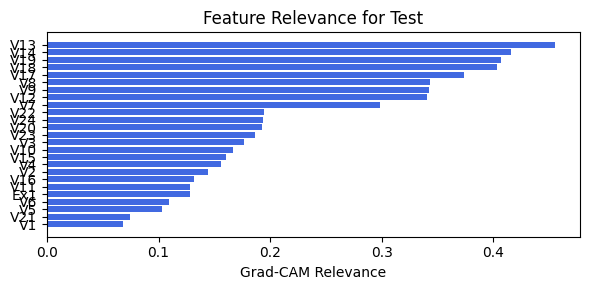

In [48]:
for embed_dim in [64, 32, 16]:
    for num_head in [2, 4 , 8]:
        print(f"embed_dim: {embed_dim}, num_head:{num_head}")
        train_and_plot_relevance(Model3_4, kan_neurons=11, kan_grid=3, lamb=0.001, steps=110, 
                                 embed_dim=embed_dim, num_heads=num_head, filename=filename_4, opt_col_val=f'{embed_dim}, {num_head}')

## 4.3. width=[24, 7], grid=3, lamb=0.001

embed_dim: 64, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.91e-01 | val_acc_hybrid: 8.85e-01 |: 100%|███| 110/110 [00:43<00:00,  2.51it/s]


saving model version 0.1
✅ Best validation Accuracy: 8.9118e-01 at 84 epoch
tensor(0.8745, device='cuda:0')
[[401  22  14   4]
 [ 32 379   6   3]
 [  2   9  53   2]
 [ 16  11  16 122]]
M_KAN Relevance: 0.12583857774734497
CNN Relevance: 0.8741614818572998
[('V15', 0.2728121), ('V14', 0.26509675), ('V24', 0.2254701), ('V13', 0.1988163), ('V22', 0.19879992), ('V9', 0.17586744), ('V1', 0.17380317), ('V7', 0.17181572), ('V19', 0.16425112), ('V23', 0.16360433), ('V21', 0.14021964), ('V20', 0.13901387), ('V16', 0.13723291), ('V2', 0.12596536), ('V17', 0.11028831), ('V18', 0.107642375), ('V11', 0.10667124), ('V5', 0.10455958), ('V3', 0.09592153), ('V6', 0.08828388), ('V12', 0.08780999), ('V10', 0.06925823), ('V8', 0.06884657), ('V4', 0.05026436)]


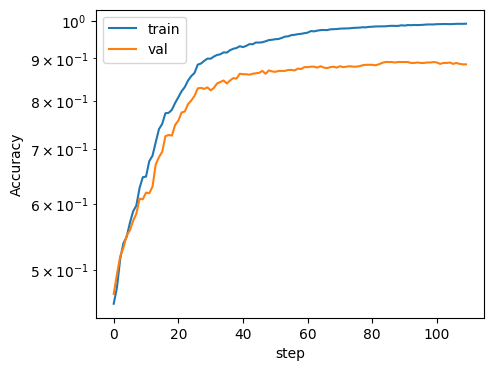

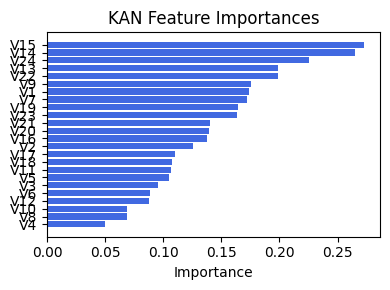

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V18', 0.4925096050440419), ('V13', 0.4640881797919671), ('V19', 0.4582179030122051), ('V17', 0.45459520878805865), ('V14', 0.4367400870040987), ('V12', 0.3804602893274073), ('V8', 0.36100346505328085), ('V9', 0.3380593705505317), ('V7', 0.31823527553704467), ('V23', 0.23109066056943883), ('V24', 0.213962281155852), ('V22', 0.21090029168195149), ('V16', 0.1884826410501247), ('V20', 0.16592419103462583), ('V11', 0.15311760847429462), ('V10', 0.13941775887320584), ('V15', 0.13845850813367588), ('V6', 0.12800037426359767), ('V3', 0.1279682945228743), ('V5', 0.12591073331551567), ('V2', 0.1214311321763799), ('V4', 0.11975501179260171), ('V21', 0.10996551266760521), ('Ex1', 0.09777751841082155), ('V1', 0.06378893140445877)]


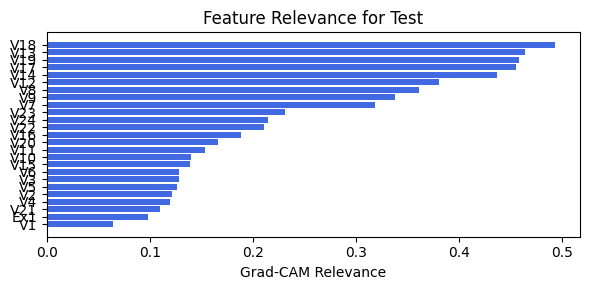

embed_dim: 64, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.83e-01 | val_acc_hybrid: 8.93e-01 |: 100%|███| 110/110 [00:43<00:00,  2.50it/s]


saving model version 0.1
✅ Best validation Accuracy: 8.9462e-01 at 105 epoch
tensor(0.8919, device='cuda:0')
[[403  24   9   5]
 [ 21 387   9   3]
 [  0   5  59   2]
 [ 14   9  17 125]]
M_KAN Relevance: 0.1894521713256836
CNN Relevance: 0.8105478286743164
[('V15', 0.27907017), ('V24', 0.23238108), ('V14', 0.20088205), ('V1', 0.19437547), ('V22', 0.18984383), ('V13', 0.18335032), ('V23', 0.16270223), ('V19', 0.15398733), ('V20', 0.15198922), ('V9', 0.14886923), ('V16', 0.14839555), ('V5', 0.13822426), ('V7', 0.13692291), ('V21', 0.12916741), ('V3', 0.120727405), ('V11', 0.11874766), ('V2', 0.10700964), ('V18', 0.10268375), ('V17', 0.09677531), ('V10', 0.093307845), ('V8', 0.07563823), ('V4', 0.07239415), ('V6', 0.071750715), ('V12', 0.061341695)]


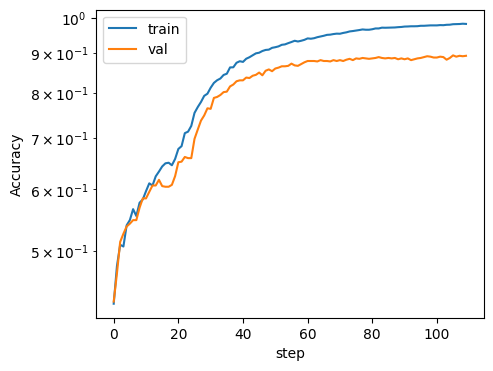

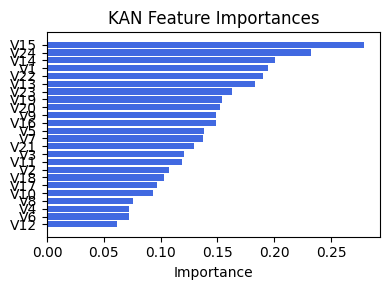

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V18', 0.4787711122400731), ('V13', 0.4611563596349114), ('V17', 0.45506444117591643), ('V19', 0.45114238693757536), ('V14', 0.43720331240612537), ('V12', 0.38619317982052437), ('V8', 0.3591055016640161), ('V9', 0.34400150986412203), ('V7', 0.3264329528071687), ('V20', 0.2247345042468267), ('V23', 0.2184234165830449), ('V22', 0.2125048966280478), ('V16', 0.21240838266817014), ('V24', 0.20522091841719772), ('V11', 0.18650147706805814), ('V15', 0.18604761040974205), ('V10', 0.18358360861597642), ('V6', 0.146642628630526), ('V21', 0.13582831930800685), ('V3', 0.12804114471692385), ('V2', 0.12695251506249652), ('V4', 0.12513761834395817), ('Ex1', 0.10575304976847848), ('V5', 0.09322498412205814), ('V1', 0.060154805750067555)]


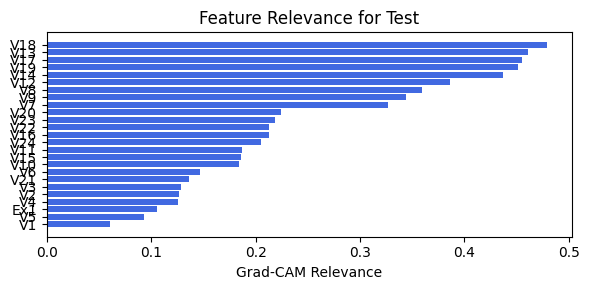

embed_dim: 64, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.83e-01 | val_acc_hybrid: 8.50e-01 |: 100%|███| 110/110 [00:46<00:00,  2.36it/s]


saving model version 0.1
✅ Best validation Accuracy: 8.6827e-01 at 53 epoch
tensor(0.8590, device='cuda:0')
[[374  47  12   8]
 [ 25 385   7   3]
 [  1  14  50   1]
 [ 12   8  16 129]]
M_KAN Relevance: 0.08929041028022766
CNN Relevance: 0.9107096195220947
[('V13', 0.26309744), ('V14', 0.2500356), ('V9', 0.21682642), ('V15', 0.21155757), ('V22', 0.1969334), ('V24', 0.19187355), ('V7', 0.15985902), ('V21', 0.15639839), ('V23', 0.14659043), ('V19', 0.14587587), ('V1', 0.14425363), ('V3', 0.12845309), ('V16', 0.12118022), ('V20', 0.116020076), ('V5', 0.11354717), ('V12', 0.11342966), ('V6', 0.105472244), ('V18', 0.092238344), ('V2', 0.091219924), ('V17', 0.08034999), ('V8', 0.072713606), ('V10', 0.070680015), ('V11', 0.06795642), ('V4', 0.039912738)]


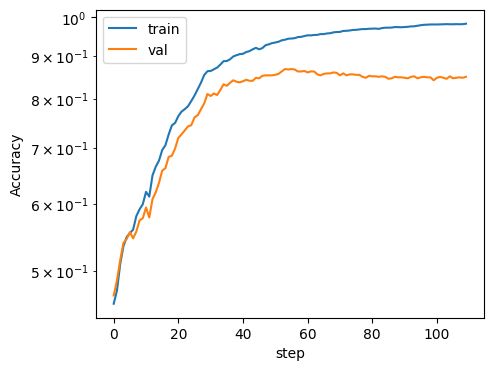

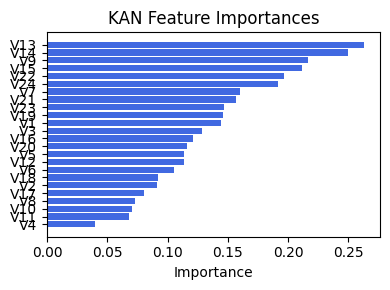

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V18', 0.38193231264974464), ('V19', 0.34989612571808343), ('V17', 0.3324312566060593), ('V14', 0.32667268433261853), ('V13', 0.32542499444757045), ('V12', 0.28851952217561927), ('V23', 0.2626579331043057), ('V22', 0.25684343711911206), ('V9', 0.2423039302061708), ('V8', 0.24034212531301025), ('V24', 0.24017101248286812), ('V7', 0.23859432686622178), ('V20', 0.21071651992111756), ('V16', 0.20926579648573182), ('V11', 0.20204301557615365), ('V10', 0.18762497536997114), ('V15', 0.1745553748830219), ('Ex1', 0.15859621427325327), ('V21', 0.15214787095107865), ('V6', 0.1518469123195792), ('V5', 0.14312914486058267), ('V3', 0.136781439433258), ('V4', 0.13631534978475307), ('V2', 0.12342148567482489), ('V1', 0.07598614464114979)]


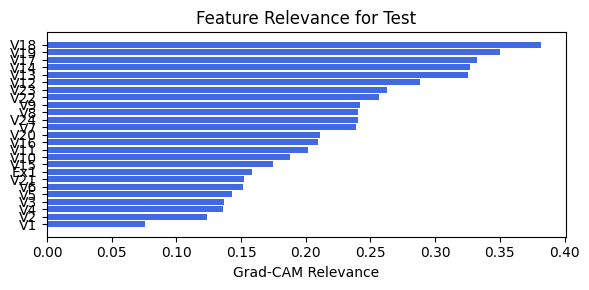

embed_dim: 32, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.88e-01 | val_acc_hybrid: 8.45e-01 |: 100%|███| 110/110 [00:37<00:00,  2.93it/s]


saving model version 0.1
✅ Best validation Accuracy: 8.5338e-01 at 69 epoch
tensor(0.8471, device='cuda:0')
[[384  42   8   7]
 [ 25 384   7   4]
 [  1  22  39   4]
 [  9  13  25 118]]
M_KAN Relevance: 0.14086498320102692
CNN Relevance: 0.8591350317001343
[('V1', 0.25795698), ('V24', 0.24518228), ('V22', 0.22354245), ('V20', 0.20016918), ('V14', 0.19744496), ('V15', 0.19019298), ('V16', 0.18726726), ('V23', 0.16654937), ('V19', 0.1581501), ('V21', 0.13951588), ('V18', 0.13615303), ('V9', 0.11069295), ('V17', 0.10758953), ('V13', 0.107309856), ('V7', 0.091477334), ('V3', 0.0812819), ('V5', 0.06717309), ('V2', 0.0661546), ('V11', 0.057200413), ('V6', 0.051760904), ('V8', 0.0477835), ('V12', 0.043124624), ('V10', 0.03846006), ('V4', 0.030599156)]


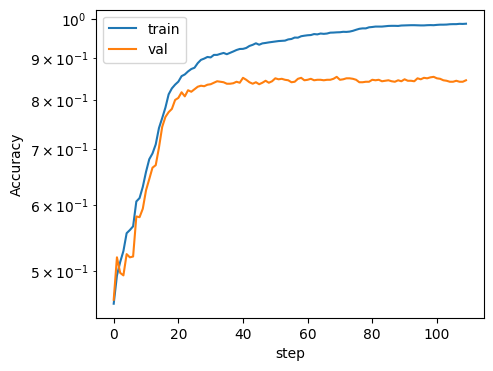

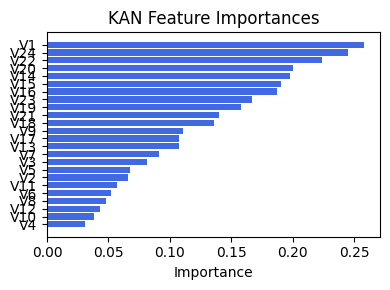

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V18', 0.3464905465418949), ('V19', 0.31416593426041095), ('V17', 0.296588192606935), ('V13', 0.28434939134947873), ('V23', 0.2574108457125083), ('V14', 0.25155472216600827), ('V24', 0.25117126538080503), ('V12', 0.248676221481492), ('V22', 0.24507232753908767), ('V8', 0.22831049242838924), ('V20', 0.22356045872085828), ('V9', 0.21759217613038306), ('V4', 0.2167829843108468), ('V7', 0.20682007366921534), ('V3', 0.18873763249983633), ('V15', 0.18863740703986528), ('V16', 0.18225611951258655), ('V11', 0.17320544085415907), ('V10', 0.1691867994979988), ('V2', 0.1661099645075893), ('V5', 0.15964070590904397), ('V6', 0.14393021884043197), ('V21', 0.13491473262602152), ('Ex1', 0.12161459242607357), ('V1', 0.08768979895972774)]


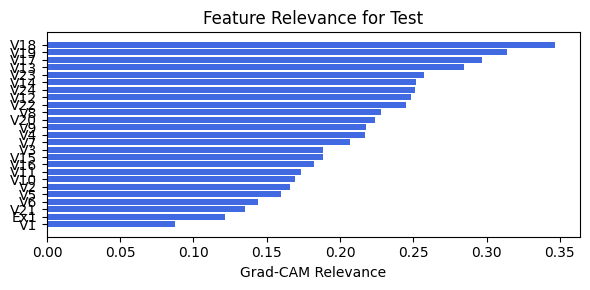

embed_dim: 32, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.81e-01 | val_acc_hybrid: 8.53e-01 |: 100%|███| 110/110 [00:39<00:00,  2.81it/s]


saving model version 0.1
✅ Best validation Accuracy: 8.6254e-01 at 87 epoch
tensor(0.8626, device='cuda:0')
[[394  29  13   5]
 [ 23 385  10   2]
 [  5  12  47   2]
 [ 13  12  24 116]]
M_KAN Relevance: 0.15993225574493408
CNN Relevance: 0.8400676846504211
[('V1', 0.26155266), ('V24', 0.25155002), ('V16', 0.21270159), ('V20', 0.20519136), ('V22', 0.18163554), ('V14', 0.17164196), ('V19', 0.16894011), ('V23', 0.13648732), ('V18', 0.13547437), ('V21', 0.1295887), ('V15', 0.12636736), ('V9', 0.1093291), ('V7', 0.108224474), ('V17', 0.0996159), ('V13', 0.08818927), ('V5', 0.07252726), ('V3', 0.07008977), ('V11', 0.06350889), ('V2', 0.05650558), ('V8', 0.053656552), ('V6', 0.05268718), ('V10', 0.042352952), ('V12', 0.03127243), ('V4', 0.030814063)]


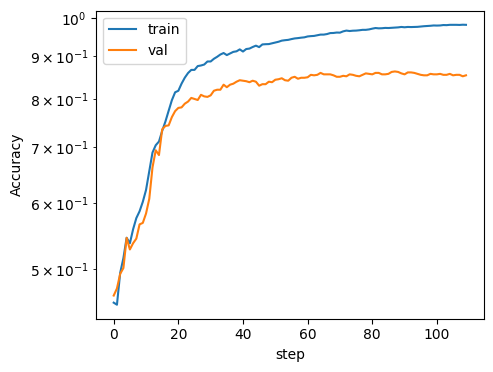

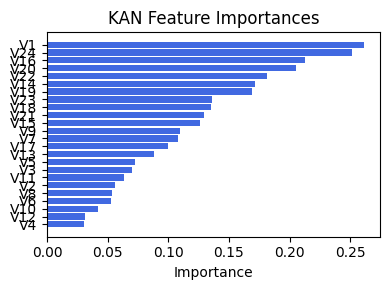

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V13', 0.351331504857083), ('V12', 0.3025120677928152), ('V8', 0.30060167485360234), ('V11', 0.29507540398443755), ('V19', 0.28153890033963397), ('V14', 0.2740938230617025), ('V17', 0.27127812190442474), ('V18', 0.26767367765790573), ('V3', 0.26102737126726533), ('V7', 0.2479753820621643), ('V16', 0.23885987222641836), ('V9', 0.23785257208958052), ('V2', 0.23251533960113763), ('V6', 0.20877370656333222), ('V4', 0.2024845644341956), ('V21', 0.1839871720644174), ('V1', 0.17992213979542968), ('V24', 0.1618450964502939), ('V20', 0.12641122851898515), ('V15', 0.11550921101934697), ('Ex1', 0.10484152251031083), ('V10', 0.09136475736054958), ('V22', 0.08916368108464254), ('V23', 0.08674671560384213), ('V5', 0.07154108113832851)]


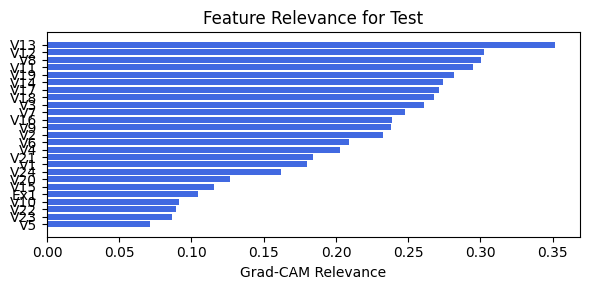

embed_dim: 32, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.92e-01 | val_acc_hybrid: 8.77e-01 |: 100%|███| 110/110 [00:42<00:00,  2.58it/s]


saving model version 0.1
✅ Best validation Accuracy: 8.8202e-01 at 107 epoch
tensor(0.8690, device='cuda:0')
[[386  37   9   9]
 [ 21 383  13   3]
 [  0  11  50   5]
 [ 10   9  16 130]]
M_KAN Relevance: 0.2028510868549347
CNN Relevance: 0.7971489429473877
[('V24', 0.22704147), ('V1', 0.2102643), ('V16', 0.19101422), ('V20', 0.17308985), ('V22', 0.16791975), ('V19', 0.15769497), ('V7', 0.14362147), ('V15', 0.12035414), ('V9', 0.114368334), ('V13', 0.11186077), ('V18', 0.10366217), ('V14', 0.09868959), ('V21', 0.09840115), ('V5', 0.0945515), ('V17', 0.09335975), ('V3', 0.08787018), ('V23', 0.08119149), ('V2', 0.075322896), ('V12', 0.064808145), ('V6', 0.060901817), ('V8', 0.056597624), ('V11', 0.045382243), ('V10', 0.044838447), ('V4', 0.028930172)]


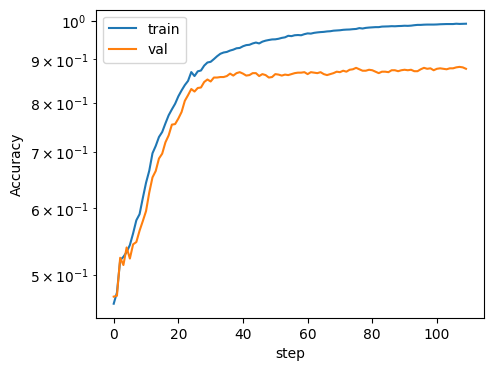

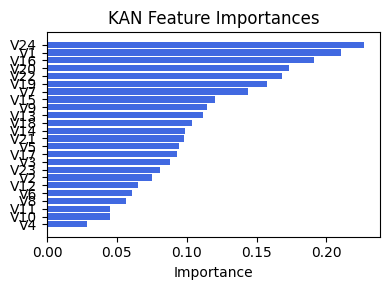

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V18', 0.3839354484337844), ('V14', 0.3819684830797843), ('V19', 0.3569448244413182), ('V13', 0.3494932514132638), ('V17', 0.33979204915026406), ('V9', 0.3023485328787115), ('V12', 0.27305597010633187), ('V8', 0.26730234546045517), ('V7', 0.23693511390635547), ('V11', 0.23360855616403117), ('V16', 0.21267776532927418), ('V6', 0.20638584673776808), ('V24', 0.20441699059411028), ('V23', 0.20211079974837676), ('V1', 0.19672369304886), ('V22', 0.17953138939804744), ('V2', 0.1642999460542182), ('V20', 0.15301516637895135), ('V3', 0.1484735762371448), ('V15', 0.14468559929292954), ('V4', 0.14446478766726764), ('V10', 0.1271487990747745), ('Ex1', 0.12611348387214266), ('V5', 0.08774014762958282), ('V21', 0.08599428012942323)]


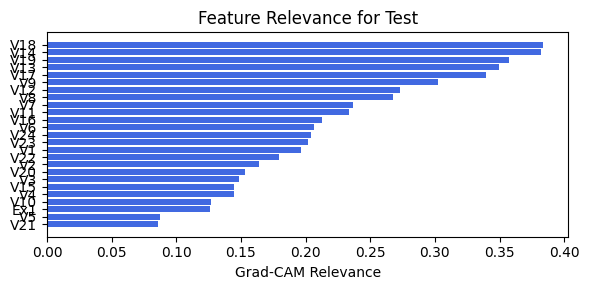

embed_dim: 16, num_head:2
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.94e-01 | val_acc_hybrid: 8.82e-01 |: 100%|███| 110/110 [00:41<00:00,  2.65it/s]


saving model version 0.1
✅ Best validation Accuracy: 8.9920e-01 at 67 epoch
tensor(0.8901, device='cuda:0')
[[404  19  11   7]
 [ 20 389  10   1]
 [  1  12  50   3]
 [ 13   9  14 129]]
M_KAN Relevance: 0.37440434098243713
CNN Relevance: 0.6255956292152405
[('V1', 0.24820617), ('V24', 0.24733958), ('V14', 0.20757006), ('V22', 0.19711983), ('V20', 0.19594774), ('V16', 0.18836479), ('V19', 0.18733919), ('V21', 0.14893664), ('V15', 0.14321673), ('V23', 0.14133385), ('V9', 0.12437114), ('V5', 0.11681062), ('V18', 0.11398865), ('V7', 0.11172126), ('V13', 0.105471894), ('V3', 0.10496775), ('V17', 0.10312371), ('V10', 0.071427554), ('V6', 0.06853709), ('V2', 0.067312576), ('V12', 0.059838038), ('V4', 0.058621716), ('V11', 0.05529964), ('V8', 0.053589296)]


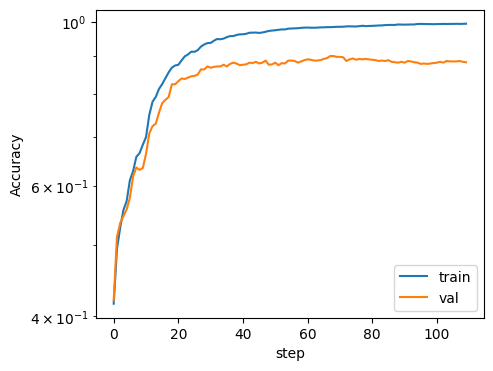

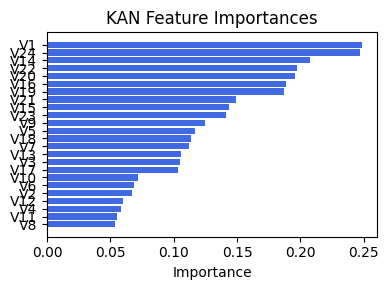

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V18', 0.3939053581154653), ('V17', 0.37559424231084526), ('V19', 0.34743699773405373), ('V13', 0.30403700743668843), ('V23', 0.2975723850950789), ('V22', 0.28396472461236877), ('V24', 0.2814957233797844), ('V12', 0.2677207196379957), ('V14', 0.23902367801321697), ('V7', 0.22766728523918026), ('V16', 0.22696630865851017), ('V8', 0.2164583665291549), ('V11', 0.19512045064878364), ('V3', 0.19401084853945957), ('V4', 0.19383163257719924), ('V9', 0.1932403870427878), ('V2', 0.180009153530581), ('V20', 0.1654394191329243), ('V6', 0.15732902879874963), ('V21', 0.1367520055376593), ('V10', 0.12498989770771111), ('V15', 0.1202929825071485), ('V5', 0.10870161352422589), ('V1', 0.1035048372968059), ('Ex1', 0.0980343288209395)]


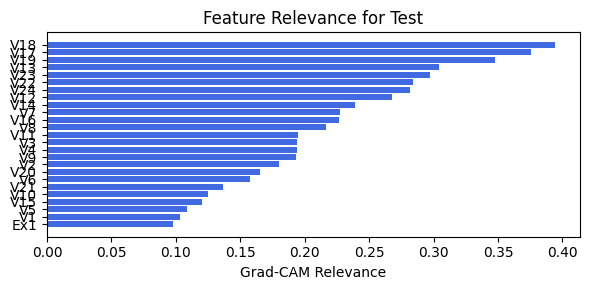

embed_dim: 16, num_head:4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.89e-01 | val_acc_hybrid: 8.74e-01 |: 100%|███| 110/110 [00:38<00:00,  2.89it/s]


saving model version 0.1
✅ Best validation Accuracy: 8.7858e-01 at 87 epoch
tensor(0.8553, device='cuda:0')
[[385  36  12   8]
 [ 23 380  11   6]
 [  0  14  48   4]
 [ 18  16  10 121]]
M_KAN Relevance: 0.6253438591957092
CNN Relevance: 0.37465617060661316
[('V1', 0.24560115), ('V24', 0.23187253), ('V20', 0.2174268), ('V22', 0.20438325), ('V16', 0.17439437), ('V14', 0.17227021), ('V19', 0.16906486), ('V23', 0.15406261), ('V13', 0.14145203), ('V15', 0.13506272), ('V21', 0.13310948), ('V7', 0.1281349), ('V18', 0.12552866), ('V11', 0.10841833), ('V17', 0.10573751), ('V9', 0.098856516), ('V6', 0.09469103), ('V8', 0.092699744), ('V5', 0.09080777), ('V3', 0.08199354), ('V10', 0.07632156), ('V12', 0.06472452), ('V2', 0.06463205), ('V4', 0.036212847)]


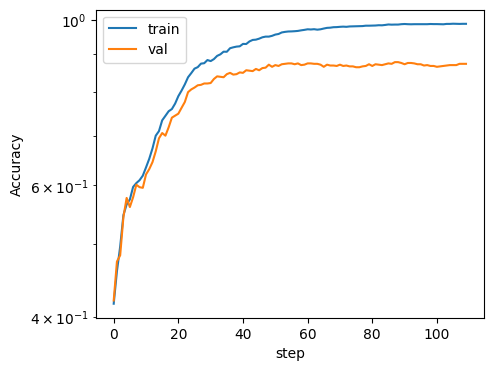

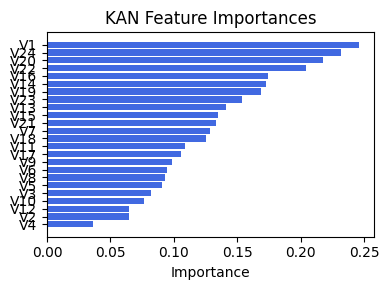

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V18', 0.39155591517940996), ('V13', 0.3161447519534984), ('V19', 0.3070731675930075), ('V23', 0.2988475456421215), ('V17', 0.29883786838263904), ('V24', 0.2826813687470182), ('V20', 0.2809403740876662), ('V14', 0.27747159362450263), ('V15', 0.26995713930121185), ('V22', 0.26904495847451965), ('V8', 0.2477701438809216), ('V12', 0.24549092144639045), ('V16', 0.23675754804688226), ('V10', 0.2261610259757174), ('V9', 0.22610264176212), ('V7', 0.2160614777842303), ('V11', 0.1917197649846514), ('V6', 0.18336194139700615), ('V21', 0.17390100618889606), ('V2', 0.1661841983707299), ('V3', 0.16341806579318402), ('Ex1', 0.13122209054144993), ('V4', 0.12340856075869129), ('V1', 0.1059628153546331), ('V5', 0.09829979203460182)]


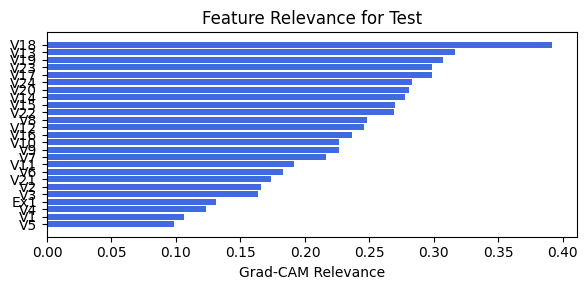

embed_dim: 16, num_head:8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_4


 train_acc_hybrid: 9.84e-01 | val_acc_hybrid: 8.38e-01 |: 100%|███| 110/110 [00:39<00:00,  2.77it/s]


saving model version 0.1
✅ Best validation Accuracy: 8.6025e-01 at 42 epoch
tensor(0.8571, device='cuda:0')
[[384  44   7   6]
 [ 23 383  10   4]
 [  1  18  44   3]
 [ 12  10  18 125]]
M_KAN Relevance: 0.6319930553436279
CNN Relevance: 0.36800694465637207
[('V14', 0.26686922), ('V15', 0.26032853), ('V24', 0.2565521), ('V22', 0.2262536), ('V19', 0.19629587), ('V9', 0.16926414), ('V13', 0.1658677), ('V1', 0.16516493), ('V7', 0.15053242), ('V20', 0.150144), ('V5', 0.146765), ('V2', 0.13800395), ('V21', 0.13574249), ('V23', 0.13100818), ('V18', 0.12850821), ('V16', 0.11614947), ('V6', 0.10359), ('V17', 0.10317886), ('V3', 0.102336355), ('V11', 0.093477316), ('V10', 0.090382524), ('V8', 0.086494006), ('V12', 0.08037357), ('V4', 0.060147688)]


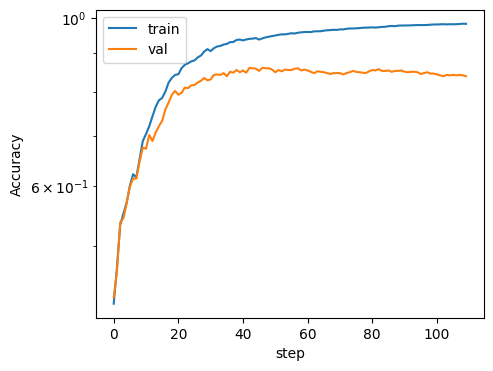

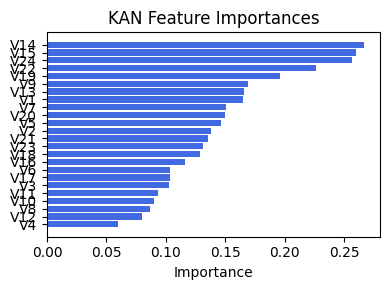

Computing Grad-CAM:   0%|          | 0/1092 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('V13', 0.39439397636580753), ('V14', 0.3757430992738238), ('V18', 0.33912605895440034), ('V9', 0.3386928110498907), ('V8', 0.3349757435144822), ('V19', 0.31061012619871164), ('V15', 0.3031074561873178), ('V20', 0.28721575938973165), ('V10', 0.26827425273073363), ('V24', 0.26222391665201344), ('V12', 0.2594633317446326), ('V17', 0.25359958684486705), ('V7', 0.2418995160521426), ('V23', 0.23409888715139546), ('V22', 0.2197367674664184), ('V4', 0.2007629338621992), ('V3', 0.1941576172084285), ('Ex1', 0.1564602757320471), ('V5', 0.15307317716639238), ('V2', 0.14474822667382767), ('V16', 0.12502928877915603), ('V11', 0.12026854722183924), ('V6', 0.10462768354315542), ('V21', 0.09492277003478222), ('V1', 0.08779775515491871)]


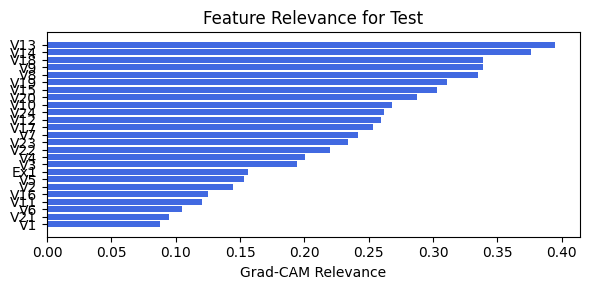

In [49]:
for embed_dim in [64, 32, 16]:
    for num_head in [2, 4 , 8]:
        print(f"embed_dim: {embed_dim}, num_head:{num_head}")
        train_and_plot_relevance(Model3_4, kan_neurons=7, kan_grid=3, lamb=0.001, steps=110, 
                                 embed_dim=embed_dim, num_heads=num_head, filename=filename_4, opt_col_val=f'{embed_dim}, {num_head}')